Voy a usar los datos de Temperatura, Precipitacion del dia anterior y Presion ya que son con los que mejores resultados he obtenido hasta ahora. Usaré Optuna para optimizar los modelos para obtener mejores resultados.

Ademas seguire poniendo equilibrando el undersampling solo de los datos de entrenamiento, y eligiendo parcelas enteras como datos de test.

In [1]:
def algoritmo(df2, fecha, show, parcela):
    diasTotales = 365 + 31
    #from IPython.core.display import display, HTML
    #display(HTML("<style>div.output_scroll { height: 90em; }</style>"))

    import pandas as pd
    import matplotlib.pyplot as plt
    import numpy as np
    import datetime

    import warnings
    warnings.filterwarnings("ignore")
    
    borrarDebajo = 0.15
    
    fechas = list()
    fechas2 = list()
    valores = list()
    valores2= list()
    N = int(df2.size / 3) #numero de valores que tenemos para esta parcela

    #Almacenamos los datos originales de la parcela en 'fechas' y 'valores'
    #En 'fechas2' y 'valores2' almacenamos los datos cuyo ndvi esté por encima de 'borrarDebajo'
    for i in range(N):
        data = df2.iloc[i].fecha
        data = str(data)
        #Esto convierte la cadena YYYYMMDD en un tipo de dato fecha
        dt = datetime.datetime.strptime(data, "%Y%m%d")
        dtInt = int(dt.strftime("%j"))
        if int(data) >= 20220000:
            dtInt = dtInt +365
        #Convierto ese tipo de dato fecha en un entero, el dia del año de esa fecha
        #Ej. 20210202 es el 2 de febrero y es el dia 33 del año
        fechas.append(dtInt)
        ndvi = df2.iloc[i].ndvi
        valores.append(ndvi)
        #Solo añado si el valor está por encima de la variable "borrarDebajo"
        if ndvi >= borrarDebajo:
            valores2.append(ndvi)
            fechas2.append(dtInt)

    #Borramos de 'valores2' y 'fechas2' los datos cuyos ndvi sean menores que el dato anterior y al siguiente (valores valle)
    #Ejemplo: si tenemos los valores [3,1,2,4], borramos los valores 1 y 2
    #Si tenemos los valores [3,1,4], borramos el valor 1
    #Borramos los valores valle
    for i in range(len(valores2)-1):
        if i > 0 and i < len(valores2)-1:
            #Si hay 2 valores juntos menores que el anterior y el siguiente, se borran ambos
            if i < (len(valores2) - 2) and valores2[i-1] > valores2[i] and valores2[i-1] > valores2[i+1] and valores2[i+2] > valores2[i] and valores2[i+2] > valores2[i+1]:
                del valores2[i]
                del fechas2[i]
                del valores2[i]
                del fechas2[i]
            #En el caso de que solo haya un minimo entre 2 puntos
            elif valores2[i-1] > valores2[i] and valores2[i+1] > valores2[i]:
                del valores2[i]
                del fechas2[i]        






    #Variables:
    saltoFechas = 10
    saltoFechas2 = 20
    saltoFechas3 = 30
    añadirPorDebajo = 0.4 #antes se llamaba maximoMinimo
    añadirPorEncima = 0.2

    #Añado informacion al principio y final de año si no habia
    if fechas2[0] > 0:
        fechas2.insert(0, 0)
        valores2.insert(0, valores2[0])
    if fechas2[len(fechas2) -1] < diasTotales:
        fechas2.insert(len(fechas2), diasTotales)
        valores2.insert(len(valores2), valores2[len(valores2)-1])


    #Si hay saltos muy grandes sin informacion se trata:
    i = 0
    while i < len(fechas2) - 1: 
        encontrado = False
        #Si el salto es muy grande
        if (fechas2[i+1]-fechas2[i]) >= saltoFechas3 and i+1 != (len(fechas2) -1) and i != 0:
            #buscar maximos locales entre los dos puntos y
            aux1 = 0
            aux2 = 0
            for j in range(len(fechas) - 1):
                if fechas[j] <= fechas2[i] and fechas[j+1] >= fechas2[i]:
                    aux1 = j
                elif fechas[j] <= fechas2[i]  and fechas[j+1] >= fechas2[i]   :
                    aux2 = j
                    break
            j = aux1 + 1
            auxSum = 0
            while (j < aux2):
                if valores[j] > valores[j-1] and valores[j] > valores[j+1]:
                    # y volverlos a añadir segun su valor
                    if (valores2[i] <= 0.6 and valores2[i+1] <=0.6 and valores[j] <= añadirPorDebajo and valores[j] >= añadirPorEncima):
                        fechas2.insert(i+1+ auxSum, fechas[j])
                        valores2.insert(i+1+ auxSum, valores[j])
                        auxSum = auxSum + 1
                        encontrado = True
                j = j + 1



        if encontrado == False:    
            #Si el salto es intermedio
            if (fechas2[i+1]-fechas2[i]) >= saltoFechas2:
                if valores2[i+1] > valores2[i]: #va hacia arriba
                    fechas2.insert(i+1, fechas2[i] + ((fechas2[i+1] - fechas2[i]) / 3)*2)
                    valores2.insert(i+1, valores2[i] + ((valores2[i+1] - valores2[i]) / 3))
                else: #va hacia abajo
                    fechas2.insert(i+1, fechas2[i] + ((fechas2[i+1] - fechas2[i]) / 3))
                    valores2.insert(i+1,  valores2[i+1] + ((valores2[i] - valores2[i+1]) / 3))
            #Si el salto es pequeño
            elif (fechas2[i+1]-fechas2[i]) >= saltoFechas:
                fechas2.insert(i+1, (fechas2[i+1]+fechas2[i])/2)
                valores2.insert(i+1, (valores2[i+1]+valores2[i])/2)
        i = i+1


    #Plot    
    from scipy.interpolate import make_interp_spline
    from scipy.interpolate import interp1d

    #Esto crea una linea de <diasTotales> puntos que pasa por todos los puntos que teniamos
    X_Y_Spline = make_interp_spline(fechas2,valores2)        
    X = np.linspace(0, diasTotales, diasTotales)
    Y = X_Y_Spline(X)

    dt = datetime.datetime.strptime(fecha, "%Y%m%d")
    aux = int(dt.strftime("%j"))
    
    if (show):
        plt.figure(figsize=(17,5))
        plt.title('parcela: '+ parcela)
        plt.plot(fechas, valores,'r-')

        plt.xticks(np.arange(0, diasTotales,10))

        plt.plot(X, Y, 'b-')
        plt.scatter(fechas, valores, c=valores, cmap='Set2')

        #Dibujar las lineas verticales asociadas a las fechas de recepcion
        #for recepcion in recepciones:
        #    if recepcion[0] == parcela:
        #        for aux in recepcion[1]:
        #            dt = datetime.datetime.strptime(aux, "%Y%m%d")
        #            aux2 = int(dt.strftime("%j"))
        #            plt.axvline(x=(aux2))  
        #        break

        #dt = datetime.datetime.strptime(fecha, "%Y%m%d")
        #aux = int(dt.strftime("%j"))
        plt.axvline(x=(aux))  



        plt.xlabel("X")
        plt.ylabel("Y")
        plt.ylim([0, 1])
        plt.legend(["puntos originales","puntos modificados"])
        plt.show()
        
    return [Y, aux]

def obtenerColumnas():
    columnas = list()
    columnas.append('parcela')
    columnas.append('dia')
    columnas.append('pendiente dia -15')
    columnas.append('pendiente dia -10')
    columnas.append('pendiente dia -5')
    columnas.append('ndvi')
    columnas.append('recogido')
    
    return columnas

def inicializarDataframeIA(columnas):
    import pandas as pd
    df_ia = pd.DataFrame(columns=columnas())
    
    return df_ia

def obtenerParcelasConUnaRecepcion(PARCELASMAIZ20212022CONFECHAS):
    import pandas as pd

    dfFechas = pd.read_csv(PARCELASMAIZ20212022CONFECHAS)
    
    freq = dfFechas['PAC'].value_counts()
    items = freq[freq==1].index
    only_1_reception = dfFechas[dfFechas['PAC'].isin(items)]

    newPac = only_1_reception["PAC"].str.replace(":", "_")
    newDate = only_1_reception["Fecha de carga"].str.replace("-", "")

    only_1_reception["PAC"] = newPac
    only_1_reception["Fecha de carga"] = newDate
    only_1_reception['Fecha de carga'] = only_1_reception['Fecha de carga'].apply(str)
    
    return only_1_reception

def añadirADataframe(parcela, diaDeCarga, valoresDias, columnas, df,diasPendiente, diasMargen):
    import pandas as pd
    for i in range(len(valoresDias)):
        if ((i - (diasPendiente[0])) >= 0 and (i+1) - diaDeCarga > -15 and (i+1) - diaDeCarga <= 5  ):
            
            lista = list()
            lista.append(parcela)
            lista.append(i + 1)
            for j in diasPendiente:
                lista.append((valoresDias[i - j] - valoresDias[i])/j)
                
            lista.append(valoresDias[i])
            if ((diaDeCarga - (i + 1)) <= diasMargen and (diaDeCarga - (i + 1)) >= 0):
                lista.append(1)
            else:
                lista.append(0)

            dfAux = pd.DataFrame([lista], columns=columnas(), index=[len(df)])
            df = df.append(dfAux)
    
    
    return df


def obtenerDatosEntrenables(datosNoEntrenables2122, PARCELASMAIZ20212022CONFECHAS):
    import pandas as pd
    dfFechas = obtenerParcelasConUnaRecepcion(PARCELASMAIZ20212022CONFECHAS)
    
    
    dfDatos = pd.read_csv(datosNoEntrenables2122)
    dfDatos = dfDatos.sort_values(by=["fecha","parcela"], ascending=True)
    
    parcelasQueTengo = dfDatos["parcela"].unique()
    parcelasConUnaRecepcion = dfFechas["PAC"].unique()

    df_ndvi_of_only_1_reception = dfDatos[dfDatos.parcela.isin(dfFechas["PAC"].unique())]
    parcelas = df_ndvi_of_only_1_reception['parcela'].unique()
    
    
    df = inicializarDataframeIA(obtenerColumnas)
    i = 0
    j = len(parcelas)
    diaPrimeraRecepcion = [15,10,5]
    diaMargen = 4
    
    
    for parcela in parcelas:

        df2 = df_ndvi_of_only_1_reception.loc[df_ndvi_of_only_1_reception['parcela'] == parcela]
        df2 = df2.drop_duplicates()
        if (not df2.empty):
            fecha_df = dfFechas.loc[dfFechas["PAC"] == parcela] 
            fecha = fecha_df.iloc[0]["Fecha de carga"]
            X, dia_recepcion = algoritmo(df2, fecha, True, parcela)
            if (dia_recepcion > diaPrimeraRecepcion[0]):
                df = añadirADataframe(parcela, dia_recepcion, X, obtenerColumnas, df, diaPrimeraRecepcion, diaMargen)
            i = i + 1
            print(str(i) + "/" + str(j)) 
        else:
            j = j - 1
        

    return df

def separarTrainTest(dataframe):
    parcelas = dataframe['parcela'].unique()
    N = len(parcelas)

    #si hay 2 recintos de la misma zona uno lo meto a test
    test= list()
    train = list(parcelas)
    contador = 1
    for i in range(N):
        parcelaAnterior = parcelas[i - 1].split('_')
        aux = ''
        for j in range(5):
            aux = aux + parcelaAnterior[j] + '_'


        if parcelas[i].startswith(aux):
            test.append(parcelas[i])
            train.remove(parcelas[i])
            if len(test) >= N * 0.1:
                break

    dataframeTrain = dataframe[dataframe['parcela'].isin(train)]
    dataframeTest =  dataframe[dataframe['parcela'].isin(test)]
    
    return [dataframeTrain, dataframeTest]

def obtenerModelo(dataframeTrain, regularizacion=1):
    # Perceptron de un solo nivel
    from keras.layers import Dense
    from keras.regularizers import l2
    import keras
    from keras.datasets import mnist
    from keras.models import Sequential
    from keras.layers import Dense, Dropout, Flatten
    from tensorflow.keras.optimizers import RMSprop, Adam, SGD
    from keras.callbacks import EarlyStopping
    import time
    import numpy as np
    import itertools
    import numpy as np
    import matplotlib.pyplot as plt
    from sklearn.metrics import confusion_matrix
    import tensorflow as tf
    from tensorflow.keras import layers

    
    X = np.asarray(dataframeTrain.drop(columns=['parcela','dia','recogido'])).astype(np.float32)
    
    normalizer = layers.Normalization()
    normalizer.adapt(X)
    
    n = dataframeTrain.drop(columns=['parcela','dia','recogido']).shape[1]

    model = Sequential()
    
    model.add(normalizer)
    #,kernel_initializer=initializer
    #model.add(Dense(n**3, activation='relu', input_shape=(n,), kernel_regularizer=l2(regularizacion)))
    #añadir capa
    model.add(Dense(n**2, activation='relu', input_shape=(n,), kernel_regularizer=l2(regularizacion)))
    model.add(Dense(n, activation='relu', kernel_regularizer=l2(regularizacion)))
    model.add(Dense(1, activation='sigmoid', kernel_regularizer=l2(regularizacion)))
    #
    model.compile(loss='binary_crossentropy', optimizer=Adam(),  metrics=[tf.keras.metrics.BinaryAccuracy(name='binary_accuracy', threshold=0.6), keras.metrics.Recall(name='recall', threshold = 0.6)])
    model.summary()
    
    return model

def obtenerModelo3(dataframeTrain, regularizacion=1):
    # Perceptron de un solo nivel
    from keras.layers import Dense
    from keras.regularizers import l2
    import keras
    from keras.datasets import mnist
    from keras.models import Sequential
    from keras.layers import Dense, Dropout, Flatten
    from tensorflow.keras.optimizers import RMSprop, Adam, SGD
    from keras.callbacks import EarlyStopping
    import time
    import numpy as np
    import itertools
    import numpy as np
    import matplotlib.pyplot as plt
    from sklearn.metrics import confusion_matrix
    import tensorflow as tf
    from tensorflow.keras import layers

    
    X = np.asarray(dataframeTrain.drop(columns=['parcela','dia','recogido'])).astype(np.float32)
    
    normalizer = layers.Normalization()
    normalizer.adapt(X)
    
    n = dataframeTrain.drop(columns=['parcela','dia','recogido']).shape[1]

    model = Sequential()
    
    model.add(normalizer)
    #,kernel_initializer=initializer
    #model.add(Dense(n**3, activation='relu', input_shape=(n,), kernel_regularizer=l2(regularizacion)))
    #añadir capa
    #model.add(Dense(n**2, activation='relu', input_shape=(n,), kernel_regularizer=l2(regularizacion)))
    model.add(Dense(n, activation='relu',input_shape=(n,), kernel_regularizer=l2(regularizacion)))
    model.add(Dense(1, activation='sigmoid', kernel_regularizer=l2(regularizacion)))
    #
    model.compile(loss='binary_crossentropy', optimizer=Adam(),  metrics=[tf.keras.metrics.BinaryAccuracy(name='binary_accuracy', threshold=0.6), keras.metrics.Recall(name='recall')])
    model.summary()
    
    return model

def obtenerModelo4(dataframeTrain, regularizacion=1):
    # Perceptron de un solo nivel
    from keras.layers import Dense
    from keras.regularizers import l2
    import keras
    from keras.datasets import mnist
    from keras.models import Sequential
    from keras.layers import Dense, Dropout, Flatten
    from tensorflow.keras.optimizers import RMSprop, Adam, SGD
    from keras.callbacks import EarlyStopping
    import time
    import numpy as np
    import itertools
    import numpy as np
    import matplotlib.pyplot as plt
    from sklearn.metrics import confusion_matrix
    import tensorflow as tf
    from tensorflow.keras import layers

    
    X = np.asarray(dataframeTrain.drop(columns=['parcela','dia','recogido'])).astype(np.float32)
    
    normalizer = layers.Normalization()
    normalizer.adapt(X)
    
    n = dataframeTrain.drop(columns=['parcela','dia','recogido']).shape[1]

    model = Sequential()
    
    model.add(normalizer)
    #,kernel_initializer=initializer
    model.add(Dense(n**3, activation='relu', input_shape=(n,), kernel_regularizer=l2(regularizacion)))
    #añadir capa
    model.add(Dense(n**2, activation='relu',  kernel_regularizer=l2(regularizacion)))
    model.add(Dense(n, activation='relu', kernel_regularizer=l2(regularizacion)))
    model.add(Dense(1, activation='sigmoid', kernel_regularizer=l2(regularizacion)))
    #
    model.compile(loss='binary_crossentropy', optimizer=Adam(),  metrics=[tf.keras.metrics.BinaryAccuracy(name='binary_accuracy', threshold=0.6), keras.metrics.Recall(name='recall', threshold = 0.6)])
    model.summary()
    
    return model

def obtenerModelo5(dataframeTrain, regularizacion=1):
    # Perceptron de un solo nivel
    from keras.layers import Dense
    from keras.regularizers import l2
    import keras
    from keras.datasets import mnist
    from keras.models import Sequential
    from keras.layers import Dense, Dropout, Flatten
    from tensorflow.keras.optimizers import RMSprop, Adam, SGD
    from keras.callbacks import EarlyStopping
    from tensorflow.keras.layers import Dropout
    from tensorflow.keras.constraints import MaxNorm
    from tensorflow.keras.optimizers import SGD
    import time
    import numpy as np
    import itertools
    import numpy as np
    import matplotlib.pyplot as plt
    from sklearn.metrics import confusion_matrix
    import tensorflow as tf
    from tensorflow.keras import layers

    
    X = np.asarray(dataframeTrain.drop(columns=['parcela','dia','recogido'])).astype(np.float32)
    
    normalizer = layers.Normalization()
    normalizer.adapt(X)
    
    n = dataframeTrain.drop(columns=['parcela','dia','recogido']).shape[1]

    model = Sequential()
    
    model.add(normalizer)
    #,kernel_initializer=initializer
    # Compile model
    #añadir capa
    model.add(Dense(n, activation='relu', input_shape=(n,), kernel_constraint=MaxNorm(3)))
    model.add(Dropout(0.2))
    model.add(Dense(4, activation='relu', kernel_constraint=MaxNorm(3)))
    model.add(Dropout(0.2))
    model.add(Dense(1, activation='sigmoid'))
    #
    sgd = SGD(learning_rate=0.1, momentum=0.9)
    model.compile(loss='binary_crossentropy', optimizer=sgd,  metrics=[tf.keras.metrics.BinaryAccuracy(name='binary_accuracy', threshold=0.6), keras.metrics.Recall(name='recall')])
    model.summary()
    
    return model

def obtenerModelo2(dataframeTrain):
    # Perceptron de un solo nivel
    import keras
    from keras.datasets import mnist
    from keras.models import Sequential
    from keras.layers import Dense, Dropout, Flatten
    from tensorflow.keras.optimizers import RMSprop, Adam, SGD
    from keras.callbacks import EarlyStopping
    import time
    import numpy as np
    import itertools
    import numpy as np
    import matplotlib.pyplot as plt
    from sklearn.metrics import confusion_matrix
    import tensorflow as tf
    from tensorflow.keras import layers

    X = np.asarray(dataframeTrain.drop(columns=['parcela','dia','recogido'])).astype(np.float32)
    normalizer = layers.Normalization()
    normalizer.adapt(X) 
    
    model = Sequential()
    
    #model.add(normalizer)
    
    model.add(Dense(4096, kernel_initializer='normal',input_dim = dataframeTrain.drop(columns=['parcela','dia','recogido']).shape[1], activation='sigmoid'))

    # The Hidden Layers :
    model.add(Dense(2048 ,activation='softmax'))
    model.add(Dense(1024 ,activation='sigmoid'))
    model.add(Dense(512,activation='relu'))
    model.add(Dense(256,activation='softmax'))
    model.add(Dense(128,activation='sigmoid'))
    model.add(Dense(64,activation='relu'))
    model.add(Dense(32,activation='softmax'))
    model.add(Dense(16,activation='sigmoid'))
    model.add(Dense(8,activation='relu'))
    model.add(Dense(4,activation='softmax'))
    
    model.add(Dense(2, activation='softmax'))
    #
    model.compile(loss='categorical_crossentropy', optimizer=Adam(),  metrics=['accuracy'])
    model.summary()
    
    return model

def plot_history(history):
    loss_list = [s for s in history.history.keys() if 'loss' in s and 'val' not in s]
    val_loss_list = [s for s in history.history.keys() if 'loss' in s and 'val' in s]
    acc_list = [s for s in history.history.keys() if 'acc' in s and 'val' not in s]
    val_acc_list = [s for s in history.history.keys() if 'acc' in s and 'val' in s]
    
    if len(loss_list) == 0:
        print('Loss is missing in history')
        return 
    
    ## As loss always exists
    epochs = range(1,len(history.history[loss_list[0]]) + 1)
    
    ## Loss
    fig, axs = plt.subplots(1, 2,  figsize=(12, 6))
    for l in loss_list:
        axs[0].plot(epochs, history.history[l], 'b', label='Training loss (' + str(str(format(history.history[l][-1],'.5f'))+')'))
    for l in val_loss_list:
        axs[0].plot(epochs, history.history[l], 'g', label='Validation loss (' + str(str(format(history.history[l][-1],'.5f'))+')'))
    
    axs[0].set(title='Loss', xlabel='Epochs', ylabel='Loss')
    axs[0].grid()
    axs[0].legend()
    
    ## Accuracy
    for l in acc_list:
        axs[1].plot(epochs, history.history[l], 'b', label='Training accuracy (' + str(format(history.history[l][-1],'.5f'))+')')
    for l in val_acc_list:    
        axs[1].plot(epochs, history.history[l], 'g', label='Validation accuracy (' + str(format(history.history[l][-1],'.5f'))+')')

    axs[1].set(title='Accuracy', xlabel='Epochs', ylabel='Accuracy')
    axs[1].grid()
    axs[1].legend()
    plt.show()
    
def anyadirUnos(df):
    df['unos'] = [1]*len(df)
    
def RecepcionToBool(recogido):
    aux = np.zeros(2)
    aux[recogido] = 1
    return aux
            
import matplotlib.pyplot as plt

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    
    import keras
    from keras.datasets import mnist
    from keras.models import Sequential
    from keras.layers import Dense, Dropout, Flatten
    from tensorflow.keras.optimizers import RMSprop, Adam, SGD
    from keras.callbacks import EarlyStopping
    import time
    import numpy as np
    import itertools
    import numpy as np
    import matplotlib.pyplot as plt
    from sklearn.metrics import confusion_matrix
    import tensorflow as tf
    from tensorflow.keras import layers
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    #print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()
    #plt.tight_layout()

def plot_mnist_confusion_matrix(y_test, y_pred, normalize=False):
    from sklearn.metrics import confusion_matrix
    
    import keras
    from keras.datasets import mnist
    from keras.models import Sequential
    from keras.layers import Dense, Dropout, Flatten
    from tensorflow.keras.optimizers import RMSprop, Adam, SGD
    from keras.callbacks import EarlyStopping
    import time
    import numpy as np
    import itertools
    import numpy as np
    import matplotlib.pyplot as plt
    from sklearn.metrics import confusion_matrix
    import tensorflow as tf
    from tensorflow.keras import layers
    umbral = 0.01
    
    y_tst = np.zeros(len(y_test))
    for i in range(len(y_test) - 1):
        #if y_test[i][1] >= umbral:
        #    y_tst[i] = 1
        y_tst[i] = np.argmax(y_test[i])
    #y_tst = [np.argmax(y) for y in y_test]
    
    y_prd = np.zeros(len(y_pred))
    for i in range(len(y_pred) - 1):
        #if y_pred[i][1] >= umbral:
        #    y_prd[i] = 1
        y_prd[i] = np.argmax(y_pred[i])
    #y_prd = [np.argmax(y) for y in y_pred]

    cnf_matrix = confusion_matrix(y_tst, y_prd)
    
    yprueba = list()
    for y in y_tst:
        yprueba.append(y)
    for y in y_prd:
        yprueba.append(y)
    class_names=np.unique(yprueba)
    print(class_names)
    plt.figure(figsize=(20,20))
    plot_confusion_matrix(cnf_matrix, classes=class_names,
                          normalize=normalize)
    
def quitarDatosMalos(df):
    #QUITA LAS PARCELAS QUE NO TENGAN 20 DIAS DE DATOS
    parcelasAQuitar = list()
    parcelas = df['parcela'].unique()
    for parcela in parcelas:
        if len(df.loc[df['parcela'] == parcela]) != 20:
            parcelasAQuitar.append(parcela)
    
    df = df[~df['parcela'].isin(parcelasAQuitar)]
    return df
    
def anyadirRelacionesParametros2(df):
    columnas = df.shape[1]
    for i in range(columnas):
        for j in range(columnas):
            if i < j:
                nombreColumna = 'col ' + str(i+1) + ' * col ' + str(j+1)
                df[nombreColumna] = df.iloc[:,i] * df.iloc[:,j]
                
    return df
    
def anyadirRelacionesParametros(df, listaColumnas = ['parcela','dia','recogido','ndvi']):
    aux = pd.DataFrame()
    for i in listaColumnas:
        aux[i] = df[i]
        df = df.drop(columns=[i])
        
    df = anyadirRelacionesParametros2(df)
    for i in listaColumnas:
        df[i] = aux[i]
    return df
    
def entrenarModelo(model, dataframeTrain, dataframeTest, batch_size, epochs, callbacks_list):
    def RecepcionToBool(recogido):
        aux = np.zeros(2)
        aux[recogido] = 1
        return aux

    #DATA TRAINING   
    import time
    import numpy as np
    import itertools
    import numpy as np
    import matplotlib.pyplot as plt
    from sklearn.metrics import confusion_matrix
    import tensorflow as tf
    from tensorflow.keras import layers
    N = len(dataframeTrain)


    verbose = True
    t0 = time.perf_counter()
    X = np.asarray(dataframeTrain.drop(columns=['parcela','dia','recogido'])).astype(np.float32)
    y = np.asarray(dataframeTrain[["recogido"]]).astype(np.float32)
    
    #DATA TESTING
    N = len(dataframeTest)

    Xtest = np.asarray(dataframeTest.drop(columns=['parcela','dia','recogido'])).astype(np.float32)
    ytest = np.asarray(dataframeTest[["recogido"]]).astype(np.float32)
    


    history = model.fit(X, y,
                        batch_size=batch_size,
                        epochs=epochs,
                        verbose=False, 
                        callbacks=callbacks_list,
                       validation_data=(Xtest,ytest))

    #model.predict(X_cv)

    train_time = time.perf_counter() - t0
    print('%s %.3f%s' %  ('Training time: ', train_time, 's') )
    plot_history(history)
    
def predecirYMostrarMatrizConfusion(df,model,pesos, umbral = 0.6):
    df = df.reset_index()
    df = df.drop(columns=['index'])
    X = df.drop(columns=['parcela','dia','recogido'])
    y = df['recogido']
    
    X=np.asarray(X).astype(np.float)

    y=np.asarray(y).astype(np.float)
    
    model.load_weights(pesos)
    
    
    
    y_pred = model.predict(X, verbose=True)
    
    tp = 0
    tn = 0
    fp = 0
    fn = 0

    for i in range(len(y_pred)):
        if y_pred[i] >= umbral and y[i] == 1:
            tp = tp + 1
        elif y_pred[i] >= umbral and y[i] == 0:
            fp = fp + 1
        elif y_pred[i] < umbral and y[i] == 1:
            fn = fn + 1
        else:
            tn = tn + 1


    test_score = (tp + tn)/ len(X)
    print('%s %2.2f%s' % ('Accuracy test:  ', 100*test_score, '%'))

    import seaborn as sn
    import pandas as pd
    import matplotlib.pyplot as plt
    ind = np.asarray([0.0,1.0]).astype(np.float32)
    mat = np.asarray([[tn, fp], [fn, tp]]).astype(np.int32)
    plt.figure(figsize=(20,20))
    plot_confusion_matrix(mat, classes=ind,
                              normalize=False)



# Define la función de poda
def prune_low_weights(model, pruning_threshold):
    from keras import backend as K
    for layer in model.layers:
        if hasattr(layer, 'kernel_regularizer'):
            weights = layer.get_weights()[0]  # Obtiene los pesos de la capa
            mask = K.abs(weights) > pruning_threshold  # Aplica el umbral
            weights *= mask  # Poda los pesos por debajo del umbral
            layer.set_weights([weights])  # Establece los pesos podados en la capa
            
def parcelasConAciertos(dataframe,model,  umbral = 0.6, verbose=1, XGBoost = False, LGBM= False):
    import lightgbm as lgb
    import xgboost as xgb
    dataframeRecogidoUno = dataframe.loc[dataframe['recogido'] == 1]
    parcelasAObservar = dataframe['parcela'].unique()
    parcelasSinResultado = list(dataframe['parcela'].unique())
    if verbose == 1:
        print(len(parcelasSinResultado))
        print("hay ", str(len(parcelasAObservar)), " parcelas a observar")
        print('------------------')
    cantidad = 0
    for parcela in parcelasAObservar:
        unoAcertado = False
        datos = dataframe.loc[dataframe['parcela'] == parcela]
        dias = dataframeRecogidoUno.loc[dataframeRecogidoUno['parcela'] == parcela]['dia']
        if verbose == 1:
            print(parcela, 'dias que deberia dar 1 la prediccion:')
            print(dias)
        Xtest = np.asarray(dataframe.loc[dataframe['parcela'] == parcela].drop(columns=['parcela','dia','recogido'])).astype(np.float32)
        ytest = np.asarray(dataframe.loc[dataframe['parcela'] == parcela][["recogido"]]).astype(np.float32)
        
        # preparar datos de xgboost
        if XGBoost == True:
            X_test = pd.DataFrame(Xtest, columns=dataframe.drop(columns=['recogido','parcela','dia']).columns)
            Xtest = xgb.DMatrix(X_test, label=ytest)
        # preparar datos de lgbm
        elif LGBM == True:
            X_test = pd.DataFrame(Xtest, columns=dataframe.drop(columns=['recogido','parcela','dia']).columns)
            Xtest = X_test.values
        
        # predicciones
        if hasattr(model, 'predict_proba'):
            ypred = model.predict_proba(Xtest)[:,1]
        else:
            if 'verbose' in model.predict.__code__.co_varnames:
                ypred = model.predict(Xtest, verbose=verbose)
            else:
                ypred = model.predict(Xtest)
            
            
        if verbose == 1:
            print("dias que ha dado 1 la prediccion: ")
        for i in range(len(ypred)):
            if ypred[i] >= umbral:
                if verbose == 1:
                    print('dia: ', datos.iloc[i]['dia'])
                if ytest[i] == 1 and unoAcertado == False:
                    cantidad = cantidad + 1
                    unoAcertado = True
                    
                    
        if (unoAcertado == True):
            if verbose == 1:
                print("ha acertado por lo menos un 1 de los que deberia")
            parcelasSinResultado.remove(parcela)

        if verbose == 1:
            print('------------------')

    print('Parcelas con acierto: ',cantidad, "de", str(len(parcelasAObservar)) , " ", "{:.2%}".format(cantidad/len(parcelasAObservar)))
    return [parcelasAObservar, parcelasSinResultado]
    
    
def obtenerMejorModelo(directory_init = ''):
    import os
    import ipynbname
    if directory_init == '':
        directory = ipynbname.name()
    else:
        directory = directory_init
    baccuracyMax = 0
    baccuracyMaxFile = ''
    val_baccuracyMax = 0
    val_baccuracyMaxFile = ''
    recallMax = 0
    recallMaxFile = ''
    val_recallMax = 0
    val_recallMaxFile = ''
    # iterate over files in
    # that directory
    for subdirectory in os.listdir(directory):
        f = os.path.join(directory, subdirectory)
        # checking if it is a file
        for filename in os.listdir(f):
            campos = filename.split('-')
            f1 = os.path.join(f, filename)
            if (len(campos)) == 5:
                if (campos[3] == 'binary_accuracy' and float(campos[4][:len(campos[4])-5]) > float(baccuracyMax)):
                    baccuracyMax = float(campos[4][:len(campos[4])-5])
                    baccuracyMaxFile = f1
                if (campos[3] == 'val_binary_accuracy' and float(campos[4][:len(campos[4])-5]) > float(val_baccuracyMax)):
                    val_baccuracyMax = float(campos[4][:len(campos[4])-5])
                    val_baccuracyMaxFile = f1
                if (campos[3] == 'recall' and float(campos[4][:len(campos[4])-5]) > float(recallMax)):
                    recallMax = float(campos[4][:len(campos[4])-5])
                    recallMaxFile = f1
                if (campos[3] == 'val_recall' and float(campos[4][:len(campos[4])-5]) > float(val_recallMax)):
                    val_recallMax = float(campos[4][:len(campos[4])-5])
                    val_recallMaxFile = f1

    print("Mejor binary_accuracy: ", baccuracyMax)
    print(baccuracyMaxFile)
    print("Mejor val_binary_accuracy: ", val_baccuracyMax)
    print(val_baccuracyMaxFile)
    print("Mejor recall: ", recallMax)
    print(recallMaxFile)
    print("Mejor val_recall: ", val_recallMax)
    print(val_recallMaxFile)


In [2]:
def mostrarParcelasSinAciertos(parcelasAObservar):

    def algoritmo(df2, fecha, show, tp, fp):

        #from IPython.core.display import display, HTML
        #display(HTML("<style>div.output_scroll { height: 90em; }</style>"))

        import pandas as pd
        import matplotlib.pyplot as plt
        import numpy as np
        import datetime

        import warnings
        warnings.filterwarnings("ignore")

        borrarDebajo = 0.15

        fechas = list()
        fechas2 = list()
        valores = list()
        valores2= list()
        N = int(df2.size / 3) #numero de valores que tenemos para esta parcela

        #Almacenamos los datos originales de la parcela en 'fechas' y 'valores'
        #En 'fechas2' y 'valores2' almacenamos los datos cuyo ndvi esté por encima de 'borrarDebajo'
        for i in range(N):
            data = df2.iloc[i].fecha
            data = str(data)
            #Esto convierte la cadena YYYYMMDD en un tipo de dato fecha
            dt = datetime.datetime.strptime(data, "%Y%m%d")
            #Convierto ese tipo de dato fecha en un entero, el dia del año de esa fecha
            #Ej. 20210202 es el 2 de febrero y es el dia 33 del año
            fechas.append(int(dt.strftime("%j")))
            ndvi = df2.iloc[i].ndvi
            valores.append(ndvi)
            #Solo añado si el valor está por encima de la variable "borrarDebajo"
            if ndvi >= borrarDebajo:
                valores2.append(ndvi)
                fechas2.append(int(dt.strftime("%j")))

        #Borramos de 'valores2' y 'fechas2' los datos cuyos ndvi sean menores que el dato anterior y al siguiente (valores valle)
        #Ejemplo: si tenemos los valores [3,1,2,4], borramos los valores 1 y 2
        #Si tenemos los valores [3,1,4], borramos el valor 1
        #Borramos los valores valle
        for i in range(len(valores2)-1):
            if i > 0 and i < len(valores2)-1:
                #Si hay 2 valores juntos menores que el anterior y el siguiente, se borran ambos
                if i < (len(valores2) - 2) and valores2[i-1] > valores2[i] and valores2[i-1] > valores2[i+1] and valores2[i+2] > valores2[i] and valores2[i+2] > valores2[i+1]:
                    del valores2[i]
                    del fechas2[i]
                    del valores2[i]
                    del fechas2[i]
                #En el caso de que solo haya un minimo entre 2 puntos
                elif valores2[i-1] > valores2[i] and valores2[i+1] > valores2[i]:
                    del valores2[i]
                    del fechas2[i]        






        #Variables:
        saltoFechas = 10
        saltoFechas2 = 20
        saltoFechas3 = 30
        añadirPorDebajo = 0.4 #antes se llamaba maximoMinimo
        añadirPorEncima = 0.2

        #Añado informacion al principio y final de año si no habia
        if fechas2[0] > 0:
            fechas2.insert(0, 0)
            valores2.insert(0, valores2[0])
        if fechas2[len(fechas2) -1] < 365:
            fechas2.insert(len(fechas2), 365)
            valores2.insert(len(valores2), valores2[len(valores2)-1])


        #Si hay saltos muy grandes sin informacion se trata:
        i = 0
        while i < len(fechas2) - 1: 
            encontrado = False
            #Si el salto es muy grande
            if (fechas2[i+1]-fechas2[i]) >= saltoFechas3 and i+1 != (len(fechas2) -1) and i != 0:
                #buscar maximos locales entre los dos puntos y
                aux1 = 0
                aux2 = 0
                for j in range(len(fechas) - 1):
                    if fechas[j] <= fechas2[i] and fechas[j+1] >= fechas2[i]:
                        aux1 = j
                    elif fechas[j] <= fechas2[i]  and fechas[j+1] >= fechas2[i]   :
                        aux2 = j
                        break
                j = aux1 + 1
                auxSum = 0
                while (j < aux2):
                    if valores[j] > valores[j-1] and valores[j] > valores[j+1]:
                        # y volverlos a añadir segun su valor
                        if (valores2[i] <= 0.6 and valores2[i+1] <=0.6 and valores[j] <= añadirPorDebajo and valores[j] >= añadirPorEncima):
                            fechas2.insert(i+1+ auxSum, fechas[j])
                            valores2.insert(i+1+ auxSum, valores[j])
                            auxSum = auxSum + 1
                            encontrado = True
                    j = j + 1



            if encontrado == False:    
                #Si el salto es intermedio
                if (fechas2[i+1]-fechas2[i]) >= saltoFechas2:
                    if valores2[i+1] > valores2[i]: #va hacia arriba
                        fechas2.insert(i+1, fechas2[i] + ((fechas2[i+1] - fechas2[i]) / 3)*2)
                        valores2.insert(i+1, valores2[i] + ((valores2[i+1] - valores2[i]) / 3))
                    else: #va hacia abajo
                        fechas2.insert(i+1, fechas2[i] + ((fechas2[i+1] - fechas2[i]) / 3))
                        valores2.insert(i+1,  valores2[i+1] + ((valores2[i] - valores2[i+1]) / 3))
                #Si el salto es pequeño
                elif (fechas2[i+1]-fechas2[i]) >= saltoFechas:
                    fechas2.insert(i+1, (fechas2[i+1]+fechas2[i])/2)
                    valores2.insert(i+1, (valores2[i+1]+valores2[i])/2)
            i = i+1


        #Plot    
        from scipy.interpolate import make_interp_spline
        from scipy.interpolate import interp1d

        #Esto crea una linea de 365 puntos que pasa por todos los puntos que teniamos
        X_Y_Spline = make_interp_spline(fechas2,valores2)        
        X = np.linspace(0, 365, 365)
        Y = X_Y_Spline(X)

        dt = datetime.datetime.strptime(fecha, "%Y%m%d")
        aux = int(dt.strftime("%j"))

        if (show):
            plt.figure(figsize=(17,5))
            plt.title('parcela: '+ parcela)
            plt.plot(fechas, valores,'r-')

            plt.xticks(np.arange(0, 365,10))

            plt.plot(X, Y, 'b-')
            plt.scatter(fechas, valores, c=valores, cmap='Set2')

            #Dibujar las lineas verticales asociadas a las fechas de recepcion
            #for recepcion in recepciones:
            #    if recepcion[0] == parcela:
            #        for aux in recepcion[1]:
            #            dt = datetime.datetime.strptime(aux, "%Y%m%d")
            #            aux2 = int(dt.strftime("%j"))
            #            plt.axvline(x=(aux2))  
            #        break

            #dt = datetime.datetime.strptime(fecha, "%Y%m%d")
            #aux = int(dt.strftime("%j"))
            plt.axvline(x=(aux), linewidth=2, color='black') 
            [plt.axvline(_x, linewidth=1, color='r') for _x in fp]
            [plt.axvline(_x, linewidth=1, color='g') for _x in tp]







            plt.xlabel("X")
            plt.ylabel("Y")
            plt.ylim([0, 1])
            plt.legend(["puntos originales","puntos modificados","recepcion", "falsos positivo"])
            plt.show()

        return [Y, aux]

    import pandas as pd
    import numpy as np

    dfFechas = pd.read_csv('PARCELAS-MAIZ-2021-2022-CON-FECHAS.csv')

    freq = dfFechas['PAC'].value_counts()
    items = freq[freq==1].index
    only_1_reception = dfFechas[dfFechas['PAC'].isin(items)]

    newPac = only_1_reception["PAC"].str.replace(":", "_")
    newDate = only_1_reception["Fecha de carga"].str.replace("-", "")

    only_1_reception["PAC"] = newPac
    only_1_reception["Fecha de carga"] = newDate
    only_1_reception['Fecha de carga'] = only_1_reception['Fecha de carga'].apply(str)

    df = pd.read_csv('TODOSLOSRECINTOS.csv')

    #Ordeno por fecha y parcela
    sorted_df = df.sort_values(by=["fecha","parcela"], ascending=True)
    sorted_df = sorted_df.drop(columns=['Unnamed: 0'])
    parcelasQueTengo = sorted_df["parcela"].unique()
    parcelasConUnaRecepcion = only_1_reception["PAC"].unique()

    df_ndvi_of_only_1_reception = sorted_df[sorted_df.parcela.isin(only_1_reception["PAC"].unique())]

    dias1 = 7
    dias2 = 180


    i = 0
    #parcelas = df_ndvi_of_only_1_reception['parcela'].unique()
    parcelas = parcelasAObservar
    for parcela in parcelas:
        df2 = df_ndvi_of_only_1_reception.loc[df_ndvi_of_only_1_reception['parcela'] == parcela]
        df2 = df2.drop_duplicates()
        if (not df2.empty):
            fecha_df = only_1_reception.loc[only_1_reception["PAC"] == parcela] 
            fecha = fecha_df.iloc[0]["Fecha de carga"]

            datos = dataframeAux.loc[dataframeAux['parcela'] == parcela]
            dias = dataframeDias.loc[dataframeDias['parcela'] == parcela]['dia']
            #print('------------------')
            #print(parcela, 'dias:')
            tp = list(dias)
            #print(dias)
            Xtest = np.asarray(dataframeAux.loc[dataframeAux['parcela'] == parcela].drop(columns=['parcela','dia','recogido'])).astype(np.float32)
            ytest = np.asarray(dataframeAux.loc[dataframeAux['parcela'] == parcela][["recogido"]]).astype(np.float32)
            ypred = model.predict(Xtest, verbose=0)
            fp = list()
            for i in range(len(ypred)):
                if ypred[i] >= 0.6:
                    fp.append(datos.iloc[i]['dia'])


            X, dia_recepcion = algoritmo(df2, fecha, True, tp, fp)

            i = i + 1





def mostrarParcelasConAciertos(parcelasAObservar):
    def intersection(lst1, lst2):
                lst3 = [value for value in lst1 if value in lst2]
                return lst3
    def algoritmo(df2, fecha, show, tp, fp):

        #from IPython.core.display import display, HTML
        #display(HTML("<style>div.output_scroll { height: 90em; }</style>"))

        import pandas as pd
        import matplotlib.pyplot as plt
        import numpy as np
        import datetime

        import warnings
        warnings.filterwarnings("ignore")

        borrarDebajo = 0.15

        fechas = list()
        fechas2 = list()
        valores = list()
        valores2= list()
        N = int(df2.size / 3) #numero de valores que tenemos para esta parcela

        #Almacenamos los datos originales de la parcela en 'fechas' y 'valores'
        #En 'fechas2' y 'valores2' almacenamos los datos cuyo ndvi esté por encima de 'borrarDebajo'
        for i in range(N):
            data = df2.iloc[i].fecha
            data = str(data)
            #Esto convierte la cadena YYYYMMDD en un tipo de dato fecha
            dt = datetime.datetime.strptime(data, "%Y%m%d")
            #Convierto ese tipo de dato fecha en un entero, el dia del año de esa fecha
            #Ej. 20210202 es el 2 de febrero y es el dia 33 del año
            fechas.append(int(dt.strftime("%j")))
            ndvi = df2.iloc[i].ndvi
            valores.append(ndvi)
            #Solo añado si el valor está por encima de la variable "borrarDebajo"
            if ndvi >= borrarDebajo:
                valores2.append(ndvi)
                fechas2.append(int(dt.strftime("%j")))

        #Borramos de 'valores2' y 'fechas2' los datos cuyos ndvi sean menores que el dato anterior y al siguiente (valores valle)
        #Ejemplo: si tenemos los valores [3,1,2,4], borramos los valores 1 y 2
        #Si tenemos los valores [3,1,4], borramos el valor 1
        #Borramos los valores valle
        for i in range(len(valores2)-1):
            if i > 0 and i < len(valores2)-1:
                #Si hay 2 valores juntos menores que el anterior y el siguiente, se borran ambos
                if i < (len(valores2) - 2) and valores2[i-1] > valores2[i] and valores2[i-1] > valores2[i+1] and valores2[i+2] > valores2[i] and valores2[i+2] > valores2[i+1]:
                    del valores2[i]
                    del fechas2[i]
                    del valores2[i]
                    del fechas2[i]
                #En el caso de que solo haya un minimo entre 2 puntos
                elif valores2[i-1] > valores2[i] and valores2[i+1] > valores2[i]:
                    del valores2[i]
                    del fechas2[i]        






        #Variables:
        saltoFechas = 10
        saltoFechas2 = 20
        saltoFechas3 = 30
        añadirPorDebajo = 0.4 #antes se llamaba maximoMinimo
        añadirPorEncima = 0.2

        #Añado informacion al principio y final de año si no habia
        if fechas2[0] > 0:
            fechas2.insert(0, 0)
            valores2.insert(0, valores2[0])
        if fechas2[len(fechas2) -1] < 365:
            fechas2.insert(len(fechas2), 365)
            valores2.insert(len(valores2), valores2[len(valores2)-1])


        #Si hay saltos muy grandes sin informacion se trata:
        i = 0
        while i < len(fechas2) - 1: 
            encontrado = False
            #Si el salto es muy grande
            if (fechas2[i+1]-fechas2[i]) >= saltoFechas3 and i+1 != (len(fechas2) -1) and i != 0:
                #buscar maximos locales entre los dos puntos y
                aux1 = 0
                aux2 = 0
                for j in range(len(fechas) - 1):
                    if fechas[j] <= fechas2[i] and fechas[j+1] >= fechas2[i]:
                        aux1 = j
                    elif fechas[j] <= fechas2[i]  and fechas[j+1] >= fechas2[i]   :
                        aux2 = j
                        break
                j = aux1 + 1
                auxSum = 0
                while (j < aux2):
                    if valores[j] > valores[j-1] and valores[j] > valores[j+1]:
                        # y volverlos a añadir segun su valor
                        if (valores2[i] <= 0.6 and valores2[i+1] <=0.6 and valores[j] <= añadirPorDebajo and valores[j] >= añadirPorEncima):
                            fechas2.insert(i+1+ auxSum, fechas[j])
                            valores2.insert(i+1+ auxSum, valores[j])
                            auxSum = auxSum + 1
                            encontrado = True
                    j = j + 1



            if encontrado == False:    
                #Si el salto es intermedio
                if (fechas2[i+1]-fechas2[i]) >= saltoFechas2:
                    if valores2[i+1] > valores2[i]: #va hacia arriba
                        fechas2.insert(i+1, fechas2[i] + ((fechas2[i+1] - fechas2[i]) / 3)*2)
                        valores2.insert(i+1, valores2[i] + ((valores2[i+1] - valores2[i]) / 3))
                    else: #va hacia abajo
                        fechas2.insert(i+1, fechas2[i] + ((fechas2[i+1] - fechas2[i]) / 3))
                        valores2.insert(i+1,  valores2[i+1] + ((valores2[i] - valores2[i+1]) / 3))
                #Si el salto es pequeño
                elif (fechas2[i+1]-fechas2[i]) >= saltoFechas:
                    fechas2.insert(i+1, (fechas2[i+1]+fechas2[i])/2)
                    valores2.insert(i+1, (valores2[i+1]+valores2[i])/2)
            i = i+1


        #Plot    
        from scipy.interpolate import make_interp_spline
        from scipy.interpolate import interp1d

        #Esto crea una linea de 365 puntos que pasa por todos los puntos que teniamos
        X_Y_Spline = make_interp_spline(fechas2,valores2)        
        X = np.linspace(0, 365, 365)
        Y = X_Y_Spline(X)

        dt = datetime.datetime.strptime(fecha, "%Y%m%d")
        aux = int(dt.strftime("%j"))

        if (show):
            plt.figure(figsize=(17,5))
            plt.title('parcela: '+ parcela)
            plt.plot(fechas, valores,'r-')

            plt.xticks(np.arange(0, 365,10))

            plt.plot(X, Y, 'b-')
            plt.scatter(fechas, valores, c=valores, cmap='Set2')

            #Dibujar las lineas verticales asociadas a las fechas de recepcion
            #for recepcion in recepciones:
            #    if recepcion[0] == parcela:
            #        for aux in recepcion[1]:
            #            dt = datetime.datetime.strptime(aux, "%Y%m%d")
            #            aux2 = int(dt.strftime("%j"))
            #            plt.axvline(x=(aux2))  
            #        break

            #dt = datetime.datetime.strptime(fecha, "%Y%m%d")
            #aux = int(dt.strftime("%j"))
            plt.axvline(x=(aux), linewidth=2, color='black') 
            print('dia de recepcion: ',aux)
            interseccion = intersection(tp,fp)
            print('true positives: ', interseccion)


            [plt.axvline(_x, linewidth=1, color='orange') for _x in interseccion]

            if len(interseccion) > 0:
                for i in interseccion:
                    tp.remove(i)
                    fp.remove(i)
            [plt.axvline(_x, linewidth=1, color='g') for _x in tp]
            [plt.axvline(_x, linewidth=1, color='r') for _x in fp]





            plt.xlabel("X")
            plt.ylabel("Y")
            plt.ylim([0, 1])
            plt.legend(["puntos originales","puntos modificados","recepcion"])
            plt.show()

        return [Y, aux]

    import pandas as pd
    import numpy as np

    dfFechas = pd.read_csv('PARCELAS-MAIZ-2021-2022-CON-FECHAS.csv')

    freq = dfFechas['PAC'].value_counts()
    items = freq[freq==1].index
    only_1_reception = dfFechas[dfFechas['PAC'].isin(items)]

    newPac = only_1_reception["PAC"].str.replace(":", "_")
    newDate = only_1_reception["Fecha de carga"].str.replace("-", "")

    only_1_reception["PAC"] = newPac
    only_1_reception["Fecha de carga"] = newDate
    only_1_reception['Fecha de carga'] = only_1_reception['Fecha de carga'].apply(str)

    df = pd.read_csv('TODOSLOSRECINTOS.csv')

    #Ordeno por fecha y parcela
    sorted_df = df.sort_values(by=["fecha","parcela"], ascending=True)
    sorted_df = sorted_df.drop(columns=['Unnamed: 0'])
    parcelasQueTengo = sorted_df["parcela"].unique()
    parcelasConUnaRecepcion = only_1_reception["PAC"].unique()

    df_ndvi_of_only_1_reception = sorted_df[sorted_df.parcela.isin(only_1_reception["PAC"].unique())]

    dias1 = 7
    dias2 = 180


    i = 0
    #parcelas = df_ndvi_of_only_1_reception['parcela'].unique()
    dataframeAux = dataframeTest
    parcelas = dataframeAux['parcela'].unique()
    for parcela in parcelas:
        df2 = df_ndvi_of_only_1_reception.loc[df_ndvi_of_only_1_reception['parcela'] == parcela]
        df2 = df2.drop_duplicates()
        if (not df2.empty):
            fecha_df = only_1_reception.loc[only_1_reception["PAC"] == parcela] 
            fecha = fecha_df.iloc[0]["Fecha de carga"]

            datos = dataframeAux.loc[dataframeAux['parcela'] == parcela]
            dias = dataframeDias.loc[dataframeDias['parcela'] == parcela]['dia']
            #print('------------------')
            #print(parcela, 'dias:')
            tp = list(dias)
            #print(dias)
            Xtest = np.asarray(dataframeAux.loc[dataframeAux['parcela'] == parcela].drop(columns=['parcela','dia','recogido'])).astype(np.float32)
            ytest = np.asarray(dataframeAux.loc[dataframeAux['parcela'] == parcela][["recogido"]]).astype(np.float32)
            ypred = model.predict(Xtest, verbose=0)
            fp = list()
            #print(len(ypred))
            for i in range(len(ypred)):
                if ypred[i] >= 0.6:
                    fp.append(datos.iloc[i]['dia'])

            #print(tp, fp)
            if len(intersection(tp, fp)) > 0:
                X, dia_recepcion = algoritmo(df2, fecha, True, tp, fp)


            i = i + 1




El modelo de red neuronal:

In [3]:
def obtenerModelo20230110(dataframeTrain, regularizacion=1):
    # Perceptron de un solo nivel
    from keras.layers import Dense
    from keras.regularizers import l2
    import keras
    from keras.datasets import mnist
    from keras.models import Sequential
    from keras.layers import Dense, Dropout, Flatten
    from tensorflow.keras.optimizers import RMSprop, Adam, SGD
    from keras.callbacks import EarlyStopping
    import time
    import numpy as np
    import itertools
    import numpy as np
    import matplotlib.pyplot as plt
    from sklearn.metrics import confusion_matrix
    import tensorflow as tf
    from tensorflow.keras import layers

    
    #X = np.asarray(dataframeTrain.drop(columns=['parcela','dia','recogido'])).astype(np.float32)
    
    #normalizer = layers.Normalization()
    #normalizer.adapt(X)
    
    n = dataframeTrain.drop(columns=['parcela','dia','recogido']).shape[1]

    model = Sequential()
    
    #model.add(normalizer)
    #,kernel_initializer=initializer
    #model.add(Dense(n**3, activation='relu', input_shape=(n,), kernel_regularizer=l2(regularizacion)))
    #añadir capa
    model.add(Dense(n**2, activation='relu', input_shape=(n,) ))
    model.add(Dense(n, activation='relu'))
    model.add(Dense(1, activation='sigmoid'))
    #
    model.compile(loss='binary_crossentropy', optimizer=Adam(),  metrics=[tf.keras.metrics.BinaryAccuracy(name='binary_accuracy', threshold=0.6), keras.metrics.Recall(name='recall')])
    model.summary()
    
    return model

La funcion de exito:

In [4]:
def funcionExito(ypred, dia, diaRecogida):
    import math
    if  abs(dia - diaRecogida) == 0:
        return ypred
    else: 
        return ypred / (1 + math.log(1 + abs(dia - diaRecogida),10))


def exito(dataframeTest,model, funcionExito, verbose = 1, XGBoost = False, LGBM = False):
    import xgboost as xgb
    import lightgbm as lgb
    promedio = 0
    maxexito = 0
    minexito = 9999
    for parcela in dataframeTest['parcela'].unique():
        maximo = 0
        X = dataframeTest.loc[dataframeTest['parcela'] == parcela].drop(columns=['parcela','dia','recogido'])
        X=np.asarray(X).astype(np.float)
        if verbose == 1:
            print(dataframeTest.loc[dataframeTest['parcela'] == "22_27_0_1_503_5019_1"])
          
        
        ytest = np.asarray(dataframeTest.loc[dataframeTest['parcela'] == parcela][["recogido"]]).astype(np.float32)
        # preparar datos de xgboost
        if XGBoost == True:
            X_test = pd.DataFrame(X, columns=dataframeTest.drop(columns=['recogido','parcela','dia']).columns)
            X = xgb.DMatrix(X_test, label=ytest)
        # preparar datos de lgbm
        elif LGBM == True:
            X_test = pd.DataFrame(X, columns=dataframeTest.drop(columns=['recogido','parcela','dia']).columns)
            X = X_test.values
        
        if hasattr(model, 'predict_proba'):
            ypred = model.predict_proba(X)[:,1]
        else:
            ypred = model.predict(X)
        dias = dataframeTest.loc[dataframeTest['parcela'] == parcela]['dia']
        diaRecogida = dataframeTest.loc[dataframeTest['parcela'] == parcela].iloc[14]['dia']
        if verbose == 1:
            print("--------")
            print(dias.iloc[1])
            print(res[0])
        for i in range(len(ypred)):
            if verbose == 1:
                print("--------")
                print(ypred[i])
            valorExito = funcionExito(ypred[i], dias.iloc[i], diaRecogida)
            
            if valorExito > maximo:
                maximo = valorExito
                if verbose == 1:
                    print(parcela, ypred[i], maximo, dias.iloc[i] - diaRecogida)

        if verbose == 1:
            print(maximo)
        promedio = promedio + maximo
        if maximo < minexito:
            minexito = maximo
        if maximo > maxexito:
            maxexito = maximo
        
    return [minexito, maxexito, promedio/len(dataframeTest['parcela'].unique())]
            

In [5]:
def mostrarCurvaRoc(y_train, y_train_pred, y_test, y_test_pred):
    from sklearn.metrics import roc_curve, roc_auc_score
    import matplotlib.pyplot as plt

    # Suponiendo que 'y_train_true' y 'y_train_pred_prob' son los valores verdaderos y las probabilidades predichas para el conjunto de entrenamiento
    fpr_train, tpr_train, thresholds_train = roc_curve(y_train, y_train_pred)
    auc_train = roc_auc_score(y_train, y_train_pred)

    # Suponiendo que 'y_test_true' y 'y_test_pred_prob' son los valores verdaderos y las probabilidades predichas para el conjunto de prueba
    fpr_test, tpr_test, thresholds_test = roc_curve(y_test, y_test_pred)
    auc_test = roc_auc_score(y_test, y_test_pred)

    # Graficar las curvas ROC de entrenamiento y prueba en el mismo gráfico
    plt.plot(fpr_train, tpr_train, color='orange', label='Train AUC = {:.2f}'.format(auc_train))
    plt.plot(fpr_test, tpr_test, color='blue', label='Test AUC = {:.2f}'.format(auc_test))
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Curva ROC')
    plt.legend()
    plt.show()

In [6]:
def round_threshold(arr, threshold):
    return [1 if x >= threshold else 0 for x in arr]

Voy a repetir las pruebas del fichero 'TemperaturaPrecipitacionSinNdvi-20230110.ipynb' pero usando la libreria Smote para arreglar el undersampling de los datos etiquetados a 1 ya que son 1/4 del total.

Aqui cargamos en df el dataset con los datos validos:

In [7]:
import pandas as pd
import numpy as np

df = pd.read_csv('datosEntrenables20230131-full-pres.csv')
parcelasAQuitar = df.loc[df['estacion'] == 'not initialized']['parcela'].unique()
parcelasAQuitar2 = df.loc[df['estacionPres'] == 'not initialized']['parcela'].unique()
df = df[~df['parcela'].isin(parcelasAQuitar)]
df = df[~df['parcela'].isin(parcelasAQuitar2)]
df = df.drop(columns=['Unnamed: 0','estacion','precSum3', 'estacionPres'])
df = quitarDatosMalos(df)

In [8]:
df

parcela  dia  pendiente dia -15  pendiente dia -10  \
0     22_27_0_1_503_5017_1  292           0.013078           0.008582   
1     22_27_0_1_503_5017_1  293           0.011039           0.005081   
2     22_27_0_1_503_5017_1  294           0.008906           0.001723   
3     22_27_0_1_503_5017_1  295           0.006757          -0.001304   
4     22_27_0_1_503_5017_1  296           0.004652          -0.003832   
...                    ...  ...                ...                ...   
8155    50_224_0_2_18_50_1  289           0.005049           0.004059   
8156    50_224_0_2_18_50_1  290           0.005029           0.004006   
8157    50_224_0_2_18_50_1  291           0.004980           0.004131   
8158    50_224_0_2_18_50_1  292           0.004917           0.004413   
8159    50_224_0_2_18_50_1  293           0.004868           0.004802   

      pendiente dia -5      ndvi  recogido  tmed prec               pres  
0            -0.002236  0.456587         0  17.4  0.0              959.5  
1            -0.006042  0.467762         0  18.0  0.0  961.3499999999999  
2            -0.008617  0.478748         0  17.6  0.0              957.0  
3            -0.009899  0.488632         0  15.5  0.0  953.3499999999999  
4            -0.010032  0.496736         0  13.7  0.0             955.45  
...                ...       ...       ...   ...  ...                ...  
8155          0.004025  0.414865         0  16.8  0.0              988.5  
8156          0.004614  0.409131         0  16.4  0.0              987.8  
8157          0.005174  0.402966         0  17.8  0.2             989.25  
8158          0.005670  0.396435         0  18.8  0.0             992.95  
8159          0.006100  0.389605         0  18.8  0.0  994.4000000000001  

[6920 rows x 10 columns]

In [9]:
type(df['tmed'][0])

str

In [10]:
def obtenerParametrosOptimosLGBM(carpeta, n_splits = 10, random_state = 33, normalizacion=[0,1], n_trials = 100):
    import warnings
    warnings.filterwarnings("ignore")
    import pandas as pd
    import numpy as np

    df = pd.read_csv('datosEntrenables20230131-full-pres.csv')
    parcelasAQuitar = df.loc[df['estacion'] == 'not initialized']['parcela'].unique()
    parcelasAQuitar2 = df.loc[df['estacionPres'] == 'not initialized']['parcela'].unique()
    df = df[~df['parcela'].isin(parcelasAQuitar)]
    df = df[~df['parcela'].isin(parcelasAQuitar2)]
    df = df.drop(columns=['Unnamed: 0','estacion','precSum3', 'estacionPres'])
    df = quitarDatosMalos(df)
    df = df.astype(float)


    import lightgbm as lgb
    from imblearn.over_sampling import SMOTE
    from sklearn.preprocessing import MinMaxScaler
    import pandas as pd
    import numpy as np
    import xgboost as xgb
    import optuna
    from sklearn.model_selection import KFold
    from sklearn.metrics import roc_auc_score
    import joblib


    import os

    def objective(trial):
        # Definir los parámetros a optimizar
        params = {
            "objective": "binary",
            "metric": "auc",
            "verbosity": -1,
            "boosting_type": "gbdt",
            "lambda_l1": trial.suggest_float("lambda_l1", 1e-8, 10.0, log=True),
            "lambda_l2": trial.suggest_float("lambda_l2", 1e-8, 10.0, log=True),
            "num_leaves": trial.suggest_int("num_leaves", 2, 256),
            "feature_fraction": trial.suggest_float("feature_fraction", 0.1, 1.0),
            "bagging_fraction": trial.suggest_float("bagging_fraction", 0.1, 1.0),
            "bagging_freq": trial.suggest_int("bagging_freq", 1, 10),
            "min_child_samples": trial.suggest_int("min_child_samples", 5, 100),
        }
    
    

        # Crear el modelo LGBM con los parámetros optimizados
        model = lgb.LGBMClassifier(**params)

        # Definir la k-fold cross-validation
        parcelas = df['parcela'].unique() # obtenemos las parcelas
        kf = KFold(n_splits=n_splits, shuffle=True, random_state=random_state)

        scores = []
        for train_index, test_index in kf.split(parcelas): # separamos los datos de train y test segun la parcela
            # obtenemos las parcelas de train y test
            parcelasTrain = parcelas[train_index]
            parcelasTest = parcelas[test_index]

            # separamos en 2 df segun las parcelas de train o test
            df_train = df[df['parcela'].isin(parcelasTrain)]
            df_test = df[df['parcela'].isin(parcelasTest)]

            # preparo la normalizacion
            scaler = MinMaxScaler(feature_range=(normalizacion[0], normalizacion[1]))

            # arreglamos undersampling en los datos de train
            smote = SMOTE(sampling_strategy=1, random_state=random_state)
            X_train,y_train = smote.fit_resample(df_train.drop(columns=['recogido','parcela','dia']), df_train['recogido'])
            X_train = scaler.fit_transform(X_train)
            X_train = pd.DataFrame(X_train, columns=df_train.drop(columns=['recogido','parcela','dia']).columns)
            if 'pres' in X_train:
                X_train = anyadirRelacionesParametros(X_train, ['tmed','prec','pres','ndvi'])
            elif 'prec' in X_train:
                X_train = anyadirRelacionesParametros(X_train, ['tmed','prec','ndvi'])
            elif 'precSum3' in X_train:
                X_train = anyadirRelacionesParametros(X_train, ['tmed','precSum3','ndvi'])
            anyadirUnos(X_train)

            # preparamos datos de test
            X_test, y_test = df_test.drop(columns=['recogido','parcela','dia']), df_test['recogido']
            X_test = scaler.transform(X_test)
            X_test = pd.DataFrame(X_test, columns=df_test.drop(columns=['recogido','parcela','dia']).columns)
            if 'pres' in X_test:
                X_test = anyadirRelacionesParametros(X_test, ['tmed','prec','pres','ndvi'])
            elif 'prec' in X_test:
                X_test = anyadirRelacionesParametros(X_test, ['tmed','prec','ndvi'])
            elif 'precSum3' in X_test:
                X_test = anyadirRelacionesParametros(X_test, ['tmed','precSum3','ndvi'])
            anyadirUnos(X_test)

            model.fit(X_train, y_train)

            y_pred = model.predict_proba(X_test)[:, 1]
            score = roc_auc_score(y_test, y_pred)
            scores.append(score)

        # Calcular el valor medio del ROC AUC para todos los folds
        score = np.max(scores)

        # Guardar el modelo con los parámetros y la puntuación
        filename = os.path.join(carpeta, f"model_trial_{trial.number}.joblib")
        if not os.path.exists(carpeta):
            os.makedirs(carpeta)
        joblib.dump((params, score, model), filename)

        return score
    
    
    # Crear el optimizador de Optuna
    study = optuna.create_study(direction='maximize')

    # Ejecutar la optimización
    study.optimize(objective, n_trials=n_trials)

    # Obtener el mejor conjunto de parámetros y su puntuación
    best_params = study.best_params
    best_score = study.best_value

    print(f'Best params: {best_params}')
    print(f'Best ROC AUC: {best_score}')

    # obtiene el número de prueba del mejor modelo
    best_trial = study.best_trial
    num_trial_best = best_trial.number
    
    # muestra el número de prueba del mejor modelo
    print(f"El mejor modelo fue el número de prueba {num_trial_best}.")
    
    return num_trial_best

In [11]:
import os
import joblib
from sklearn.model_selection import KFold
from imblearn.over_sampling import SMOTE
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import roc_auc_score
from sklearn.metrics import precision_score, recall_score, accuracy_score
def probarMejorModelo(best_model, n_splits = 10, umbral=0.5, random_state = 33, normalizacion=[0,1]):
    from sklearn.metrics import classification_report
    parcelas = df['parcela'].unique() # obtenemos las parcelas

    kf = KFold(n_splits=n_splits, shuffle=True, random_state=random_state)

    for train_index, test_index in kf.split(parcelas): # separamos los datos de train y test segun la parcela
        # obtenemos las parcelas de train y test
        parcelasTrain = parcelas[train_index]
        parcelasTest = parcelas[test_index]

        # separamos en 2 df segun las parcelas de train o test
        df_train = df[df['parcela'].isin(parcelasTrain)]
        df_test = df[df['parcela'].isin(parcelasTest)]

        # preparo la normalizacion
        scaler = MinMaxScaler(feature_range=(normalizacion[0], normalizacion[1]))

        # arreglamos undersampling en los datos de train
        smote = SMOTE(sampling_strategy=1, random_state=random_state)
        X_train,y_train = smote.fit_resample(df_train.drop(columns=['recogido','parcela','dia']), df_train['recogido'])
        X_train = scaler.fit_transform(X_train)
        X_train = pd.DataFrame(X_train, columns=df_train.drop(columns=['recogido','parcela','dia']).columns)
        if 'pres' in X_train:
            X_train = anyadirRelacionesParametros(X_train, ['tmed','prec','pres','ndvi'])
        elif 'prec' in X_train:
            X_train = anyadirRelacionesParametros(X_train, ['tmed','prec','ndvi'])
        elif 'precSum3' in X_train:
            X_train = anyadirRelacionesParametros(X_train, ['tmed','precSum3','ndvi'])
        anyadirUnos(X_train)

        # preparamos datos de test
        X_test, y_test = df_test.drop(columns=['recogido','parcela','dia']), df_test['recogido']
        X_test = scaler.transform(X_test)
        X_test = pd.DataFrame(X_test, columns=df_test.drop(columns=['recogido','parcela','dia']).columns)
        if 'pres' in X_test:
            X_test = anyadirRelacionesParametros(X_test, ['tmed','prec','pres','ndvi'])
        elif 'prec' in X_test:
            X_test = anyadirRelacionesParametros(X_test, ['tmed','prec','ndvi'])
        elif 'precSum3' in X_test:
            X_test = anyadirRelacionesParametros(X_test, ['tmed','precSum3','ndvi'])
        anyadirUnos(X_test)
        
        dtrain = X_train
        dtest = X_test
        
        model = best_model
            
        if hasattr(model, 'predict_proba'):
            y_pred = model.predict_proba(dtest)[:,1]
            y_train_pred = model.predict_proba(dtrain)[:,1]
        else:
            y_pred = model.predict(dtest)
            y_train_pred = model.predict(dtrain)
            
        y_pred_round = round_threshold(y_pred, umbral)
        

        # Suponiendo que 'y_true' son los valores verdaderos y 'y_pred' son los valores predichos
        report = classification_report(y_test, y_pred_round)

        # Imprimir el informe de clasificación
        print(report)

        mostrarCurvaRoc(y_train, y_train_pred, y_test, y_pred)
        
        # Calcular el numero de parcelas de test que acierta
        X_test2 = X_test
        X_test2['parcela'] = df_test['parcela'].values
        X_test2['recogido'] = df_test['recogido'].values
        X_test2['dia'] = df_test['dia'].values
        [parcelasAObservar, parcelasSinResultado] = parcelasConAciertos(X_test2, model, umbral, verbose = 0)
        dataframeAux = X_test2
        dataframeDias = X_test2.loc[X_test2["recogido"] == 1]
        
        score = roc_auc_score(y_test, y_pred)
        print(f'Test ROC AUC: {score}')
        accuracy = accuracy_score(y_test, y_pred_round)
        
        # Calcular el exito
        [mini,maxi,promedi] = exito(X_test2,model, funcionExito, verbose =0)
        print("Exito min: ", mini, "\nExito max: ", maxi, "\nExito promedio: ",promedi)
        print("Exito * accuracy = ", promedi*accuracy)
        print("Exito * accuracy / (Exito + accuracy) = ", promedi*accuracy / (promedi + accuracy))
        print("="*50)

[I 2023-03-05 11:29:26,019] A new study created in memory with name: no-name-78b27412-9ab0-456f-912c-1c9f99ea0e4f


[LightGBM] [Warning] feature_fraction is set=0.5165626156483111, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5165626156483111
[LightGBM] [Warning] lambda_l1 is set=0.7590918055115287, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.7590918055115287
[LightGBM] [Warning] bagging_fraction is set=0.22122229985133285, subsample=1.0 will be ignored. Current value: bagging_fraction=0.22122229985133285
[LightGBM] [Warning] lambda_l2 is set=9.426644635838672e-05, reg_lambda=0.0 will be ignored. Current value: lambda_l2=9.426644635838672e-05
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] feature_fraction is set=0.5165626156483111, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5165626156483111
[LightGBM] [Warning] lambda_l1 is set=0.7590918055115287, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.7590918055115287
[LightGBM] [Warning] bagging_

[I 2023-03-05 11:29:28,164] Trial 0 finished with value: 0.7829224489795918 and parameters: {'lambda_l1': 0.7590918055115287, 'lambda_l2': 9.426644635838672e-05, 'num_leaves': 24, 'feature_fraction': 0.5165626156483111, 'bagging_fraction': 0.22122229985133285, 'bagging_freq': 2, 'min_child_samples': 46}. Best is trial 0 with value: 0.7829224489795918.


[LightGBM] [Warning] feature_fraction is set=0.5165626156483111, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5165626156483111
[LightGBM] [Warning] lambda_l1 is set=0.7590918055115287, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.7590918055115287
[LightGBM] [Warning] bagging_fraction is set=0.22122229985133285, subsample=1.0 will be ignored. Current value: bagging_fraction=0.22122229985133285
[LightGBM] [Warning] lambda_l2 is set=9.426644635838672e-05, reg_lambda=0.0 will be ignored. Current value: lambda_l2=9.426644635838672e-05
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] feature_fraction is set=0.7072564427670279, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7072564427670279
[LightGBM] [Warning] lambda_l1 is set=2.783923541030339, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.783923541030339
[LightGBM] [Warning] bagging_fr

[I 2023-03-05 11:29:30,081] Trial 1 finished with value: 0.7785959183673469 and parameters: {'lambda_l1': 2.783923541030339, 'lambda_l2': 2.620120887868114, 'num_leaves': 112, 'feature_fraction': 0.7072564427670279, 'bagging_fraction': 0.16685675564771363, 'bagging_freq': 8, 'min_child_samples': 67}. Best is trial 0 with value: 0.7829224489795918.


[LightGBM] [Warning] lambda_l1 is set=2.783923541030339, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.783923541030339
[LightGBM] [Warning] bagging_fraction is set=0.16685675564771363, subsample=1.0 will be ignored. Current value: bagging_fraction=0.16685675564771363
[LightGBM] [Warning] lambda_l2 is set=2.620120887868114, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.620120887868114
[LightGBM] [Warning] bagging_freq is set=8, subsample_freq=0 will be ignored. Current value: bagging_freq=8
[LightGBM] [Warning] feature_fraction is set=0.5791652314579823, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5791652314579823
[LightGBM] [Warning] lambda_l1 is set=3.014739596136013e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.014739596136013e-07
[LightGBM] [Warning] bagging_fraction is set=0.10170107914819995, subsample=1.0 will be ignored. Current value: bagging_fraction=0.10170107914819995
[LightGBM] [Warning] lambda_l2 is set=

[I 2023-03-05 11:29:31,779] Trial 2 finished with value: 0.7511891156462585 and parameters: {'lambda_l1': 3.014739596136013e-07, 'lambda_l2': 0.0005224726075637989, 'num_leaves': 116, 'feature_fraction': 0.5791652314579823, 'bagging_fraction': 0.10170107914819995, 'bagging_freq': 6, 'min_child_samples': 79}. Best is trial 0 with value: 0.7829224489795918.


[LightGBM] [Warning] feature_fraction is set=0.5791652314579823, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5791652314579823
[LightGBM] [Warning] lambda_l1 is set=3.014739596136013e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.014739596136013e-07
[LightGBM] [Warning] bagging_fraction is set=0.10170107914819995, subsample=1.0 will be ignored. Current value: bagging_fraction=0.10170107914819995
[LightGBM] [Warning] lambda_l2 is set=0.0005224726075637989, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0005224726075637989
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] feature_fraction is set=0.17725250699800588, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.17725250699800588
[LightGBM] [Warning] lambda_l1 is set=3.1583444302562676e-05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.1583444302562676e-05
[LightGBM] [W

[I 2023-03-05 11:29:35,540] Trial 3 finished with value: 0.8395102040816327 and parameters: {'lambda_l1': 3.1583444302562676e-05, 'lambda_l2': 0.016748333493296002, 'num_leaves': 140, 'feature_fraction': 0.17725250699800588, 'bagging_fraction': 0.28411464176951917, 'bagging_freq': 6, 'min_child_samples': 26}. Best is trial 3 with value: 0.8395102040816327.


[LightGBM] [Warning] feature_fraction is set=0.3212196197585123, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.3212196197585123
[LightGBM] [Warning] lambda_l1 is set=3.1657070286091995e-05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.1657070286091995e-05
[LightGBM] [Warning] bagging_fraction is set=0.6227545304797286, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6227545304797286
[LightGBM] [Warning] lambda_l2 is set=0.03195198502498314, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.03195198502498314
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] feature_fraction is set=0.3212196197585123, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.3212196197585123
[LightGBM] [Warning] lambda_l1 is set=3.1657070286091995e-05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.1657070286091995e-05
[LightGBM] [Warning

[I 2023-03-05 11:29:40,610] Trial 4 finished with value: 0.8354503401360545 and parameters: {'lambda_l1': 3.1657070286091995e-05, 'lambda_l2': 0.03195198502498314, 'num_leaves': 109, 'feature_fraction': 0.3212196197585123, 'bagging_fraction': 0.6227545304797286, 'bagging_freq': 6, 'min_child_samples': 39}. Best is trial 3 with value: 0.8395102040816327.


[LightGBM] [Warning] feature_fraction is set=0.4431066943296704, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4431066943296704
[LightGBM] [Warning] lambda_l1 is set=0.01115007361285271, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.01115007361285271
[LightGBM] [Warning] bagging_fraction is set=0.9160409703559151, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9160409703559151
[LightGBM] [Warning] lambda_l2 is set=0.0008870769519832407, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0008870769519832407
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] feature_fraction is set=0.4431066943296704, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4431066943296704
[LightGBM] [Warning] lambda_l1 is set=0.01115007361285271, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.01115007361285271
[LightGBM] [Warning] baggin

[I 2023-03-05 11:29:44,955] Trial 5 finished with value: 0.8543891156462585 and parameters: {'lambda_l1': 0.01115007361285271, 'lambda_l2': 0.0008870769519832407, 'num_leaves': 229, 'feature_fraction': 0.4431066943296704, 'bagging_fraction': 0.9160409703559151, 'bagging_freq': 6, 'min_child_samples': 87}. Best is trial 5 with value: 0.8543891156462585.


[LightGBM] [Warning] feature_fraction is set=0.22478795438442034, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.22478795438442034
[LightGBM] [Warning] lambda_l1 is set=1.733866904477997e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.733866904477997e-07
[LightGBM] [Warning] bagging_fraction is set=0.9757106334944505, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9757106334944505
[LightGBM] [Warning] lambda_l2 is set=0.035354561451039664, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.035354561451039664
[LightGBM] [Warning] bagging_freq is set=10, subsample_freq=0 will be ignored. Current value: bagging_freq=10
[LightGBM] [Warning] feature_fraction is set=0.22478795438442034, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.22478795438442034
[LightGBM] [Warning] lambda_l1 is set=1.733866904477997e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.733866904477997e-07
[LightGBM] [War

[I 2023-03-05 11:29:46,653] Trial 6 finished with value: 0.7961414965986393 and parameters: {'lambda_l1': 1.733866904477997e-07, 'lambda_l2': 0.035354561451039664, 'num_leaves': 8, 'feature_fraction': 0.22478795438442034, 'bagging_fraction': 0.9757106334944505, 'bagging_freq': 10, 'min_child_samples': 62}. Best is trial 5 with value: 0.8543891156462585.


[LightGBM] [Warning] feature_fraction is set=0.2792315163132436, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2792315163132436
[LightGBM] [Warning] lambda_l1 is set=0.0006588246500872861, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.0006588246500872861
[LightGBM] [Warning] bagging_fraction is set=0.8938132230993798, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8938132230993798
[LightGBM] [Warning] lambda_l2 is set=0.100430452940685, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.100430452940685
[LightGBM] [Warning] bagging_freq is set=8, subsample_freq=0 will be ignored. Current value: bagging_freq=8
[LightGBM] [Warning] feature_fraction is set=0.2792315163132436, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2792315163132436
[LightGBM] [Warning] lambda_l1 is set=0.0006588246500872861, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.0006588246500872861
[LightGBM] [Warning] baggin

[I 2023-03-05 11:29:48,066] Trial 7 finished with value: 0.7259755102040817 and parameters: {'lambda_l1': 0.0006588246500872861, 'lambda_l2': 0.100430452940685, 'num_leaves': 3, 'feature_fraction': 0.2792315163132436, 'bagging_fraction': 0.8938132230993798, 'bagging_freq': 8, 'min_child_samples': 92}. Best is trial 5 with value: 0.8543891156462585.


[LightGBM] [Warning] feature_fraction is set=0.2792315163132436, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2792315163132436
[LightGBM] [Warning] lambda_l1 is set=0.0006588246500872861, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.0006588246500872861
[LightGBM] [Warning] bagging_fraction is set=0.8938132230993798, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8938132230993798
[LightGBM] [Warning] lambda_l2 is set=0.100430452940685, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.100430452940685
[LightGBM] [Warning] bagging_freq is set=8, subsample_freq=0 will be ignored. Current value: bagging_freq=8
[LightGBM] [Warning] feature_fraction is set=0.2792315163132436, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2792315163132436
[LightGBM] [Warning] lambda_l1 is set=0.0006588246500872861, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.0006588246500872861
[LightGBM] [Warning] baggin

[I 2023-03-05 11:29:59,116] Trial 8 finished with value: 0.883178231292517 and parameters: {'lambda_l1': 0.12698971018698224, 'lambda_l2': 5.213982255301819e-07, 'num_leaves': 226, 'feature_fraction': 0.5656722106862299, 'bagging_fraction': 0.9492736332833434, 'bagging_freq': 3, 'min_child_samples': 6}. Best is trial 8 with value: 0.883178231292517.


[LightGBM] [Warning] feature_fraction is set=0.9913494259810068, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9913494259810068
[LightGBM] [Warning] lambda_l1 is set=2.0272881667566986e-05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.0272881667566986e-05
[LightGBM] [Warning] bagging_fraction is set=0.5841109091253371, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5841109091253371
[LightGBM] [Warning] lambda_l2 is set=9.526656626286068e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=9.526656626286068e-07
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] feature_fraction is set=0.9913494259810068, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9913494259810068
[LightGBM] [Warning] lambda_l1 is set=2.0272881667566986e-05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.0272881667566986e-05
[LightGBM] [War

[I 2023-03-05 11:30:06,353] Trial 9 finished with value: 0.8677854671280276 and parameters: {'lambda_l1': 2.0272881667566986e-05, 'lambda_l2': 9.526656626286068e-07, 'num_leaves': 105, 'feature_fraction': 0.9913494259810068, 'bagging_fraction': 0.5841109091253371, 'bagging_freq': 4, 'min_child_samples': 10}. Best is trial 8 with value: 0.883178231292517.


Best params: {'lambda_l1': 0.12698971018698224, 'lambda_l2': 5.213982255301819e-07, 'num_leaves': 226, 'feature_fraction': 0.5656722106862299, 'bagging_fraction': 0.9492736332833434, 'bagging_freq': 3, 'min_child_samples': 6}
Best ROC AUC: 0.883178231292517
El mejor modelo fue el número de prueba 8.
              precision    recall  f1-score   support

           0       0.99      0.98      0.98       525
           1       0.93      0.97      0.95       175

    accuracy                           0.97       700
   macro avg       0.96      0.97      0.97       700
weighted avg       0.97      0.97      0.97       700



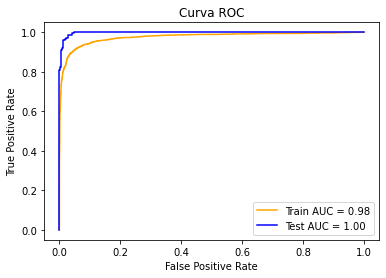

Parcelas con acierto:  35 de 35   100.00%
Test ROC AUC: 0.9978231292517007
Exito min:  0.5906756509903553 
Exito max:  0.992100956042401 
Exito promedio:  0.9299579055722422
Exito * accuracy =  0.9060447022860989
Exito * accuracy / (Exito + accuracy) =  0.4758029344762534
              precision    recall  f1-score   support

           0       0.99      0.99      0.99       525
           1       0.96      0.98      0.97       175

    accuracy                           0.99       700
   macro avg       0.98      0.98      0.98       700
weighted avg       0.99      0.99      0.99       700



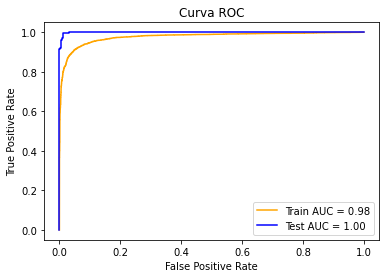

Parcelas con acierto:  35 de 35   100.00%
Test ROC AUC: 0.9992054421768708
Exito min:  0.6197778386580336 
Exito max:  0.9935947965805236 
Exito promedio:  0.94401275619152
Exito * accuracy =  0.9305268596744983
Exito * accuracy / (Exito + accuracy) =  0.48220646727088745
              precision    recall  f1-score   support

           0       0.89      0.90      0.89       525
           1       0.69      0.65      0.67       175

    accuracy                           0.84       700
   macro avg       0.79      0.78      0.78       700
weighted avg       0.84      0.84      0.84       700



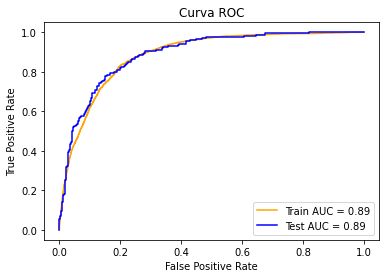

Parcelas con acierto:  34 de 35   97.14%
Test ROC AUC: 0.8907102040816327
Exito min:  0.2581550571286251 
Exito max:  0.9965717648965622 
Exito promedio:  0.7829582109295756
Exito * accuracy =  0.6565663854509441
Exito * accuracy / (Exito + accuracy) =  0.4049055715398396
              precision    recall  f1-score   support

           0       0.98      1.00      0.99       525
           1       1.00      0.93      0.96       175

    accuracy                           0.98       700
   macro avg       0.99      0.97      0.98       700
weighted avg       0.98      0.98      0.98       700



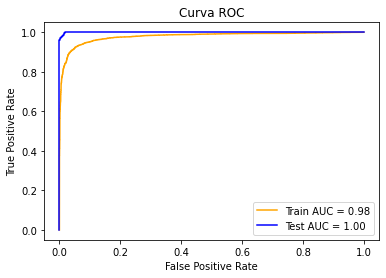

Parcelas con acierto:  35 de 35   100.00%
Test ROC AUC: 0.999629931972789
Exito min:  0.599668866439155 
Exito max:  0.9935202282088856 
Exito promedio:  0.9016595637440754
Exito * accuracy =  0.8862025426513198
Exito * accuracy / (Exito + accuracy) =  0.4702545430067385
              precision    recall  f1-score   support

           0       0.97      0.99      0.98       525
           1       0.97      0.91      0.94       175

    accuracy                           0.97       700
   macro avg       0.97      0.95      0.96       700
weighted avg       0.97      0.97      0.97       700



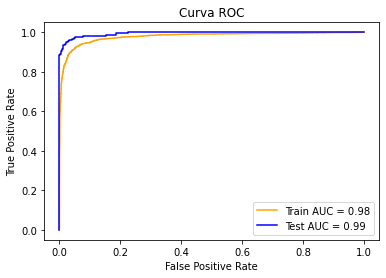

Parcelas con acierto:  35 de 35   100.00%
Test ROC AUC: 0.9944925170068027
Exito min:  0.47547879534136783 
Exito max:  0.9916433307390904 
Exito promedio:  0.881642510682117
Exito * accuracy =  0.8551932353616535
Exito * accuracy / (Exito + accuracy) =  0.4618565573149502
              precision    recall  f1-score   support

           0       0.82      0.90      0.86       525
           1       0.58      0.40      0.47       175

    accuracy                           0.78       700
   macro avg       0.70      0.65      0.67       700
weighted avg       0.76      0.78      0.76       700



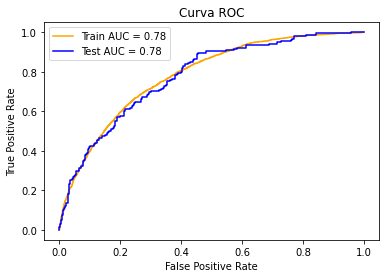

Parcelas con acierto:  23 de 35   65.71%
Test ROC AUC: 0.777491156462585
Exito min:  0.06736212637312924 
Exito max:  0.9642273345625688 
Exito promedio:  0.6140944847519674
Exito * accuracy =  0.4781164202711746
Exito * accuracy / (Exito + accuracy) =  0.3433102050514174
              precision    recall  f1-score   support

           0       0.97      0.95      0.96       510
           1       0.87      0.91      0.89       170

    accuracy                           0.94       680
   macro avg       0.92      0.93      0.92       680
weighted avg       0.94      0.94      0.94       680



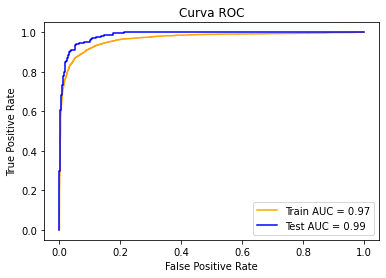

Parcelas con acierto:  34 de 34   100.00%
Test ROC AUC: 0.9862745098039215
Exito min:  0.3953913950388306 
Exito max:  0.9921230520952973 
Exito promedio:  0.8837529624187813
Exito * accuracy =  0.8330671307506453
Exito * accuracy / (Exito + accuracy) =  0.4561252305417715
              precision    recall  f1-score   support

           0       0.97      0.98      0.98       510
           1       0.95      0.92      0.93       170

    accuracy                           0.97       680
   macro avg       0.96      0.95      0.96       680
weighted avg       0.97      0.97      0.97       680



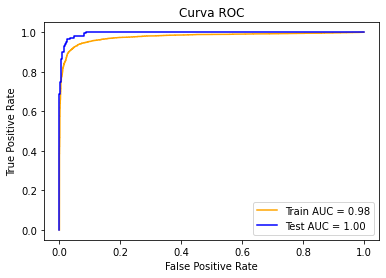

Parcelas con acierto:  34 de 34   100.00%
Test ROC AUC: 0.9956632064590542
Exito min:  0.6051655404087005 
Exito max:  0.9957613031993989 
Exito promedio:  0.9018738134326073
Exito * accuracy =  0.872695542998023
Exito * accuracy / (Exito + accuracy) =  0.4668017115769638
              precision    recall  f1-score   support

           0       0.94      0.96      0.95       510
           1       0.89      0.83      0.86       170

    accuracy                           0.93       680
   macro avg       0.92      0.90      0.91       680
weighted avg       0.93      0.93      0.93       680



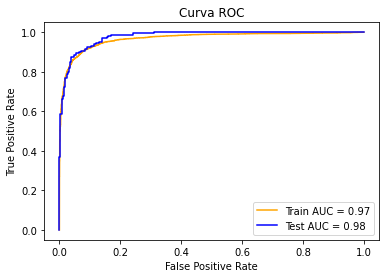

Parcelas con acierto:  33 de 34   97.06%
Test ROC AUC: 0.9785351787773933
Exito min:  0.38444931431892415 
Exito max:  0.9943314322799918 
Exito promedio:  0.8294619886004447
Exito * accuracy =  0.7721315276236493
Exito * accuracy / (Exito + accuracy) =  0.4386252788175837
              precision    recall  f1-score   support

           0       0.87      0.91      0.89       510
           1       0.69      0.60      0.64       170

    accuracy                           0.83       680
   macro avg       0.78      0.75      0.77       680
weighted avg       0.83      0.83      0.83       680



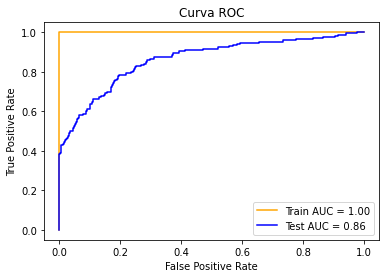

Parcelas con acierto:  27 de 34   79.41%
Test ROC AUC: 0.8629181084198384
Exito min:  0.12919214092131162 
Exito max:  0.9929965814629089 
Exito promedio:  0.7375664985298988
Exito * accuracy =  0.6139156443645922
Exito * accuracy / (Exito + accuracy) =  0.39104913847007094


In [13]:
carpeta = "Optuna-LGBM-20230214"
num_trial_best = obtenerParametrosOptimosLGBM(carpeta = carpeta, n_splits = 10, random_state = 33, normalizacion=[0,1], n_trials=10)

# carga el mejor modelo
best_model_file = os.path.join(carpeta, f"model_trial_{num_trial_best}.joblib")
params, score, best_model = joblib.load(best_model_file)

probarMejorModelo(best_model, umbral=0.6)

[I 2023-03-05 11:34:26,537] A new study created in memory with name: no-name-e768a76f-280a-4087-9a57-3610326eed21


[LightGBM] [Warning] feature_fraction is set=0.5374850718425042, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5374850718425042
[LightGBM] [Warning] lambda_l1 is set=0.011372264854238761, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.011372264854238761
[LightGBM] [Warning] bagging_fraction is set=0.43095927418118174, subsample=1.0 will be ignored. Current value: bagging_fraction=0.43095927418118174
[LightGBM] [Warning] lambda_l2 is set=2.5605134331547634, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.5605134331547634
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7
[LightGBM] [Warning] feature_fraction is set=0.5374850718425042, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5374850718425042
[LightGBM] [Warning] lambda_l1 is set=0.011372264854238761, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.011372264854238761
[LightGBM] [Warning] baggin

[I 2023-03-05 11:34:30,779] Trial 0 finished with value: 0.843134693877551 and parameters: {'lambda_l1': 0.011372264854238761, 'lambda_l2': 2.5605134331547634, 'num_leaves': 168, 'feature_fraction': 0.5374850718425042, 'bagging_fraction': 0.43095927418118174, 'bagging_freq': 7, 'min_child_samples': 42}. Best is trial 0 with value: 0.843134693877551.


[LightGBM] [Warning] feature_fraction is set=0.10200829605435541, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.10200829605435541
[LightGBM] [Warning] lambda_l1 is set=1.8138484622201126e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.8138484622201126e-07
[LightGBM] [Warning] bagging_fraction is set=0.9304427260472886, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9304427260472886
[LightGBM] [Warning] lambda_l2 is set=1.3605324382124868e-06, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.3605324382124868e-06
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] feature_fraction is set=0.10200829605435541, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.10200829605435541
[LightGBM] [Warning] lambda_l1 is set=1.8138484622201126e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.8138484622201126e-07
[LightGBM

[I 2023-03-05 11:34:33,757] Trial 1 finished with value: 0.7972462585034014 and parameters: {'lambda_l1': 1.8138484622201126e-07, 'lambda_l2': 1.3605324382124868e-06, 'num_leaves': 33, 'feature_fraction': 0.10200829605435541, 'bagging_fraction': 0.9304427260472886, 'bagging_freq': 2, 'min_child_samples': 58}. Best is trial 0 with value: 0.843134693877551.


[LightGBM] [Warning] feature_fraction is set=0.758502522192461, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.758502522192461
[LightGBM] [Warning] lambda_l1 is set=0.2653068853600451, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.2653068853600451
[LightGBM] [Warning] bagging_fraction is set=0.347015482215492, subsample=1.0 will be ignored. Current value: bagging_fraction=0.347015482215492
[LightGBM] [Warning] lambda_l2 is set=9.637717804022988e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=9.637717804022988e-07
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] feature_fraction is set=0.758502522192461, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.758502522192461
[LightGBM] [Warning] lambda_l1 is set=0.2653068853600451, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.2653068853600451
[LightGBM] [Warning] bagging_fraction

[I 2023-03-05 11:34:36,651] Trial 2 finished with value: 0.8085006802721089 and parameters: {'lambda_l1': 0.2653068853600451, 'lambda_l2': 9.637717804022988e-07, 'num_leaves': 37, 'feature_fraction': 0.758502522192461, 'bagging_fraction': 0.347015482215492, 'bagging_freq': 3, 'min_child_samples': 77}. Best is trial 0 with value: 0.843134693877551.


[LightGBM] [Warning] feature_fraction is set=0.758502522192461, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.758502522192461
[LightGBM] [Warning] lambda_l1 is set=0.2653068853600451, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.2653068853600451
[LightGBM] [Warning] bagging_fraction is set=0.347015482215492, subsample=1.0 will be ignored. Current value: bagging_fraction=0.347015482215492
[LightGBM] [Warning] lambda_l2 is set=9.637717804022988e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=9.637717804022988e-07
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] feature_fraction is set=0.11453406377019082, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.11453406377019082
[LightGBM] [Warning] lambda_l1 is set=0.0015027428937021896, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.0015027428937021896
[LightGBM] [Warning] baggin

[I 2023-03-05 11:34:41,424] Trial 3 finished with value: 0.7934258503401361 and parameters: {'lambda_l1': 0.0015027428937021896, 'lambda_l2': 3.706972863598556e-05, 'num_leaves': 98, 'feature_fraction': 0.11453406377019082, 'bagging_fraction': 0.7520418580696352, 'bagging_freq': 7, 'min_child_samples': 52}. Best is trial 0 with value: 0.843134693877551.


[LightGBM] [Warning] feature_fraction is set=0.5306056725661671, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5306056725661671
[LightGBM] [Warning] lambda_l1 is set=3.9146281761060455e-06, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.9146281761060455e-06
[LightGBM] [Warning] bagging_fraction is set=0.25156174565002265, subsample=1.0 will be ignored. Current value: bagging_fraction=0.25156174565002265
[LightGBM] [Warning] lambda_l2 is set=0.0006030330066475363, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0006030330066475363
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.5306056725661671, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5306056725661671
[LightGBM] [Warning] lambda_l1 is set=3.9146281761060455e-06, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.9146281761060455e-06
[LightGBM] [W

[I 2023-03-05 11:34:43,691] Trial 4 finished with value: 0.7613264129181083 and parameters: {'lambda_l1': 3.9146281761060455e-06, 'lambda_l2': 0.0006030330066475363, 'num_leaves': 214, 'feature_fraction': 0.5306056725661671, 'bagging_fraction': 0.25156174565002265, 'bagging_freq': 1, 'min_child_samples': 90}. Best is trial 0 with value: 0.843134693877551.


[LightGBM] [Warning] feature_fraction is set=0.5306056725661671, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5306056725661671
[LightGBM] [Warning] lambda_l1 is set=3.9146281761060455e-06, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.9146281761060455e-06
[LightGBM] [Warning] bagging_fraction is set=0.25156174565002265, subsample=1.0 will be ignored. Current value: bagging_fraction=0.25156174565002265
[LightGBM] [Warning] lambda_l2 is set=0.0006030330066475363, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0006030330066475363
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.6727853568062724, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6727853568062724
[LightGBM] [Warning] lambda_l1 is set=1.45519234758746e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.45519234758746e-07
[LightGBM] [Warni

[I 2023-03-05 11:34:46,166] Trial 5 finished with value: 0.8431238095238095 and parameters: {'lambda_l1': 1.45519234758746e-07, 'lambda_l2': 5.255077701098584e-05, 'num_leaves': 19, 'feature_fraction': 0.6727853568062724, 'bagging_fraction': 0.9238394439482043, 'bagging_freq': 7, 'min_child_samples': 45}. Best is trial 0 with value: 0.843134693877551.


[LightGBM] [Warning] feature_fraction is set=0.6727853568062724, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6727853568062724
[LightGBM] [Warning] lambda_l1 is set=1.45519234758746e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.45519234758746e-07
[LightGBM] [Warning] bagging_fraction is set=0.9238394439482043, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9238394439482043
[LightGBM] [Warning] lambda_l2 is set=5.255077701098584e-05, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5.255077701098584e-05
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7
[LightGBM] [Warning] feature_fraction is set=0.4906275929534851, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4906275929534851
[LightGBM] [Warning] lambda_l1 is set=2.878874858800844, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.878874858800844
[LightGBM] [Warning] bagging_

[I 2023-03-05 11:34:54,521] Trial 6 finished with value: 0.8644789115646259 and parameters: {'lambda_l1': 2.878874858800844, 'lambda_l2': 1.0188748757554608e-05, 'num_leaves': 155, 'feature_fraction': 0.4906275929534851, 'bagging_fraction': 0.7660374618923942, 'bagging_freq': 10, 'min_child_samples': 8}. Best is trial 6 with value: 0.8644789115646259.


[LightGBM] [Warning] feature_fraction is set=0.5675330746200018, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5675330746200018
[LightGBM] [Warning] lambda_l1 is set=3.1687536940786934e-05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.1687536940786934e-05
[LightGBM] [Warning] bagging_fraction is set=0.6464210959189242, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6464210959189242
[LightGBM] [Warning] lambda_l2 is set=5.919082808811183, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5.919082808811183
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=0.5675330746200018, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5675330746200018
[LightGBM] [Warning] lambda_l1 is set=3.1687536940786934e-05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.1687536940786934e-05
[LightGBM] [Warning] ba

[I 2023-03-05 11:34:58,640] Trial 7 finished with value: 0.8376124567474048 and parameters: {'lambda_l1': 3.1687536940786934e-05, 'lambda_l2': 5.919082808811183, 'num_leaves': 59, 'feature_fraction': 0.5675330746200018, 'bagging_fraction': 0.6464210959189242, 'bagging_freq': 5, 'min_child_samples': 78}. Best is trial 6 with value: 0.8644789115646259.


[LightGBM] [Warning] feature_fraction is set=0.8695866235080228, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8695866235080228
[LightGBM] [Warning] lambda_l1 is set=0.009469132456473602, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.009469132456473602
[LightGBM] [Warning] bagging_fraction is set=0.17209997263726584, subsample=1.0 will be ignored. Current value: bagging_fraction=0.17209997263726584
[LightGBM] [Warning] lambda_l2 is set=6.535124787351865e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=6.535124787351865e-07
[LightGBM] [Warning] bagging_freq is set=8, subsample_freq=0 will be ignored. Current value: bagging_freq=8
[LightGBM] [Warning] feature_fraction is set=0.8695866235080228, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8695866235080228
[LightGBM] [Warning] lambda_l1 is set=0.009469132456473602, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.009469132456473602
[LightGBM] [Warning] 

[I 2023-03-05 11:35:02,427] Trial 8 finished with value: 0.8149224489795919 and parameters: {'lambda_l1': 0.009469132456473602, 'lambda_l2': 6.535124787351865e-07, 'num_leaves': 42, 'feature_fraction': 0.8695866235080228, 'bagging_fraction': 0.17209997263726584, 'bagging_freq': 8, 'min_child_samples': 26}. Best is trial 6 with value: 0.8644789115646259.


[LightGBM] [Warning] feature_fraction is set=0.5715261375960339, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5715261375960339
[LightGBM] [Warning] lambda_l1 is set=1.8516907084314342e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.8516907084314342e-07
[LightGBM] [Warning] bagging_fraction is set=0.15787034591769541, subsample=1.0 will be ignored. Current value: bagging_fraction=0.15787034591769541
[LightGBM] [Warning] lambda_l2 is set=0.01203224381341433, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.01203224381341433
[LightGBM] [Warning] bagging_freq is set=10, subsample_freq=0 will be ignored. Current value: bagging_freq=10
[LightGBM] [Warning] feature_fraction is set=0.5715261375960339, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5715261375960339
[LightGBM] [Warning] lambda_l1 is set=1.8516907084314342e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.8516907084314342e-07
[LightGBM] [War

[I 2023-03-05 11:35:04,755] Trial 9 finished with value: 0.7710585034013606 and parameters: {'lambda_l1': 1.8516907084314342e-07, 'lambda_l2': 0.01203224381341433, 'num_leaves': 86, 'feature_fraction': 0.5715261375960339, 'bagging_fraction': 0.15787034591769541, 'bagging_freq': 10, 'min_child_samples': 62}. Best is trial 6 with value: 0.8644789115646259.


[LightGBM] [Warning] feature_fraction is set=0.5715261375960339, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5715261375960339
[LightGBM] [Warning] lambda_l1 is set=1.8516907084314342e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.8516907084314342e-07
[LightGBM] [Warning] bagging_fraction is set=0.15787034591769541, subsample=1.0 will be ignored. Current value: bagging_fraction=0.15787034591769541
[LightGBM] [Warning] lambda_l2 is set=0.01203224381341433, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.01203224381341433
[LightGBM] [Warning] bagging_freq is set=10, subsample_freq=0 will be ignored. Current value: bagging_freq=10
[LightGBM] [Warning] feature_fraction is set=0.32928572870858885, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.32928572870858885
[LightGBM] [Warning] lambda_l1 is set=9.489593551692764, reg_alpha=0.0 will be ignored. Current value: lambda_l1=9.489593551692764
[LightGBM] [Warning] ba

[I 2023-03-05 11:35:08,630] Trial 10 finished with value: 0.8094693877551019 and parameters: {'lambda_l1': 9.489593551692764, 'lambda_l2': 1.385092770062633e-07, 'num_leaves': 249, 'feature_fraction': 0.32928572870858885, 'bagging_fraction': 0.5635894780705671, 'bagging_freq': 10, 'min_child_samples': 8}. Best is trial 6 with value: 0.8644789115646259.


[LightGBM] [Warning] feature_fraction is set=0.4267785633442249, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4267785633442249
[LightGBM] [Warning] lambda_l1 is set=0.04558526589275762, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.04558526589275762
[LightGBM] [Warning] bagging_fraction is set=0.4551824541183904, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4551824541183904
[LightGBM] [Warning] lambda_l2 is set=3.8895001668548055, reg_lambda=0.0 will be ignored. Current value: lambda_l2=3.8895001668548055
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=0.4267785633442249, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4267785633442249
[LightGBM] [Warning] lambda_l1 is set=0.04558526589275762, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.04558526589275762
[LightGBM] [Warning] bagging_frac

[I 2023-03-05 11:35:18,251] Trial 11 finished with value: 0.867025850340136 and parameters: {'lambda_l1': 0.04558526589275762, 'lambda_l2': 3.8895001668548055, 'num_leaves': 161, 'feature_fraction': 0.4267785633442249, 'bagging_fraction': 0.4551824541183904, 'bagging_freq': 5, 'min_child_samples': 6}. Best is trial 11 with value: 0.867025850340136.


[LightGBM] [Warning] feature_fraction is set=0.3796025833502824, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.3796025833502824
[LightGBM] [Warning] lambda_l1 is set=1.4593125301046412, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.4593125301046412
[LightGBM] [Warning] bagging_fraction is set=0.47372205813048407, subsample=1.0 will be ignored. Current value: bagging_fraction=0.47372205813048407
[LightGBM] [Warning] lambda_l2 is set=0.09160626210716065, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.09160626210716065
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] feature_fraction is set=0.3796025833502824, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.3796025833502824
[LightGBM] [Warning] lambda_l1 is set=1.4593125301046412, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.4593125301046412
[LightGBM] [Warning] bagging_frac

[I 2023-03-05 11:35:27,051] Trial 12 finished with value: 0.8540843537414966 and parameters: {'lambda_l1': 1.4593125301046412, 'lambda_l2': 0.09160626210716065, 'num_leaves': 156, 'feature_fraction': 0.3796025833502824, 'bagging_fraction': 0.47372205813048407, 'bagging_freq': 4, 'min_child_samples': 9}. Best is trial 11 with value: 0.867025850340136.


[LightGBM] [Warning] feature_fraction is set=0.3791776593770614, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.3791776593770614
[LightGBM] [Warning] lambda_l1 is set=0.1520456495816107, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.1520456495816107
[LightGBM] [Warning] bagging_fraction is set=0.729335827337826, subsample=1.0 will be ignored. Current value: bagging_fraction=0.729335827337826
[LightGBM] [Warning] lambda_l2 is set=3.1008993058862554e-08, reg_lambda=0.0 will be ignored. Current value: lambda_l2=3.1008993058862554e-08
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=0.3791776593770614, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.3791776593770614
[LightGBM] [Warning] lambda_l1 is set=0.1520456495816107, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.1520456495816107
[LightGBM] [Warning] bagging_fr

[I 2023-03-05 11:35:36,149] Trial 13 finished with value: 0.8827537414965986 and parameters: {'lambda_l1': 0.1520456495816107, 'lambda_l2': 3.1008993058862554e-08, 'num_leaves': 150, 'feature_fraction': 0.3791776593770614, 'bagging_fraction': 0.729335827337826, 'bagging_freq': 5, 'min_child_samples': 25}. Best is trial 13 with value: 0.8827537414965986.


[LightGBM] [Warning] feature_fraction is set=0.3635646640343983, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.3635646640343983
[LightGBM] [Warning] lambda_l1 is set=0.07684391985677325, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.07684391985677325
[LightGBM] [Warning] bagging_fraction is set=0.6292163647599087, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6292163647599087
[LightGBM] [Warning] lambda_l2 is set=1.0189337662063917e-08, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.0189337662063917e-08
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=0.3635646640343983, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.3635646640343983
[LightGBM] [Warning] lambda_l1 is set=0.07684391985677325, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.07684391985677325
[LightGBM] [Warning] bagg

[I 2023-03-05 11:35:45,352] Trial 14 finished with value: 0.873687074829932 and parameters: {'lambda_l1': 0.07684391985677325, 'lambda_l2': 1.0189337662063917e-08, 'num_leaves': 199, 'feature_fraction': 0.3635646640343983, 'bagging_fraction': 0.6292163647599087, 'bagging_freq': 5, 'min_child_samples': 26}. Best is trial 13 with value: 0.8827537414965986.


[LightGBM] [Warning] feature_fraction is set=0.28558008147540465, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.28558008147540465
[LightGBM] [Warning] lambda_l1 is set=0.11583398459205344, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.11583398459205344
[LightGBM] [Warning] bagging_fraction is set=0.6586023201143574, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6586023201143574
[LightGBM] [Warning] lambda_l2 is set=1.4876148665280491e-08, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.4876148665280491e-08
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] feature_fraction is set=0.28558008147540465, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.28558008147540465
[LightGBM] [Warning] lambda_l1 is set=0.11583398459205344, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.11583398459205344
[LightGBM] [Warning] 

[I 2023-03-05 11:35:53,814] Trial 15 finished with value: 0.8379319727891156 and parameters: {'lambda_l1': 0.11583398459205344, 'lambda_l2': 1.4876148665280491e-08, 'num_leaves': 201, 'feature_fraction': 0.28558008147540465, 'bagging_fraction': 0.6586023201143574, 'bagging_freq': 4, 'min_child_samples': 28}. Best is trial 13 with value: 0.8827537414965986.


[LightGBM] [Warning] feature_fraction is set=0.26916222449435706, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.26916222449435706
[LightGBM] [Warning] lambda_l1 is set=0.0018950419564481402, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.0018950419564481402
[LightGBM] [Warning] bagging_fraction is set=0.8080241371176777, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8080241371176777
[LightGBM] [Warning] lambda_l2 is set=1.1404541792491403e-08, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.1404541792491403e-08
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] feature_fraction is set=0.26916222449435706, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.26916222449435706
[LightGBM] [Warning] lambda_l1 is set=0.0018950419564481402, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.0018950419564481402
[LightGBM] [W

[I 2023-03-05 11:36:01,284] Trial 16 finished with value: 0.851374149659864 and parameters: {'lambda_l1': 0.0018950419564481402, 'lambda_l2': 1.1404541792491403e-08, 'num_leaves': 127, 'feature_fraction': 0.26916222449435706, 'bagging_fraction': 0.8080241371176777, 'bagging_freq': 6, 'min_child_samples': 28}. Best is trial 13 with value: 0.8827537414965986.


[LightGBM] [Warning] feature_fraction is set=0.4162040665847912, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4162040665847912
[LightGBM] [Warning] lambda_l1 is set=0.22857608650960606, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.22857608650960606
[LightGBM] [Warning] bagging_fraction is set=0.6350099342033343, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6350099342033343
[LightGBM] [Warning] lambda_l2 is set=6.99534397665942e-08, reg_lambda=0.0 will be ignored. Current value: lambda_l2=6.99534397665942e-08
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] feature_fraction is set=0.4162040665847912, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4162040665847912
[LightGBM] [Warning] lambda_l1 is set=0.22857608650960606, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.22857608650960606
[LightGBM] [Warning] bagging_

[I 2023-03-05 11:36:12,417] Trial 17 finished with value: 0.8810448979591836 and parameters: {'lambda_l1': 0.22857608650960606, 'lambda_l2': 6.99534397665942e-08, 'num_leaves': 204, 'feature_fraction': 0.4162040665847912, 'bagging_fraction': 0.6350099342033343, 'bagging_freq': 3, 'min_child_samples': 21}. Best is trial 13 with value: 0.8827537414965986.


[LightGBM] [Warning] feature_fraction is set=0.4461172619511597, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4461172619511597
[LightGBM] [Warning] lambda_l1 is set=1.0498369334352835, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.0498369334352835
[LightGBM] [Warning] bagging_fraction is set=0.9971118747792336, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9971118747792336
[LightGBM] [Warning] lambda_l2 is set=1.0868173064865363e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.0868173064865363e-07
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] feature_fraction is set=0.4461172619511597, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4461172619511597
[LightGBM] [Warning] lambda_l1 is set=1.0498369334352835, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.0498369334352835
[LightGBM] [Warning] bagging_

[I 2023-03-05 11:36:26,219] Trial 18 finished with value: 0.891178231292517 and parameters: {'lambda_l1': 1.0498369334352835, 'lambda_l2': 1.0868173064865363e-07, 'num_leaves': 253, 'feature_fraction': 0.4461172619511597, 'bagging_fraction': 0.9971118747792336, 'bagging_freq': 3, 'min_child_samples': 19}. Best is trial 18 with value: 0.891178231292517.


[LightGBM] [Warning] feature_fraction is set=0.96013899928937, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.96013899928937
[LightGBM] [Warning] lambda_l1 is set=1.0713579903214825, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.0713579903214825
[LightGBM] [Warning] bagging_fraction is set=0.9978447102385276, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9978447102385276
[LightGBM] [Warning] lambda_l2 is set=1.4871654004333113e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.4871654004333113e-07
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.96013899928937, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.96013899928937
[LightGBM] [Warning] lambda_l1 is set=1.0713579903214825, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.0713579903214825
[LightGBM] [Warning] bagging_fraction

[I 2023-03-05 11:36:35,915] Trial 19 finished with value: 0.8803482993197279 and parameters: {'lambda_l1': 1.0713579903214825, 'lambda_l2': 1.4871654004333113e-07, 'num_leaves': 255, 'feature_fraction': 0.96013899928937, 'bagging_fraction': 0.9978447102385276, 'bagging_freq': 1, 'min_child_samples': 39}. Best is trial 18 with value: 0.891178231292517.


[LightGBM] [Warning] feature_fraction is set=0.21577904448173857, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.21577904448173857
[LightGBM] [Warning] lambda_l1 is set=0.0002530946574579886, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.0002530946574579886
[LightGBM] [Warning] bagging_fraction is set=0.8461435279056229, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8461435279056229
[LightGBM] [Warning] lambda_l2 is set=5.028138648594375e-06, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5.028138648594375e-06
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] feature_fraction is set=0.21577904448173857, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.21577904448173857
[LightGBM] [Warning] lambda_l1 is set=0.0002530946574579886, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.0002530946574579886
[LightGBM] [War

[I 2023-03-05 11:36:47,530] Trial 20 finished with value: 0.8872380952380953 and parameters: {'lambda_l1': 0.0002530946574579886, 'lambda_l2': 5.028138648594375e-06, 'num_leaves': 230, 'feature_fraction': 0.21577904448173857, 'bagging_fraction': 0.8461435279056229, 'bagging_freq': 3, 'min_child_samples': 16}. Best is trial 18 with value: 0.891178231292517.


[LightGBM] [Warning] feature_fraction is set=0.2300637335073443, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2300637335073443
[LightGBM] [Warning] lambda_l1 is set=0.0004200645236534985, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.0004200645236534985
[LightGBM] [Warning] bagging_fraction is set=0.8441058469911377, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8441058469911377
[LightGBM] [Warning] lambda_l2 is set=3.4941434250786593e-06, reg_lambda=0.0 will be ignored. Current value: lambda_l2=3.4941434250786593e-06
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] feature_fraction is set=0.2300637335073443, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2300637335073443
[LightGBM] [Warning] lambda_l1 is set=0.0004200645236534985, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.0004200645236534985
[LightGBM] [Warni

[I 2023-03-05 11:36:59,164] Trial 21 finished with value: 0.8821986394557824 and parameters: {'lambda_l1': 0.0004200645236534985, 'lambda_l2': 3.4941434250786593e-06, 'num_leaves': 233, 'feature_fraction': 0.2300637335073443, 'bagging_fraction': 0.8441058469911377, 'bagging_freq': 3, 'min_child_samples': 19}. Best is trial 18 with value: 0.891178231292517.


[LightGBM] [Warning] feature_fraction is set=0.20018874746333046, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.20018874746333046
[LightGBM] [Warning] lambda_l1 is set=8.486567827869814e-05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=8.486567827869814e-05
[LightGBM] [Warning] bagging_fraction is set=0.8848841477010321, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8848841477010321
[LightGBM] [Warning] lambda_l2 is set=3.1878737635636796e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=3.1878737635636796e-07
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] feature_fraction is set=0.20018874746333046, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.20018874746333046
[LightGBM] [Warning] lambda_l1 is set=8.486567827869814e-05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=8.486567827869814e-05
[LightGBM] [W

[I 2023-03-05 11:37:10,834] Trial 22 finished with value: 0.8888380952380952 and parameters: {'lambda_l1': 8.486567827869814e-05, 'lambda_l2': 3.1878737635636796e-07, 'num_leaves': 228, 'feature_fraction': 0.20018874746333046, 'bagging_fraction': 0.8848841477010321, 'bagging_freq': 2, 'min_child_samples': 17}. Best is trial 18 with value: 0.891178231292517.


[LightGBM] [Warning] feature_fraction is set=0.1906724418202696, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.1906724418202696
[LightGBM] [Warning] lambda_l1 is set=6.46289463853068e-05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=6.46289463853068e-05
[LightGBM] [Warning] bagging_fraction is set=0.8732239601792068, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8732239601792068
[LightGBM] [Warning] lambda_l2 is set=3.338362154079295e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=3.338362154079295e-07
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] feature_fraction is set=0.1906724418202696, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.1906724418202696
[LightGBM] [Warning] lambda_l1 is set=6.46289463853068e-05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=6.46289463853068e-05
[LightGBM] [Warning] ba

[I 2023-03-05 11:37:23,177] Trial 23 finished with value: 0.8938557823129252 and parameters: {'lambda_l1': 6.46289463853068e-05, 'lambda_l2': 3.338362154079295e-07, 'num_leaves': 227, 'feature_fraction': 0.1906724418202696, 'bagging_fraction': 0.8732239601792068, 'bagging_freq': 2, 'min_child_samples': 15}. Best is trial 23 with value: 0.8938557823129252.


[LightGBM] [Warning] feature_fraction is set=0.1883246495369303, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.1883246495369303
[LightGBM] [Warning] lambda_l1 is set=3.068072292486239e-05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.068072292486239e-05
[LightGBM] [Warning] bagging_fraction is set=0.9815544802763122, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9815544802763122
[LightGBM] [Warning] lambda_l2 is set=3.909506056793036e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=3.909506056793036e-07
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] feature_fraction is set=0.1883246495369303, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.1883246495369303
[LightGBM] [Warning] lambda_l1 is set=3.068072292486239e-05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.068072292486239e-05
[LightGBM] [Warning

[I 2023-03-05 11:37:32,578] Trial 24 finished with value: 0.8786612244897959 and parameters: {'lambda_l1': 3.068072292486239e-05, 'lambda_l2': 3.909506056793036e-07, 'num_leaves': 183, 'feature_fraction': 0.1883246495369303, 'bagging_fraction': 0.9815544802763122, 'bagging_freq': 2, 'min_child_samples': 32}. Best is trial 23 with value: 0.8938557823129252.


[LightGBM] [Warning] feature_fraction is set=0.17255949971325457, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.17255949971325457
[LightGBM] [Warning] lambda_l1 is set=3.0299971148636955e-06, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.0299971148636955e-06
[LightGBM] [Warning] bagging_fraction is set=0.891956510597322, subsample=1.0 will be ignored. Current value: bagging_fraction=0.891956510597322
[LightGBM] [Warning] lambda_l2 is set=1.977403479337314e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.977403479337314e-07
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] feature_fraction is set=0.17255949971325457, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.17255949971325457
[LightGBM] [Warning] lambda_l1 is set=3.0299971148636955e-06, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.0299971148636955e-06
[LightGBM] [W

[I 2023-03-05 11:37:44,274] Trial 25 finished with value: 0.8943020408163266 and parameters: {'lambda_l1': 3.0299971148636955e-06, 'lambda_l2': 1.977403479337314e-07, 'num_leaves': 230, 'feature_fraction': 0.17255949971325457, 'bagging_fraction': 0.891956510597322, 'bagging_freq': 2, 'min_child_samples': 15}. Best is trial 25 with value: 0.8943020408163266.


[LightGBM] [Warning] feature_fraction is set=0.1563916966669788, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.1563916966669788
[LightGBM] [Warning] lambda_l1 is set=2.0351102784778003e-06, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.0351102784778003e-06
[LightGBM] [Warning] bagging_fraction is set=0.8967419220382499, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8967419220382499
[LightGBM] [Warning] lambda_l2 is set=2.0697635519684276e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.0697635519684276e-07
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.1563916966669788, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.1563916966669788
[LightGBM] [Warning] lambda_l1 is set=2.0351102784778003e-06, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.0351102784778003e-06
[LightGBM] [W

[I 2023-03-05 11:37:52,896] Trial 26 finished with value: 0.8674503401360544 and parameters: {'lambda_l1': 2.0351102784778003e-06, 'lambda_l2': 2.0697635519684276e-07, 'num_leaves': 256, 'feature_fraction': 0.1563916966669788, 'bagging_fraction': 0.8967419220382499, 'bagging_freq': 1, 'min_child_samples': 36}. Best is trial 25 with value: 0.8943020408163266.


[LightGBM] [Warning] feature_fraction is set=0.2891464260817504, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2891464260817504
[LightGBM] [Warning] lambda_l1 is set=4.583430846224704e-06, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.583430846224704e-06
[LightGBM] [Warning] bagging_fraction is set=0.9938503760773615, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9938503760773615
[LightGBM] [Warning] lambda_l2 is set=5.983553176317629e-08, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5.983553176317629e-08
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] feature_fraction is set=0.2891464260817504, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2891464260817504
[LightGBM] [Warning] lambda_l1 is set=4.583430846224704e-06, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.583430846224704e-06
[LightGBM] [Warning

[I 2023-03-05 11:38:05,624] Trial 27 finished with value: 0.8729142857142858 and parameters: {'lambda_l1': 4.583430846224704e-06, 'lambda_l2': 5.983553176317629e-08, 'num_leaves': 226, 'feature_fraction': 0.2891464260817504, 'bagging_fraction': 0.9938503760773615, 'bagging_freq': 2, 'min_child_samples': 14}. Best is trial 25 with value: 0.8943020408163266.


[LightGBM] [Warning] feature_fraction is set=0.25559859860369766, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.25559859860369766
[LightGBM] [Warning] lambda_l1 is set=4.143725008833567e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.143725008833567e-08
[LightGBM] [Warning] bagging_fraction is set=0.8199707469077191, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8199707469077191
[LightGBM] [Warning] lambda_l2 is set=4.4922713581793436e-08, reg_lambda=0.0 will be ignored. Current value: lambda_l2=4.4922713581793436e-08
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] feature_fraction is set=0.25559859860369766, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.25559859860369766
[LightGBM] [Warning] lambda_l1 is set=4.143725008833567e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.143725008833567e-08
[LightGBM] [W

[I 2023-03-05 11:38:11,951] Trial 28 finished with value: 0.8295401360544218 and parameters: {'lambda_l1': 4.143725008833567e-08, 'lambda_l2': 4.4922713581793436e-08, 'num_leaves': 178, 'feature_fraction': 0.25559859860369766, 'bagging_fraction': 0.8199707469077191, 'bagging_freq': 4, 'min_child_samples': 50}. Best is trial 25 with value: 0.8943020408163266.


[LightGBM] [Warning] feature_fraction is set=0.14873730358962872, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.14873730358962872
[LightGBM] [Warning] lambda_l1 is set=0.012273043848541613, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.012273043848541613
[LightGBM] [Warning] bagging_fraction is set=0.9394924154756954, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9394924154756954
[LightGBM] [Warning] lambda_l2 is set=1.381983112213597e-05, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.381983112213597e-05
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.14873730358962872, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.14873730358962872
[LightGBM] [Warning] lambda_l1 is set=0.012273043848541613, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.012273043848541613
[LightGBM] [Warning

[I 2023-03-05 11:38:18,012] Trial 29 finished with value: 0.8189387755102042 and parameters: {'lambda_l1': 0.012273043848541613, 'lambda_l2': 1.381983112213597e-05, 'num_leaves': 188, 'feature_fraction': 0.14873730358962872, 'bagging_fraction': 0.9394924154756954, 'bagging_freq': 1, 'min_child_samples': 44}. Best is trial 25 with value: 0.8943020408163266.


[LightGBM] [Warning] feature_fraction is set=0.31239480353908644, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.31239480353908644
[LightGBM] [Warning] lambda_l1 is set=1.3268830453168147e-05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.3268830453168147e-05
[LightGBM] [Warning] bagging_fraction is set=0.8697115036754564, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8697115036754564
[LightGBM] [Warning] lambda_l2 is set=1.2553368916998196e-06, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.2553368916998196e-06
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] feature_fraction is set=0.31239480353908644, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.31239480353908644
[LightGBM] [Warning] lambda_l1 is set=1.3268830453168147e-05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.3268830453168147e-05
[LightGBM

[I 2023-03-05 11:38:26,087] Trial 30 finished with value: 0.8673850340136056 and parameters: {'lambda_l1': 1.3268830453168147e-05, 'lambda_l2': 1.2553368916998196e-06, 'num_leaves': 134, 'feature_fraction': 0.31239480353908644, 'bagging_fraction': 0.8697115036754564, 'bagging_freq': 2, 'min_child_samples': 15}. Best is trial 25 with value: 0.8943020408163266.


[LightGBM] [Warning] feature_fraction is set=0.20045122650943892, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.20045122650943892
[LightGBM] [Warning] lambda_l1 is set=0.00016670087041183046, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.00016670087041183046
[LightGBM] [Warning] bagging_fraction is set=0.8831279768934878, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8831279768934878
[LightGBM] [Warning] lambda_l2 is set=3.3965369039615693e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=3.3965369039615693e-07
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] feature_fraction is set=0.20045122650943892, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.20045122650943892
[LightGBM] [Warning] lambda_l1 is set=0.00016670087041183046, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.00016670087041183046
[LightGBM

[I 2023-03-05 11:38:36,942] Trial 31 finished with value: 0.8871619047619047 and parameters: {'lambda_l1': 0.00016670087041183046, 'lambda_l2': 3.3965369039615693e-07, 'num_leaves': 234, 'feature_fraction': 0.20045122650943892, 'bagging_fraction': 0.8831279768934878, 'bagging_freq': 2, 'min_child_samples': 20}. Best is trial 25 with value: 0.8943020408163266.


[LightGBM] [Warning] feature_fraction is set=0.15318908692848235, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.15318908692848235
[LightGBM] [Warning] lambda_l1 is set=0.00010494874316054043, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.00010494874316054043
[LightGBM] [Warning] bagging_fraction is set=0.9128841685826103, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9128841685826103
[LightGBM] [Warning] lambda_l2 is set=2.0047541216830073e-06, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.0047541216830073e-06
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] feature_fraction is set=0.15318908692848235, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.15318908692848235
[LightGBM] [Warning] lambda_l1 is set=0.00010494874316054043, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.00010494874316054043
[LightGBM

[I 2023-03-05 11:38:48,345] Trial 32 finished with value: 0.8909278911564626 and parameters: {'lambda_l1': 0.00010494874316054043, 'lambda_l2': 2.0047541216830073e-06, 'num_leaves': 215, 'feature_fraction': 0.15318908692848235, 'bagging_fraction': 0.9128841685826103, 'bagging_freq': 3, 'min_child_samples': 13}. Best is trial 25 with value: 0.8943020408163266.


[LightGBM] [Warning] feature_fraction is set=0.13115424923784275, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.13115424923784275
[LightGBM] [Warning] lambda_l1 is set=0.0008134298180140718, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.0008134298180140718
[LightGBM] [Warning] bagging_fraction is set=0.9150117208786704, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9150117208786704
[LightGBM] [Warning] lambda_l2 is set=3.97820197170517e-06, reg_lambda=0.0 will be ignored. Current value: lambda_l2=3.97820197170517e-06
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] feature_fraction is set=0.13115424923784275, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.13115424923784275
[LightGBM] [Warning] lambda_l1 is set=0.0008134298180140718, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.0008134298180140718
[LightGBM] [Warni

[I 2023-03-05 11:38:59,540] Trial 33 finished with value: 0.8346775510204082 and parameters: {'lambda_l1': 0.0008134298180140718, 'lambda_l2': 3.97820197170517e-06, 'num_leaves': 216, 'feature_fraction': 0.13115424923784275, 'bagging_fraction': 0.9150117208786704, 'bagging_freq': 3, 'min_child_samples': 5}. Best is trial 25 with value: 0.8943020408163266.


[LightGBM] [Warning] feature_fraction is set=0.10593962768908466, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.10593962768908466
[LightGBM] [Warning] lambda_l1 is set=6.106863470616976e-05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=6.106863470616976e-05
[LightGBM] [Warning] bagging_fraction is set=0.9322960680444267, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9322960680444267
[LightGBM] [Warning] lambda_l2 is set=1.5011016352006102e-06, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.5011016352006102e-06
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] feature_fraction is set=0.10593962768908466, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.10593962768908466
[LightGBM] [Warning] lambda_l1 is set=6.106863470616976e-05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=6.106863470616976e-05
[LightGBM] [W

[I 2023-03-05 11:39:08,832] Trial 34 finished with value: 0.8183945578231293 and parameters: {'lambda_l1': 6.106863470616976e-05, 'lambda_l2': 1.5011016352006102e-06, 'num_leaves': 244, 'feature_fraction': 0.10593962768908466, 'bagging_fraction': 0.9322960680444267, 'bagging_freq': 4, 'min_child_samples': 33}. Best is trial 25 with value: 0.8943020408163266.


[LightGBM] [Warning] feature_fraction is set=0.23768403943540364, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.23768403943540364
[LightGBM] [Warning] lambda_l1 is set=1.1987335746112472e-06, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.1987335746112472e-06
[LightGBM] [Warning] bagging_fraction is set=0.7861450613060701, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7861450613060701
[LightGBM] [Warning] lambda_l2 is set=1.2136771055497659e-06, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.2136771055497659e-06
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] feature_fraction is set=0.23768403943540364, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.23768403943540364
[LightGBM] [Warning] lambda_l1 is set=1.1987335746112472e-06, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.1987335746112472e-06
[LightGBM

[I 2023-03-05 11:39:13,678] Trial 35 finished with value: 0.8565768707482992 and parameters: {'lambda_l1': 1.1987335746112472e-06, 'lambda_l2': 1.2136771055497659e-06, 'num_leaves': 218, 'feature_fraction': 0.23768403943540364, 'bagging_fraction': 0.7861450613060701, 'bagging_freq': 3, 'min_child_samples': 65}. Best is trial 25 with value: 0.8943020408163266.


[LightGBM] [Warning] feature_fraction is set=0.15521287551624738, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.15521287551624738
[LightGBM] [Warning] lambda_l1 is set=1.1558049705721613e-05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.1558049705721613e-05
[LightGBM] [Warning] bagging_fraction is set=0.9569822802196574, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9569822802196574
[LightGBM] [Warning] lambda_l2 is set=1.4108893920478018e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.4108893920478018e-07
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] feature_fraction is set=0.15521287551624738, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.15521287551624738
[LightGBM] [Warning] lambda_l1 is set=1.1558049705721613e-05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.1558049705721613e-05
[LightGBM

[I 2023-03-05 11:39:25,072] Trial 36 finished with value: 0.8936489795918368 and parameters: {'lambda_l1': 1.1558049705721613e-05, 'lambda_l2': 1.4108893920478018e-07, 'num_leaves': 239, 'feature_fraction': 0.15521287551624738, 'bagging_fraction': 0.9569822802196574, 'bagging_freq': 2, 'min_child_samples': 13}. Best is trial 25 with value: 0.8943020408163266.


[LightGBM] [Warning] feature_fraction is set=0.11580793503570282, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.11580793503570282
[LightGBM] [Warning] lambda_l1 is set=1.2380283200384149e-05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.2380283200384149e-05
[LightGBM] [Warning] bagging_fraction is set=0.9674391696532572, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9674391696532572
[LightGBM] [Warning] lambda_l2 is set=7.65654974694117e-08, reg_lambda=0.0 will be ignored. Current value: lambda_l2=7.65654974694117e-08
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.11580793503570282, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.11580793503570282
[LightGBM] [Warning] lambda_l1 is set=1.2380283200384149e-05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.2380283200384149e-05
[LightGBM] [W

[I 2023-03-05 11:39:29,309] Trial 37 finished with value: 0.7819210884353742 and parameters: {'lambda_l1': 1.2380283200384149e-05, 'lambda_l2': 7.65654974694117e-08, 'num_leaves': 238, 'feature_fraction': 0.11580793503570282, 'bagging_fraction': 0.9674391696532572, 'bagging_freq': 1, 'min_child_samples': 98}. Best is trial 25 with value: 0.8943020408163266.


[LightGBM] [Warning] feature_fraction is set=0.17895679336630932, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.17895679336630932
[LightGBM] [Warning] lambda_l1 is set=1.0939992784919423e-06, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.0939992784919423e-06
[LightGBM] [Warning] bagging_fraction is set=0.9540692700297275, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9540692700297275
[LightGBM] [Warning] lambda_l2 is set=4.960668707536094e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=4.960668707536094e-07
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.17895679336630932, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.17895679336630932
[LightGBM] [Warning] lambda_l1 is set=1.0939992784919423e-06, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.0939992784919423e-06
[LightGBM] 

[I 2023-03-05 11:39:37,902] Trial 38 finished with value: 0.8834068027210884 and parameters: {'lambda_l1': 1.0939992784919423e-06, 'lambda_l2': 4.960668707536094e-07, 'num_leaves': 194, 'feature_fraction': 0.17895679336630932, 'bagging_fraction': 0.9540692700297275, 'bagging_freq': 1, 'min_child_samples': 22}. Best is trial 25 with value: 0.8943020408163266.


[LightGBM] [Warning] feature_fraction is set=0.1003292757122744, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.1003292757122744
[LightGBM] [Warning] lambda_l1 is set=0.0028067508259877715, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.0028067508259877715
[LightGBM] [Warning] bagging_fraction is set=0.7361673046184436, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7361673046184436
[LightGBM] [Warning] lambda_l2 is set=2.352559291337497e-08, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.352559291337497e-08
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] feature_fraction is set=0.1003292757122744, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.1003292757122744
[LightGBM] [Warning] lambda_l1 is set=0.0028067508259877715, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.0028067508259877715
[LightGBM] [Warning

[I 2023-03-05 11:39:47,132] Trial 39 finished with value: 0.830160544217687 and parameters: {'lambda_l1': 0.0028067508259877715, 'lambda_l2': 2.352559291337497e-08, 'num_leaves': 176, 'feature_fraction': 0.1003292757122744, 'bagging_fraction': 0.7361673046184436, 'bagging_freq': 2, 'min_child_samples': 11}. Best is trial 25 with value: 0.8943020408163266.


[LightGBM] [Warning] feature_fraction is set=0.2596996957123432, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2596996957123432
[LightGBM] [Warning] lambda_l1 is set=0.0004021691789530007, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.0004021691789530007
[LightGBM] [Warning] bagging_fraction is set=0.9996269674592371, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9996269674592371
[LightGBM] [Warning] lambda_l2 is set=8.707602886770153e-05, reg_lambda=0.0 will be ignored. Current value: lambda_l2=8.707602886770153e-05
[LightGBM] [Warning] bagging_freq is set=8, subsample_freq=0 will be ignored. Current value: bagging_freq=8
[LightGBM] [Warning] feature_fraction is set=0.2596996957123432, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2596996957123432
[LightGBM] [Warning] lambda_l1 is set=0.0004021691789530007, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.0004021691789530007
[LightGBM] [Warning

[I 2023-03-05 11:39:48,910] Trial 40 finished with value: 0.7745632653061224 and parameters: {'lambda_l1': 0.0004021691789530007, 'lambda_l2': 8.707602886770153e-05, 'num_leaves': 5, 'feature_fraction': 0.2596996957123432, 'bagging_fraction': 0.9996269674592371, 'bagging_freq': 8, 'min_child_samples': 74}. Best is trial 25 with value: 0.8943020408163266.


[LightGBM] [Warning] feature_fraction is set=0.2596996957123432, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2596996957123432
[LightGBM] [Warning] lambda_l1 is set=0.0004021691789530007, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.0004021691789530007
[LightGBM] [Warning] bagging_fraction is set=0.9996269674592371, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9996269674592371
[LightGBM] [Warning] lambda_l2 is set=8.707602886770153e-05, reg_lambda=0.0 will be ignored. Current value: lambda_l2=8.707602886770153e-05
[LightGBM] [Warning] bagging_freq is set=8, subsample_freq=0 will be ignored. Current value: bagging_freq=8
[LightGBM] [Warning] feature_fraction is set=0.1675303745645276, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.1675303745645276
[LightGBM] [Warning] lambda_l1 is set=0.00012151279040644647, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.00012151279040644647
[LightGBM] [Warni

[I 2023-03-05 11:39:59,412] Trial 41 finished with value: 0.8921034013605443 and parameters: {'lambda_l1': 0.00012151279040644647, 'lambda_l2': 1.5039394824078625e-07, 'num_leaves': 220, 'feature_fraction': 0.1675303745645276, 'bagging_fraction': 0.9323111398390607, 'bagging_freq': 2, 'min_child_samples': 12}. Best is trial 25 with value: 0.8943020408163266.


[LightGBM] [Warning] feature_fraction is set=0.16575273231614399, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.16575273231614399
[LightGBM] [Warning] lambda_l1 is set=3.9695348441786694e-05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.9695348441786694e-05
[LightGBM] [Warning] bagging_fraction is set=0.8502397273635123, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8502397273635123
[LightGBM] [Warning] lambda_l2 is set=1.342386688114814e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.342386688114814e-07
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] feature_fraction is set=0.16575273231614399, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.16575273231614399
[LightGBM] [Warning] lambda_l1 is set=3.9695348441786694e-05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.9695348441786694e-05
[LightGBM] 

[I 2023-03-05 11:40:10,903] Trial 42 finished with value: 0.8908843537414965 and parameters: {'lambda_l1': 3.9695348441786694e-05, 'lambda_l2': 1.342386688114814e-07, 'num_leaves': 245, 'feature_fraction': 0.16575273231614399, 'bagging_fraction': 0.8502397273635123, 'bagging_freq': 2, 'min_child_samples': 13}. Best is trial 25 with value: 0.8943020408163266.


[LightGBM] [Warning] feature_fraction is set=0.22844627292231526, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.22844627292231526
[LightGBM] [Warning] lambda_l1 is set=1.3669672143486301e-05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.3669672143486301e-05
[LightGBM] [Warning] bagging_fraction is set=0.9485613523994187, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9485613523994187
[LightGBM] [Warning] lambda_l2 is set=3.652666210254953e-08, reg_lambda=0.0 will be ignored. Current value: lambda_l2=3.652666210254953e-08
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] feature_fraction is set=0.22844627292231526, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.22844627292231526
[LightGBM] [Warning] lambda_l1 is set=1.3669672143486301e-05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.3669672143486301e-05
[LightGBM] 

[I 2023-03-05 11:40:21,687] Trial 43 finished with value: 0.8934095238095239 and parameters: {'lambda_l1': 1.3669672143486301e-05, 'lambda_l2': 3.652666210254953e-08, 'num_leaves': 211, 'feature_fraction': 0.22844627292231526, 'bagging_fraction': 0.9485613523994187, 'bagging_freq': 2, 'min_child_samples': 5}. Best is trial 25 with value: 0.8943020408163266.


[LightGBM] [Warning] feature_fraction is set=0.2095552088812282, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2095552088812282
[LightGBM] [Warning] lambda_l1 is set=1.1935378892732132e-05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.1935378892732132e-05
[LightGBM] [Warning] bagging_fraction is set=0.9453996712916838, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9453996712916838
[LightGBM] [Warning] lambda_l2 is set=3.128406919064333e-08, reg_lambda=0.0 will be ignored. Current value: lambda_l2=3.128406919064333e-08
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.2095552088812282, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2095552088812282
[LightGBM] [Warning] lambda_l1 is set=1.1935378892732132e-05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.1935378892732132e-05
[LightGBM] [War

[I 2023-03-05 11:40:31,448] Trial 44 finished with value: 0.8846911564625852 and parameters: {'lambda_l1': 1.1935378892732132e-05, 'lambda_l2': 3.128406919064333e-08, 'num_leaves': 208, 'feature_fraction': 0.2095552088812282, 'bagging_fraction': 0.9453996712916838, 'bagging_freq': 1, 'min_child_samples': 5}. Best is trial 25 with value: 0.8943020408163266.


[LightGBM] [Warning] feature_fraction is set=0.3250068970828455, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.3250068970828455
[LightGBM] [Warning] lambda_l1 is set=4.219828638443996e-06, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.219828638443996e-06
[LightGBM] [Warning] bagging_fraction is set=0.8167630054545256, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8167630054545256
[LightGBM] [Warning] lambda_l2 is set=6.441890805383465e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=6.441890805383465e-07
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] feature_fraction is set=0.3250068970828455, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.3250068970828455
[LightGBM] [Warning] lambda_l1 is set=4.219828638443996e-06, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.219828638443996e-06
[LightGBM] [Warning

[I 2023-03-05 11:40:43,093] Trial 45 finished with value: 0.8726965986394558 and parameters: {'lambda_l1': 4.219828638443996e-06, 'lambda_l2': 6.441890805383465e-07, 'num_leaves': 223, 'feature_fraction': 0.3250068970828455, 'bagging_fraction': 0.8167630054545256, 'bagging_freq': 2, 'min_child_samples': 10}. Best is trial 25 with value: 0.8943020408163266.


[LightGBM] [Warning] feature_fraction is set=0.14656692320476827, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.14656692320476827
[LightGBM] [Warning] lambda_l1 is set=0.0001461139751545921, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.0001461139751545921
[LightGBM] [Warning] bagging_fraction is set=0.894475943126578, subsample=1.0 will be ignored. Current value: bagging_fraction=0.894475943126578
[LightGBM] [Warning] lambda_l2 is set=3.844854776524707e-08, reg_lambda=0.0 will be ignored. Current value: lambda_l2=3.844854776524707e-08
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] feature_fraction is set=0.14656692320476827, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.14656692320476827
[LightGBM] [Warning] lambda_l1 is set=0.0001461139751545921, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.0001461139751545921
[LightGBM] [Warni

[I 2023-03-05 11:40:48,650] Trial 46 finished with value: 0.8260680272108845 and parameters: {'lambda_l1': 0.0001461139751545921, 'lambda_l2': 3.844854776524707e-08, 'num_leaves': 89, 'feature_fraction': 0.14656692320476827, 'bagging_fraction': 0.894475943126578, 'bagging_freq': 2, 'min_child_samples': 10}. Best is trial 25 with value: 0.8943020408163266.


[LightGBM] [Warning] feature_fraction is set=0.24114385688234943, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.24114385688234943
[LightGBM] [Warning] lambda_l1 is set=2.2635281275026717e-05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.2635281275026717e-05
[LightGBM] [Warning] bagging_fraction is set=0.7732176861331557, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7732176861331557
[LightGBM] [Warning] lambda_l2 is set=2.6010873992355146e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.6010873992355146e-07
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] feature_fraction is set=0.24114385688234943, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.24114385688234943
[LightGBM] [Warning] lambda_l1 is set=2.2635281275026717e-05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.2635281275026717e-05
[LightGBM

[I 2023-03-05 11:40:56,556] Trial 47 finished with value: 0.8788897959183674 and parameters: {'lambda_l1': 2.2635281275026717e-05, 'lambda_l2': 2.6010873992355146e-07, 'num_leaves': 168, 'feature_fraction': 0.24114385688234943, 'bagging_fraction': 0.7732176861331557, 'bagging_freq': 4, 'min_child_samples': 31}. Best is trial 25 with value: 0.8943020408163266.


[LightGBM] [Warning] feature_fraction is set=0.17811853157087795, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.17811853157087795
[LightGBM] [Warning] lambda_l1 is set=5.180092912040063e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=5.180092912040063e-07
[LightGBM] [Warning] bagging_fraction is set=0.9442567135294274, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9442567135294274
[LightGBM] [Warning] lambda_l2 is set=1.0539789795746007e-08, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.0539789795746007e-08
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.17811853157087795, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.17811853157087795
[LightGBM] [Warning] lambda_l1 is set=5.180092912040063e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=5.180092912040063e-07
[LightGBM] [W

[I 2023-03-05 11:41:06,536] Trial 48 finished with value: 0.8796625850340135 and parameters: {'lambda_l1': 5.180092912040063e-07, 'lambda_l2': 1.0539789795746007e-08, 'num_leaves': 208, 'feature_fraction': 0.17811853157087795, 'bagging_fraction': 0.9442567135294274, 'bagging_freq': 1, 'min_child_samples': 23}. Best is trial 25 with value: 0.8943020408163266.


[LightGBM] [Warning] feature_fraction is set=0.30180704519297324, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.30180704519297324
[LightGBM] [Warning] lambda_l1 is set=5.966538856444826e-06, reg_alpha=0.0 will be ignored. Current value: lambda_l1=5.966538856444826e-06
[LightGBM] [Warning] bagging_fraction is set=0.8639871174229775, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8639871174229775
[LightGBM] [Warning] lambda_l2 is set=6.882191408808986e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=6.882191408808986e-07
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] feature_fraction is set=0.30180704519297324, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.30180704519297324
[LightGBM] [Warning] lambda_l1 is set=5.966538856444826e-06, reg_alpha=0.0 will be ignored. Current value: lambda_l1=5.966538856444826e-06
[LightGBM] [War

[I 2023-03-05 11:41:13,601] Trial 49 finished with value: 0.8684517006802721 and parameters: {'lambda_l1': 5.966538856444826e-06, 'lambda_l2': 6.882191408808986e-07, 'num_leaves': 112, 'feature_fraction': 0.30180704519297324, 'bagging_fraction': 0.8639871174229775, 'bagging_freq': 3, 'min_child_samples': 5}. Best is trial 25 with value: 0.8943020408163266.


[LightGBM] [Warning] feature_fraction is set=0.34283958019355965, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.34283958019355965
[LightGBM] [Warning] lambda_l1 is set=5.4316126514866935e-05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=5.4316126514866935e-05
[LightGBM] [Warning] bagging_fraction is set=0.9189070234944114, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9189070234944114
[LightGBM] [Warning] lambda_l2 is set=9.155466038511271e-08, reg_lambda=0.0 will be ignored. Current value: lambda_l2=9.155466038511271e-08
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] feature_fraction is set=0.34283958019355965, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.34283958019355965
[LightGBM] [Warning] lambda_l1 is set=5.4316126514866935e-05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=5.4316126514866935e-05
[LightGBM] 

[I 2023-03-05 11:41:23,428] Trial 50 finished with value: 0.8685278911564627 and parameters: {'lambda_l1': 5.4316126514866935e-05, 'lambda_l2': 9.155466038511271e-08, 'num_leaves': 192, 'feature_fraction': 0.34283958019355965, 'bagging_fraction': 0.9189070234944114, 'bagging_freq': 2, 'min_child_samples': 9}. Best is trial 25 with value: 0.8943020408163266.


[LightGBM] [Warning] feature_fraction is set=0.276358944997377, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.276358944997377
[LightGBM] [Warning] lambda_l1 is set=1.2217911952321339e-05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.2217911952321339e-05
[LightGBM] [Warning] bagging_fraction is set=0.9634956714210084, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9634956714210084
[LightGBM] [Warning] lambda_l2 is set=1.436272048504891e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.436272048504891e-07
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] feature_fraction is set=0.276358944997377, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.276358944997377
[LightGBM] [Warning] lambda_l1 is set=1.2217911952321339e-05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.2217911952321339e-05
[LightGBM] [Warning

[I 2023-03-05 11:41:35,203] Trial 51 finished with value: 0.8646748299319728 and parameters: {'lambda_l1': 1.2217911952321339e-05, 'lambda_l2': 1.436272048504891e-07, 'num_leaves': 243, 'feature_fraction': 0.276358944997377, 'bagging_fraction': 0.9634956714210084, 'bagging_freq': 3, 'min_child_samples': 18}. Best is trial 25 with value: 0.8943020408163266.


[LightGBM] [Warning] feature_fraction is set=0.21838145653129493, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.21838145653129493
[LightGBM] [Warning] lambda_l1 is set=8.10747428302587e-05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=8.10747428302587e-05
[LightGBM] [Warning] bagging_fraction is set=0.9665975867647306, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9665975867647306
[LightGBM] [Warning] lambda_l2 is set=2.958739936173719e-08, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.958739936173719e-08
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] feature_fraction is set=0.21838145653129493, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.21838145653129493
[LightGBM] [Warning] lambda_l1 is set=8.10747428302587e-05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=8.10747428302587e-05
[LightGBM] [Warning

[I 2023-03-05 11:41:39,731] Trial 52 finished with value: 0.8832217687074831 and parameters: {'lambda_l1': 8.10747428302587e-05, 'lambda_l2': 2.958739936173719e-08, 'num_leaves': 63, 'feature_fraction': 0.21838145653129493, 'bagging_fraction': 0.9665975867647306, 'bagging_freq': 2, 'min_child_samples': 16}. Best is trial 25 with value: 0.8943020408163266.


[LightGBM] [Warning] feature_fraction is set=0.45742937454371635, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.45742937454371635
[LightGBM] [Warning] lambda_l1 is set=0.00025877655182058185, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.00025877655182058185
[LightGBM] [Warning] bagging_fraction is set=0.9160295619397946, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9160295619397946
[LightGBM] [Warning] lambda_l2 is set=1.274137246649314e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.274137246649314e-07
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] feature_fraction is set=0.45742937454371635, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.45742937454371635
[LightGBM] [Warning] lambda_l1 is set=0.00025877655182058185, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.00025877655182058185
[LightGBM] 

[I 2023-03-05 11:41:52,267] Trial 53 finished with value: 0.8825904761904763 and parameters: {'lambda_l1': 0.00025877655182058185, 'lambda_l2': 1.274137246649314e-07, 'num_leaves': 248, 'feature_fraction': 0.45742937454371635, 'bagging_fraction': 0.9160295619397946, 'bagging_freq': 3, 'min_child_samples': 24}. Best is trial 25 with value: 0.8943020408163266.


[LightGBM] [Warning] feature_fraction is set=0.13836964848641342, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.13836964848641342
[LightGBM] [Warning] lambda_l1 is set=2.1407692028289484e-05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.1407692028289484e-05
[LightGBM] [Warning] bagging_fraction is set=0.8764653657343584, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8764653657343584
[LightGBM] [Warning] lambda_l2 is set=2.050323410898111e-08, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.050323410898111e-08
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.13836964848641342, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.13836964848641342
[LightGBM] [Warning] lambda_l1 is set=2.1407692028289484e-05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.1407692028289484e-05
[LightGBM] 

[I 2023-03-05 11:42:03,934] Trial 54 finished with value: 0.8309986394557823 and parameters: {'lambda_l1': 2.1407692028289484e-05, 'lambda_l2': 2.050323410898111e-08, 'num_leaves': 235, 'feature_fraction': 0.13836964848641342, 'bagging_fraction': 0.8764653657343584, 'bagging_freq': 1, 'min_child_samples': 11}. Best is trial 25 with value: 0.8943020408163266.


[LightGBM] [Warning] feature_fraction is set=0.36110270639568126, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.36110270639568126
[LightGBM] [Warning] lambda_l1 is set=0.0007531350019720633, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.0007531350019720633
[LightGBM] [Warning] bagging_fraction is set=0.9999728425158125, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9999728425158125
[LightGBM] [Warning] lambda_l2 is set=6.504992989275887e-08, reg_lambda=0.0 will be ignored. Current value: lambda_l2=6.504992989275887e-08
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] feature_fraction is set=0.36110270639568126, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.36110270639568126
[LightGBM] [Warning] lambda_l1 is set=0.0007531350019720633, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.0007531350019720633
[LightGBM] [War

[I 2023-03-05 11:42:14,887] Trial 55 finished with value: 0.8932136054421769 and parameters: {'lambda_l1': 0.0007531350019720633, 'lambda_l2': 6.504992989275887e-08, 'num_leaves': 221, 'feature_fraction': 0.36110270639568126, 'bagging_fraction': 0.9999728425158125, 'bagging_freq': 4, 'min_child_samples': 20}. Best is trial 25 with value: 0.8943020408163266.


[LightGBM] [Warning] feature_fraction is set=0.24232398908891128, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.24232398908891128
[LightGBM] [Warning] lambda_l1 is set=0.0006134210195862963, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.0006134210195862963
[LightGBM] [Warning] bagging_fraction is set=0.8318101538126284, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8318101538126284
[LightGBM] [Warning] lambda_l2 is set=6.508903615320027e-08, reg_lambda=0.0 will be ignored. Current value: lambda_l2=6.508903615320027e-08
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] feature_fraction is set=0.24232398908891128, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.24232398908891128
[LightGBM] [Warning] lambda_l1 is set=0.0006134210195862963, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.0006134210195862963
[LightGBM] [War

[I 2023-03-05 11:42:23,509] Trial 56 finished with value: 0.8775945578231293 and parameters: {'lambda_l1': 0.0006134210195862963, 'lambda_l2': 6.508903615320027e-08, 'num_leaves': 204, 'feature_fraction': 0.24232398908891128, 'bagging_fraction': 0.8318101538126284, 'bagging_freq': 6, 'min_child_samples': 29}. Best is trial 25 with value: 0.8943020408163266.


[LightGBM] [Warning] feature_fraction is set=0.18826837535954727, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.18826837535954727
[LightGBM] [Warning] lambda_l1 is set=0.0001621718519379677, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.0001621718519379677
[LightGBM] [Warning] bagging_fraction is set=0.9662858899167294, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9662858899167294
[LightGBM] [Warning] lambda_l2 is set=2.6038624769850096e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.6038624769850096e-07
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] feature_fraction is set=0.18826837535954727, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.18826837535954727
[LightGBM] [Warning] lambda_l1 is set=0.0001621718519379677, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.0001621718519379677
[LightGBM] [W

[I 2023-03-05 11:42:33,934] Trial 57 finished with value: 0.8786938775510204 and parameters: {'lambda_l1': 0.0001621718519379677, 'lambda_l2': 2.6038624769850096e-07, 'num_leaves': 216, 'feature_fraction': 0.18826837535954727, 'bagging_fraction': 0.9662858899167294, 'bagging_freq': 4, 'min_child_samples': 25}. Best is trial 25 with value: 0.8943020408163266.


[LightGBM] [Warning] feature_fraction is set=0.2816138462867925, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2816138462867925
[LightGBM] [Warning] lambda_l1 is set=7.2816252075967825e-06, reg_alpha=0.0 will be ignored. Current value: lambda_l1=7.2816252075967825e-06
[LightGBM] [Warning] bagging_fraction is set=0.7996187994861054, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7996187994861054
[LightGBM] [Warning] lambda_l2 is set=7.604826234501981e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=7.604826234501981e-07
[LightGBM] [Warning] bagging_freq is set=8, subsample_freq=0 will be ignored. Current value: bagging_freq=8
[LightGBM] [Warning] feature_fraction is set=0.2816138462867925, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2816138462867925
[LightGBM] [Warning] lambda_l1 is set=7.2816252075967825e-06, reg_alpha=0.0 will be ignored. Current value: lambda_l1=7.2816252075967825e-06
[LightGBM] [War

[I 2023-03-05 11:42:45,247] Trial 58 finished with value: 0.8585904761904761 and parameters: {'lambda_l1': 7.2816252075967825e-06, 'lambda_l2': 7.604826234501981e-07, 'num_leaves': 227, 'feature_fraction': 0.2816138462867925, 'bagging_fraction': 0.7996187994861054, 'bagging_freq': 8, 'min_child_samples': 8}. Best is trial 25 with value: 0.8943020408163266.


[LightGBM] [Warning] feature_fraction is set=0.38755899200071275, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.38755899200071275
[LightGBM] [Warning] lambda_l1 is set=1.978473615496509e-06, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.978473615496509e-06
[LightGBM] [Warning] bagging_fraction is set=0.8987352496046896, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8987352496046896
[LightGBM] [Warning] lambda_l2 is set=2.2147605823957378e-08, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.2147605823957378e-08
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] feature_fraction is set=0.38755899200071275, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.38755899200071275
[LightGBM] [Warning] lambda_l1 is set=1.978473615496509e-06, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.978473615496509e-06
[LightGBM] [W

[I 2023-03-05 11:42:56,413] Trial 59 finished with value: 0.8904380952380954 and parameters: {'lambda_l1': 1.978473615496509e-06, 'lambda_l2': 2.2147605823957378e-08, 'num_leaves': 221, 'feature_fraction': 0.38755899200071275, 'bagging_fraction': 0.8987352496046896, 'bagging_freq': 4, 'min_child_samples': 13}. Best is trial 25 with value: 0.8943020408163266.


[LightGBM] [Warning] feature_fraction is set=0.35068077313250845, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.35068077313250845
[LightGBM] [Warning] lambda_l1 is set=2.9220333066963368e-05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.9220333066963368e-05
[LightGBM] [Warning] bagging_fraction is set=0.8529273882141729, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8529273882141729
[LightGBM] [Warning] lambda_l2 is set=5.652519072565061e-08, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5.652519072565061e-08
[LightGBM] [Warning] bagging_freq is set=9, subsample_freq=0 will be ignored. Current value: bagging_freq=9
[LightGBM] [Warning] feature_fraction is set=0.35068077313250845, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.35068077313250845
[LightGBM] [Warning] lambda_l1 is set=2.9220333066963368e-05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.9220333066963368e-05
[LightGBM] 

[I 2023-03-05 11:43:04,322] Trial 60 finished with value: 0.8794884353741497 and parameters: {'lambda_l1': 2.9220333066963368e-05, 'lambda_l2': 5.652519072565061e-08, 'num_leaves': 148, 'feature_fraction': 0.35068077313250845, 'bagging_fraction': 0.8529273882141729, 'bagging_freq': 9, 'min_child_samples': 21}. Best is trial 25 with value: 0.8943020408163266.


[LightGBM] [Warning] feature_fraction is set=0.215104649760151, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.215104649760151
[LightGBM] [Warning] lambda_l1 is set=5.734886041577754, reg_alpha=0.0 will be ignored. Current value: lambda_l1=5.734886041577754
[LightGBM] [Warning] bagging_fraction is set=0.9859174600228553, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9859174600228553
[LightGBM] [Warning] lambda_l2 is set=1.9538951187907682e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.9538951187907682e-07
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] feature_fraction is set=0.215104649760151, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.215104649760151
[LightGBM] [Warning] lambda_l1 is set=5.734886041577754, reg_alpha=0.0 will be ignored. Current value: lambda_l1=5.734886041577754
[LightGBM] [Warning] bagging_fraction

[I 2023-03-05 11:43:09,874] Trial 61 finished with value: 0.8744925170068026 and parameters: {'lambda_l1': 5.734886041577754, 'lambda_l2': 1.9538951187907682e-07, 'num_leaves': 255, 'feature_fraction': 0.215104649760151, 'bagging_fraction': 0.9859174600228553, 'bagging_freq': 3, 'min_child_samples': 17}. Best is trial 25 with value: 0.8943020408163266.


[LightGBM] [Warning] feature_fraction is set=0.12659510025443935, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.12659510025443935
[LightGBM] [Warning] lambda_l1 is set=0.03962548639445803, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.03962548639445803
[LightGBM] [Warning] bagging_fraction is set=0.9365635204316349, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9365635204316349
[LightGBM] [Warning] lambda_l2 is set=3.9888345070392165e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=3.9888345070392165e-07
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] feature_fraction is set=0.12659510025443935, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.12659510025443935
[LightGBM] [Warning] lambda_l1 is set=0.03962548639445803, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.03962548639445803
[LightGBM] [Warning] 

[I 2023-03-05 11:43:19,339] Trial 62 finished with value: 0.8303673469387756 and parameters: {'lambda_l1': 0.03962548639445803, 'lambda_l2': 3.9888345070392165e-07, 'num_leaves': 238, 'feature_fraction': 0.12659510025443935, 'bagging_fraction': 0.9365635204316349, 'bagging_freq': 2, 'min_child_samples': 19}. Best is trial 25 with value: 0.8943020408163266.


[LightGBM] [Warning] feature_fraction is set=0.31080083259035496, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.31080083259035496
[LightGBM] [Warning] lambda_l1 is set=0.0031788894048669727, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.0031788894048669727
[LightGBM] [Warning] bagging_fraction is set=0.9933867557596293, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9933867557596293
[LightGBM] [Warning] lambda_l2 is set=9.446422900411314e-08, reg_lambda=0.0 will be ignored. Current value: lambda_l2=9.446422900411314e-08
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] feature_fraction is set=0.31080083259035496, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.31080083259035496
[LightGBM] [Warning] lambda_l1 is set=0.0031788894048669727, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.0031788894048669727
[LightGBM] [War

[I 2023-03-05 11:43:31,464] Trial 63 finished with value: 0.8513306122448979 and parameters: {'lambda_l1': 0.0031788894048669727, 'lambda_l2': 9.446422900411314e-08, 'num_leaves': 198, 'feature_fraction': 0.31080083259035496, 'bagging_fraction': 0.9933867557596293, 'bagging_freq': 3, 'min_child_samples': 38}. Best is trial 25 with value: 0.8943020408163266.


[LightGBM] [Warning] feature_fraction is set=0.5175629602022588, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5175629602022588
[LightGBM] [Warning] lambda_l1 is set=1.1891105703326494, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.1891105703326494
[LightGBM] [Warning] bagging_fraction is set=0.9995898503001132, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9995898503001132
[LightGBM] [Warning] lambda_l2 is set=1.0582722015726343e-08, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.0582722015726343e-08
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] feature_fraction is set=0.5175629602022588, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5175629602022588
[LightGBM] [Warning] lambda_l1 is set=1.1891105703326494, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.1891105703326494
[LightGBM] [Warning] bagging_

[I 2023-03-05 11:43:44,386] Trial 64 finished with value: 0.8872054421768707 and parameters: {'lambda_l1': 1.1891105703326494, 'lambda_l2': 1.0582722015726343e-08, 'num_leaves': 209, 'feature_fraction': 0.5175629602022588, 'bagging_fraction': 0.9995898503001132, 'bagging_freq': 2, 'min_child_samples': 8}. Best is trial 25 with value: 0.8943020408163266.


[LightGBM] [Warning] feature_fraction is set=0.1742293802133007, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.1742293802133007
[LightGBM] [Warning] lambda_l1 is set=4.7232366236614065e-05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.7232366236614065e-05
[LightGBM] [Warning] bagging_fraction is set=0.9277893453676817, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9277893453676817
[LightGBM] [Warning] lambda_l2 is set=4.7180520627976076e-08, reg_lambda=0.0 will be ignored. Current value: lambda_l2=4.7180520627976076e-08
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=0.1742293802133007, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.1742293802133007
[LightGBM] [Warning] lambda_l1 is set=4.7232366236614065e-05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.7232366236614065e-05
[LightGBM] [W

[I 2023-03-05 11:43:56,666] Trial 65 finished with value: 0.895934693877551 and parameters: {'lambda_l1': 4.7232366236614065e-05, 'lambda_l2': 4.7180520627976076e-08, 'num_leaves': 250, 'feature_fraction': 0.1742293802133007, 'bagging_fraction': 0.9277893453676817, 'bagging_freq': 5, 'min_child_samples': 13}. Best is trial 65 with value: 0.895934693877551.


[LightGBM] [Warning] feature_fraction is set=0.17223344968161625, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.17223344968161625
[LightGBM] [Warning] lambda_l1 is set=5.9945379251409793e-05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=5.9945379251409793e-05
[LightGBM] [Warning] bagging_fraction is set=0.8914372300305303, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8914372300305303
[LightGBM] [Warning] lambda_l2 is set=4.1941905648283865e-08, reg_lambda=0.0 will be ignored. Current value: lambda_l2=4.1941905648283865e-08
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] feature_fraction is set=0.17223344968161625, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.17223344968161625
[LightGBM] [Warning] lambda_l1 is set=5.9945379251409793e-05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=5.9945379251409793e-05
[LightGBM

[I 2023-03-05 11:44:08,161] Trial 66 finished with value: 0.8867918367346939 and parameters: {'lambda_l1': 5.9945379251409793e-05, 'lambda_l2': 4.1941905648283865e-08, 'num_leaves': 229, 'feature_fraction': 0.17223344968161625, 'bagging_fraction': 0.8914372300305303, 'bagging_freq': 6, 'min_child_samples': 14}. Best is trial 65 with value: 0.895934693877551.


[LightGBM] [Warning] feature_fraction is set=0.25957998581634556, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.25957998581634556
[LightGBM] [Warning] lambda_l1 is set=0.000986811333424398, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.000986811333424398
[LightGBM] [Warning] bagging_fraction is set=0.9262984469408542, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9262984469408542
[LightGBM] [Warning] lambda_l2 is set=1.9680785262283283e-08, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.9680785262283283e-08
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=0.25957998581634556, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.25957998581634556
[LightGBM] [Warning] lambda_l1 is set=0.000986811333424398, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.000986811333424398
[LightGBM] [Warni

[I 2023-03-05 11:44:21,830] Trial 67 finished with value: 0.8698666666666666 and parameters: {'lambda_l1': 0.000986811333424398, 'lambda_l2': 1.9680785262283283e-08, 'num_leaves': 242, 'feature_fraction': 0.25957998581634556, 'bagging_fraction': 0.9262984469408542, 'bagging_freq': 5, 'min_child_samples': 12}. Best is trial 65 with value: 0.895934693877551.


[LightGBM] [Warning] feature_fraction is set=0.22080249782182595, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.22080249782182595
[LightGBM] [Warning] lambda_l1 is set=0.00024697453124901755, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.00024697453124901755
[LightGBM] [Warning] bagging_fraction is set=0.839341544063817, subsample=1.0 will be ignored. Current value: bagging_fraction=0.839341544063817
[LightGBM] [Warning] lambda_l2 is set=1.9896645640575308e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.9896645640575308e-07
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=0.22080249782182595, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.22080249782182595
[LightGBM] [Warning] lambda_l1 is set=0.00024697453124901755, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.00024697453124901755
[LightGBM] 

[I 2023-03-05 11:44:33,394] Trial 68 finished with value: 0.8913850340136056 and parameters: {'lambda_l1': 0.00024697453124901755, 'lambda_l2': 1.9896645640575308e-07, 'num_leaves': 223, 'feature_fraction': 0.22080249782182595, 'bagging_fraction': 0.839341544063817, 'bagging_freq': 5, 'min_child_samples': 7}. Best is trial 65 with value: 0.895934693877551.


[LightGBM] [Warning] feature_fraction is set=0.10025284547560792, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.10025284547560792
[LightGBM] [Warning] lambda_l1 is set=0.00010391783198901933, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.00010391783198901933
[LightGBM] [Warning] bagging_fraction is set=0.8822955093085861, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8822955093085861
[LightGBM] [Warning] lambda_l2 is set=2.6391821871059566e-06, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.6391821871059566e-06
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] feature_fraction is set=0.10025284547560792, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.10025284547560792
[LightGBM] [Warning] lambda_l1 is set=0.00010391783198901933, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.00010391783198901933
[LightGBM

[I 2023-03-05 11:44:39,943] Trial 69 finished with value: 0.8086530612244897 and parameters: {'lambda_l1': 0.00010391783198901933, 'lambda_l2': 2.6391821871059566e-06, 'num_leaves': 249, 'feature_fraction': 0.10025284547560792, 'bagging_fraction': 0.8822955093085861, 'bagging_freq': 6, 'min_child_samples': 51}. Best is trial 65 with value: 0.895934693877551.


[LightGBM] [Warning] feature_fraction is set=0.19009352292786869, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.19009352292786869
[LightGBM] [Warning] lambda_l1 is set=3.6807235957035664e-05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.6807235957035664e-05
[LightGBM] [Warning] bagging_fraction is set=0.9514082658278566, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9514082658278566
[LightGBM] [Warning] lambda_l2 is set=6.023929321564251e-08, reg_lambda=0.0 will be ignored. Current value: lambda_l2=6.023929321564251e-08
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=0.19009352292786869, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.19009352292786869
[LightGBM] [Warning] lambda_l1 is set=3.6807235957035664e-05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.6807235957035664e-05
[LightGBM] 

[I 2023-03-05 11:44:50,880] Trial 70 finished with value: 0.8832544217687075 and parameters: {'lambda_l1': 3.6807235957035664e-05, 'lambda_l2': 6.023929321564251e-08, 'num_leaves': 210, 'feature_fraction': 0.19009352292786869, 'bagging_fraction': 0.9514082658278566, 'bagging_freq': 5, 'min_child_samples': 27}. Best is trial 65 with value: 0.895934693877551.


[LightGBM] [Warning] feature_fraction is set=0.21694916033747344, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.21694916033747344
[LightGBM] [Warning] lambda_l1 is set=0.0003123979270312693, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.0003123979270312693
[LightGBM] [Warning] bagging_fraction is set=0.8486748243012711, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8486748243012711
[LightGBM] [Warning] lambda_l2 is set=2.2335900971599286e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.2335900971599286e-07
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=0.21694916033747344, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.21694916033747344
[LightGBM] [Warning] lambda_l1 is set=0.0003123979270312693, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.0003123979270312693
[LightGBM] [W

[I 2023-03-05 11:45:02,981] Trial 71 finished with value: 0.8953469387755102 and parameters: {'lambda_l1': 0.0003123979270312693, 'lambda_l2': 2.2335900971599286e-07, 'num_leaves': 222, 'feature_fraction': 0.21694916033747344, 'bagging_fraction': 0.8486748243012711, 'bagging_freq': 5, 'min_child_samples': 8}. Best is trial 65 with value: 0.895934693877551.


[LightGBM] [Warning] feature_fraction is set=0.1554158047136103, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.1554158047136103
[LightGBM] [Warning] lambda_l1 is set=0.00030555697939395316, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.00030555697939395316
[LightGBM] [Warning] bagging_fraction is set=0.9110301507187136, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9110301507187136
[LightGBM] [Warning] lambda_l2 is set=9.350639670762466e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=9.350639670762466e-07
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7
[LightGBM] [Warning] feature_fraction is set=0.1554158047136103, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.1554158047136103
[LightGBM] [Warning] lambda_l1 is set=0.00030555697939395316, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.00030555697939395316
[LightGBM] [War

[I 2023-03-05 11:45:15,271] Trial 72 finished with value: 0.8944108843537415 and parameters: {'lambda_l1': 0.00030555697939395316, 'lambda_l2': 9.350639670762466e-07, 'num_leaves': 236, 'feature_fraction': 0.1554158047136103, 'bagging_fraction': 0.9110301507187136, 'bagging_freq': 7, 'min_child_samples': 15}. Best is trial 65 with value: 0.895934693877551.


[LightGBM] [Warning] feature_fraction is set=0.1513004806506408, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.1513004806506408
[LightGBM] [Warning] lambda_l1 is set=0.0006265211624385904, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.0006265211624385904
[LightGBM] [Warning] bagging_fraction is set=0.8606279775446575, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8606279775446575
[LightGBM] [Warning] lambda_l2 is set=1.0375744794760195e-06, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.0375744794760195e-06
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7
[LightGBM] [Warning] feature_fraction is set=0.1513004806506408, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.1513004806506408
[LightGBM] [Warning] lambda_l1 is set=0.0006265211624385904, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.0006265211624385904
[LightGBM] [Warni

[I 2023-03-05 11:45:27,948] Trial 73 finished with value: 0.8894258503401362 and parameters: {'lambda_l1': 0.0006265211624385904, 'lambda_l2': 1.0375744794760195e-06, 'num_leaves': 236, 'feature_fraction': 0.1513004806506408, 'bagging_fraction': 0.8606279775446575, 'bagging_freq': 7, 'min_child_samples': 16}. Best is trial 65 with value: 0.895934693877551.


[LightGBM] [Warning] feature_fraction is set=0.1231770746317126, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.1231770746317126
[LightGBM] [Warning] lambda_l1 is set=0.0002449300090569269, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.0002449300090569269
[LightGBM] [Warning] bagging_fraction is set=0.7606650227435457, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7606650227435457
[LightGBM] [Warning] lambda_l2 is set=4.244033172142938e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=4.244033172142938e-07
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=0.1231770746317126, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.1231770746317126
[LightGBM] [Warning] lambda_l1 is set=0.0002449300090569269, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.0002449300090569269
[LightGBM] [Warning

[I 2023-03-05 11:45:38,614] Trial 74 finished with value: 0.8231401360544218 and parameters: {'lambda_l1': 0.0002449300090569269, 'lambda_l2': 4.244033172142938e-07, 'num_leaves': 229, 'feature_fraction': 0.1231770746317126, 'bagging_fraction': 0.7606650227435457, 'bagging_freq': 5, 'min_child_samples': 22}. Best is trial 65 with value: 0.895934693877551.


[LightGBM] [Warning] feature_fraction is set=0.2009719032607899, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2009719032607899
[LightGBM] [Warning] lambda_l1 is set=0.0004457433154991571, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.0004457433154991571
[LightGBM] [Warning] bagging_fraction is set=0.8033641533488817, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8033641533488817
[LightGBM] [Warning] lambda_l2 is set=2.747659161505509e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.747659161505509e-07
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] feature_fraction is set=0.2009719032607899, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2009719032607899
[LightGBM] [Warning] lambda_l1 is set=0.0004457433154991571, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.0004457433154991571
[LightGBM] [Warning

[I 2023-03-05 11:45:51,896] Trial 75 finished with value: 0.891570068027211 and parameters: {'lambda_l1': 0.0004457433154991571, 'lambda_l2': 2.747659161505509e-07, 'num_leaves': 250, 'feature_fraction': 0.2009719032607899, 'bagging_fraction': 0.8033641533488817, 'bagging_freq': 6, 'min_child_samples': 7}. Best is trial 65 with value: 0.895934693877551.


[LightGBM] [Warning] feature_fraction is set=0.2350807466385821, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2350807466385821
[LightGBM] [Warning] lambda_l1 is set=2.0868968837577812e-05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.0868968837577812e-05
[LightGBM] [Warning] bagging_fraction is set=0.9108283817355164, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9108283817355164
[LightGBM] [Warning] lambda_l2 is set=1.908462011375523e-06, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.908462011375523e-06
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7
[LightGBM] [Warning] feature_fraction is set=0.2350807466385821, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2350807466385821
[LightGBM] [Warning] lambda_l1 is set=2.0868968837577812e-05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.0868968837577812e-05
[LightGBM] [War

[I 2023-03-05 11:45:58,934] Trial 76 finished with value: 0.8651972789115646 and parameters: {'lambda_l1': 2.0868968837577812e-05, 'lambda_l2': 1.908462011375523e-06, 'num_leaves': 238, 'feature_fraction': 0.2350807466385821, 'bagging_fraction': 0.9108283817355164, 'bagging_freq': 7, 'min_child_samples': 58}. Best is trial 65 with value: 0.895934693877551.


[LightGBM] [Warning] feature_fraction is set=0.26724959497016043, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.26724959497016043
[LightGBM] [Warning] lambda_l1 is set=5.8842682324163475e-05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=5.8842682324163475e-05
[LightGBM] [Warning] bagging_fraction is set=0.9738321832422198, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9738321832422198
[LightGBM] [Warning] lambda_l2 is set=9.883334823218266e-08, reg_lambda=0.0 will be ignored. Current value: lambda_l2=9.883334823218266e-08
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] feature_fraction is set=0.26724959497016043, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.26724959497016043
[LightGBM] [Warning] lambda_l1 is set=5.8842682324163475e-05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=5.8842682324163475e-05
[LightGBM] 

[I 2023-03-05 11:46:09,536] Trial 77 finished with value: 0.8631401360544217 and parameters: {'lambda_l1': 5.8842682324163475e-05, 'lambda_l2': 9.883334823218266e-08, 'num_leaves': 188, 'feature_fraction': 0.26724959497016043, 'bagging_fraction': 0.9738321832422198, 'bagging_freq': 6, 'min_child_samples': 16}. Best is trial 65 with value: 0.895934693877551.


[LightGBM] [Warning] feature_fraction is set=0.13527502951999565, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.13527502951999565
[LightGBM] [Warning] lambda_l1 is set=0.0009401281331620001, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.0009401281331620001
[LightGBM] [Warning] bagging_fraction is set=0.8318484519034549, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8318484519034549
[LightGBM] [Warning] lambda_l2 is set=3.882719688378457e-08, reg_lambda=0.0 will be ignored. Current value: lambda_l2=3.882719688378457e-08
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] feature_fraction is set=0.13527502951999565, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.13527502951999565
[LightGBM] [Warning] lambda_l1 is set=0.0009401281331620001, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.0009401281331620001
[LightGBM] [War

[I 2023-03-05 11:46:19,662] Trial 78 finished with value: 0.8283428571428572 and parameters: {'lambda_l1': 0.0009401281331620001, 'lambda_l2': 3.882719688378457e-08, 'num_leaves': 201, 'feature_fraction': 0.13527502951999565, 'bagging_fraction': 0.8318484519034549, 'bagging_freq': 4, 'min_child_samples': 20}. Best is trial 65 with value: 0.895934693877551.


[LightGBM] [Warning] feature_fraction is set=0.16382391081388564, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.16382391081388564
[LightGBM] [Warning] lambda_l1 is set=8.04926992950116e-06, reg_alpha=0.0 will be ignored. Current value: lambda_l1=8.04926992950116e-06
[LightGBM] [Warning] bagging_fraction is set=0.8732174122841649, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8732174122841649
[LightGBM] [Warning] lambda_l2 is set=6.135868407235092e-06, reg_lambda=0.0 will be ignored. Current value: lambda_l2=6.135868407235092e-06
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7
[LightGBM] [Warning] feature_fraction is set=0.16382391081388564, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.16382391081388564
[LightGBM] [Warning] lambda_l1 is set=8.04926992950116e-06, reg_alpha=0.0 will be ignored. Current value: lambda_l1=8.04926992950116e-06
[LightGBM] [Warning

[I 2023-03-05 11:46:33,163] Trial 79 finished with value: 0.8914938775510203 and parameters: {'lambda_l1': 8.04926992950116e-06, 'lambda_l2': 6.135868407235092e-06, 'num_leaves': 256, 'feature_fraction': 0.16382391081388564, 'bagging_fraction': 0.8732174122841649, 'bagging_freq': 7, 'min_child_samples': 14}. Best is trial 65 with value: 0.895934693877551.


[LightGBM] [Warning] feature_fraction is set=0.19416944639563147, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.19416944639563147
[LightGBM] [Warning] lambda_l1 is set=0.001519331392009267, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.001519331392009267
[LightGBM] [Warning] bagging_fraction is set=0.9517534345592829, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9517534345592829
[LightGBM] [Warning] lambda_l2 is set=8.340030420013639e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=8.340030420013639e-07
[LightGBM] [Warning] bagging_freq is set=9, subsample_freq=0 will be ignored. Current value: bagging_freq=9
[LightGBM] [Warning] feature_fraction is set=0.19416944639563147, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.19416944639563147
[LightGBM] [Warning] lambda_l1 is set=0.001519331392009267, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.001519331392009267
[LightGBM] [Warning

[I 2023-03-05 11:46:38,751] Trial 80 finished with value: 0.8592326530612246 and parameters: {'lambda_l1': 0.001519331392009267, 'lambda_l2': 8.340030420013639e-07, 'num_leaves': 215, 'feature_fraction': 0.19416944639563147, 'bagging_fraction': 0.9517534345592829, 'bagging_freq': 9, 'min_child_samples': 85}. Best is trial 65 with value: 0.895934693877551.


[LightGBM] [Warning] feature_fraction is set=0.16724918891787177, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.16724918891787177
[LightGBM] [Warning] lambda_l1 is set=0.00012037221351334942, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.00012037221351334942
[LightGBM] [Warning] bagging_fraction is set=0.9252041679999854, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9252041679999854
[LightGBM] [Warning] lambda_l2 is set=1.5275685087398332e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.5275685087398332e-07
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=0.16724918891787177, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.16724918891787177
[LightGBM] [Warning] lambda_l1 is set=0.00012037221351334942, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.00012037221351334942
[LightGBM

[I 2023-03-05 11:46:51,220] Trial 81 finished with value: 0.8939102040816325 and parameters: {'lambda_l1': 0.00012037221351334942, 'lambda_l2': 1.5275685087398332e-07, 'num_leaves': 223, 'feature_fraction': 0.16724918891787177, 'bagging_fraction': 0.9252041679999854, 'bagging_freq': 5, 'min_child_samples': 11}. Best is trial 65 with value: 0.895934693877551.


[LightGBM] [Warning] feature_fraction is set=0.22949179600432917, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.22949179600432917
[LightGBM] [Warning] lambda_l1 is set=0.00015192880934756042, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.00015192880934756042
[LightGBM] [Warning] bagging_fraction is set=0.9163441569946342, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9163441569946342
[LightGBM] [Warning] lambda_l2 is set=5.36159920936102e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5.36159920936102e-07
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=0.22949179600432917, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.22949179600432917
[LightGBM] [Warning] lambda_l1 is set=0.00015192880934756042, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.00015192880934756042
[LightGBM] [W

[I 2023-03-05 11:47:04,111] Trial 82 finished with value: 0.8966530612244898 and parameters: {'lambda_l1': 0.00015192880934756042, 'lambda_l2': 5.36159920936102e-07, 'num_leaves': 230, 'feature_fraction': 0.22949179600432917, 'bagging_fraction': 0.9163441569946342, 'bagging_freq': 5, 'min_child_samples': 9}. Best is trial 82 with value: 0.8966530612244898.


[LightGBM] [Warning] feature_fraction is set=0.23063498217284642, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.23063498217284642
[LightGBM] [Warning] lambda_l1 is set=0.00015787989323577518, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.00015787989323577518
[LightGBM] [Warning] bagging_fraction is set=0.9079266105820875, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9079266105820875
[LightGBM] [Warning] lambda_l2 is set=4.3895464493298494e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=4.3895464493298494e-07
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=0.23063498217284642, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.23063498217284642
[LightGBM] [Warning] lambda_l1 is set=0.00015787989323577518, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.00015787989323577518
[LightGBM

[I 2023-03-05 11:47:17,947] Trial 83 finished with value: 0.8917006802721089 and parameters: {'lambda_l1': 0.00015787989323577518, 'lambda_l2': 4.3895464493298494e-07, 'num_leaves': 243, 'feature_fraction': 0.23063498217284642, 'bagging_fraction': 0.9079266105820875, 'bagging_freq': 5, 'min_child_samples': 5}. Best is trial 82 with value: 0.8966530612244898.


[LightGBM] [Warning] feature_fraction is set=0.15655035429389796, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.15655035429389796
[LightGBM] [Warning] lambda_l1 is set=8.239235398458074e-05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=8.239235398458074e-05
[LightGBM] [Warning] bagging_fraction is set=0.894681841934013, subsample=1.0 will be ignored. Current value: bagging_fraction=0.894681841934013
[LightGBM] [Warning] lambda_l2 is set=1.2508079120241193e-06, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.2508079120241193e-06
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=0.15655035429389796, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.15655035429389796
[LightGBM] [Warning] lambda_l1 is set=8.239235398458074e-05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=8.239235398458074e-05
[LightGBM] [War

[I 2023-03-05 11:47:31,217] Trial 84 finished with value: 0.8988843537414967 and parameters: {'lambda_l1': 8.239235398458074e-05, 'lambda_l2': 1.2508079120241193e-06, 'num_leaves': 232, 'feature_fraction': 0.15655035429389796, 'bagging_fraction': 0.894681841934013, 'bagging_freq': 5, 'min_child_samples': 9}. Best is trial 84 with value: 0.8988843537414967.


[LightGBM] [Warning] feature_fraction is set=0.12196006160090002, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.12196006160090002
[LightGBM] [Warning] lambda_l1 is set=0.0003231648243871687, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.0003231648243871687
[LightGBM] [Warning] bagging_fraction is set=0.8942633278052942, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8942633278052942
[LightGBM] [Warning] lambda_l2 is set=1.3125613138932626e-06, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.3125613138932626e-06
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=0.12196006160090002, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.12196006160090002
[LightGBM] [Warning] lambda_l1 is set=0.0003231648243871687, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.0003231648243871687
[LightGBM] [W

[I 2023-03-05 11:47:44,382] Trial 85 finished with value: 0.8315863945578231 and parameters: {'lambda_l1': 0.0003231648243871687, 'lambda_l2': 1.3125613138932626e-06, 'num_leaves': 230, 'feature_fraction': 0.12196006160090002, 'bagging_fraction': 0.8942633278052942, 'bagging_freq': 5, 'min_child_samples': 10}. Best is trial 84 with value: 0.8988843537414967.


[LightGBM] [Warning] feature_fraction is set=0.16256087003681685, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.16256087003681685
[LightGBM] [Warning] lambda_l1 is set=9.2706186519881e-05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=9.2706186519881e-05
[LightGBM] [Warning] bagging_fraction is set=0.8586760283171906, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8586760283171906
[LightGBM] [Warning] lambda_l2 is set=2.8065914203463604e-06, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.8065914203463604e-06
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] feature_fraction is set=0.16256087003681685, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.16256087003681685
[LightGBM] [Warning] lambda_l1 is set=9.2706186519881e-05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=9.2706186519881e-05
[LightGBM] [Warning] 

[I 2023-03-05 11:47:56,540] Trial 86 finished with value: 0.8901006802721088 and parameters: {'lambda_l1': 9.2706186519881e-05, 'lambda_l2': 2.8065914203463604e-06, 'num_leaves': 232, 'feature_fraction': 0.16256087003681685, 'bagging_fraction': 0.8586760283171906, 'bagging_freq': 6, 'min_child_samples': 11}. Best is trial 84 with value: 0.8988843537414967.


[LightGBM] [Warning] feature_fraction is set=0.18555506333214788, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.18555506333214788
[LightGBM] [Warning] lambda_l1 is set=4.066181449931853e-05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.066181449931853e-05
[LightGBM] [Warning] bagging_fraction is set=0.9277491532780204, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9277491532780204
[LightGBM] [Warning] lambda_l2 is set=5.772306521362274e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5.772306521362274e-07
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=0.18555506333214788, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.18555506333214788
[LightGBM] [Warning] lambda_l1 is set=4.066181449931853e-05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.066181449931853e-05
[LightGBM] [War

[I 2023-03-05 11:48:10,302] Trial 87 finished with value: 0.894465306122449 and parameters: {'lambda_l1': 4.066181449931853e-05, 'lambda_l2': 5.772306521362274e-07, 'num_leaves': 241, 'feature_fraction': 0.18555506333214788, 'bagging_fraction': 0.9277491532780204, 'bagging_freq': 5, 'min_child_samples': 8}. Best is trial 84 with value: 0.8988843537414967.


[LightGBM] [Warning] feature_fraction is set=0.1874561900133589, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.1874561900133589
[LightGBM] [Warning] lambda_l1 is set=4.1865148411150116e-05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.1865148411150116e-05
[LightGBM] [Warning] bagging_fraction is set=0.8210260369626792, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8210260369626792
[LightGBM] [Warning] lambda_l2 is set=6.376574045141788e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=6.376574045141788e-07
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=0.1874561900133589, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.1874561900133589
[LightGBM] [Warning] lambda_l1 is set=4.1865148411150116e-05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.1865148411150116e-05
[LightGBM] [War

[I 2023-03-05 11:48:23,580] Trial 88 finished with value: 0.8875319727891156 and parameters: {'lambda_l1': 4.1865148411150116e-05, 'lambda_l2': 6.376574045141788e-07, 'num_leaves': 249, 'feature_fraction': 0.1874561900133589, 'bagging_fraction': 0.8210260369626792, 'bagging_freq': 5, 'min_child_samples': 8}. Best is trial 84 with value: 0.8988843537414967.


[LightGBM] [Warning] feature_fraction is set=0.21000263258535182, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.21000263258535182
[LightGBM] [Warning] lambda_l1 is set=7.143479653225563e-05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=7.143479653225563e-05
[LightGBM] [Warning] bagging_fraction is set=0.9216120898858473, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9216120898858473
[LightGBM] [Warning] lambda_l2 is set=1.5754910084390284e-06, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.5754910084390284e-06
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=0.21000263258535182, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.21000263258535182
[LightGBM] [Warning] lambda_l1 is set=7.143479653225563e-05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=7.143479653225563e-05
[LightGBM] [W

[I 2023-03-05 11:48:36,438] Trial 89 finished with value: 0.8985034013605443 and parameters: {'lambda_l1': 7.143479653225563e-05, 'lambda_l2': 1.5754910084390284e-06, 'num_leaves': 225, 'feature_fraction': 0.21000263258535182, 'bagging_fraction': 0.9216120898858473, 'bagging_freq': 5, 'min_child_samples': 9}. Best is trial 84 with value: 0.8988843537414967.


[LightGBM] [Warning] feature_fraction is set=0.13974287070849128, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.13974287070849128
[LightGBM] [Warning] lambda_l1 is set=0.00011321342569827728, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.00011321342569827728
[LightGBM] [Warning] bagging_fraction is set=0.9285593886359484, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9285593886359484
[LightGBM] [Warning] lambda_l2 is set=1.6944509087997264e-06, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.6944509087997264e-06
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=0.13974287070849128, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.13974287070849128
[LightGBM] [Warning] lambda_l1 is set=0.00011321342569827728, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.00011321342569827728
[LightGBM

[I 2023-03-05 11:48:49,733] Trial 90 finished with value: 0.8331428571428572 and parameters: {'lambda_l1': 0.00011321342569827728, 'lambda_l2': 1.6944509087997264e-06, 'num_leaves': 244, 'feature_fraction': 0.13974287070849128, 'bagging_fraction': 0.9285593886359484, 'bagging_freq': 5, 'min_child_samples': 9}. Best is trial 84 with value: 0.8988843537414967.


[LightGBM] [Warning] feature_fraction is set=0.20041065673024377, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.20041065673024377
[LightGBM] [Warning] lambda_l1 is set=6.907957153180713e-05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=6.907957153180713e-05
[LightGBM] [Warning] bagging_fraction is set=0.8755474861016788, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8755474861016788
[LightGBM] [Warning] lambda_l2 is set=8.706531149201534e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=8.706531149201534e-07
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=0.20041065673024377, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.20041065673024377
[LightGBM] [Warning] lambda_l1 is set=6.907957153180713e-05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=6.907957153180713e-05
[LightGBM] [War

[I 2023-03-05 11:49:02,366] Trial 91 finished with value: 0.8893170068027211 and parameters: {'lambda_l1': 6.907957153180713e-05, 'lambda_l2': 8.706531149201534e-07, 'num_leaves': 235, 'feature_fraction': 0.20041065673024377, 'bagging_fraction': 0.8755474861016788, 'bagging_freq': 5, 'min_child_samples': 15}. Best is trial 84 with value: 0.8988843537414967.


[LightGBM] [Warning] feature_fraction is set=0.2463362409957471, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2463362409957471
[LightGBM] [Warning] lambda_l1 is set=0.00021310336522979993, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.00021310336522979993
[LightGBM] [Warning] bagging_fraction is set=0.9093003074721436, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9093003074721436
[LightGBM] [Warning] lambda_l2 is set=2.905452881882284e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.905452881882284e-07
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] feature_fraction is set=0.2463362409957471, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2463362409957471
[LightGBM] [Warning] lambda_l1 is set=0.00021310336522979993, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.00021310336522979993
[LightGBM] [War

[I 2023-03-05 11:49:14,669] Trial 92 finished with value: 0.889839455782313 and parameters: {'lambda_l1': 0.00021310336522979993, 'lambda_l2': 2.905452881882284e-07, 'num_leaves': 224, 'feature_fraction': 0.2463362409957471, 'bagging_fraction': 0.9093003074721436, 'bagging_freq': 4, 'min_child_samples': 12}. Best is trial 84 with value: 0.8988843537414967.


[LightGBM] [Warning] feature_fraction is set=0.17414461104737, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.17414461104737
[LightGBM] [Warning] lambda_l1 is set=0.000376354833789011, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.000376354833789011
[LightGBM] [Warning] bagging_fraction is set=0.8447278025258398, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8447278025258398
[LightGBM] [Warning] lambda_l2 is set=4.650781858110809e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=4.650781858110809e-07
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] feature_fraction is set=0.17414461104737, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.17414461104737
[LightGBM] [Warning] lambda_l1 is set=0.000376354833789011, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.000376354833789011
[LightGBM] [Warning] bagging_fr

[I 2023-03-05 11:49:27,401] Trial 93 finished with value: 0.8822421768707482 and parameters: {'lambda_l1': 0.000376354833789011, 'lambda_l2': 4.650781858110809e-07, 'num_leaves': 218, 'feature_fraction': 0.17414461104737, 'bagging_fraction': 0.8447278025258398, 'bagging_freq': 6, 'min_child_samples': 18}. Best is trial 84 with value: 0.8988843537414967.


[LightGBM] [Warning] feature_fraction is set=0.21588065179324512, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.21588065179324512
[LightGBM] [Warning] lambda_l1 is set=3.9410357862506695e-05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.9410357862506695e-05
[LightGBM] [Warning] bagging_fraction is set=0.8946201278588282, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8946201278588282
[LightGBM] [Warning] lambda_l2 is set=4.1910516490957705e-06, reg_lambda=0.0 will be ignored. Current value: lambda_l2=4.1910516490957705e-06
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=0.21588065179324512, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.21588065179324512
[LightGBM] [Warning] lambda_l1 is set=3.9410357862506695e-05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.9410357862506695e-05
[LightGBM

[I 2023-03-05 11:49:39,851] Trial 94 finished with value: 0.898786394557823 and parameters: {'lambda_l1': 3.9410357862506695e-05, 'lambda_l2': 4.1910516490957705e-06, 'num_leaves': 227, 'feature_fraction': 0.21588065179324512, 'bagging_fraction': 0.8946201278588282, 'bagging_freq': 5, 'min_child_samples': 7}. Best is trial 84 with value: 0.8988843537414967.


[LightGBM] [Warning] feature_fraction is set=0.20984789717432847, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.20984789717432847
[LightGBM] [Warning] lambda_l1 is set=2.2327547232234558e-05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.2327547232234558e-05
[LightGBM] [Warning] bagging_fraction is set=0.92557641167595, subsample=1.0 will be ignored. Current value: bagging_fraction=0.92557641167595
[LightGBM] [Warning] lambda_l2 is set=5.257461560901285e-06, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5.257461560901285e-06
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=0.20984789717432847, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.20984789717432847
[LightGBM] [Warning] lambda_l1 is set=2.2327547232234558e-05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.2327547232234558e-05
[LightGBM] [War

[I 2023-03-05 11:49:53,419] Trial 95 finished with value: 0.8953904761904763 and parameters: {'lambda_l1': 2.2327547232234558e-05, 'lambda_l2': 5.257461560901285e-06, 'num_leaves': 231, 'feature_fraction': 0.20984789717432847, 'bagging_fraction': 0.92557641167595, 'bagging_freq': 5, 'min_child_samples': 9}. Best is trial 84 with value: 0.8988843537414967.


[LightGBM] [Warning] feature_fraction is set=0.2893556669348351, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2893556669348351
[LightGBM] [Warning] lambda_l1 is set=4.0985625689743236e-05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.0985625689743236e-05
[LightGBM] [Warning] bagging_fraction is set=0.8944844119198148, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8944844119198148
[LightGBM] [Warning] lambda_l2 is set=4.176039324501667e-06, reg_lambda=0.0 will be ignored. Current value: lambda_l2=4.176039324501667e-06
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=0.2893556669348351, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2893556669348351
[LightGBM] [Warning] lambda_l1 is set=4.0985625689743236e-05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.0985625689743236e-05
[LightGBM] [War

[I 2023-03-05 11:50:06,858] Trial 96 finished with value: 0.8679945578231293 and parameters: {'lambda_l1': 4.0985625689743236e-05, 'lambda_l2': 4.176039324501667e-06, 'num_leaves': 232, 'feature_fraction': 0.2893556669348351, 'bagging_fraction': 0.8944844119198148, 'bagging_freq': 5, 'min_child_samples': 7}. Best is trial 84 with value: 0.8988843537414967.


[LightGBM] [Warning] feature_fraction is set=0.21959021991670485, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.21959021991670485
[LightGBM] [Warning] lambda_l1 is set=0.0001690751364839893, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.0001690751364839893
[LightGBM] [Warning] bagging_fraction is set=0.97526909806623, subsample=1.0 will be ignored. Current value: bagging_fraction=0.97526909806623
[LightGBM] [Warning] lambda_l2 is set=7.37882325785433e-06, reg_lambda=0.0 will be ignored. Current value: lambda_l2=7.37882325785433e-06
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] feature_fraction is set=0.21959021991670485, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.21959021991670485
[LightGBM] [Warning] lambda_l1 is set=0.0001690751364839893, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.0001690751364839893
[LightGBM] [Warning] 

[I 2023-03-05 11:50:20,606] Trial 97 finished with value: 0.8947156462585034 and parameters: {'lambda_l1': 0.0001690751364839893, 'lambda_l2': 7.37882325785433e-06, 'num_leaves': 251, 'feature_fraction': 0.21959021991670485, 'bagging_fraction': 0.97526909806623, 'bagging_freq': 4, 'min_child_samples': 6}. Best is trial 84 with value: 0.8988843537414967.


[LightGBM] [Warning] feature_fraction is set=0.21175240320839836, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.21175240320839836
[LightGBM] [Warning] lambda_l1 is set=2.162472279281117e-05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.162472279281117e-05
[LightGBM] [Warning] bagging_fraction is set=0.9767151670587111, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9767151670587111
[LightGBM] [Warning] lambda_l2 is set=1.5654944435065885e-05, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.5654944435065885e-05
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] feature_fraction is set=0.21175240320839836, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.21175240320839836
[LightGBM] [Warning] lambda_l1 is set=2.162472279281117e-05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.162472279281117e-05
[LightGBM] [W

[I 2023-03-05 11:50:34,609] Trial 98 finished with value: 0.8891863945578231 and parameters: {'lambda_l1': 2.162472279281117e-05, 'lambda_l2': 1.5654944435065885e-05, 'num_leaves': 252, 'feature_fraction': 0.21175240320839836, 'bagging_fraction': 0.9767151670587111, 'bagging_freq': 4, 'min_child_samples': 6}. Best is trial 84 with value: 0.8988843537414967.


[LightGBM] [Warning] feature_fraction is set=0.2540701194929323, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2540701194929323
[LightGBM] [Warning] lambda_l1 is set=0.00017294496859422137, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.00017294496859422137
[LightGBM] [Warning] bagging_fraction is set=0.9393941829303176, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9393941829303176
[LightGBM] [Warning] lambda_l2 is set=2.484223550900041e-06, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.484223550900041e-06
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=0.2540701194929323, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2540701194929323
[LightGBM] [Warning] lambda_l1 is set=0.00017294496859422137, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.00017294496859422137
[LightGBM] [War

[I 2023-03-05 11:50:48,667] Trial 99 finished with value: 0.8675591836734694 and parameters: {'lambda_l1': 0.00017294496859422137, 'lambda_l2': 2.484223550900041e-06, 'num_leaves': 240, 'feature_fraction': 0.2540701194929323, 'bagging_fraction': 0.9393941829303176, 'bagging_freq': 5, 'min_child_samples': 9}. Best is trial 84 with value: 0.8988843537414967.


[LightGBM] [Warning] feature_fraction is set=0.26912181427793624, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.26912181427793624
[LightGBM] [Warning] lambda_l1 is set=4.889527523532153e-05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.889527523532153e-05
[LightGBM] [Warning] bagging_fraction is set=0.9671049796560103, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9671049796560103
[LightGBM] [Warning] lambda_l2 is set=6.12047523590474e-06, reg_lambda=0.0 will be ignored. Current value: lambda_l2=6.12047523590474e-06
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] feature_fraction is set=0.26912181427793624, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.26912181427793624
[LightGBM] [Warning] lambda_l1 is set=4.889527523532153e-05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.889527523532153e-05
[LightGBM] [Warni

[I 2023-03-05 11:51:03,014] Trial 100 finished with value: 0.8727510204081632 and parameters: {'lambda_l1': 4.889527523532153e-05, 'lambda_l2': 6.12047523590474e-06, 'num_leaves': 247, 'feature_fraction': 0.26912181427793624, 'bagging_fraction': 0.9671049796560103, 'bagging_freq': 4, 'min_child_samples': 7}. Best is trial 84 with value: 0.8988843537414967.


[LightGBM] [Warning] feature_fraction is set=0.21909534399066194, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.21909534399066194
[LightGBM] [Warning] lambda_l1 is set=7.817562275730685e-05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=7.817562275730685e-05
[LightGBM] [Warning] bagging_fraction is set=0.9096777006872078, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9096777006872078
[LightGBM] [Warning] lambda_l2 is set=1.8136018895714352e-06, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.8136018895714352e-06
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=0.21909534399066194, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.21909534399066194
[LightGBM] [Warning] lambda_l1 is set=7.817562275730685e-05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=7.817562275730685e-05
[LightGBM] [W

[I 2023-03-05 11:51:16,427] Trial 101 finished with value: 0.8959129251700682 and parameters: {'lambda_l1': 7.817562275730685e-05, 'lambda_l2': 1.8136018895714352e-06, 'num_leaves': 240, 'feature_fraction': 0.21909534399066194, 'bagging_fraction': 0.9096777006872078, 'bagging_freq': 5, 'min_child_samples': 5}. Best is trial 84 with value: 0.8988843537414967.


[LightGBM] [Warning] feature_fraction is set=0.22452658948268023, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.22452658948268023
[LightGBM] [Warning] lambda_l1 is set=2.8050374786142538e-05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.8050374786142538e-05
[LightGBM] [Warning] bagging_fraction is set=0.9082778153668051, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9082778153668051
[LightGBM] [Warning] lambda_l2 is set=8.522577312028058e-06, reg_lambda=0.0 will be ignored. Current value: lambda_l2=8.522577312028058e-06
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=0.22452658948268023, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.22452658948268023
[LightGBM] [Warning] lambda_l1 is set=2.8050374786142538e-05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.8050374786142538e-05
[LightGBM] 

[I 2023-03-05 11:51:30,661] Trial 102 finished with value: 0.8956625850340135 and parameters: {'lambda_l1': 2.8050374786142538e-05, 'lambda_l2': 8.522577312028058e-06, 'num_leaves': 240, 'feature_fraction': 0.22452658948268023, 'bagging_fraction': 0.9082778153668051, 'bagging_freq': 5, 'min_child_samples': 5}. Best is trial 84 with value: 0.8988843537414967.


[LightGBM] [Warning] feature_fraction is set=0.2222829979801415, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2222829979801415
[LightGBM] [Warning] lambda_l1 is set=8.440266853247227e-05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=8.440266853247227e-05
[LightGBM] [Warning] bagging_fraction is set=0.9369708223028381, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9369708223028381
[LightGBM] [Warning] lambda_l2 is set=8.498290187188165e-06, reg_lambda=0.0 will be ignored. Current value: lambda_l2=8.498290187188165e-06
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=0.2222829979801415, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2222829979801415
[LightGBM] [Warning] lambda_l1 is set=8.440266853247227e-05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=8.440266853247227e-05
[LightGBM] [Warning

[I 2023-03-05 11:51:44,075] Trial 103 finished with value: 0.897991836734694 and parameters: {'lambda_l1': 8.440266853247227e-05, 'lambda_l2': 8.498290187188165e-06, 'num_leaves': 243, 'feature_fraction': 0.2222829979801415, 'bagging_fraction': 0.9369708223028381, 'bagging_freq': 5, 'min_child_samples': 5}. Best is trial 84 with value: 0.8988843537414967.


[LightGBM] [Warning] feature_fraction is set=0.22385017574208751, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.22385017574208751
[LightGBM] [Warning] lambda_l1 is set=2.7413944810587277e-05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.7413944810587277e-05
[LightGBM] [Warning] bagging_fraction is set=0.95396560854391, subsample=1.0 will be ignored. Current value: bagging_fraction=0.95396560854391
[LightGBM] [Warning] lambda_l2 is set=9.164516950494516e-06, reg_lambda=0.0 will be ignored. Current value: lambda_l2=9.164516950494516e-06
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=0.22385017574208751, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.22385017574208751
[LightGBM] [Warning] lambda_l1 is set=2.7413944810587277e-05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.7413944810587277e-05
[LightGBM] [War

[I 2023-03-05 11:51:58,114] Trial 104 finished with value: 0.894639455782313 and parameters: {'lambda_l1': 2.7413944810587277e-05, 'lambda_l2': 9.164516950494516e-06, 'num_leaves': 256, 'feature_fraction': 0.22385017574208751, 'bagging_fraction': 0.95396560854391, 'bagging_freq': 5, 'min_child_samples': 5}. Best is trial 84 with value: 0.8988843537414967.


[LightGBM] [Warning] feature_fraction is set=0.24975642583344146, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.24975642583344146
[LightGBM] [Warning] lambda_l1 is set=8.482817396093159e-05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=8.482817396093159e-05
[LightGBM] [Warning] bagging_fraction is set=0.8762692460509446, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8762692460509446
[LightGBM] [Warning] lambda_l2 is set=2.073433011035741e-05, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.073433011035741e-05
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] feature_fraction is set=0.24975642583344146, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.24975642583344146
[LightGBM] [Warning] lambda_l1 is set=8.482817396093159e-05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=8.482817396093159e-05
[LightGBM] [War

[I 2023-03-05 11:52:11,476] Trial 105 finished with value: 0.8859646258503402 and parameters: {'lambda_l1': 8.482817396093159e-05, 'lambda_l2': 2.073433011035741e-05, 'num_leaves': 250, 'feature_fraction': 0.24975642583344146, 'bagging_fraction': 0.8762692460509446, 'bagging_freq': 6, 'min_child_samples': 10}. Best is trial 84 with value: 0.8988843537414967.


[LightGBM] [Warning] feature_fraction is set=0.2845505523846825, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2845505523846825
[LightGBM] [Warning] lambda_l1 is set=1.80597825774956e-05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.80597825774956e-05
[LightGBM] [Warning] bagging_fraction is set=0.9830518467553724, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9830518467553724
[LightGBM] [Warning] lambda_l2 is set=3.4734120634207427e-06, reg_lambda=0.0 will be ignored. Current value: lambda_l2=3.4734120634207427e-06
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=0.2845505523846825, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2845505523846825
[LightGBM] [Warning] lambda_l1 is set=1.80597825774956e-05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.80597825774956e-05
[LightGBM] [Warning] 

[I 2023-03-05 11:52:16,688] Trial 106 finished with value: 0.8624761904761904 and parameters: {'lambda_l1': 1.80597825774956e-05, 'lambda_l2': 3.4734120634207427e-06, 'num_leaves': 66, 'feature_fraction': 0.2845505523846825, 'bagging_fraction': 0.9830518467553724, 'bagging_freq': 5, 'min_child_samples': 5}. Best is trial 84 with value: 0.8988843537414967.


[LightGBM] [Warning] feature_fraction is set=0.20803444165759066, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.20803444165759066
[LightGBM] [Warning] lambda_l1 is set=3.033146349651664e-05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.033146349651664e-05
[LightGBM] [Warning] bagging_fraction is set=0.903506082124944, subsample=1.0 will be ignored. Current value: bagging_fraction=0.903506082124944
[LightGBM] [Warning] lambda_l2 is set=5.198217790356857e-06, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5.198217790356857e-06
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] feature_fraction is set=0.20803444165759066, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.20803444165759066
[LightGBM] [Warning] lambda_l1 is set=3.033146349651664e-05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.033146349651664e-05
[LightGBM] [Warni

[I 2023-03-05 11:52:28,551] Trial 107 finished with value: 0.8874013605442177 and parameters: {'lambda_l1': 3.033146349651664e-05, 'lambda_l2': 5.198217790356857e-06, 'num_leaves': 226, 'feature_fraction': 0.20803444165759066, 'bagging_fraction': 0.903506082124944, 'bagging_freq': 4, 'min_child_samples': 12}. Best is trial 84 with value: 0.8988843537414967.


[LightGBM] [Warning] feature_fraction is set=0.23420318297906104, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.23420318297906104
[LightGBM] [Warning] lambda_l1 is set=7.639476125327033e-05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=7.639476125327033e-05
[LightGBM] [Warning] bagging_fraction is set=0.8629341461569179, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8629341461569179
[LightGBM] [Warning] lambda_l2 is set=8.289328720975848e-06, reg_lambda=0.0 will be ignored. Current value: lambda_l2=8.289328720975848e-06
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=0.23420318297906104, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.23420318297906104
[LightGBM] [Warning] lambda_l1 is set=7.639476125327033e-05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=7.639476125327033e-05
[LightGBM] [War

[I 2023-03-05 11:52:40,068] Trial 108 finished with value: 0.8936054421768707 and parameters: {'lambda_l1': 7.639476125327033e-05, 'lambda_l2': 8.289328720975848e-06, 'num_leaves': 213, 'feature_fraction': 0.23420318297906104, 'bagging_fraction': 0.8629341461569179, 'bagging_freq': 5, 'min_child_samples': 9}. Best is trial 84 with value: 0.8988843537414967.


[LightGBM] [Warning] feature_fraction is set=0.29718175731684093, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.29718175731684093
[LightGBM] [Warning] lambda_l1 is set=0.00016256180653742225, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.00016256180653742225
[LightGBM] [Warning] bagging_fraction is set=0.9404079567662644, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9404079567662644
[LightGBM] [Warning] lambda_l2 is set=1.9577150328333354e-06, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.9577150328333354e-06
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=0.29718175731684093, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.29718175731684093
[LightGBM] [Warning] lambda_l1 is set=0.00016256180653742225, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.00016256180653742225
[LightGBM

[I 2023-03-05 11:52:53,295] Trial 109 finished with value: 0.8713251700680271 and parameters: {'lambda_l1': 0.00016256180653742225, 'lambda_l2': 1.9577150328333354e-06, 'num_leaves': 245, 'feature_fraction': 0.29718175731684093, 'bagging_fraction': 0.9404079567662644, 'bagging_freq': 5, 'min_child_samples': 7}. Best is trial 84 with value: 0.8988843537414967.


[LightGBM] [Warning] feature_fraction is set=0.325704459322478, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.325704459322478
[LightGBM] [Warning] lambda_l1 is set=1.656604214155645e-05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.656604214155645e-05
[LightGBM] [Warning] bagging_fraction is set=0.9215595153950233, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9215595153950233
[LightGBM] [Warning] lambda_l2 is set=2.2831066778177896e-05, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.2831066778177896e-05
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] feature_fraction is set=0.325704459322478, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.325704459322478
[LightGBM] [Warning] lambda_l1 is set=1.656604214155645e-05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.656604214155645e-05
[LightGBM] [Warning] 

[I 2023-03-05 11:53:06,434] Trial 110 finished with value: 0.8671891156462586 and parameters: {'lambda_l1': 1.656604214155645e-05, 'lambda_l2': 2.2831066778177896e-05, 'num_leaves': 233, 'feature_fraction': 0.325704459322478, 'bagging_fraction': 0.9215595153950233, 'bagging_freq': 6, 'min_child_samples': 13}. Best is trial 84 with value: 0.8988843537414967.


[LightGBM] [Warning] feature_fraction is set=0.2254681828173916, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2254681828173916
[LightGBM] [Warning] lambda_l1 is set=2.6678881290443025e-05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.6678881290443025e-05
[LightGBM] [Warning] bagging_fraction is set=0.964426586589469, subsample=1.0 will be ignored. Current value: bagging_fraction=0.964426586589469
[LightGBM] [Warning] lambda_l2 is set=9.406932695239467e-06, reg_lambda=0.0 will be ignored. Current value: lambda_l2=9.406932695239467e-06
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=0.2254681828173916, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2254681828173916
[LightGBM] [Warning] lambda_l1 is set=2.6678881290443025e-05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.6678881290443025e-05
[LightGBM] [Warni

[I 2023-03-05 11:53:20,185] Trial 111 finished with value: 0.8910802721088434 and parameters: {'lambda_l1': 2.6678881290443025e-05, 'lambda_l2': 9.406932695239467e-06, 'num_leaves': 254, 'feature_fraction': 0.2254681828173916, 'bagging_fraction': 0.964426586589469, 'bagging_freq': 5, 'min_child_samples': 5}. Best is trial 84 with value: 0.8988843537414967.


[LightGBM] [Warning] feature_fraction is set=0.22007848613682648, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.22007848613682648
[LightGBM] [Warning] lambda_l1 is set=9.146806690384505e-06, reg_alpha=0.0 will be ignored. Current value: lambda_l1=9.146806690384505e-06
[LightGBM] [Warning] bagging_fraction is set=0.9411539773770635, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9411539773770635
[LightGBM] [Warning] lambda_l2 is set=1.0313900396745682e-05, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.0313900396745682e-05
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=0.22007848613682648, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.22007848613682648
[LightGBM] [Warning] lambda_l1 is set=9.146806690384505e-06, reg_alpha=0.0 will be ignored. Current value: lambda_l1=9.146806690384505e-06
[LightGBM] [W

[I 2023-03-05 11:53:34,805] Trial 112 finished with value: 0.8924408163265305 and parameters: {'lambda_l1': 9.146806690384505e-06, 'lambda_l2': 1.0313900396745682e-05, 'num_leaves': 256, 'feature_fraction': 0.22007848613682648, 'bagging_fraction': 0.9411539773770635, 'bagging_freq': 5, 'min_child_samples': 5}. Best is trial 84 with value: 0.8988843537414967.


[LightGBM] [Warning] feature_fraction is set=0.27092030183545257, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.27092030183545257
[LightGBM] [Warning] lambda_l1 is set=6.026265214030505e-05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=6.026265214030505e-05
[LightGBM] [Warning] bagging_fraction is set=0.8954569540556868, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8954569540556868
[LightGBM] [Warning] lambda_l2 is set=3.711558293243793e-06, reg_lambda=0.0 will be ignored. Current value: lambda_l2=3.711558293243793e-06
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] feature_fraction is set=0.27092030183545257, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.27092030183545257
[LightGBM] [Warning] lambda_l1 is set=6.026265214030505e-05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=6.026265214030505e-05
[LightGBM] [War

[I 2023-03-05 11:53:47,720] Trial 113 finished with value: 0.8715537414965986 and parameters: {'lambda_l1': 6.026265214030505e-05, 'lambda_l2': 3.711558293243793e-06, 'num_leaves': 240, 'feature_fraction': 0.27092030183545257, 'bagging_fraction': 0.8954569540556868, 'bagging_freq': 4, 'min_child_samples': 10}. Best is trial 84 with value: 0.8988843537414967.


[LightGBM] [Warning] feature_fraction is set=0.20608814585516044, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.20608814585516044
[LightGBM] [Warning] lambda_l1 is set=2.888431891428893e-05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.888431891428893e-05
[LightGBM] [Warning] bagging_fraction is set=0.9613156388918264, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9613156388918264
[LightGBM] [Warning] lambda_l2 is set=1.482501817123709e-06, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.482501817123709e-06
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=0.20608814585516044, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.20608814585516044
[LightGBM] [Warning] lambda_l1 is set=2.888431891428893e-05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.888431891428893e-05
[LightGBM] [War

[I 2023-03-05 11:54:01,150] Trial 114 finished with value: 0.8944761904761904 and parameters: {'lambda_l1': 2.888431891428893e-05, 'lambda_l2': 1.482501817123709e-06, 'num_leaves': 251, 'feature_fraction': 0.20608814585516044, 'bagging_fraction': 0.9613156388918264, 'bagging_freq': 5, 'min_child_samples': 7}. Best is trial 84 with value: 0.8988843537414967.


[LightGBM] [Warning] feature_fraction is set=0.25132782397551795, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.25132782397551795
[LightGBM] [Warning] lambda_l1 is set=0.0001105122947493496, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.0001105122947493496
[LightGBM] [Warning] bagging_fraction is set=0.9810021247972442, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9810021247972442
[LightGBM] [Warning] lambda_l2 is set=7.070052366614936e-06, reg_lambda=0.0 will be ignored. Current value: lambda_l2=7.070052366614936e-06
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] feature_fraction is set=0.25132782397551795, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.25132782397551795
[LightGBM] [Warning] lambda_l1 is set=0.0001105122947493496, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.0001105122947493496
[LightGBM] [War

[I 2023-03-05 11:54:15,146] Trial 115 finished with value: 0.8756244897959184 and parameters: {'lambda_l1': 0.0001105122947493496, 'lambda_l2': 7.070052366614936e-06, 'num_leaves': 247, 'feature_fraction': 0.25132782397551795, 'bagging_fraction': 0.9810021247972442, 'bagging_freq': 6, 'min_child_samples': 9}. Best is trial 84 with value: 0.8988843537414967.


[LightGBM] [Warning] feature_fraction is set=0.232252210653016, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.232252210653016
[LightGBM] [Warning] lambda_l1 is set=0.00019548044311962432, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.00019548044311962432
[LightGBM] [Warning] bagging_fraction is set=0.9502785338960118, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9502785338960118
[LightGBM] [Warning] lambda_l2 is set=4.66188195025352e-06, reg_lambda=0.0 will be ignored. Current value: lambda_l2=4.66188195025352e-06
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=0.232252210653016, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.232252210653016
[LightGBM] [Warning] lambda_l1 is set=0.00019548044311962432, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.00019548044311962432
[LightGBM] [Warning] 

[I 2023-03-05 11:54:27,721] Trial 116 finished with value: 0.8983292517006802 and parameters: {'lambda_l1': 0.00019548044311962432, 'lambda_l2': 4.66188195025352e-06, 'num_leaves': 227, 'feature_fraction': 0.232252210653016, 'bagging_fraction': 0.9502785338960118, 'bagging_freq': 5, 'min_child_samples': 11}. Best is trial 84 with value: 0.8988843537414967.


[LightGBM] [Warning] feature_fraction is set=0.18669388936917505, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.18669388936917505
[LightGBM] [Warning] lambda_l1 is set=0.00021428341724008128, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.00021428341724008128
[LightGBM] [Warning] bagging_fraction is set=0.8823489643124129, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8823489643124129
[LightGBM] [Warning] lambda_l2 is set=3.8349861656136214e-05, reg_lambda=0.0 will be ignored. Current value: lambda_l2=3.8349861656136214e-05
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] feature_fraction is set=0.18669388936917505, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.18669388936917505
[LightGBM] [Warning] lambda_l1 is set=0.00021428341724008128, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.00021428341724008128
[LightGBM

[I 2023-03-05 11:54:33,489] Trial 117 finished with value: 0.8594176870748298 and parameters: {'lambda_l1': 0.00021428341724008128, 'lambda_l2': 3.8349861656136214e-05, 'num_leaves': 218, 'feature_fraction': 0.18669388936917505, 'bagging_fraction': 0.8823489643124129, 'bagging_freq': 4, 'min_child_samples': 70}. Best is trial 84 with value: 0.8988843537414967.


[LightGBM] [Warning] feature_fraction is set=0.2417927385458764, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2417927385458764
[LightGBM] [Warning] lambda_l1 is set=9.423131989775794e-05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=9.423131989775794e-05
[LightGBM] [Warning] bagging_fraction is set=0.9228645391522645, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9228645391522645
[LightGBM] [Warning] lambda_l2 is set=4.675025656972648e-06, reg_lambda=0.0 will be ignored. Current value: lambda_l2=4.675025656972648e-06
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=0.2417927385458764, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2417927385458764
[LightGBM] [Warning] lambda_l1 is set=9.423131989775794e-05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=9.423131989775794e-05
[LightGBM] [Warning

[I 2023-03-05 11:54:45,759] Trial 118 finished with value: 0.8938775510204082 and parameters: {'lambda_l1': 9.423131989775794e-05, 'lambda_l2': 4.675025656972648e-06, 'num_leaves': 229, 'feature_fraction': 0.2417927385458764, 'bagging_fraction': 0.9228645391522645, 'bagging_freq': 5, 'min_child_samples': 12}. Best is trial 84 with value: 0.8988843537414967.


[LightGBM] [Warning] feature_fraction is set=0.14629660084951662, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.14629660084951662
[LightGBM] [Warning] lambda_l1 is set=0.0004708239427306333, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.0004708239427306333
[LightGBM] [Warning] bagging_fraction is set=0.8426440560515283, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8426440560515283
[LightGBM] [Warning] lambda_l2 is set=2.6469446753026135e-06, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.6469446753026135e-06
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] feature_fraction is set=0.14629660084951662, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.14629660084951662
[LightGBM] [Warning] lambda_l1 is set=0.0004708239427306333, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.0004708239427306333
[LightGBM] [W

[I 2023-03-05 11:54:57,689] Trial 119 finished with value: 0.8286802721088434 and parameters: {'lambda_l1': 0.0004708239427306333, 'lambda_l2': 2.6469446753026135e-06, 'num_leaves': 226, 'feature_fraction': 0.14629660084951662, 'bagging_fraction': 0.8426440560515283, 'bagging_freq': 6, 'min_child_samples': 14}. Best is trial 84 with value: 0.8988843537414967.


[LightGBM] [Warning] feature_fraction is set=0.3090949817667577, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.3090949817667577
[LightGBM] [Warning] lambda_l1 is set=5.115739848455231e-05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=5.115739848455231e-05
[LightGBM] [Warning] bagging_fraction is set=0.8616891944544144, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8616891944544144
[LightGBM] [Warning] lambda_l2 is set=1.3039182409686931e-06, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.3039182409686931e-06
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=0.3090949817667577, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.3090949817667577
[LightGBM] [Warning] lambda_l1 is set=5.115739848455231e-05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=5.115739848455231e-05
[LightGBM] [Warni

[I 2023-03-05 11:55:05,439] Trial 120 finished with value: 0.8633578231292517 and parameters: {'lambda_l1': 5.115739848455231e-05, 'lambda_l2': 1.3039182409686931e-06, 'num_leaves': 124, 'feature_fraction': 0.3090949817667577, 'bagging_fraction': 0.8616891944544144, 'bagging_freq': 5, 'min_child_samples': 17}. Best is trial 84 with value: 0.8988843537414967.


[LightGBM] [Warning] feature_fraction is set=0.22171088109505047, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.22171088109505047
[LightGBM] [Warning] lambda_l1 is set=0.0001530676985172639, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.0001530676985172639
[LightGBM] [Warning] bagging_fraction is set=0.9510905586196389, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9510905586196389
[LightGBM] [Warning] lambda_l2 is set=1.0022977259049602e-05, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.0022977259049602e-05
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=0.22171088109505047, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.22171088109505047
[LightGBM] [Warning] lambda_l1 is set=0.0001530676985172639, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.0001530676985172639
[LightGBM] [W

[I 2023-03-05 11:55:27,357] Trial 121 finished with value: 0.8939428571428572 and parameters: {'lambda_l1': 0.0001530676985172639, 'lambda_l2': 1.0022977259049602e-05, 'num_leaves': 237, 'feature_fraction': 0.22171088109505047, 'bagging_fraction': 0.9510905586196389, 'bagging_freq': 5, 'min_child_samples': 6}. Best is trial 84 with value: 0.8988843537414967.


[LightGBM] [Warning] feature_fraction is set=0.25895276661457134, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.25895276661457134
[LightGBM] [Warning] lambda_l1 is set=1.3817351302427342e-05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.3817351302427342e-05
[LightGBM] [Warning] bagging_fraction is set=0.9110450738954733, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9110450738954733
[LightGBM] [Warning] lambda_l2 is set=5.409894143593623e-06, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5.409894143593623e-06
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=0.25895276661457134, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.25895276661457134
[LightGBM] [Warning] lambda_l1 is set=1.3817351302427342e-05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.3817351302427342e-05
[LightGBM] 

[I 2023-03-05 11:55:38,922] Trial 122 finished with value: 0.8428299319727891 and parameters: {'lambda_l1': 1.3817351302427342e-05, 'lambda_l2': 5.409894143593623e-06, 'num_leaves': 244, 'feature_fraction': 0.25895276661457134, 'bagging_fraction': 0.9110450738954733, 'bagging_freq': 5, 'min_child_samples': 48}. Best is trial 84 with value: 0.8988843537414967.


[LightGBM] [Warning] feature_fraction is set=0.20236767507077963, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.20236767507077963
[LightGBM] [Warning] lambda_l1 is set=3.0429865247294893e-05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.0429865247294893e-05
[LightGBM] [Warning] bagging_fraction is set=0.9371856075371968, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9371856075371968
[LightGBM] [Warning] lambda_l2 is set=2.5053866138248015e-06, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.5053866138248015e-06
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=0.20236767507077963, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.20236767507077963
[LightGBM] [Warning] lambda_l1 is set=3.0429865247294893e-05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.0429865247294893e-05
[LightGBM

[I 2023-03-05 11:55:52,017] Trial 123 finished with value: 0.8963700680272108 and parameters: {'lambda_l1': 3.0429865247294893e-05, 'lambda_l2': 2.5053866138248015e-06, 'num_leaves': 205, 'feature_fraction': 0.20236767507077963, 'bagging_fraction': 0.9371856075371968, 'bagging_freq': 5, 'min_child_samples': 10}. Best is trial 84 with value: 0.8988843537414967.


[LightGBM] [Warning] feature_fraction is set=0.20280842692021206, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.20280842692021206
[LightGBM] [Warning] lambda_l1 is set=7.396730281289462e-05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=7.396730281289462e-05
[LightGBM] [Warning] bagging_fraction is set=0.977584539767696, subsample=1.0 will be ignored. Current value: bagging_fraction=0.977584539767696
[LightGBM] [Warning] lambda_l2 is set=2.388246995724782e-06, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.388246995724782e-06
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] feature_fraction is set=0.20280842692021206, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.20280842692021206
[LightGBM] [Warning] lambda_l1 is set=7.396730281289462e-05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=7.396730281289462e-05
[LightGBM] [Warni

[I 2023-03-05 11:56:05,174] Trial 124 finished with value: 0.8901006802721089 and parameters: {'lambda_l1': 7.396730281289462e-05, 'lambda_l2': 2.388246995724782e-06, 'num_leaves': 205, 'feature_fraction': 0.20280842692021206, 'bagging_fraction': 0.977584539767696, 'bagging_freq': 4, 'min_child_samples': 11}. Best is trial 84 with value: 0.8988843537414967.


[LightGBM] [Warning] feature_fraction is set=0.17937663699986156, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.17937663699986156
[LightGBM] [Warning] lambda_l1 is set=0.0002933775551424386, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.0002933775551424386
[LightGBM] [Warning] bagging_fraction is set=0.9360041215738503, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9360041215738503
[LightGBM] [Warning] lambda_l2 is set=3.673248212882537e-06, reg_lambda=0.0 will be ignored. Current value: lambda_l2=3.673248212882537e-06
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=0.17937663699986156, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.17937663699986156
[LightGBM] [Warning] lambda_l1 is set=0.0002933775551424386, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.0002933775551424386
[LightGBM] [War

[I 2023-03-05 11:56:22,912] Trial 125 finished with value: 0.8933115646258504 and parameters: {'lambda_l1': 0.0002933775551424386, 'lambda_l2': 3.673248212882537e-06, 'num_leaves': 222, 'feature_fraction': 0.17937663699986156, 'bagging_fraction': 0.9360041215738503, 'bagging_freq': 5, 'min_child_samples': 8}. Best is trial 84 with value: 0.8988843537414967.


[LightGBM] [Warning] feature_fraction is set=0.1133635840071539, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.1133635840071539
[LightGBM] [Warning] lambda_l1 is set=4.772387001764062e-05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.772387001764062e-05
[LightGBM] [Warning] bagging_fraction is set=0.8988626334317767, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8988626334317767
[LightGBM] [Warning] lambda_l2 is set=1.0798856973317435e-06, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.0798856973317435e-06
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=0.1133635840071539, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.1133635840071539
[LightGBM] [Warning] lambda_l1 is set=4.772387001764062e-05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.772387001764062e-05
[LightGBM] [Warni

[I 2023-03-05 11:56:34,386] Trial 126 finished with value: 0.832021768707483 and parameters: {'lambda_l1': 4.772387001764062e-05, 'lambda_l2': 1.0798856973317435e-06, 'num_leaves': 212, 'feature_fraction': 0.1133635840071539, 'bagging_fraction': 0.8988626334317767, 'bagging_freq': 5, 'min_child_samples': 10}. Best is trial 84 with value: 0.8988843537414967.


[LightGBM] [Warning] feature_fraction is set=0.20262573504243958, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.20262573504243958
[LightGBM] [Warning] lambda_l1 is set=5.7333887926356195e-06, reg_alpha=0.0 will be ignored. Current value: lambda_l1=5.7333887926356195e-06
[LightGBM] [Warning] bagging_fraction is set=0.9193207439707451, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9193207439707451
[LightGBM] [Warning] lambda_l2 is set=1.4693301035874432e-05, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.4693301035874432e-05
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] feature_fraction is set=0.20262573504243958, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.20262573504243958
[LightGBM] [Warning] lambda_l1 is set=5.7333887926356195e-06, reg_alpha=0.0 will be ignored. Current value: lambda_l1=5.7333887926356195e-06
[LightGBM

[I 2023-03-05 11:56:48,978] Trial 127 finished with value: 0.8923428571428571 and parameters: {'lambda_l1': 5.7333887926356195e-06, 'lambda_l2': 1.4693301035874432e-05, 'num_leaves': 234, 'feature_fraction': 0.20262573504243958, 'bagging_fraction': 0.9193207439707451, 'bagging_freq': 6, 'min_child_samples': 13}. Best is trial 84 with value: 0.8988843537414967.


[LightGBM] [Warning] feature_fraction is set=0.2747739890741663, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2747739890741663
[LightGBM] [Warning] lambda_l1 is set=0.00013205073545131152, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.00013205073545131152
[LightGBM] [Warning] bagging_fraction is set=0.8834945007855807, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8834945007855807
[LightGBM] [Warning] lambda_l2 is set=1.814182006594916e-06, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.814182006594916e-06
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=0.2747739890741663, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2747739890741663
[LightGBM] [Warning] lambda_l1 is set=0.00013205073545131152, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.00013205073545131152
[LightGBM] [War

[I 2023-03-05 11:57:04,835] Trial 128 finished with value: 0.8710530612244898 and parameters: {'lambda_l1': 0.00013205073545131152, 'lambda_l2': 1.814182006594916e-06, 'num_leaves': 229, 'feature_fraction': 0.2747739890741663, 'bagging_fraction': 0.8834945007855807, 'bagging_freq': 5, 'min_child_samples': 7}. Best is trial 84 with value: 0.8988843537414967.


[LightGBM] [Warning] feature_fraction is set=0.1673124550642547, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.1673124550642547
[LightGBM] [Warning] lambda_l1 is set=1.769073454843923e-05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.769073454843923e-05
[LightGBM] [Warning] bagging_fraction is set=0.9588303220856439, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9588303220856439
[LightGBM] [Warning] lambda_l2 is set=3.132199916521776e-06, reg_lambda=0.0 will be ignored. Current value: lambda_l2=3.132199916521776e-06
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] feature_fraction is set=0.1673124550642547, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.1673124550642547
[LightGBM] [Warning] lambda_l1 is set=1.769073454843923e-05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.769073454843923e-05
[LightGBM] [Warning

[I 2023-03-05 11:57:20,143] Trial 129 finished with value: 0.8850503401360544 and parameters: {'lambda_l1': 1.769073454843923e-05, 'lambda_l2': 3.132199916521776e-06, 'num_leaves': 240, 'feature_fraction': 0.1673124550642547, 'bagging_fraction': 0.9588303220856439, 'bagging_freq': 4, 'min_child_samples': 11}. Best is trial 84 with value: 0.8988843537414967.


[LightGBM] [Warning] feature_fraction is set=0.23777877954783885, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.23777877954783885
[LightGBM] [Warning] lambda_l1 is set=3.6917642549240444e-05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.6917642549240444e-05
[LightGBM] [Warning] bagging_fraction is set=0.9349559767871304, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9349559767871304
[LightGBM] [Warning] lambda_l2 is set=7.89758685480556e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=7.89758685480556e-07
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] feature_fraction is set=0.23777877954783885, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.23777877954783885
[LightGBM] [Warning] lambda_l1 is set=3.6917642549240444e-05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.6917642549240444e-05
[LightGBM] [W

[I 2023-03-05 11:57:33,675] Trial 130 finished with value: 0.8970448979591837 and parameters: {'lambda_l1': 3.6917642549240444e-05, 'lambda_l2': 7.89758685480556e-07, 'num_leaves': 215, 'feature_fraction': 0.23777877954783885, 'bagging_fraction': 0.9349559767871304, 'bagging_freq': 6, 'min_child_samples': 9}. Best is trial 84 with value: 0.8988843537414967.


[LightGBM] [Warning] feature_fraction is set=0.2318685506274002, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2318685506274002
[LightGBM] [Warning] lambda_l1 is set=4.0430958417714906e-05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.0430958417714906e-05
[LightGBM] [Warning] bagging_fraction is set=0.9339270943725617, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9339270943725617
[LightGBM] [Warning] lambda_l2 is set=6.955693784213404e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=6.955693784213404e-07
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] feature_fraction is set=0.2318685506274002, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2318685506274002
[LightGBM] [Warning] lambda_l1 is set=4.0430958417714906e-05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.0430958417714906e-05
[LightGBM] [War

[I 2023-03-05 11:57:46,327] Trial 131 finished with value: 0.8963918367346938 and parameters: {'lambda_l1': 4.0430958417714906e-05, 'lambda_l2': 6.955693784213404e-07, 'num_leaves': 218, 'feature_fraction': 0.2318685506274002, 'bagging_fraction': 0.9339270943725617, 'bagging_freq': 6, 'min_child_samples': 9}. Best is trial 84 with value: 0.8988843537414967.


[LightGBM] [Warning] feature_fraction is set=0.23667418367510495, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.23667418367510495
[LightGBM] [Warning] lambda_l1 is set=2.9255216078877827e-05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.9255216078877827e-05
[LightGBM] [Warning] bagging_fraction is set=0.9395801551554211, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9395801551554211
[LightGBM] [Warning] lambda_l2 is set=6.854090855842364e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=6.854090855842364e-07
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] feature_fraction is set=0.23667418367510495, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.23667418367510495
[LightGBM] [Warning] lambda_l1 is set=2.9255216078877827e-05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.9255216078877827e-05
[LightGBM] 

[I 2023-03-05 11:58:04,964] Trial 132 finished with value: 0.8876299319727892 and parameters: {'lambda_l1': 2.9255216078877827e-05, 'lambda_l2': 6.854090855842364e-07, 'num_leaves': 219, 'feature_fraction': 0.23667418367510495, 'bagging_fraction': 0.9395801551554211, 'bagging_freq': 6, 'min_child_samples': 9}. Best is trial 84 with value: 0.8988843537414967.


[LightGBM] [Warning] feature_fraction is set=0.18876349210447124, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.18876349210447124
[LightGBM] [Warning] lambda_l1 is set=1.0918663530695803e-05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.0918663530695803e-05
[LightGBM] [Warning] bagging_fraction is set=0.9164446792633838, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9164446792633838
[LightGBM] [Warning] lambda_l2 is set=1.2065118381805078e-06, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.2065118381805078e-06
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] feature_fraction is set=0.18876349210447124, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.18876349210447124
[LightGBM] [Warning] lambda_l1 is set=1.0918663530695803e-05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.0918663530695803e-05
[LightGBM

[I 2023-03-05 11:58:19,397] Trial 133 finished with value: 0.8885333333333333 and parameters: {'lambda_l1': 1.0918663530695803e-05, 'lambda_l2': 1.2065118381805078e-06, 'num_leaves': 197, 'feature_fraction': 0.18876349210447124, 'bagging_fraction': 0.9164446792633838, 'bagging_freq': 6, 'min_child_samples': 15}. Best is trial 84 with value: 0.8988843537414967.


[LightGBM] [Warning] feature_fraction is set=0.25858627396391665, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.25858627396391665
[LightGBM] [Warning] lambda_l1 is set=3.811410888753379e-05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.811410888753379e-05
[LightGBM] [Warning] bagging_fraction is set=0.8995241571562866, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8995241571562866
[LightGBM] [Warning] lambda_l2 is set=1.8326686130122614e-06, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.8326686130122614e-06
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] feature_fraction is set=0.25858627396391665, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.25858627396391665
[LightGBM] [Warning] lambda_l1 is set=3.811410888753379e-05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.811410888753379e-05
[LightGBM] [W

[I 2023-03-05 11:58:36,861] Trial 134 finished with value: 0.867134693877551 and parameters: {'lambda_l1': 3.811410888753379e-05, 'lambda_l2': 1.8326686130122614e-06, 'num_leaves': 209, 'feature_fraction': 0.25858627396391665, 'bagging_fraction': 0.8995241571562866, 'bagging_freq': 6, 'min_child_samples': 13}. Best is trial 84 with value: 0.8988843537414967.


[LightGBM] [Warning] feature_fraction is set=0.13348232212638356, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.13348232212638356
[LightGBM] [Warning] lambda_l1 is set=8.02911729903352e-05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=8.02911729903352e-05
[LightGBM] [Warning] bagging_fraction is set=0.8749319490829816, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8749319490829816
[LightGBM] [Warning] lambda_l2 is set=5.734635027178536e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5.734635027178536e-07
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=0.13348232212638356, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.13348232212638356
[LightGBM] [Warning] lambda_l1 is set=8.02911729903352e-05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=8.02911729903352e-05
[LightGBM] [Warning

[I 2023-03-05 11:58:47,145] Trial 135 finished with value: 0.8345578231292516 and parameters: {'lambda_l1': 8.02911729903352e-05, 'lambda_l2': 5.734635027178536e-07, 'num_leaves': 215, 'feature_fraction': 0.13348232212638356, 'bagging_fraction': 0.8749319490829816, 'bagging_freq': 5, 'min_child_samples': 8}. Best is trial 84 with value: 0.8988843537414967.


[LightGBM] [Warning] feature_fraction is set=0.28106456989752326, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.28106456989752326
[LightGBM] [Warning] lambda_l1 is set=6.375121070496534e-05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=6.375121070496534e-05
[LightGBM] [Warning] bagging_fraction is set=0.9305813250990986, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9305813250990986
[LightGBM] [Warning] lambda_l2 is set=3.553985443606985e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=3.553985443606985e-07
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=0.28106456989752326, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.28106456989752326
[LightGBM] [Warning] lambda_l1 is set=6.375121070496534e-05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=6.375121070496534e-05
[LightGBM] [War

[I 2023-03-05 11:58:58,861] Trial 136 finished with value: 0.8647401360544218 and parameters: {'lambda_l1': 6.375121070496534e-05, 'lambda_l2': 3.553985443606985e-07, 'num_leaves': 225, 'feature_fraction': 0.28106456989752326, 'bagging_fraction': 0.9305813250990986, 'bagging_freq': 5, 'min_child_samples': 11}. Best is trial 84 with value: 0.8988843537414967.


[LightGBM] [Warning] feature_fraction is set=0.2049114152576557, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2049114152576557
[LightGBM] [Warning] lambda_l1 is set=3.687461541959649e-05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.687461541959649e-05
[LightGBM] [Warning] bagging_fraction is set=0.8530374383202507, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8530374383202507
[LightGBM] [Warning] lambda_l2 is set=8.46239244703276e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=8.46239244703276e-07
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=0.2049114152576557, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2049114152576557
[LightGBM] [Warning] lambda_l1 is set=3.687461541959649e-05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.687461541959649e-05
[LightGBM] [Warning] 

[I 2023-03-05 11:59:09,418] Trial 137 finished with value: 0.8947156462585034 and parameters: {'lambda_l1': 3.687461541959649e-05, 'lambda_l2': 8.46239244703276e-07, 'num_leaves': 220, 'feature_fraction': 0.2049114152576557, 'bagging_fraction': 0.8530374383202507, 'bagging_freq': 5, 'min_child_samples': 17}. Best is trial 84 with value: 0.8988843537414967.


[LightGBM] [Warning] feature_fraction is set=0.15288215378177794, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.15288215378177794
[LightGBM] [Warning] lambda_l1 is set=2.0093735784756384e-05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.0093735784756384e-05
[LightGBM] [Warning] bagging_fraction is set=0.7151916043931692, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7151916043931692
[LightGBM] [Warning] lambda_l2 is set=1.14116987007836e-06, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.14116987007836e-06
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] feature_fraction is set=0.15288215378177794, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.15288215378177794
[LightGBM] [Warning] lambda_l1 is set=2.0093735784756384e-05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.0093735784756384e-05
[LightGBM] [W

[I 2023-03-05 11:59:25,459] Trial 138 finished with value: 0.8865088435374149 and parameters: {'lambda_l1': 2.0093735784756384e-05, 'lambda_l2': 1.14116987007836e-06, 'num_leaves': 206, 'feature_fraction': 0.15288215378177794, 'bagging_fraction': 0.7151916043931692, 'bagging_freq': 6, 'min_child_samples': 5}. Best is trial 84 with value: 0.8988843537414967.


[LightGBM] [Warning] feature_fraction is set=0.23777828106551047, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.23777828106551047
[LightGBM] [Warning] lambda_l1 is set=8.029764361488953e-06, reg_alpha=0.0 will be ignored. Current value: lambda_l1=8.029764361488953e-06
[LightGBM] [Warning] bagging_fraction is set=0.8842679428824578, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8842679428824578
[LightGBM] [Warning] lambda_l2 is set=2.3325192831920866e-06, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.3325192831920866e-06
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=0.23777828106551047, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.23777828106551047
[LightGBM] [Warning] lambda_l1 is set=8.029764361488953e-06, reg_alpha=0.0 will be ignored. Current value: lambda_l1=8.029764361488953e-06
[LightGBM] [W

[I 2023-03-05 11:59:39,614] Trial 139 finished with value: 0.8906122448979592 and parameters: {'lambda_l1': 8.029764361488953e-06, 'lambda_l2': 2.3325192831920866e-06, 'num_leaves': 232, 'feature_fraction': 0.23777828106551047, 'bagging_fraction': 0.8842679428824578, 'bagging_freq': 5, 'min_child_samples': 9}. Best is trial 84 with value: 0.8988843537414967.


[LightGBM] [Warning] feature_fraction is set=0.17424777466276342, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.17424777466276342
[LightGBM] [Warning] lambda_l1 is set=0.00010928839902644362, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.00010928839902644362
[LightGBM] [Warning] bagging_fraction is set=0.8271541279184296, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8271541279184296
[LightGBM] [Warning] lambda_l2 is set=2.1263174885162017e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.1263174885162017e-07
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=0.17424777466276342, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.17424777466276342
[LightGBM] [Warning] lambda_l1 is set=0.00010928839902644362, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.00010928839902644362
[LightGBM

[I 2023-03-05 11:59:55,101] Trial 140 finished with value: 0.8932027210884353 and parameters: {'lambda_l1': 0.00010928839902644362, 'lambda_l2': 2.1263174885162017e-07, 'num_leaves': 225, 'feature_fraction': 0.17424777466276342, 'bagging_fraction': 0.8271541279184296, 'bagging_freq': 5, 'min_child_samples': 7}. Best is trial 84 with value: 0.8988843537414967.


[LightGBM] [Warning] feature_fraction is set=0.21616473439983727, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.21616473439983727
[LightGBM] [Warning] lambda_l1 is set=0.00022063752121624088, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.00022063752121624088
[LightGBM] [Warning] bagging_fraction is set=0.9828612450701669, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9828612450701669
[LightGBM] [Warning] lambda_l2 is set=5.506970678283152e-06, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5.506970678283152e-06
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=0.21616473439983727, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.21616473439983727
[LightGBM] [Warning] lambda_l1 is set=0.00022063752121624088, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.00022063752121624088
[LightGBM] 

[I 2023-03-05 12:00:08,806] Trial 141 finished with value: 0.8914285714285715 and parameters: {'lambda_l1': 0.00022063752121624088, 'lambda_l2': 5.506970678283152e-06, 'num_leaves': 236, 'feature_fraction': 0.21616473439983727, 'bagging_fraction': 0.9828612450701669, 'bagging_freq': 5, 'min_child_samples': 7}. Best is trial 84 with value: 0.8988843537414967.


[LightGBM] [Warning] feature_fraction is set=0.22165398579439755, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.22165398579439755
[LightGBM] [Warning] lambda_l1 is set=4.7677441020099344e-05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.7677441020099344e-05
[LightGBM] [Warning] bagging_fraction is set=0.9522651684655363, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9522651684655363
[LightGBM] [Warning] lambda_l2 is set=3.7427752371836006e-06, reg_lambda=0.0 will be ignored. Current value: lambda_l2=3.7427752371836006e-06
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] feature_fraction is set=0.22165398579439755, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.22165398579439755
[LightGBM] [Warning] lambda_l1 is set=4.7677441020099344e-05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.7677441020099344e-05
[LightGBM

[I 2023-03-05 12:00:21,857] Trial 142 finished with value: 0.8958802721088436 and parameters: {'lambda_l1': 4.7677441020099344e-05, 'lambda_l2': 3.7427752371836006e-06, 'num_leaves': 243, 'feature_fraction': 0.22165398579439755, 'bagging_fraction': 0.9522651684655363, 'bagging_freq': 6, 'min_child_samples': 10}. Best is trial 84 with value: 0.8988843537414967.


[LightGBM] [Warning] feature_fraction is set=0.2459430803169177, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2459430803169177
[LightGBM] [Warning] lambda_l1 is set=5.118206841340643e-05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=5.118206841340643e-05
[LightGBM] [Warning] bagging_fraction is set=0.9587949142616122, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9587949142616122
[LightGBM] [Warning] lambda_l2 is set=3.6563370625646894e-06, reg_lambda=0.0 will be ignored. Current value: lambda_l2=3.6563370625646894e-06
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] feature_fraction is set=0.2459430803169177, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2459430803169177
[LightGBM] [Warning] lambda_l1 is set=5.118206841340643e-05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=5.118206841340643e-05
[LightGBM] [Warni

[I 2023-03-05 12:00:27,097] Trial 143 finished with value: 0.8537904761904762 and parameters: {'lambda_l1': 5.118206841340643e-05, 'lambda_l2': 3.6563370625646894e-06, 'num_leaves': 232, 'feature_fraction': 0.2459430803169177, 'bagging_fraction': 0.9587949142616122, 'bagging_freq': 6, 'min_child_samples': 100}. Best is trial 84 with value: 0.8988843537414967.


[LightGBM] [Warning] feature_fraction is set=0.19263513224994974, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.19263513224994974
[LightGBM] [Warning] lambda_l1 is set=2.414408845728172e-05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.414408845728172e-05
[LightGBM] [Warning] bagging_fraction is set=0.9066393689867328, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9066393689867328
[LightGBM] [Warning] lambda_l2 is set=1.70442143286035e-06, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.70442143286035e-06
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] feature_fraction is set=0.19263513224994974, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.19263513224994974
[LightGBM] [Warning] lambda_l1 is set=2.414408845728172e-05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.414408845728172e-05
[LightGBM] [Warni

[I 2023-03-05 12:00:39,230] Trial 144 finished with value: 0.894073469387755 and parameters: {'lambda_l1': 2.414408845728172e-05, 'lambda_l2': 1.70442143286035e-06, 'num_leaves': 214, 'feature_fraction': 0.19263513224994974, 'bagging_fraction': 0.9066393689867328, 'bagging_freq': 6, 'min_child_samples': 14}. Best is trial 84 with value: 0.8988843537414967.


[LightGBM] [Warning] feature_fraction is set=0.2314409947287058, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2314409947287058
[LightGBM] [Warning] lambda_l1 is set=1.551014167876371e-05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.551014167876371e-05
[LightGBM] [Warning] bagging_fraction is set=0.942242092812401, subsample=1.0 will be ignored. Current value: bagging_fraction=0.942242092812401
[LightGBM] [Warning] lambda_l2 is set=5.393621888524765e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5.393621888524765e-07
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] feature_fraction is set=0.2314409947287058, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2314409947287058
[LightGBM] [Warning] lambda_l1 is set=1.551014167876371e-05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.551014167876371e-05
[LightGBM] [Warning] 

[I 2023-03-05 12:00:52,397] Trial 145 finished with value: 0.8904707482993196 and parameters: {'lambda_l1': 1.551014167876371e-05, 'lambda_l2': 5.393621888524765e-07, 'num_leaves': 241, 'feature_fraction': 0.2314409947287058, 'bagging_fraction': 0.942242092812401, 'bagging_freq': 6, 'min_child_samples': 11}. Best is trial 84 with value: 0.8988843537414967.


[LightGBM] [Warning] feature_fraction is set=0.30277933480072583, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.30277933480072583
[LightGBM] [Warning] lambda_l1 is set=6.173368857969801e-05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=6.173368857969801e-05
[LightGBM] [Warning] bagging_fraction is set=0.9237229156237701, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9237229156237701
[LightGBM] [Warning] lambda_l2 is set=9.33412306123614e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=9.33412306123614e-07
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7
[LightGBM] [Warning] feature_fraction is set=0.30277933480072583, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.30277933480072583
[LightGBM] [Warning] lambda_l1 is set=6.173368857969801e-05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=6.173368857969801e-05
[LightGBM] [Warni

[I 2023-03-05 12:01:05,517] Trial 146 finished with value: 0.8784979591836735 and parameters: {'lambda_l1': 6.173368857969801e-05, 'lambda_l2': 9.33412306123614e-07, 'num_leaves': 229, 'feature_fraction': 0.30277933480072583, 'bagging_fraction': 0.9237229156237701, 'bagging_freq': 7, 'min_child_samples': 9}. Best is trial 84 with value: 0.8988843537414967.


[LightGBM] [Warning] feature_fraction is set=0.263362170128573, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.263362170128573
[LightGBM] [Warning] lambda_l1 is set=3.530652047943386e-05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.530652047943386e-05
[LightGBM] [Warning] bagging_fraction is set=0.9505581935660457, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9505581935660457
[LightGBM] [Warning] lambda_l2 is set=4.118234485897647e-06, reg_lambda=0.0 will be ignored. Current value: lambda_l2=4.118234485897647e-06
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=0.263362170128573, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.263362170128573
[LightGBM] [Warning] lambda_l1 is set=3.530652047943386e-05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.530652047943386e-05
[LightGBM] [Warning] ba

[I 2023-03-05 12:01:15,717] Trial 147 finished with value: 0.8525170068027211 and parameters: {'lambda_l1': 3.530652047943386e-05, 'lambda_l2': 4.118234485897647e-06, 'num_leaves': 221, 'feature_fraction': 0.263362170128573, 'bagging_fraction': 0.9505581935660457, 'bagging_freq': 5, 'min_child_samples': 42}. Best is trial 84 with value: 0.8988843537414967.


[LightGBM] [Warning] feature_fraction is set=0.18145955950316867, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.18145955950316867
[LightGBM] [Warning] lambda_l1 is set=8.873106819573953e-05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=8.873106819573953e-05
[LightGBM] [Warning] bagging_fraction is set=0.8950379611628775, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8950379611628775
[LightGBM] [Warning] lambda_l2 is set=2.7011650042364706e-06, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.7011650042364706e-06
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=0.18145955950316867, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.18145955950316867
[LightGBM] [Warning] lambda_l1 is set=8.873106819573953e-05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=8.873106819573953e-05
[LightGBM] [W

[I 2023-03-05 12:01:27,258] Trial 148 finished with value: 0.8929850340136054 and parameters: {'lambda_l1': 8.873106819573953e-05, 'lambda_l2': 2.7011650042364706e-06, 'num_leaves': 202, 'feature_fraction': 0.18145955950316867, 'bagging_fraction': 0.8950379611628775, 'bagging_freq': 5, 'min_child_samples': 12}. Best is trial 84 with value: 0.8988843537414967.


[LightGBM] [Warning] feature_fraction is set=0.20562604174767515, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.20562604174767515
[LightGBM] [Warning] lambda_l1 is set=0.00013127793643639445, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.00013127793643639445
[LightGBM] [Warning] bagging_fraction is set=0.9935747010689856, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9935747010689856
[LightGBM] [Warning] lambda_l2 is set=2.9743402793465933e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.9743402793465933e-07
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] feature_fraction is set=0.20562604174767515, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.20562604174767515
[LightGBM] [Warning] lambda_l1 is set=0.00013127793643639445, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.00013127793643639445
[LightGBM

[I 2023-03-05 12:01:41,604] Trial 149 finished with value: 0.8905034013605443 and parameters: {'lambda_l1': 0.00013127793643639445, 'lambda_l2': 2.9743402793465933e-07, 'num_leaves': 236, 'feature_fraction': 0.20562604174767515, 'bagging_fraction': 0.9935747010689856, 'bagging_freq': 6, 'min_child_samples': 10}. Best is trial 84 with value: 0.8988843537414967.


[LightGBM] [Warning] feature_fraction is set=0.15324993841116083, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.15324993841116083
[LightGBM] [Warning] lambda_l1 is set=0.00035634244943271093, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.00035634244943271093
[LightGBM] [Warning] bagging_fraction is set=0.9272477610079318, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9272477610079318
[LightGBM] [Warning] lambda_l2 is set=1.2436339431982749e-05, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.2436339431982749e-05
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=0.15324993841116083, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.15324993841116083
[LightGBM] [Warning] lambda_l1 is set=0.00035634244943271093, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.00035634244943271093
[LightGBM

[I 2023-03-05 12:01:45,374] Trial 150 finished with value: 0.8700190476190476 and parameters: {'lambda_l1': 0.00035634244943271093, 'lambda_l2': 1.2436339431982749e-05, 'num_leaves': 28, 'feature_fraction': 0.15324993841116083, 'bagging_fraction': 0.9272477610079318, 'bagging_freq': 5, 'min_child_samples': 7}. Best is trial 84 with value: 0.8988843537414967.


[LightGBM] [Warning] feature_fraction is set=0.21601327178724028, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.21601327178724028
[LightGBM] [Warning] lambda_l1 is set=0.00020669583763577057, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.00020669583763577057
[LightGBM] [Warning] bagging_fraction is set=0.973809495526488, subsample=1.0 will be ignored. Current value: bagging_fraction=0.973809495526488
[LightGBM] [Warning] lambda_l2 is set=7.173454314196359e-06, reg_lambda=0.0 will be ignored. Current value: lambda_l2=7.173454314196359e-06
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=0.21601327178724028, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.21601327178724028
[LightGBM] [Warning] lambda_l1 is set=0.00020669583763577057, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.00020669583763577057
[LightGBM] [W

[I 2023-03-05 12:01:58,512] Trial 151 finished with value: 0.8895891156462586 and parameters: {'lambda_l1': 0.00020669583763577057, 'lambda_l2': 7.173454314196359e-06, 'num_leaves': 246, 'feature_fraction': 0.21601327178724028, 'bagging_fraction': 0.973809495526488, 'bagging_freq': 5, 'min_child_samples': 6}. Best is trial 84 with value: 0.8988843537414967.


[LightGBM] [Warning] feature_fraction is set=0.23215269758395587, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.23215269758395587
[LightGBM] [Warning] lambda_l1 is set=0.00015409976032987145, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.00015409976032987145
[LightGBM] [Warning] bagging_fraction is set=0.9624135049294748, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9624135049294748
[LightGBM] [Warning] lambda_l2 is set=2.4094209639513553e-05, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.4094209639513553e-05
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] feature_fraction is set=0.23215269758395587, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.23215269758395587
[LightGBM] [Warning] lambda_l1 is set=0.00015409976032987145, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.00015409976032987145
[LightGBM

[I 2023-03-05 12:02:12,974] Trial 152 finished with value: 0.8908190476190475 and parameters: {'lambda_l1': 0.00015409976032987145, 'lambda_l2': 2.4094209639513553e-05, 'num_leaves': 242, 'feature_fraction': 0.23215269758395587, 'bagging_fraction': 0.9624135049294748, 'bagging_freq': 4, 'min_child_samples': 5}. Best is trial 84 with value: 0.8988843537414967.


[LightGBM] [Warning] feature_fraction is set=0.22152258127438898, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.22152258127438898
[LightGBM] [Warning] lambda_l1 is set=4.75121125109565e-05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.75121125109565e-05
[LightGBM] [Warning] bagging_fraction is set=0.9423720819199177, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9423720819199177
[LightGBM] [Warning] lambda_l2 is set=7.93036180602068e-06, reg_lambda=0.0 will be ignored. Current value: lambda_l2=7.93036180602068e-06
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] feature_fraction is set=0.22152258127438898, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.22152258127438898
[LightGBM] [Warning] lambda_l1 is set=4.75121125109565e-05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.75121125109565e-05
[LightGBM] [Warning] 

[I 2023-03-05 12:02:21,409] Trial 153 finished with value: 0.868974149659864 and parameters: {'lambda_l1': 4.75121125109565e-05, 'lambda_l2': 7.93036180602068e-06, 'num_leaves': 249, 'feature_fraction': 0.22152258127438898, 'bagging_fraction': 0.9423720819199177, 'bagging_freq': 6, 'min_child_samples': 58}. Best is trial 84 with value: 0.8988843537414967.


[LightGBM] [Warning] feature_fraction is set=0.19019314963491402, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.19019314963491402
[LightGBM] [Warning] lambda_l1 is set=8.298661409473353e-05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=8.298661409473353e-05
[LightGBM] [Warning] bagging_fraction is set=0.9086377530021441, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9086377530021441
[LightGBM] [Warning] lambda_l2 is set=7.747656393748798e-05, reg_lambda=0.0 will be ignored. Current value: lambda_l2=7.747656393748798e-05
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=0.19019314963491402, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.19019314963491402
[LightGBM] [Warning] lambda_l1 is set=8.298661409473353e-05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=8.298661409473353e-05
[LightGBM] [War

[I 2023-03-05 12:02:34,194] Trial 154 finished with value: 0.8945850340136055 and parameters: {'lambda_l1': 8.298661409473353e-05, 'lambda_l2': 7.747656393748798e-05, 'num_leaves': 226, 'feature_fraction': 0.19019314963491402, 'bagging_fraction': 0.9086377530021441, 'bagging_freq': 5, 'min_child_samples': 9}. Best is trial 84 with value: 0.8988843537414967.


[LightGBM] [Warning] feature_fraction is set=0.2540115451380768, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2540115451380768
[LightGBM] [Warning] lambda_l1 is set=2.2934600199238885e-05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.2934600199238885e-05
[LightGBM] [Warning] bagging_fraction is set=0.9741277993469014, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9741277993469014
[LightGBM] [Warning] lambda_l2 is set=5.35955589684417e-06, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5.35955589684417e-06
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] feature_fraction is set=0.2540115451380768, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2540115451380768
[LightGBM] [Warning] lambda_l1 is set=2.2934600199238885e-05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.2934600199238885e-05
[LightGBM] [Warni

[I 2023-03-05 12:02:49,022] Trial 155 finished with value: 0.882786394557823 and parameters: {'lambda_l1': 2.2934600199238885e-05, 'lambda_l2': 5.35955589684417e-06, 'num_leaves': 240, 'feature_fraction': 0.2540115451380768, 'bagging_fraction': 0.9741277993469014, 'bagging_freq': 4, 'min_child_samples': 5}. Best is trial 84 with value: 0.8988843537414967.


[LightGBM] [Warning] feature_fraction is set=0.28449688793246597, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.28449688793246597
[LightGBM] [Warning] lambda_l1 is set=0.0005661040042101655, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.0005661040042101655
[LightGBM] [Warning] bagging_fraction is set=0.9292067175888266, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9292067175888266
[LightGBM] [Warning] lambda_l2 is set=1.5805127166080074e-06, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.5805127166080074e-06
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=0.28449688793246597, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.28449688793246597
[LightGBM] [Warning] lambda_l1 is set=0.0005661040042101655, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.0005661040042101655
[LightGBM] [W

[I 2023-03-05 12:03:03,417] Trial 156 finished with value: 0.863673469387755 and parameters: {'lambda_l1': 0.0005661040042101655, 'lambda_l2': 1.5805127166080074e-06, 'num_leaves': 233, 'feature_fraction': 0.28449688793246597, 'bagging_fraction': 0.9292067175888266, 'bagging_freq': 5, 'min_child_samples': 13}. Best is trial 84 with value: 0.8988843537414967.


[LightGBM] [Warning] feature_fraction is set=0.17076321454783372, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.17076321454783372
[LightGBM] [Warning] lambda_l1 is set=0.00010748639692418199, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.00010748639692418199
[LightGBM] [Warning] bagging_fraction is set=0.8727759361903937, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8727759361903937
[LightGBM] [Warning] lambda_l2 is set=2.6927942821041136e-06, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.6927942821041136e-06
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=0.17076321454783372, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.17076321454783372
[LightGBM] [Warning] lambda_l1 is set=0.00010748639692418199, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.00010748639692418199
[LightGBM

[I 2023-03-05 12:03:16,878] Trial 157 finished with value: 0.8844081632653061 and parameters: {'lambda_l1': 0.00010748639692418199, 'lambda_l2': 2.6927942821041136e-06, 'num_leaves': 246, 'feature_fraction': 0.17076321454783372, 'bagging_fraction': 0.8727759361903937, 'bagging_freq': 5, 'min_child_samples': 8}. Best is trial 84 with value: 0.8988843537414967.


[LightGBM] [Warning] feature_fraction is set=0.21409069338653253, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.21409069338653253
[LightGBM] [Warning] lambda_l1 is set=0.00027287939648244254, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.00027287939648244254
[LightGBM] [Warning] bagging_fraction is set=0.95331381540216, subsample=1.0 will be ignored. Current value: bagging_fraction=0.95331381540216
[LightGBM] [Warning] lambda_l2 is set=4.573613634447694e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=4.573613634447694e-07
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] feature_fraction is set=0.21409069338653253, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.21409069338653253
[LightGBM] [Warning] lambda_l1 is set=0.00027287939648244254, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.00027287939648244254
[LightGBM] [War

[I 2023-03-05 12:03:30,708] Trial 158 finished with value: 0.8942476190476191 and parameters: {'lambda_l1': 0.00027287939648244254, 'lambda_l2': 4.573613634447694e-07, 'num_leaves': 251, 'feature_fraction': 0.21409069338653253, 'bagging_fraction': 0.95331381540216, 'bagging_freq': 6, 'min_child_samples': 11}. Best is trial 84 with value: 0.8988843537414967.


[LightGBM] [Warning] feature_fraction is set=0.2522459515239344, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2522459515239344
[LightGBM] [Warning] lambda_l1 is set=3.960614885014702e-05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.960614885014702e-05
[LightGBM] [Warning] bagging_fraction is set=0.9116249680268412, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9116249680268412
[LightGBM] [Warning] lambda_l2 is set=1.1679547627105707e-06, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.1679547627105707e-06
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=0.2522459515239344, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2522459515239344
[LightGBM] [Warning] lambda_l1 is set=3.960614885014702e-05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.960614885014702e-05
[LightGBM] [Warni

[I 2023-03-05 12:03:39,008] Trial 159 finished with value: 0.8414911564625851 and parameters: {'lambda_l1': 3.960614885014702e-05, 'lambda_l2': 1.1679547627105707e-06, 'num_leaves': 218, 'feature_fraction': 0.2522459515239344, 'bagging_fraction': 0.9116249680268412, 'bagging_freq': 5, 'min_child_samples': 54}. Best is trial 84 with value: 0.8988843537414967.


[LightGBM] [Warning] feature_fraction is set=0.2016712774204403, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2016712774204403
[LightGBM] [Warning] lambda_l1 is set=1.1663441222576922e-05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.1663441222576922e-05
[LightGBM] [Warning] bagging_fraction is set=0.523054457175039, subsample=1.0 will be ignored. Current value: bagging_fraction=0.523054457175039
[LightGBM] [Warning] lambda_l2 is set=1.0730003023037235e-05, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.0730003023037235e-05
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=0.2016712774204403, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2016712774204403
[LightGBM] [Warning] lambda_l1 is set=1.1663441222576922e-05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.1663441222576922e-05
[LightGBM] [War

[I 2023-03-05 12:03:50,365] Trial 160 finished with value: 0.8698231292517007 and parameters: {'lambda_l1': 1.1663441222576922e-05, 'lambda_l2': 1.0730003023037235e-05, 'num_leaves': 238, 'feature_fraction': 0.2016712774204403, 'bagging_fraction': 0.523054457175039, 'bagging_freq': 5, 'min_child_samples': 16}. Best is trial 84 with value: 0.8988843537414967.


[LightGBM] [Warning] feature_fraction is set=0.20670535190098577, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.20670535190098577
[LightGBM] [Warning] lambda_l1 is set=3.2828118090329526e-05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.2828118090329526e-05
[LightGBM] [Warning] bagging_fraction is set=0.8565094879708317, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8565094879708317
[LightGBM] [Warning] lambda_l2 is set=5.709413922141658e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5.709413922141658e-07
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=0.20670535190098577, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.20670535190098577
[LightGBM] [Warning] lambda_l1 is set=3.2828118090329526e-05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.2828118090329526e-05
[LightGBM] 

[I 2023-03-05 12:04:02,443] Trial 161 finished with value: 0.8963047619047619 and parameters: {'lambda_l1': 3.2828118090329526e-05, 'lambda_l2': 5.709413922141658e-07, 'num_leaves': 220, 'feature_fraction': 0.20670535190098577, 'bagging_fraction': 0.8565094879708317, 'bagging_freq': 5, 'min_child_samples': 7}. Best is trial 84 with value: 0.8988843537414967.


[LightGBM] [Warning] feature_fraction is set=0.23261691119056851, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.23261691119056851
[LightGBM] [Warning] lambda_l1 is set=5.395129925077531e-05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=5.395129925077531e-05
[LightGBM] [Warning] bagging_fraction is set=0.8872467060590475, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8872467060590475
[LightGBM] [Warning] lambda_l2 is set=6.042704098575213e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=6.042704098575213e-07
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=0.23261691119056851, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.23261691119056851
[LightGBM] [Warning] lambda_l1 is set=5.395129925077531e-05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=5.395129925077531e-05
[LightGBM] [War

[I 2023-03-05 12:04:14,496] Trial 162 finished with value: 0.899069387755102 and parameters: {'lambda_l1': 5.395129925077531e-05, 'lambda_l2': 6.042704098575213e-07, 'num_leaves': 212, 'feature_fraction': 0.23261691119056851, 'bagging_fraction': 0.8872467060590475, 'bagging_freq': 5, 'min_child_samples': 7}. Best is trial 162 with value: 0.899069387755102.


[LightGBM] [Warning] feature_fraction is set=0.6231890622530384, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6231890622530384
[LightGBM] [Warning] lambda_l1 is set=6.123955317212325e-05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=6.123955317212325e-05
[LightGBM] [Warning] bagging_fraction is set=0.8664314543526864, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8664314543526864
[LightGBM] [Warning] lambda_l2 is set=8.046445797526028e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=8.046445797526028e-07
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=0.6231890622530384, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6231890622530384
[LightGBM] [Warning] lambda_l1 is set=6.123955317212325e-05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=6.123955317212325e-05
[LightGBM] [Warning

[I 2023-03-05 12:04:27,954] Trial 163 finished with value: 0.8789224489795918 and parameters: {'lambda_l1': 6.123955317212325e-05, 'lambda_l2': 8.046445797526028e-07, 'num_leaves': 211, 'feature_fraction': 0.6231890622530384, 'bagging_fraction': 0.8664314543526864, 'bagging_freq': 5, 'min_child_samples': 8}. Best is trial 162 with value: 0.899069387755102.


[LightGBM] [Warning] feature_fraction is set=0.23725792730298628, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.23725792730298628
[LightGBM] [Warning] lambda_l1 is set=3.3316964802311255e-05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.3316964802311255e-05
[LightGBM] [Warning] bagging_fraction is set=0.8917228634025776, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8917228634025776
[LightGBM] [Warning] lambda_l2 is set=5.880700420528879e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5.880700420528879e-07
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=0.23725792730298628, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.23725792730298628
[LightGBM] [Warning] lambda_l1 is set=3.3316964802311255e-05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.3316964802311255e-05
[LightGBM] 

[I 2023-03-05 12:04:40,242] Trial 164 finished with value: 0.8948244897959183 and parameters: {'lambda_l1': 3.3316964802311255e-05, 'lambda_l2': 5.880700420528879e-07, 'num_leaves': 224, 'feature_fraction': 0.23725792730298628, 'bagging_fraction': 0.8917228634025776, 'bagging_freq': 5, 'min_child_samples': 10}. Best is trial 162 with value: 0.899069387755102.


[LightGBM] [Warning] feature_fraction is set=0.1794664956643096, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.1794664956643096
[LightGBM] [Warning] lambda_l1 is set=1.644915079853948e-05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.644915079853948e-05
[LightGBM] [Warning] bagging_fraction is set=0.8414956870599146, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8414956870599146
[LightGBM] [Warning] lambda_l2 is set=2.172017782697638e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.172017782697638e-07
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=0.1794664956643096, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.1794664956643096
[LightGBM] [Warning] lambda_l1 is set=1.644915079853948e-05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.644915079853948e-05
[LightGBM] [Warning

[I 2023-03-05 12:04:52,132] Trial 165 finished with value: 0.893148299319728 and parameters: {'lambda_l1': 1.644915079853948e-05, 'lambda_l2': 2.172017782697638e-07, 'num_leaves': 220, 'feature_fraction': 0.1794664956643096, 'bagging_fraction': 0.8414956870599146, 'bagging_freq': 5, 'min_child_samples': 7}. Best is trial 162 with value: 0.899069387755102.


[LightGBM] [Warning] feature_fraction is set=0.2666425224021839, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2666425224021839
[LightGBM] [Warning] lambda_l1 is set=2.472405836307122e-05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.472405836307122e-05
[LightGBM] [Warning] bagging_fraction is set=0.8113012963182332, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8113012963182332
[LightGBM] [Warning] lambda_l2 is set=3.1658095812579226e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=3.1658095812579226e-07
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=0.2666425224021839, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2666425224021839
[LightGBM] [Warning] lambda_l1 is set=2.472405836307122e-05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.472405836307122e-05
[LightGBM] [Warni

[I 2023-03-05 12:05:03,939] Trial 166 finished with value: 0.8596027210884354 and parameters: {'lambda_l1': 2.472405836307122e-05, 'lambda_l2': 3.1658095812579226e-07, 'num_leaves': 213, 'feature_fraction': 0.2666425224021839, 'bagging_fraction': 0.8113012963182332, 'bagging_freq': 5, 'min_child_samples': 12}. Best is trial 162 with value: 0.899069387755102.


[LightGBM] [Warning] feature_fraction is set=0.1968031551731618, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.1968031551731618
[LightGBM] [Warning] lambda_l1 is set=4.304823597163849e-05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.304823597163849e-05
[LightGBM] [Warning] bagging_fraction is set=0.8859566163771753, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8859566163771753
[LightGBM] [Warning] lambda_l2 is set=1.4243074189984575e-06, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.4243074189984575e-06
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=0.1968031551731618, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.1968031551731618
[LightGBM] [Warning] lambda_l1 is set=4.304823597163849e-05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.304823597163849e-05
[LightGBM] [Warni

[I 2023-03-05 12:05:15,357] Trial 167 finished with value: 0.8962829931972789 and parameters: {'lambda_l1': 4.304823597163849e-05, 'lambda_l2': 1.4243074189984575e-06, 'num_leaves': 194, 'feature_fraction': 0.1968031551731618, 'bagging_fraction': 0.8859566163771753, 'bagging_freq': 5, 'min_child_samples': 5}. Best is trial 162 with value: 0.899069387755102.


[LightGBM] [Warning] feature_fraction is set=0.16002175610506905, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.16002175610506905
[LightGBM] [Warning] lambda_l1 is set=5.4574320048881274e-05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=5.4574320048881274e-05
[LightGBM] [Warning] bagging_fraction is set=0.8829298432275764, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8829298432275764
[LightGBM] [Warning] lambda_l2 is set=1.8269316046800822e-06, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.8269316046800822e-06
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] feature_fraction is set=0.16002175610506905, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.16002175610506905
[LightGBM] [Warning] lambda_l1 is set=5.4574320048881274e-05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=5.4574320048881274e-05
[LightGBM

[I 2023-03-05 12:05:27,340] Trial 168 finished with value: 0.8940081632653062 and parameters: {'lambda_l1': 5.4574320048881274e-05, 'lambda_l2': 1.8269316046800822e-06, 'num_leaves': 202, 'feature_fraction': 0.16002175610506905, 'bagging_fraction': 0.8829298432275764, 'bagging_freq': 6, 'min_child_samples': 5}. Best is trial 162 with value: 0.899069387755102.


[LightGBM] [Warning] feature_fraction is set=0.19585083196929617, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.19585083196929617
[LightGBM] [Warning] lambda_l1 is set=3.009232494097676e-05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.009232494097676e-05
[LightGBM] [Warning] bagging_fraction is set=0.9065029505907456, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9065029505907456
[LightGBM] [Warning] lambda_l2 is set=8.643504514281735e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=8.643504514281735e-07
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=0.19585083196929617, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.19585083196929617
[LightGBM] [Warning] lambda_l1 is set=3.009232494097676e-05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.009232494097676e-05
[LightGBM] [War

[I 2023-03-05 12:05:39,311] Trial 169 finished with value: 0.8948027210884353 and parameters: {'lambda_l1': 3.009232494097676e-05, 'lambda_l2': 8.643504514281735e-07, 'num_leaves': 195, 'feature_fraction': 0.19585083196929617, 'bagging_fraction': 0.9065029505907456, 'bagging_freq': 5, 'min_child_samples': 9}. Best is trial 162 with value: 0.899069387755102.


[LightGBM] [Warning] feature_fraction is set=0.13517459449059233, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.13517459449059233
[LightGBM] [Warning] lambda_l1 is set=8.003841842814102e-05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=8.003841842814102e-05
[LightGBM] [Warning] bagging_fraction is set=0.9285652260795689, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9285652260795689
[LightGBM] [Warning] lambda_l2 is set=3.300099470263208e-06, reg_lambda=0.0 will be ignored. Current value: lambda_l2=3.300099470263208e-06
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=0.13517459449059233, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.13517459449059233
[LightGBM] [Warning] lambda_l1 is set=8.003841842814102e-05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=8.003841842814102e-05
[LightGBM] [War

[I 2023-03-05 12:05:49,839] Trial 170 finished with value: 0.8322938775510204 and parameters: {'lambda_l1': 8.003841842814102e-05, 'lambda_l2': 3.300099470263208e-06, 'num_leaves': 189, 'feature_fraction': 0.13517459449059233, 'bagging_fraction': 0.9285652260795689, 'bagging_freq': 5, 'min_child_samples': 14}. Best is trial 162 with value: 0.899069387755102.


[LightGBM] [Warning] feature_fraction is set=0.22455513426985635, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.22455513426985635
[LightGBM] [Warning] lambda_l1 is set=3.903856482826894e-05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.903856482826894e-05
[LightGBM] [Warning] bagging_fraction is set=0.8634596010049727, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8634596010049727
[LightGBM] [Warning] lambda_l2 is set=1.3588773391768775e-06, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.3588773391768775e-06
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=0.22455513426985635, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.22455513426985635
[LightGBM] [Warning] lambda_l1 is set=3.903856482826894e-05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.903856482826894e-05
[LightGBM] [W

[I 2023-03-05 12:06:01,686] Trial 171 finished with value: 0.8961088435374148 and parameters: {'lambda_l1': 3.903856482826894e-05, 'lambda_l2': 1.3588773391768775e-06, 'num_leaves': 209, 'feature_fraction': 0.22455513426985635, 'bagging_fraction': 0.8634596010049727, 'bagging_freq': 5, 'min_child_samples': 7}. Best is trial 162 with value: 0.899069387755102.


[LightGBM] [Warning] feature_fraction is set=0.22967270970546078, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.22967270970546078
[LightGBM] [Warning] lambda_l1 is set=5.1808622029156464e-05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=5.1808622029156464e-05
[LightGBM] [Warning] bagging_fraction is set=0.865918303171748, subsample=1.0 will be ignored. Current value: bagging_fraction=0.865918303171748
[LightGBM] [Warning] lambda_l2 is set=1.3730132572932436e-06, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.3730132572932436e-06
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=0.22967270970546078, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.22967270970546078
[LightGBM] [Warning] lambda_l1 is set=5.1808622029156464e-05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=5.1808622029156464e-05
[LightGBM] 

[I 2023-03-05 12:06:13,491] Trial 172 finished with value: 0.8911564625850341 and parameters: {'lambda_l1': 5.1808622029156464e-05, 'lambda_l2': 1.3730132572932436e-06, 'num_leaves': 207, 'feature_fraction': 0.22967270970546078, 'bagging_fraction': 0.865918303171748, 'bagging_freq': 5, 'min_child_samples': 5}. Best is trial 162 with value: 0.899069387755102.


[LightGBM] [Warning] feature_fraction is set=0.19961819883919335, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.19961819883919335
[LightGBM] [Warning] lambda_l1 is set=1.7745766483821952e-05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.7745766483821952e-05
[LightGBM] [Warning] bagging_fraction is set=0.8868910169250446, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8868910169250446
[LightGBM] [Warning] lambda_l2 is set=1.799771984581134e-06, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.799771984581134e-06
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=0.19961819883919335, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.19961819883919335
[LightGBM] [Warning] lambda_l1 is set=1.7745766483821952e-05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.7745766483821952e-05
[LightGBM] 

[I 2023-03-05 12:06:24,549] Trial 173 finished with value: 0.8950639455782312 and parameters: {'lambda_l1': 1.7745766483821952e-05, 'lambda_l2': 1.799771984581134e-06, 'num_leaves': 184, 'feature_fraction': 0.19961819883919335, 'bagging_fraction': 0.8868910169250446, 'bagging_freq': 5, 'min_child_samples': 7}. Best is trial 162 with value: 0.899069387755102.


[LightGBM] [Warning] feature_fraction is set=0.2443150195564044, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2443150195564044
[LightGBM] [Warning] lambda_l1 is set=3.8686973681329745e-05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.8686973681329745e-05
[LightGBM] [Warning] bagging_fraction is set=0.7874920274825098, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7874920274825098
[LightGBM] [Warning] lambda_l2 is set=4.4479817406416355e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=4.4479817406416355e-07
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=0.2443150195564044, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2443150195564044
[LightGBM] [Warning] lambda_l1 is set=3.8686973681329745e-05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.8686973681329745e-05
[LightGBM] [W

[I 2023-03-05 12:06:38,806] Trial 174 finished with value: 0.8939537414965986 and parameters: {'lambda_l1': 3.8686973681329745e-05, 'lambda_l2': 4.4479817406416355e-07, 'num_leaves': 215, 'feature_fraction': 0.2443150195564044, 'bagging_fraction': 0.7874920274825098, 'bagging_freq': 5, 'min_child_samples': 10}. Best is trial 162 with value: 0.899069387755102.


[LightGBM] [Warning] feature_fraction is set=0.4140544172100451, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4140544172100451
[LightGBM] [Warning] lambda_l1 is set=1.016000980849458e-05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.016000980849458e-05
[LightGBM] [Warning] bagging_fraction is set=0.9099029690727758, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9099029690727758
[LightGBM] [Warning] lambda_l2 is set=7.075719179734622e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=7.075719179734622e-07
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=0.4140544172100451, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4140544172100451
[LightGBM] [Warning] lambda_l1 is set=1.016000980849458e-05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.016000980849458e-05
[LightGBM] [Warning

[I 2023-03-05 12:06:52,056] Trial 175 finished with value: 0.8902421768707482 and parameters: {'lambda_l1': 1.016000980849458e-05, 'lambda_l2': 7.075719179734622e-07, 'num_leaves': 200, 'feature_fraction': 0.4140544172100451, 'bagging_fraction': 0.9099029690727758, 'bagging_freq': 5, 'min_child_samples': 7}. Best is trial 162 with value: 0.899069387755102.


[LightGBM] [Warning] feature_fraction is set=0.22203681927762717, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.22203681927762717
[LightGBM] [Warning] lambda_l1 is set=2.4275134836379533e-05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.4275134836379533e-05
[LightGBM] [Warning] bagging_fraction is set=0.8503176039379775, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8503176039379775
[LightGBM] [Warning] lambda_l2 is set=2.5542120993760182e-06, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.5542120993760182e-06
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] feature_fraction is set=0.22203681927762717, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.22203681927762717
[LightGBM] [Warning] lambda_l1 is set=2.4275134836379533e-05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.4275134836379533e-05
[LightGBM

[I 2023-03-05 12:06:57,882] Trial 176 finished with value: 0.8508190476190476 and parameters: {'lambda_l1': 2.4275134836379533e-05, 'lambda_l2': 2.5542120993760182e-06, 'num_leaves': 208, 'feature_fraction': 0.22203681927762717, 'bagging_fraction': 0.8503176039379775, 'bagging_freq': 6, 'min_child_samples': 86}. Best is trial 162 with value: 0.899069387755102.


[LightGBM] [Warning] feature_fraction is set=0.17233156492398305, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.17233156492398305
[LightGBM] [Warning] lambda_l1 is set=7.656574793947282e-05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=7.656574793947282e-05
[LightGBM] [Warning] bagging_fraction is set=0.9385710160050138, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9385710160050138
[LightGBM] [Warning] lambda_l2 is set=4.6313101452924854e-06, reg_lambda=0.0 will be ignored. Current value: lambda_l2=4.6313101452924854e-06
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=0.17233156492398305, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.17233156492398305
[LightGBM] [Warning] lambda_l1 is set=7.656574793947282e-05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=7.656574793947282e-05
[LightGBM] [W

[I 2023-03-05 12:07:11,928] Trial 177 finished with value: 0.8977632653061225 and parameters: {'lambda_l1': 7.656574793947282e-05, 'lambda_l2': 4.6313101452924854e-06, 'num_leaves': 230, 'feature_fraction': 0.17233156492398305, 'bagging_fraction': 0.9385710160050138, 'bagging_freq': 5, 'min_child_samples': 9}. Best is trial 162 with value: 0.899069387755102.


[LightGBM] [Warning] feature_fraction is set=0.17139578693649465, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.17139578693649465
[LightGBM] [Warning] lambda_l1 is set=0.00010205779246066805, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.00010205779246066805
[LightGBM] [Warning] bagging_fraction is set=0.9430665748292838, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9430665748292838
[LightGBM] [Warning] lambda_l2 is set=1.0787654868697121e-06, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.0787654868697121e-06
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=0.17139578693649465, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.17139578693649465
[LightGBM] [Warning] lambda_l1 is set=0.00010205779246066805, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.00010205779246066805
[LightGBM

[I 2023-03-05 12:07:21,901] Trial 178 finished with value: 0.9037823129251701 and parameters: {'lambda_l1': 0.00010205779246066805, 'lambda_l2': 1.0787654868697121e-06, 'num_leaves': 142, 'feature_fraction': 0.17139578693649465, 'bagging_fraction': 0.9430665748292838, 'bagging_freq': 5, 'min_child_samples': 12}. Best is trial 178 with value: 0.9037823129251701.


[LightGBM] [Warning] feature_fraction is set=0.17169301601456155, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.17169301601456155
[LightGBM] [Warning] lambda_l1 is set=0.00011222444432551445, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.00011222444432551445
[LightGBM] [Warning] bagging_fraction is set=0.948910019240311, subsample=1.0 will be ignored. Current value: bagging_fraction=0.948910019240311
[LightGBM] [Warning] lambda_l2 is set=1.1365246734628824e-06, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.1365246734628824e-06
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] feature_fraction is set=0.17169301601456155, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.17169301601456155
[LightGBM] [Warning] lambda_l1 is set=0.00011222444432551445, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.00011222444432551445
[LightGBM] 

[I 2023-03-05 12:07:36,480] Trial 179 finished with value: 0.8934204081632654 and parameters: {'lambda_l1': 0.00011222444432551445, 'lambda_l2': 1.1365246734628824e-06, 'num_leaves': 217, 'feature_fraction': 0.17169301601456155, 'bagging_fraction': 0.948910019240311, 'bagging_freq': 6, 'min_child_samples': 12}. Best is trial 178 with value: 0.9037823129251701.


[LightGBM] [Warning] feature_fraction is set=0.18765355252251587, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.18765355252251587
[LightGBM] [Warning] lambda_l1 is set=8.527941267045214e-05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=8.527941267045214e-05
[LightGBM] [Warning] bagging_fraction is set=0.9439414781658526, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9439414781658526
[LightGBM] [Warning] lambda_l2 is set=1.3832824330787754e-06, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.3832824330787754e-06
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=0.18765355252251587, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.18765355252251587
[LightGBM] [Warning] lambda_l1 is set=8.527941267045214e-05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=8.527941267045214e-05
[LightGBM] [W

[I 2023-03-05 12:07:46,222] Trial 180 finished with value: 0.8998639455782312 and parameters: {'lambda_l1': 8.527941267045214e-05, 'lambda_l2': 1.3832824330787754e-06, 'num_leaves': 129, 'feature_fraction': 0.18765355252251587, 'bagging_fraction': 0.9439414781658526, 'bagging_freq': 5, 'min_child_samples': 15}. Best is trial 178 with value: 0.9037823129251701.


[LightGBM] [Warning] feature_fraction is set=0.1184606571132198, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.1184606571132198
[LightGBM] [Warning] lambda_l1 is set=7.200983824950221e-05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=7.200983824950221e-05
[LightGBM] [Warning] bagging_fraction is set=0.9427932038492488, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9427932038492488
[LightGBM] [Warning] lambda_l2 is set=9.162346200623421e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=9.162346200623421e-07
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=0.1184606571132198, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.1184606571132198
[LightGBM] [Warning] lambda_l1 is set=7.200983824950221e-05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=7.200983824950221e-05
[LightGBM] [Warning

[I 2023-03-05 12:07:57,309] Trial 181 finished with value: 0.8349387755102041 and parameters: {'lambda_l1': 7.200983824950221e-05, 'lambda_l2': 9.162346200623421e-07, 'num_leaves': 162, 'feature_fraction': 0.1184606571132198, 'bagging_fraction': 0.9427932038492488, 'bagging_freq': 5, 'min_child_samples': 11}. Best is trial 178 with value: 0.9037823129251701.


[LightGBM] [Warning] feature_fraction is set=0.14058838492322945, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.14058838492322945
[LightGBM] [Warning] lambda_l1 is set=0.00012705562058406994, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.00012705562058406994
[LightGBM] [Warning] bagging_fraction is set=0.9324471137127484, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9324471137127484
[LightGBM] [Warning] lambda_l2 is set=1.7080575093216755e-06, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.7080575093216755e-06
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=0.14058838492322945, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.14058838492322945
[LightGBM] [Warning] lambda_l1 is set=0.00012705562058406994, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.00012705562058406994
[LightGBM

[I 2023-03-05 12:08:08,000] Trial 182 finished with value: 0.8329795918367348 and parameters: {'lambda_l1': 0.00012705562058406994, 'lambda_l2': 1.7080575093216755e-06, 'num_leaves': 142, 'feature_fraction': 0.14058838492322945, 'bagging_fraction': 0.9324471137127484, 'bagging_freq': 5, 'min_child_samples': 15}. Best is trial 178 with value: 0.9037823129251701.


[LightGBM] [Warning] feature_fraction is set=0.16032963628919927, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.16032963628919927
[LightGBM] [Warning] lambda_l1 is set=7.633475935331129e-05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=7.633475935331129e-05
[LightGBM] [Warning] bagging_fraction is set=0.8954737352528913, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8954737352528913
[LightGBM] [Warning] lambda_l2 is set=6.392162829567953e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=6.392162829567953e-07
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=0.16032963628919927, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.16032963628919927
[LightGBM] [Warning] lambda_l1 is set=7.633475935331129e-05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=7.633475935331129e-05
[LightGBM] [War

[I 2023-03-05 12:08:16,504] Trial 183 finished with value: 0.8993414965986395 and parameters: {'lambda_l1': 7.633475935331129e-05, 'lambda_l2': 6.392162829567953e-07, 'num_leaves': 128, 'feature_fraction': 0.16032963628919927, 'bagging_fraction': 0.8954737352528913, 'bagging_freq': 5, 'min_child_samples': 13}. Best is trial 178 with value: 0.9037823129251701.


[LightGBM] [Warning] feature_fraction is set=0.15230240091059336, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.15230240091059336
[LightGBM] [Warning] lambda_l1 is set=8.055681538233329e-05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=8.055681538233329e-05
[LightGBM] [Warning] bagging_fraction is set=0.8825728389010217, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8825728389010217
[LightGBM] [Warning] lambda_l2 is set=5.33466426139e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5.33466426139e-07
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=0.15230240091059336, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.15230240091059336
[LightGBM] [Warning] lambda_l1 is set=8.055681538233329e-05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=8.055681538233329e-05
[LightGBM] [Warning] ba

[I 2023-03-05 12:08:24,210] Trial 184 finished with value: 0.8901768707482992 and parameters: {'lambda_l1': 8.055681538233329e-05, 'lambda_l2': 5.33466426139e-07, 'num_leaves': 118, 'feature_fraction': 0.15230240091059336, 'bagging_fraction': 0.8825728389010217, 'bagging_freq': 5, 'min_child_samples': 13}. Best is trial 178 with value: 0.9037823129251701.


[LightGBM] [Warning] feature_fraction is set=0.17492208618789065, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.17492208618789065
[LightGBM] [Warning] lambda_l1 is set=0.00011421137494970024, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.00011421137494970024
[LightGBM] [Warning] bagging_fraction is set=0.8969680288985054, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8969680288985054
[LightGBM] [Warning] lambda_l2 is set=3.956193140382572e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=3.956193140382572e-07
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=0.17492208618789065, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.17492208618789065
[LightGBM] [Warning] lambda_l1 is set=0.00011421137494970024, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.00011421137494970024
[LightGBM] 

[I 2023-03-05 12:08:30,849] Trial 185 finished with value: 0.8977197278911564 and parameters: {'lambda_l1': 0.00011421137494970024, 'lambda_l2': 3.956193140382572e-07, 'num_leaves': 104, 'feature_fraction': 0.17492208618789065, 'bagging_fraction': 0.8969680288985054, 'bagging_freq': 5, 'min_child_samples': 8}. Best is trial 178 with value: 0.9037823129251701.


[LightGBM] [Warning] feature_fraction is set=0.1661118401874851, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.1661118401874851
[LightGBM] [Warning] lambda_l1 is set=0.00017756601844719406, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.00017756601844719406
[LightGBM] [Warning] bagging_fraction is set=0.6182389240436439, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6182389240436439
[LightGBM] [Warning] lambda_l2 is set=3.6211752886831687e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=3.6211752886831687e-07
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=0.1661118401874851, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.1661118401874851
[LightGBM] [Warning] lambda_l1 is set=0.00017756601844719406, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.00017756601844719406
[LightGBM] [W

[I 2023-03-05 12:08:39,528] Trial 186 finished with value: 0.8820462585034013 and parameters: {'lambda_l1': 0.00017756601844719406, 'lambda_l2': 3.6211752886831687e-07, 'num_leaves': 133, 'feature_fraction': 0.1661118401874851, 'bagging_fraction': 0.6182389240436439, 'bagging_freq': 5, 'min_child_samples': 14}. Best is trial 178 with value: 0.9037823129251701.


[LightGBM] [Warning] feature_fraction is set=0.18552984797715794, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.18552984797715794
[LightGBM] [Warning] lambda_l1 is set=0.0001334092814860084, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.0001334092814860084
[LightGBM] [Warning] bagging_fraction is set=0.405255201477565, subsample=1.0 will be ignored. Current value: bagging_fraction=0.405255201477565
[LightGBM] [Warning] lambda_l2 is set=5.851373903948794e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5.851373903948794e-07
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=0.18552984797715794, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.18552984797715794
[LightGBM] [Warning] lambda_l1 is set=0.0001334092814860084, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.0001334092814860084
[LightGBM] [Warni

[I 2023-03-05 12:08:44,917] Trial 187 finished with value: 0.8746775510204083 and parameters: {'lambda_l1': 0.0001334092814860084, 'lambda_l2': 5.851373903948794e-07, 'num_leaves': 84, 'feature_fraction': 0.18552984797715794, 'bagging_fraction': 0.405255201477565, 'bagging_freq': 5, 'min_child_samples': 9}. Best is trial 178 with value: 0.9037823129251701.


[LightGBM] [Warning] feature_fraction is set=0.12463435155152469, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.12463435155152469
[LightGBM] [Warning] lambda_l1 is set=6.272071245254441e-05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=6.272071245254441e-05
[LightGBM] [Warning] bagging_fraction is set=0.8963557901185797, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8963557901185797
[LightGBM] [Warning] lambda_l2 is set=1.4402198035852326e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.4402198035852326e-07
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=0.12463435155152469, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.12463435155152469
[LightGBM] [Warning] lambda_l1 is set=6.272071245254441e-05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=6.272071245254441e-05
[LightGBM] [W

[I 2023-03-05 12:08:51,028] Trial 188 finished with value: 0.8265795918367348 and parameters: {'lambda_l1': 6.272071245254441e-05, 'lambda_l2': 1.4402198035852326e-07, 'num_leaves': 93, 'feature_fraction': 0.12463435155152469, 'bagging_fraction': 0.8963557901185797, 'bagging_freq': 5, 'min_child_samples': 18}. Best is trial 178 with value: 0.9037823129251701.


[LightGBM] [Warning] feature_fraction is set=0.15750659100810938, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.15750659100810938
[LightGBM] [Warning] lambda_l1 is set=0.00020460763995325859, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.00020460763995325859
[LightGBM] [Warning] bagging_fraction is set=0.8668120461124335, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8668120461124335
[LightGBM] [Warning] lambda_l2 is set=9.682057064708877e-08, reg_lambda=0.0 will be ignored. Current value: lambda_l2=9.682057064708877e-08
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=0.15750659100810938, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.15750659100810938
[LightGBM] [Warning] lambda_l1 is set=0.00020460763995325859, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.00020460763995325859
[LightGBM] 

[I 2023-03-05 12:08:57,963] Trial 189 finished with value: 0.8922013605442177 and parameters: {'lambda_l1': 0.00020460763995325859, 'lambda_l2': 9.682057064708877e-08, 'num_leaves': 115, 'feature_fraction': 0.15750659100810938, 'bagging_fraction': 0.8668120461124335, 'bagging_freq': 5, 'min_child_samples': 12}. Best is trial 178 with value: 0.9037823129251701.


[LightGBM] [Warning] feature_fraction is set=0.18478004838666948, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.18478004838666948
[LightGBM] [Warning] lambda_l1 is set=9.57343165300948e-05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=9.57343165300948e-05
[LightGBM] [Warning] bagging_fraction is set=0.9227310218143066, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9227310218143066
[LightGBM] [Warning] lambda_l2 is set=9.116494717540107e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=9.116494717540107e-07
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=0.18478004838666948, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.18478004838666948
[LightGBM] [Warning] lambda_l1 is set=9.57343165300948e-05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=9.57343165300948e-05
[LightGBM] [Warning

[I 2023-03-05 12:09:06,927] Trial 190 finished with value: 0.8972843537414965 and parameters: {'lambda_l1': 9.57343165300948e-05, 'lambda_l2': 9.116494717540107e-07, 'num_leaves': 153, 'feature_fraction': 0.18478004838666948, 'bagging_fraction': 0.9227310218143066, 'bagging_freq': 5, 'min_child_samples': 8}. Best is trial 178 with value: 0.9037823129251701.


[LightGBM] [Warning] feature_fraction is set=0.1798167218318395, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.1798167218318395
[LightGBM] [Warning] lambda_l1 is set=9.859556773690728e-05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=9.859556773690728e-05
[LightGBM] [Warning] bagging_fraction is set=0.922864876051427, subsample=1.0 will be ignored. Current value: bagging_fraction=0.922864876051427
[LightGBM] [Warning] lambda_l2 is set=7.859383320542821e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=7.859383320542821e-07
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=0.1798167218318395, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.1798167218318395
[LightGBM] [Warning] lambda_l1 is set=9.859556773690728e-05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=9.859556773690728e-05
[LightGBM] [Warning] 

[I 2023-03-05 12:09:15,476] Trial 191 finished with value: 0.8938884353741497 and parameters: {'lambda_l1': 9.859556773690728e-05, 'lambda_l2': 7.859383320542821e-07, 'num_leaves': 140, 'feature_fraction': 0.1798167218318395, 'bagging_fraction': 0.922864876051427, 'bagging_freq': 5, 'min_child_samples': 8}. Best is trial 178 with value: 0.9037823129251701.


[LightGBM] [Warning] feature_fraction is set=0.1930289593464171, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.1930289593464171
[LightGBM] [Warning] lambda_l1 is set=4.367826851716982e-05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.367826851716982e-05
[LightGBM] [Warning] bagging_fraction is set=0.8960995276634427, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8960995276634427
[LightGBM] [Warning] lambda_l2 is set=1.106538754207867e-06, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.106538754207867e-06
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=0.1930289593464171, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.1930289593464171
[LightGBM] [Warning] lambda_l1 is set=4.367826851716982e-05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.367826851716982e-05
[LightGBM] [Warning

[I 2023-03-05 12:09:22,701] Trial 192 finished with value: 0.8976544217687075 and parameters: {'lambda_l1': 4.367826851716982e-05, 'lambda_l2': 1.106538754207867e-06, 'num_leaves': 124, 'feature_fraction': 0.1930289593464171, 'bagging_fraction': 0.8960995276634427, 'bagging_freq': 5, 'min_child_samples': 10}. Best is trial 178 with value: 0.9037823129251701.


[LightGBM] [Warning] feature_fraction is set=0.1953733952729094, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.1953733952729094
[LightGBM] [Warning] lambda_l1 is set=3.907020951261543e-05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.907020951261543e-05
[LightGBM] [Warning] bagging_fraction is set=0.9032224124230116, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9032224124230116
[LightGBM] [Warning] lambda_l2 is set=1.2363903095622512e-06, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.2363903095622512e-06
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=0.1953733952729094, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.1953733952729094
[LightGBM] [Warning] lambda_l1 is set=3.907020951261543e-05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.907020951261543e-05
[LightGBM] [Warni

[I 2023-03-05 12:09:30,424] Trial 193 finished with value: 0.8965115646258504 and parameters: {'lambda_l1': 3.907020951261543e-05, 'lambda_l2': 1.2363903095622512e-06, 'num_leaves': 128, 'feature_fraction': 0.1953733952729094, 'bagging_fraction': 0.9032224124230116, 'bagging_freq': 5, 'min_child_samples': 9}. Best is trial 178 with value: 0.9037823129251701.


[LightGBM] [Warning] feature_fraction is set=0.19601995473437572, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.19601995473437572
[LightGBM] [Warning] lambda_l1 is set=0.00011596204015697956, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.00011596204015697956
[LightGBM] [Warning] bagging_fraction is set=0.8983895700369262, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8983895700369262
[LightGBM] [Warning] lambda_l2 is set=3.943690316772381e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=3.943690316772381e-07
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=0.19601995473437572, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.19601995473437572
[LightGBM] [Warning] lambda_l1 is set=0.00011596204015697956, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.00011596204015697956
[LightGBM] 

[I 2023-03-05 12:09:38,376] Trial 194 finished with value: 0.900451700680272 and parameters: {'lambda_l1': 0.00011596204015697956, 'lambda_l2': 3.943690316772381e-07, 'num_leaves': 125, 'feature_fraction': 0.19601995473437572, 'bagging_fraction': 0.8983895700369262, 'bagging_freq': 5, 'min_child_samples': 10}. Best is trial 178 with value: 0.9037823129251701.


[LightGBM] [Warning] feature_fraction is set=0.14165644815064823, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.14165644815064823
[LightGBM] [Warning] lambda_l1 is set=0.0001337656849754543, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.0001337656849754543
[LightGBM] [Warning] bagging_fraction is set=0.9123388396360612, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9123388396360612
[LightGBM] [Warning] lambda_l2 is set=4.1481192417236764e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=4.1481192417236764e-07
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=0.14165644815064823, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.14165644815064823
[LightGBM] [Warning] lambda_l1 is set=0.0001337656849754543, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.0001337656849754543
[LightGBM] [W

[I 2023-03-05 12:09:45,814] Trial 195 finished with value: 0.8294204081632652 and parameters: {'lambda_l1': 0.0001337656849754543, 'lambda_l2': 4.1481192417236764e-07, 'num_leaves': 107, 'feature_fraction': 0.14165644815064823, 'bagging_fraction': 0.9123388396360612, 'bagging_freq': 5, 'min_child_samples': 11}. Best is trial 178 with value: 0.9037823129251701.


[LightGBM] [Warning] feature_fraction is set=0.19303727948754137, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.19303727948754137
[LightGBM] [Warning] lambda_l1 is set=8.500626916546911e-05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=8.500626916546911e-05
[LightGBM] [Warning] bagging_fraction is set=0.899841475961547, subsample=1.0 will be ignored. Current value: bagging_fraction=0.899841475961547
[LightGBM] [Warning] lambda_l2 is set=2.843311998907118e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.843311998907118e-07
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=0.19303727948754137, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.19303727948754137
[LightGBM] [Warning] lambda_l1 is set=8.500626916546911e-05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=8.500626916546911e-05
[LightGBM] [Warni

[I 2023-03-05 12:09:53,470] Trial 196 finished with value: 0.8977197278911565 and parameters: {'lambda_l1': 8.500626916546911e-05, 'lambda_l2': 2.843311998907118e-07, 'num_leaves': 128, 'feature_fraction': 0.19303727948754137, 'bagging_fraction': 0.899841475961547, 'bagging_freq': 5, 'min_child_samples': 10}. Best is trial 178 with value: 0.9037823129251701.


[LightGBM] [Warning] feature_fraction is set=0.18771014271504474, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.18771014271504474
[LightGBM] [Warning] lambda_l1 is set=0.00023454477553827037, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.00023454477553827037
[LightGBM] [Warning] bagging_fraction is set=0.9366591309846419, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9366591309846419
[LightGBM] [Warning] lambda_l2 is set=2.355789541510361e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.355789541510361e-07
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=0.18771014271504474, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.18771014271504474
[LightGBM] [Warning] lambda_l1 is set=0.00023454477553827037, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.00023454477553827037
[LightGBM] 

[I 2023-03-05 12:10:00,889] Trial 197 finished with value: 0.8973061224489796 and parameters: {'lambda_l1': 0.00023454477553827037, 'lambda_l2': 2.355789541510361e-07, 'num_leaves': 127, 'feature_fraction': 0.18771014271504474, 'bagging_fraction': 0.9366591309846419, 'bagging_freq': 5, 'min_child_samples': 15}. Best is trial 178 with value: 0.9037823129251701.


[LightGBM] [Warning] feature_fraction is set=0.1611932795860375, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.1611932795860375
[LightGBM] [Warning] lambda_l1 is set=0.00024523562256328056, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.00024523562256328056
[LightGBM] [Warning] bagging_fraction is set=0.903861106251526, subsample=1.0 will be ignored. Current value: bagging_fraction=0.903861106251526
[LightGBM] [Warning] lambda_l2 is set=2.406971380628564e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.406971380628564e-07
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] feature_fraction is set=0.1611932795860375, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.1611932795860375
[LightGBM] [Warning] lambda_l1 is set=0.00024523562256328056, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.00024523562256328056
[LightGBM] [Warni

[I 2023-03-05 12:10:08,685] Trial 198 finished with value: 0.8947918367346938 and parameters: {'lambda_l1': 0.00024523562256328056, 'lambda_l2': 2.406971380628564e-07, 'num_leaves': 128, 'feature_fraction': 0.1611932795860375, 'bagging_fraction': 0.903861106251526, 'bagging_freq': 4, 'min_child_samples': 15}. Best is trial 178 with value: 0.9037823129251701.


[LightGBM] [Warning] feature_fraction is set=0.1814261799849319, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.1814261799849319
[LightGBM] [Warning] lambda_l1 is set=0.00017128822348041594, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.00017128822348041594
[LightGBM] [Warning] bagging_fraction is set=0.9604560950515759, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9604560950515759
[LightGBM] [Warning] lambda_l2 is set=3.343250003085065e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=3.343250003085065e-07
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=0.1814261799849319, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.1814261799849319
[LightGBM] [Warning] lambda_l1 is set=0.00017128822348041594, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.00017128822348041594
[LightGBM] [War

[I 2023-03-05 12:10:15,844] Trial 199 finished with value: 0.8970122448979592 and parameters: {'lambda_l1': 0.00017128822348041594, 'lambda_l2': 3.343250003085065e-07, 'num_leaves': 123, 'feature_fraction': 0.1814261799849319, 'bagging_fraction': 0.9604560950515759, 'bagging_freq': 5, 'min_child_samples': 17}. Best is trial 178 with value: 0.9037823129251701.


[LightGBM] [Warning] feature_fraction is set=0.10862042289664847, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.10862042289664847
[LightGBM] [Warning] lambda_l1 is set=0.00040447914308740056, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.00040447914308740056
[LightGBM] [Warning] bagging_fraction is set=0.9613024744167079, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9613024744167079
[LightGBM] [Warning] lambda_l2 is set=1.2619265967082434e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.2619265967082434e-07
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=0.10862042289664847, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.10862042289664847
[LightGBM] [Warning] lambda_l1 is set=0.00040447914308740056, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.00040447914308740056
[LightGBM

[I 2023-03-05 12:10:24,188] Trial 200 finished with value: 0.8328163265306122 and parameters: {'lambda_l1': 0.00040447914308740056, 'lambda_l2': 1.2619265967082434e-07, 'num_leaves': 119, 'feature_fraction': 0.10862042289664847, 'bagging_fraction': 0.9613024744167079, 'bagging_freq': 5, 'min_child_samples': 16}. Best is trial 178 with value: 0.9037823129251701.


[LightGBM] [Warning] feature_fraction is set=0.18306592602908206, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.18306592602908206
[LightGBM] [Warning] lambda_l1 is set=0.0001852903229480158, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.0001852903229480158
[LightGBM] [Warning] bagging_fraction is set=0.9406966817473081, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9406966817473081
[LightGBM] [Warning] lambda_l2 is set=3.041966963980227e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=3.041966963980227e-07
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=0.18306592602908206, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.18306592602908206
[LightGBM] [Warning] lambda_l1 is set=0.0001852903229480158, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.0001852903229480158
[LightGBM] [War

[I 2023-03-05 12:10:32,334] Trial 201 finished with value: 0.902791836734694 and parameters: {'lambda_l1': 0.0001852903229480158, 'lambda_l2': 3.041966963980227e-07, 'num_leaves': 124, 'feature_fraction': 0.18306592602908206, 'bagging_fraction': 0.9406966817473081, 'bagging_freq': 5, 'min_child_samples': 12}. Best is trial 178 with value: 0.9037823129251701.


[LightGBM] [Warning] feature_fraction is set=0.18471400993435064, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.18471400993435064
[LightGBM] [Warning] lambda_l1 is set=0.0001692919886565129, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.0001692919886565129
[LightGBM] [Warning] bagging_fraction is set=0.9707390109965223, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9707390109965223
[LightGBM] [Warning] lambda_l2 is set=2.8031564219348364e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.8031564219348364e-07
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=0.18471400993435064, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.18471400993435064
[LightGBM] [Warning] lambda_l1 is set=0.0001692919886565129, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.0001692919886565129
[LightGBM] [W

[I 2023-03-05 12:10:40,723] Trial 202 finished with value: 0.891134693877551 and parameters: {'lambda_l1': 0.0001692919886565129, 'lambda_l2': 2.8031564219348364e-07, 'num_leaves': 125, 'feature_fraction': 0.18471400993435064, 'bagging_fraction': 0.9707390109965223, 'bagging_freq': 5, 'min_child_samples': 20}. Best is trial 178 with value: 0.9037823129251701.


[LightGBM] [Warning] feature_fraction is set=0.17242463619221882, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.17242463619221882
[LightGBM] [Warning] lambda_l1 is set=0.00027996997604742976, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.00027996997604742976
[LightGBM] [Warning] bagging_fraction is set=0.917777455402924, subsample=1.0 will be ignored. Current value: bagging_fraction=0.917777455402924
[LightGBM] [Warning] lambda_l2 is set=3.7276636062085344e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=3.7276636062085344e-07
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=0.17242463619221882, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.17242463619221882
[LightGBM] [Warning] lambda_l1 is set=0.00027996997604742976, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.00027996997604742976
[LightGBM] 

[I 2023-03-05 12:10:49,247] Trial 203 finished with value: 0.8949006802721089 and parameters: {'lambda_l1': 0.00027996997604742976, 'lambda_l2': 3.7276636062085344e-07, 'num_leaves': 132, 'feature_fraction': 0.17242463619221882, 'bagging_fraction': 0.917777455402924, 'bagging_freq': 5, 'min_child_samples': 18}. Best is trial 178 with value: 0.9037823129251701.


[LightGBM] [Warning] feature_fraction is set=0.13710625021600037, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.13710625021600037
[LightGBM] [Warning] lambda_l1 is set=0.00010596297719386116, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.00010596297719386116
[LightGBM] [Warning] bagging_fraction is set=0.9901219866214807, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9901219866214807
[LightGBM] [Warning] lambda_l2 is set=1.6476560666861536e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.6476560666861536e-07
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=0.13710625021600037, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.13710625021600037
[LightGBM] [Warning] lambda_l1 is set=0.00010596297719386116, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.00010596297719386116
[LightGBM

[I 2023-03-05 12:10:58,210] Trial 204 finished with value: 0.8346122448979592 and parameters: {'lambda_l1': 0.00010596297719386116, 'lambda_l2': 1.6476560666861536e-07, 'num_leaves': 141, 'feature_fraction': 0.13710625021600037, 'bagging_fraction': 0.9901219866214807, 'bagging_freq': 5, 'min_child_samples': 13}. Best is trial 178 with value: 0.9037823129251701.


[LightGBM] [Warning] feature_fraction is set=0.18647072342755056, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.18647072342755056
[LightGBM] [Warning] lambda_l1 is set=0.000164075190746377, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.000164075190746377
[LightGBM] [Warning] bagging_fraction is set=0.9487049367278222, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9487049367278222
[LightGBM] [Warning] lambda_l2 is set=2.940947709355737e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.940947709355737e-07
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=0.18647072342755056, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.18647072342755056
[LightGBM] [Warning] lambda_l1 is set=0.000164075190746377, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.000164075190746377
[LightGBM] [Warning

[I 2023-03-05 12:11:06,242] Trial 205 finished with value: 0.9046421768707483 and parameters: {'lambda_l1': 0.000164075190746377, 'lambda_l2': 2.940947709355737e-07, 'num_leaves': 122, 'feature_fraction': 0.18647072342755056, 'bagging_fraction': 0.9487049367278222, 'bagging_freq': 5, 'min_child_samples': 12}. Best is trial 205 with value: 0.9046421768707483.


[LightGBM] [Warning] feature_fraction is set=0.1515060084264423, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.1515060084264423
[LightGBM] [Warning] lambda_l1 is set=0.00022096896157505503, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.00022096896157505503
[LightGBM] [Warning] bagging_fraction is set=0.9507364272417177, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9507364272417177
[LightGBM] [Warning] lambda_l2 is set=2.761371565611369e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.761371565611369e-07
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=0.1515060084264423, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.1515060084264423
[LightGBM] [Warning] lambda_l1 is set=0.00022096896157505503, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.00022096896157505503
[LightGBM] [War

[I 2023-03-05 12:11:13,040] Trial 206 finished with value: 0.8943455782312926 and parameters: {'lambda_l1': 0.00022096896157505503, 'lambda_l2': 2.761371565611369e-07, 'num_leaves': 107, 'feature_fraction': 0.1515060084264423, 'bagging_fraction': 0.9507364272417177, 'bagging_freq': 5, 'min_child_samples': 16}. Best is trial 205 with value: 0.9046421768707483.


[LightGBM] [Warning] feature_fraction is set=0.17636279349191183, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.17636279349191183
[LightGBM] [Warning] lambda_l1 is set=0.00015618724275029715, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.00015618724275029715
[LightGBM] [Warning] bagging_fraction is set=0.9414655669279499, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9414655669279499
[LightGBM] [Warning] lambda_l2 is set=4.0114911751258277e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=4.0114911751258277e-07
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=0.17636279349191183, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.17636279349191183
[LightGBM] [Warning] lambda_l1 is set=0.00015618724275029715, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.00015618724275029715
[LightGBM

[I 2023-03-05 12:11:20,956] Trial 207 finished with value: 0.8975673469387755 and parameters: {'lambda_l1': 0.00015618724275029715, 'lambda_l2': 4.0114911751258277e-07, 'num_leaves': 121, 'feature_fraction': 0.17636279349191183, 'bagging_fraction': 0.9414655669279499, 'bagging_freq': 5, 'min_child_samples': 14}. Best is trial 205 with value: 0.9046421768707483.


[LightGBM] [Warning] feature_fraction is set=0.17142824127643008, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.17142824127643008
[LightGBM] [Warning] lambda_l1 is set=0.00037808463055470686, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.00037808463055470686
[LightGBM] [Warning] bagging_fraction is set=0.9671466112920735, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9671466112920735
[LightGBM] [Warning] lambda_l2 is set=1.9131656667202552e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.9131656667202552e-07
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=0.17142824127643008, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.17142824127643008
[LightGBM] [Warning] lambda_l1 is set=0.00037808463055470686, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.00037808463055470686
[LightGBM

[I 2023-03-05 12:11:29,354] Trial 208 finished with value: 0.8944217687074829 and parameters: {'lambda_l1': 0.00037808463055470686, 'lambda_l2': 1.9131656667202552e-07, 'num_leaves': 136, 'feature_fraction': 0.17142824127643008, 'bagging_fraction': 0.9671466112920735, 'bagging_freq': 5, 'min_child_samples': 14}. Best is trial 205 with value: 0.9046421768707483.


[LightGBM] [Warning] feature_fraction is set=0.15701866510667392, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.15701866510667392
[LightGBM] [Warning] lambda_l1 is set=0.00018809460635565048, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.00018809460635565048
[LightGBM] [Warning] bagging_fraction is set=0.9983425415772871, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9983425415772871
[LightGBM] [Warning] lambda_l2 is set=3.976477302580688e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=3.976477302580688e-07
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=0.15701866510667392, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.15701866510667392
[LightGBM] [Warning] lambda_l1 is set=0.00018809460635565048, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.00018809460635565048
[LightGBM] 

[I 2023-03-05 12:11:37,136] Trial 209 finished with value: 0.8923102040816326 and parameters: {'lambda_l1': 0.00018809460635565048, 'lambda_l2': 3.976477302580688e-07, 'num_leaves': 118, 'feature_fraction': 0.15701866510667392, 'bagging_fraction': 0.9983425415772871, 'bagging_freq': 5, 'min_child_samples': 12}. Best is trial 205 with value: 0.9046421768707483.


[LightGBM] [Warning] feature_fraction is set=0.18384349636390326, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.18384349636390326
[LightGBM] [Warning] lambda_l1 is set=0.00010378279507345014, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.00010378279507345014
[LightGBM] [Warning] bagging_fraction is set=0.9424777450138296, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9424777450138296
[LightGBM] [Warning] lambda_l2 is set=1.9548382664488007e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.9548382664488007e-07
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=0.18384349636390326, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.18384349636390326
[LightGBM] [Warning] lambda_l1 is set=0.00010378279507345014, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.00010378279507345014
[LightGBM

[I 2023-03-05 12:11:45,596] Trial 210 finished with value: 0.9002340136054423 and parameters: {'lambda_l1': 0.00010378279507345014, 'lambda_l2': 1.9548382664488007e-07, 'num_leaves': 123, 'feature_fraction': 0.18384349636390326, 'bagging_fraction': 0.9424777450138296, 'bagging_freq': 5, 'min_child_samples': 18}. Best is trial 205 with value: 0.9046421768707483.


[LightGBM] [Warning] feature_fraction is set=0.1828749985992922, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.1828749985992922
[LightGBM] [Warning] lambda_l1 is set=0.00010191883421803732, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.00010191883421803732
[LightGBM] [Warning] bagging_fraction is set=0.933688227234981, subsample=1.0 will be ignored. Current value: bagging_fraction=0.933688227234981
[LightGBM] [Warning] lambda_l2 is set=1.8625445156687515e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.8625445156687515e-07
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=0.1828749985992922, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.1828749985992922
[LightGBM] [Warning] lambda_l1 is set=0.00010191883421803732, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.00010191883421803732
[LightGBM] [War

[I 2023-03-05 12:11:53,094] Trial 211 finished with value: 0.8952163265306122 and parameters: {'lambda_l1': 0.00010191883421803732, 'lambda_l2': 1.8625445156687515e-07, 'num_leaves': 122, 'feature_fraction': 0.1828749985992922, 'bagging_fraction': 0.933688227234981, 'bagging_freq': 5, 'min_child_samples': 19}. Best is trial 205 with value: 0.9046421768707483.


[LightGBM] [Warning] feature_fraction is set=0.1878711050043102, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.1878711050043102
[LightGBM] [Warning] lambda_l1 is set=0.00014281463685307655, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.00014281463685307655
[LightGBM] [Warning] bagging_fraction is set=0.9458698827061222, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9458698827061222
[LightGBM] [Warning] lambda_l2 is set=2.9693604830224504e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.9693604830224504e-07
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=0.1878711050043102, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.1878711050043102
[LightGBM] [Warning] lambda_l1 is set=0.00014281463685307655, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.00014281463685307655
[LightGBM] [W

[I 2023-03-05 12:12:02,105] Trial 212 finished with value: 0.8999183673469388 and parameters: {'lambda_l1': 0.00014281463685307655, 'lambda_l2': 2.9693604830224504e-07, 'num_leaves': 151, 'feature_fraction': 0.1878711050043102, 'bagging_fraction': 0.9458698827061222, 'bagging_freq': 5, 'min_child_samples': 17}. Best is trial 205 with value: 0.9046421768707483.


[LightGBM] [Warning] feature_fraction is set=0.18968138480106012, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.18968138480106012
[LightGBM] [Warning] lambda_l1 is set=8.253333128391838e-05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=8.253333128391838e-05
[LightGBM] [Warning] bagging_fraction is set=0.943434201806475, subsample=1.0 will be ignored. Current value: bagging_fraction=0.943434201806475
[LightGBM] [Warning] lambda_l2 is set=1.1612825103651591e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.1612825103651591e-07
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=0.18968138480106012, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.18968138480106012
[LightGBM] [Warning] lambda_l1 is set=8.253333128391838e-05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=8.253333128391838e-05
[LightGBM] [War

[I 2023-03-05 12:12:11,327] Trial 213 finished with value: 0.8979809523809523 and parameters: {'lambda_l1': 8.253333128391838e-05, 'lambda_l2': 1.1612825103651591e-07, 'num_leaves': 150, 'feature_fraction': 0.18968138480106012, 'bagging_fraction': 0.943434201806475, 'bagging_freq': 5, 'min_child_samples': 15}. Best is trial 205 with value: 0.9046421768707483.


[LightGBM] [Warning] feature_fraction is set=0.16338570061919608, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.16338570061919608
[LightGBM] [Warning] lambda_l1 is set=8.260572709540709e-05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=8.260572709540709e-05
[LightGBM] [Warning] bagging_fraction is set=0.9460731744826815, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9460731744826815
[LightGBM] [Warning] lambda_l2 is set=1.6986216358227816e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.6986216358227816e-07
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=0.16338570061919608, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.16338570061919608
[LightGBM] [Warning] lambda_l1 is set=8.260572709540709e-05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=8.260572709540709e-05
[LightGBM] [W

[I 2023-03-05 12:12:20,026] Trial 214 finished with value: 0.9000707482993198 and parameters: {'lambda_l1': 8.260572709540709e-05, 'lambda_l2': 1.6986216358227816e-07, 'num_leaves': 146, 'feature_fraction': 0.16338570061919608, 'bagging_fraction': 0.9460731744826815, 'bagging_freq': 5, 'min_child_samples': 15}. Best is trial 205 with value: 0.9046421768707483.


[LightGBM] [Warning] feature_fraction is set=0.14882973312128928, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.14882973312128928
[LightGBM] [Warning] lambda_l1 is set=7.285617937664418e-05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=7.285617937664418e-05
[LightGBM] [Warning] bagging_fraction is set=0.9503245677021265, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9503245677021265
[LightGBM] [Warning] lambda_l2 is set=8.456759127646605e-08, reg_lambda=0.0 will be ignored. Current value: lambda_l2=8.456759127646605e-08
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=0.14882973312128928, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.14882973312128928
[LightGBM] [Warning] lambda_l1 is set=7.285617937664418e-05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=7.285617937664418e-05
[LightGBM] [War

[I 2023-03-05 12:12:29,622] Trial 215 finished with value: 0.8332843537414967 and parameters: {'lambda_l1': 7.285617937664418e-05, 'lambda_l2': 8.456759127646605e-08, 'num_leaves': 147, 'feature_fraction': 0.14882973312128928, 'bagging_fraction': 0.9503245677021265, 'bagging_freq': 5, 'min_child_samples': 15}. Best is trial 205 with value: 0.9046421768707483.


[LightGBM] [Warning] feature_fraction is set=0.48562489668140085, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.48562489668140085
[LightGBM] [Warning] lambda_l1 is set=0.0001328935154374155, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.0001328935154374155
[LightGBM] [Warning] bagging_fraction is set=0.942019590299248, subsample=1.0 will be ignored. Current value: bagging_fraction=0.942019590299248
[LightGBM] [Warning] lambda_l2 is set=1.0907126559310883e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.0907126559310883e-07
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] feature_fraction is set=0.48562489668140085, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.48562489668140085
[LightGBM] [Warning] lambda_l1 is set=0.0001328935154374155, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.0001328935154374155
[LightGBM] [War

[I 2023-03-05 12:12:38,900] Trial 216 finished with value: 0.886487074829932 and parameters: {'lambda_l1': 0.0001328935154374155, 'lambda_l2': 1.0907126559310883e-07, 'num_leaves': 134, 'feature_fraction': 0.48562489668140085, 'bagging_fraction': 0.942019590299248, 'bagging_freq': 4, 'min_child_samples': 21}. Best is trial 205 with value: 0.9046421768707483.


[LightGBM] [Warning] feature_fraction is set=0.12990048134095944, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.12990048134095944
[LightGBM] [Warning] lambda_l1 is set=0.00027015466585559607, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.00027015466585559607
[LightGBM] [Warning] bagging_fraction is set=0.9792948044504663, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9792948044504663
[LightGBM] [Warning] lambda_l2 is set=1.573899918023226e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.573899918023226e-07
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=0.12990048134095944, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.12990048134095944
[LightGBM] [Warning] lambda_l1 is set=0.00027015466585559607, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.00027015466585559607
[LightGBM] 

[I 2023-03-05 12:12:47,571] Trial 217 finished with value: 0.8340353741496598 and parameters: {'lambda_l1': 0.00027015466585559607, 'lambda_l2': 1.573899918023226e-07, 'num_leaves': 129, 'feature_fraction': 0.12990048134095944, 'bagging_fraction': 0.9792948044504663, 'bagging_freq': 5, 'min_child_samples': 18}. Best is trial 205 with value: 0.9046421768707483.


[LightGBM] [Warning] feature_fraction is set=0.16582851307810387, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.16582851307810387
[LightGBM] [Warning] lambda_l1 is set=0.00012450263714556674, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.00012450263714556674
[LightGBM] [Warning] bagging_fraction is set=0.962677365393574, subsample=1.0 will be ignored. Current value: bagging_fraction=0.962677365393574
[LightGBM] [Warning] lambda_l2 is set=2.3403845041125261e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.3403845041125261e-07
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=0.16582851307810387, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.16582851307810387
[LightGBM] [Warning] lambda_l1 is set=0.00012450263714556674, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.00012450263714556674
[LightGBM] 

[I 2023-03-05 12:12:55,183] Trial 218 finished with value: 0.8933006802721088 and parameters: {'lambda_l1': 0.00012450263714556674, 'lambda_l2': 2.3403845041125261e-07, 'num_leaves': 113, 'feature_fraction': 0.16582851307810387, 'bagging_fraction': 0.962677365393574, 'bagging_freq': 5, 'min_child_samples': 16}. Best is trial 205 with value: 0.9046421768707483.


[LightGBM] [Warning] feature_fraction is set=0.20332363815856072, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.20332363815856072
[LightGBM] [Warning] lambda_l1 is set=6.230248446153328e-05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=6.230248446153328e-05
[LightGBM] [Warning] bagging_fraction is set=0.9426054658796383, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9426054658796383
[LightGBM] [Warning] lambda_l2 is set=2.4233105215007537e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.4233105215007537e-07
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=0.20332363815856072, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.20332363815856072
[LightGBM] [Warning] lambda_l1 is set=6.230248446153328e-05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=6.230248446153328e-05
[LightGBM] [W

[I 2023-03-05 12:13:02,247] Trial 219 finished with value: 0.9016054421768709 and parameters: {'lambda_l1': 6.230248446153328e-05, 'lambda_l2': 2.4233105215007537e-07, 'num_leaves': 107, 'feature_fraction': 0.20332363815856072, 'bagging_fraction': 0.9426054658796383, 'bagging_freq': 5, 'min_child_samples': 14}. Best is trial 205 with value: 0.9046421768707483.


[LightGBM] [Warning] feature_fraction is set=0.2044008888853362, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2044008888853362
[LightGBM] [Warning] lambda_l1 is set=6.813395989849476e-05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=6.813395989849476e-05
[LightGBM] [Warning] bagging_fraction is set=0.7066618501196171, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7066618501196171
[LightGBM] [Warning] lambda_l2 is set=1.3690207042574722e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.3690207042574722e-07
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=0.2044008888853362, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2044008888853362
[LightGBM] [Warning] lambda_l1 is set=6.813395989849476e-05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=6.813395989849476e-05
[LightGBM] [Warni

[I 2023-03-05 12:13:09,460] Trial 220 finished with value: 0.8926149659863946 and parameters: {'lambda_l1': 6.813395989849476e-05, 'lambda_l2': 1.3690207042574722e-07, 'num_leaves': 109, 'feature_fraction': 0.2044008888853362, 'bagging_fraction': 0.7066618501196171, 'bagging_freq': 5, 'min_child_samples': 14}. Best is trial 205 with value: 0.9046421768707483.


[LightGBM] [Warning] feature_fraction is set=0.19344135159166306, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.19344135159166306
[LightGBM] [Warning] lambda_l1 is set=8.490096571328435e-05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=8.490096571328435e-05
[LightGBM] [Warning] bagging_fraction is set=0.9331914423434715, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9331914423434715
[LightGBM] [Warning] lambda_l2 is set=6.669423467687414e-08, reg_lambda=0.0 will be ignored. Current value: lambda_l2=6.669423467687414e-08
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=0.19344135159166306, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.19344135159166306
[LightGBM] [Warning] lambda_l1 is set=8.490096571328435e-05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=8.490096571328435e-05
[LightGBM] [War

[I 2023-03-05 12:13:16,122] Trial 221 finished with value: 0.8953360544217688 and parameters: {'lambda_l1': 8.490096571328435e-05, 'lambda_l2': 6.669423467687414e-08, 'num_leaves': 101, 'feature_fraction': 0.19344135159166306, 'bagging_fraction': 0.9331914423434715, 'bagging_freq': 5, 'min_child_samples': 13}. Best is trial 205 with value: 0.9046421768707483.


[LightGBM] [Warning] feature_fraction is set=0.7607577280259055, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7607577280259055
[LightGBM] [Warning] lambda_l1 is set=0.00015874386379379903, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.00015874386379379903
[LightGBM] [Warning] bagging_fraction is set=0.9522226659984615, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9522226659984615
[LightGBM] [Warning] lambda_l2 is set=3.0032794627907915e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=3.0032794627907915e-07
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=0.7607577280259055, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7607577280259055
[LightGBM] [Warning] lambda_l1 is set=0.00015874386379379903, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.00015874386379379903
[LightGBM] [W

[I 2023-03-05 12:13:28,186] Trial 222 finished with value: 0.8849741496598639 and parameters: {'lambda_l1': 0.00015874386379379903, 'lambda_l2': 3.0032794627907915e-07, 'num_leaves': 159, 'feature_fraction': 0.7607577280259055, 'bagging_fraction': 0.9522226659984615, 'bagging_freq': 5, 'min_child_samples': 17}. Best is trial 205 with value: 0.9046421768707483.


[LightGBM] [Warning] feature_fraction is set=0.1670448172127415, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.1670448172127415
[LightGBM] [Warning] lambda_l1 is set=6.736363426617556e-05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=6.736363426617556e-05
[LightGBM] [Warning] bagging_fraction is set=0.893650533596873, subsample=1.0 will be ignored. Current value: bagging_fraction=0.893650533596873
[LightGBM] [Warning] lambda_l2 is set=4.2946907095132627e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=4.2946907095132627e-07
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=0.1670448172127415, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.1670448172127415
[LightGBM] [Warning] lambda_l1 is set=6.736363426617556e-05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=6.736363426617556e-05
[LightGBM] [Warning

[I 2023-03-05 12:13:36,903] Trial 223 finished with value: 0.8899809523809524 and parameters: {'lambda_l1': 6.736363426617556e-05, 'lambda_l2': 4.2946907095132627e-07, 'num_leaves': 136, 'feature_fraction': 0.1670448172127415, 'bagging_fraction': 0.893650533596873, 'bagging_freq': 5, 'min_child_samples': 15}. Best is trial 205 with value: 0.9046421768707483.


[LightGBM] [Warning] feature_fraction is set=0.1930567428957236, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.1930567428957236
[LightGBM] [Warning] lambda_l1 is set=9.169386638482889e-05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=9.169386638482889e-05
[LightGBM] [Warning] bagging_fraction is set=0.9384607690017787, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9384607690017787
[LightGBM] [Warning] lambda_l2 is set=1.8384308994535785e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.8384308994535785e-07
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=0.1930567428957236, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.1930567428957236
[LightGBM] [Warning] lambda_l1 is set=9.169386638482889e-05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=9.169386638482889e-05
[LightGBM] [Warni

[I 2023-03-05 12:13:45,370] Trial 224 finished with value: 0.8829278911564625 and parameters: {'lambda_l1': 9.169386638482889e-05, 'lambda_l2': 1.8384308994535785e-07, 'num_leaves': 122, 'feature_fraction': 0.1930567428957236, 'bagging_fraction': 0.9384607690017787, 'bagging_freq': 5, 'min_child_samples': 35}. Best is trial 205 with value: 0.9046421768707483.


[LightGBM] [Warning] feature_fraction is set=0.37103769255447727, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.37103769255447727
[LightGBM] [Warning] lambda_l1 is set=0.00022927380418444102, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.00022927380418444102
[LightGBM] [Warning] bagging_fraction is set=0.9186683316046752, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9186683316046752
[LightGBM] [Warning] lambda_l2 is set=2.4973341085893025e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.4973341085893025e-07
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=0.37103769255447727, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.37103769255447727
[LightGBM] [Warning] lambda_l1 is set=0.00022927380418444102, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.00022927380418444102
[LightGBM

[I 2023-03-05 12:13:54,100] Trial 225 finished with value: 0.8893714285714285 and parameters: {'lambda_l1': 0.00022927380418444102, 'lambda_l2': 2.4973341085893025e-07, 'num_leaves': 127, 'feature_fraction': 0.37103769255447727, 'bagging_fraction': 0.9186683316046752, 'bagging_freq': 5, 'min_child_samples': 12}. Best is trial 205 with value: 0.9046421768707483.


[LightGBM] [Warning] feature_fraction is set=0.3345066807447811, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.3345066807447811
[LightGBM] [Warning] lambda_l1 is set=0.00013294142948191718, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.00013294142948191718
[LightGBM] [Warning] bagging_fraction is set=0.17081672441109796, subsample=1.0 will be ignored. Current value: bagging_fraction=0.17081672441109796
[LightGBM] [Warning] lambda_l2 is set=0.0010553518020390788, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0010553518020390788
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=0.3345066807447811, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.3345066807447811
[LightGBM] [Warning] lambda_l1 is set=0.00013294142948191718, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.00013294142948191718
[LightGBM] [W

[I 2023-03-05 12:14:00,575] Trial 226 finished with value: 0.8135619047619048 and parameters: {'lambda_l1': 0.00013294142948191718, 'lambda_l2': 0.0010553518020390788, 'num_leaves': 147, 'feature_fraction': 0.3345066807447811, 'bagging_fraction': 0.17081672441109796, 'bagging_freq': 5, 'min_child_samples': 11}. Best is trial 205 with value: 0.9046421768707483.


[LightGBM] [Warning] feature_fraction is set=0.150526120664394, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.150526120664394
[LightGBM] [Warning] lambda_l1 is set=6.155167195227933e-05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=6.155167195227933e-05
[LightGBM] [Warning] bagging_fraction is set=0.980145948649922, subsample=1.0 will be ignored. Current value: bagging_fraction=0.980145948649922
[LightGBM] [Warning] lambda_l2 is set=1.154149768688912e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.154149768688912e-07
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=0.150526120664394, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.150526120664394
[LightGBM] [Warning] lambda_l1 is set=6.155167195227933e-05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=6.155167195227933e-05
[LightGBM] [Warning] bagg

[I 2023-03-05 12:14:07,448] Trial 227 finished with value: 0.891069387755102 and parameters: {'lambda_l1': 6.155167195227933e-05, 'lambda_l2': 1.154149768688912e-07, 'num_leaves': 102, 'feature_fraction': 0.150526120664394, 'bagging_fraction': 0.980145948649922, 'bagging_freq': 5, 'min_child_samples': 19}. Best is trial 205 with value: 0.9046421768707483.


[LightGBM] [Warning] feature_fraction is set=0.20675662650815804, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.20675662650815804
[LightGBM] [Warning] lambda_l1 is set=0.0003187923237378804, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.0003187923237378804
[LightGBM] [Warning] bagging_fraction is set=0.9201055702822489, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9201055702822489
[LightGBM] [Warning] lambda_l2 is set=4.903296741279642e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=4.903296741279642e-07
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=0.20675662650815804, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.20675662650815804
[LightGBM] [Warning] lambda_l1 is set=0.0003187923237378804, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.0003187923237378804
[LightGBM] [War

[I 2023-03-05 12:14:17,284] Trial 228 finished with value: 0.8997006802721088 and parameters: {'lambda_l1': 0.0003187923237378804, 'lambda_l2': 4.903296741279642e-07, 'num_leaves': 143, 'feature_fraction': 0.20675662650815804, 'bagging_fraction': 0.9201055702822489, 'bagging_freq': 5, 'min_child_samples': 14}. Best is trial 205 with value: 0.9046421768707483.


[LightGBM] [Warning] feature_fraction is set=0.2115295721299991, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2115295721299991
[LightGBM] [Warning] lambda_l1 is set=0.0005655505535291717, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.0005655505535291717
[LightGBM] [Warning] bagging_fraction is set=0.895483906074501, subsample=1.0 will be ignored. Current value: bagging_fraction=0.895483906074501
[LightGBM] [Warning] lambda_l2 is set=5.169097023895424e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5.169097023895424e-07
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=0.2115295721299991, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2115295721299991
[LightGBM] [Warning] lambda_l1 is set=0.0005655505535291717, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.0005655505535291717
[LightGBM] [Warning] 

[I 2023-03-05 12:14:26,585] Trial 229 finished with value: 0.895912925170068 and parameters: {'lambda_l1': 0.0005655505535291717, 'lambda_l2': 5.169097023895424e-07, 'num_leaves': 142, 'feature_fraction': 0.2115295721299991, 'bagging_fraction': 0.895483906074501, 'bagging_freq': 5, 'min_child_samples': 13}. Best is trial 205 with value: 0.9046421768707483.


[LightGBM] [Warning] feature_fraction is set=0.17115176265662788, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.17115176265662788
[LightGBM] [Warning] lambda_l1 is set=0.00038242544801374875, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.00038242544801374875
[LightGBM] [Warning] bagging_fraction is set=0.9195451662198748, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9195451662198748
[LightGBM] [Warning] lambda_l2 is set=3.7048229895129364e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=3.7048229895129364e-07
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=0.17115176265662788, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.17115176265662788
[LightGBM] [Warning] lambda_l1 is set=0.00038242544801374875, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.00038242544801374875
[LightGBM

[I 2023-03-05 12:14:36,208] Trial 230 finished with value: 0.8991455782312925 and parameters: {'lambda_l1': 0.00038242544801374875, 'lambda_l2': 3.7048229895129364e-07, 'num_leaves': 150, 'feature_fraction': 0.17115176265662788, 'bagging_fraction': 0.9195451662198748, 'bagging_freq': 5, 'min_child_samples': 11}. Best is trial 205 with value: 0.9046421768707483.


[LightGBM] [Warning] feature_fraction is set=0.17693750019417917, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.17693750019417917
[LightGBM] [Warning] lambda_l1 is set=0.0003423301344296466, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.0003423301344296466
[LightGBM] [Warning] bagging_fraction is set=0.9188255509268599, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9188255509268599
[LightGBM] [Warning] lambda_l2 is set=4.076961739333908e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=4.076961739333908e-07
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=0.17693750019417917, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.17693750019417917
[LightGBM] [Warning] lambda_l1 is set=0.0003423301344296466, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.0003423301344296466
[LightGBM] [War

[I 2023-03-05 12:14:45,421] Trial 231 finished with value: 0.8982095238095238 and parameters: {'lambda_l1': 0.0003423301344296466, 'lambda_l2': 4.076961739333908e-07, 'num_leaves': 153, 'feature_fraction': 0.17693750019417917, 'bagging_fraction': 0.9188255509268599, 'bagging_freq': 5, 'min_child_samples': 11}. Best is trial 205 with value: 0.9046421768707483.


[LightGBM] [Warning] feature_fraction is set=0.20302214752191378, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.20302214752191378
[LightGBM] [Warning] lambda_l1 is set=0.00038423031584151364, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.00038423031584151364
[LightGBM] [Warning] bagging_fraction is set=0.9190798079599588, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9190798079599588
[LightGBM] [Warning] lambda_l2 is set=3.018371606597095e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=3.018371606597095e-07
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=0.20302214752191378, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.20302214752191378
[LightGBM] [Warning] lambda_l1 is set=0.00038423031584151364, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.00038423031584151364
[LightGBM] 

[I 2023-03-05 12:14:54,863] Trial 232 finished with value: 0.8971210884353741 and parameters: {'lambda_l1': 0.00038423031584151364, 'lambda_l2': 3.018371606597095e-07, 'num_leaves': 148, 'feature_fraction': 0.20302214752191378, 'bagging_fraction': 0.9190798079599588, 'bagging_freq': 5, 'min_child_samples': 10}. Best is trial 205 with value: 0.9046421768707483.


[LightGBM] [Warning] feature_fraction is set=0.16108290027951702, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.16108290027951702
[LightGBM] [Warning] lambda_l1 is set=0.0006256767307648702, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.0006256767307648702
[LightGBM] [Warning] bagging_fraction is set=0.9071205270378395, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9071205270378395
[LightGBM] [Warning] lambda_l2 is set=6.557202539591016e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=6.557202539591016e-07
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=0.16108290027951702, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.16108290027951702
[LightGBM] [Warning] lambda_l1 is set=0.0006256767307648702, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.0006256767307648702
[LightGBM] [War

[I 2023-03-05 12:15:04,182] Trial 233 finished with value: 0.900908843537415 and parameters: {'lambda_l1': 0.0006256767307648702, 'lambda_l2': 6.557202539591016e-07, 'num_leaves': 152, 'feature_fraction': 0.16108290027951702, 'bagging_fraction': 0.9071205270378395, 'bagging_freq': 5, 'min_child_samples': 11}. Best is trial 205 with value: 0.9046421768707483.


[LightGBM] [Warning] feature_fraction is set=0.16280561500278445, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.16280561500278445
[LightGBM] [Warning] lambda_l1 is set=0.0009281738357429636, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.0009281738357429636
[LightGBM] [Warning] bagging_fraction is set=0.9177107724828228, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9177107724828228
[LightGBM] [Warning] lambda_l2 is set=5.922276817924637e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5.922276817924637e-07
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=0.16280561500278445, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.16280561500278445
[LightGBM] [Warning] lambda_l1 is set=0.0009281738357429636, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.0009281738357429636
[LightGBM] [War

[I 2023-03-05 12:15:13,619] Trial 234 finished with value: 0.8962829931972789 and parameters: {'lambda_l1': 0.0009281738357429636, 'lambda_l2': 5.922276817924637e-07, 'num_leaves': 151, 'feature_fraction': 0.16280561500278445, 'bagging_fraction': 0.9177107724828228, 'bagging_freq': 5, 'min_child_samples': 12}. Best is trial 205 with value: 0.9046421768707483.


[LightGBM] [Warning] feature_fraction is set=0.10049181998261646, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.10049181998261646
[LightGBM] [Warning] lambda_l1 is set=0.0005741939495310859, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.0005741939495310859
[LightGBM] [Warning] bagging_fraction is set=0.9054269615015033, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9054269615015033
[LightGBM] [Warning] lambda_l2 is set=3.9203798387551644e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=3.9203798387551644e-07
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=0.10049181998261646, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.10049181998261646
[LightGBM] [Warning] lambda_l1 is set=0.0005741939495310859, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.0005741939495310859
[LightGBM] [W

[I 2023-03-05 12:15:24,268] Trial 235 finished with value: 0.8318911564625852 and parameters: {'lambda_l1': 0.0005741939495310859, 'lambda_l2': 3.9203798387551644e-07, 'num_leaves': 156, 'feature_fraction': 0.10049181998261646, 'bagging_fraction': 0.9054269615015033, 'bagging_freq': 5, 'min_child_samples': 11}. Best is trial 205 with value: 0.9046421768707483.


[LightGBM] [Warning] feature_fraction is set=0.14081142242061517, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.14081142242061517
[LightGBM] [Warning] lambda_l1 is set=0.0007509565802996774, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.0007509565802996774
[LightGBM] [Warning] bagging_fraction is set=0.12969439769740454, subsample=1.0 will be ignored. Current value: bagging_fraction=0.12969439769740454
[LightGBM] [Warning] lambda_l2 is set=6.774952948042713e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=6.774952948042713e-07
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=0.14081142242061517, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.14081142242061517
[LightGBM] [Warning] lambda_l1 is set=0.0007509565802996774, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.0007509565802996774
[LightGBM] [W

[I 2023-03-05 12:15:28,903] Trial 236 finished with value: 0.7922503401360544 and parameters: {'lambda_l1': 0.0007509565802996774, 'lambda_l2': 6.774952948042713e-07, 'num_leaves': 173, 'feature_fraction': 0.14081142242061517, 'bagging_fraction': 0.12969439769740454, 'bagging_freq': 5, 'min_child_samples': 13}. Best is trial 205 with value: 0.9046421768707483.


[LightGBM] [Warning] feature_fraction is set=0.12661753806105513, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.12661753806105513
[LightGBM] [Warning] lambda_l1 is set=0.0003431853784499015, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.0003431853784499015
[LightGBM] [Warning] bagging_fraction is set=0.9609598890482007, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9609598890482007
[LightGBM] [Warning] lambda_l2 is set=2.439010325654418e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.439010325654418e-07
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=0.12661753806105513, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.12661753806105513
[LightGBM] [Warning] lambda_l1 is set=0.0003431853784499015, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.0003431853784499015
[LightGBM] [War

[I 2023-03-05 12:15:39,924] Trial 237 finished with value: 0.835069387755102 and parameters: {'lambda_l1': 0.0003431853784499015, 'lambda_l2': 2.439010325654418e-07, 'num_leaves': 167, 'feature_fraction': 0.12661753806105513, 'bagging_fraction': 0.9609598890482007, 'bagging_freq': 5, 'min_child_samples': 11}. Best is trial 205 with value: 0.9046421768707483.


[LightGBM] [Warning] feature_fraction is set=0.17098780120162532, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.17098780120162532
[LightGBM] [Warning] lambda_l1 is set=0.0004656431456955881, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.0004656431456955881
[LightGBM] [Warning] bagging_fraction is set=0.23827149603888276, subsample=1.0 will be ignored. Current value: bagging_fraction=0.23827149603888276
[LightGBM] [Warning] lambda_l2 is set=9.390213153075482e-08, reg_lambda=0.0 will be ignored. Current value: lambda_l2=9.390213153075482e-08
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=0.17098780120162532, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.17098780120162532
[LightGBM] [Warning] lambda_l1 is set=0.0004656431456955881, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.0004656431456955881
[LightGBM] [W

[I 2023-03-05 12:15:46,765] Trial 238 finished with value: 0.8534530612244897 and parameters: {'lambda_l1': 0.0004656431456955881, 'lambda_l2': 9.390213153075482e-08, 'num_leaves': 159, 'feature_fraction': 0.17098780120162532, 'bagging_fraction': 0.23827149603888276, 'bagging_freq': 5, 'min_child_samples': 16}. Best is trial 205 with value: 0.9046421768707483.


[LightGBM] [Warning] feature_fraction is set=0.15198308882131026, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.15198308882131026
[LightGBM] [Warning] lambda_l1 is set=0.000296489318348278, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.000296489318348278
[LightGBM] [Warning] bagging_fraction is set=0.7480216187362361, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7480216187362361
[LightGBM] [Warning] lambda_l2 is set=1.6885118515102665e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.6885118515102665e-07
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=0.15198308882131026, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.15198308882131026
[LightGBM] [Warning] lambda_l1 is set=0.000296489318348278, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.000296489318348278
[LightGBM] [Warni

[I 2023-03-05 12:15:56,185] Trial 239 finished with value: 0.8859102040816327 and parameters: {'lambda_l1': 0.000296489318348278, 'lambda_l2': 1.6885118515102665e-07, 'num_leaves': 145, 'feature_fraction': 0.15198308882131026, 'bagging_fraction': 0.7480216187362361, 'bagging_freq': 5, 'min_child_samples': 14}. Best is trial 205 with value: 0.9046421768707483.


[LightGBM] [Warning] feature_fraction is set=0.20571659350661323, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.20571659350661323
[LightGBM] [Warning] lambda_l1 is set=9.938146932863053e-05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=9.938146932863053e-05
[LightGBM] [Warning] bagging_fraction is set=0.881351825324455, subsample=1.0 will be ignored. Current value: bagging_fraction=0.881351825324455
[LightGBM] [Warning] lambda_l2 is set=4.6801573622088213e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=4.6801573622088213e-07
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] feature_fraction is set=0.20571659350661323, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.20571659350661323
[LightGBM] [Warning] lambda_l1 is set=9.938146932863053e-05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=9.938146932863053e-05
[LightGBM] [War

[I 2023-03-05 12:16:05,902] Trial 240 finished with value: 0.8888707482993197 and parameters: {'lambda_l1': 9.938146932863053e-05, 'lambda_l2': 4.6801573622088213e-07, 'num_leaves': 153, 'feature_fraction': 0.20571659350661323, 'bagging_fraction': 0.881351825324455, 'bagging_freq': 4, 'min_child_samples': 11}. Best is trial 205 with value: 0.9046421768707483.


[LightGBM] [Warning] feature_fraction is set=0.1849116798988194, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.1849116798988194
[LightGBM] [Warning] lambda_l1 is set=5.8974438911768456e-05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=5.8974438911768456e-05
[LightGBM] [Warning] bagging_fraction is set=0.8975397539637501, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8975397539637501
[LightGBM] [Warning] lambda_l2 is set=9.336854779479688e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=9.336854779479688e-07
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=0.1849116798988194, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.1849116798988194
[LightGBM] [Warning] lambda_l1 is set=5.8974438911768456e-05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=5.8974438911768456e-05
[LightGBM] [War

[I 2023-03-05 12:16:14,959] Trial 241 finished with value: 0.897752380952381 and parameters: {'lambda_l1': 5.8974438911768456e-05, 'lambda_l2': 9.336854779479688e-07, 'num_leaves': 139, 'feature_fraction': 0.1849116798988194, 'bagging_fraction': 0.8975397539637501, 'bagging_freq': 5, 'min_child_samples': 10}. Best is trial 205 with value: 0.9046421768707483.


[LightGBM] [Warning] feature_fraction is set=0.1787804631340262, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.1787804631340262
[LightGBM] [Warning] lambda_l1 is set=6.658913554963588e-05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=6.658913554963588e-05
[LightGBM] [Warning] bagging_fraction is set=0.9201446863596825, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9201446863596825
[LightGBM] [Warning] lambda_l2 is set=7.060603170126288e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=7.060603170126288e-07
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=0.1787804631340262, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.1787804631340262
[LightGBM] [Warning] lambda_l1 is set=6.658913554963588e-05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=6.658913554963588e-05
[LightGBM] [Warning

[I 2023-03-05 12:16:24,457] Trial 242 finished with value: 0.9011591836734693 and parameters: {'lambda_l1': 6.658913554963588e-05, 'lambda_l2': 7.060603170126288e-07, 'num_leaves': 140, 'feature_fraction': 0.1787804631340262, 'bagging_fraction': 0.9201446863596825, 'bagging_freq': 5, 'min_child_samples': 12}. Best is trial 205 with value: 0.9046421768707483.


[LightGBM] [Warning] feature_fraction is set=0.5547344594257477, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5547344594257477
[LightGBM] [Warning] lambda_l1 is set=5.983463336225126e-05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=5.983463336225126e-05
[LightGBM] [Warning] bagging_fraction is set=0.9221914548540744, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9221914548540744
[LightGBM] [Warning] lambda_l2 is set=8.095001924179307e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=8.095001924179307e-07
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=0.5547344594257477, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5547344594257477
[LightGBM] [Warning] lambda_l1 is set=5.983463336225126e-05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=5.983463336225126e-05
[LightGBM] [Warning

[I 2023-03-05 12:16:34,515] Trial 243 finished with value: 0.8778557823129252 and parameters: {'lambda_l1': 5.983463336225126e-05, 'lambda_l2': 8.095001924179307e-07, 'num_leaves': 138, 'feature_fraction': 0.5547344594257477, 'bagging_fraction': 0.9221914548540744, 'bagging_freq': 5, 'min_child_samples': 12}. Best is trial 205 with value: 0.9046421768707483.


[LightGBM] [Warning] feature_fraction is set=0.1853487601511824, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.1853487601511824
[LightGBM] [Warning] lambda_l1 is set=7.888990505071717e-05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=7.888990505071717e-05
[LightGBM] [Warning] bagging_fraction is set=0.9460658697815884, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9460658697815884
[LightGBM] [Warning] lambda_l2 is set=5.992194199770106e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5.992194199770106e-07
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=0.1853487601511824, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.1853487601511824
[LightGBM] [Warning] lambda_l1 is set=7.888990505071717e-05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=7.888990505071717e-05
[LightGBM] [Warning

[I 2023-03-05 12:16:44,458] Trial 244 finished with value: 0.8986557823129251 and parameters: {'lambda_l1': 7.888990505071717e-05, 'lambda_l2': 5.992194199770106e-07, 'num_leaves': 143, 'feature_fraction': 0.1853487601511824, 'bagging_fraction': 0.9460658697815884, 'bagging_freq': 5, 'min_child_samples': 13}. Best is trial 205 with value: 0.9046421768707483.


[LightGBM] [Warning] feature_fraction is set=0.16355499717250527, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.16355499717250527
[LightGBM] [Warning] lambda_l1 is set=0.0001654732069339951, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.0001654732069339951
[LightGBM] [Warning] bagging_fraction is set=0.9486913707385911, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9486913707385911
[LightGBM] [Warning] lambda_l2 is set=7.647878645916307e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=7.647878645916307e-07
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=0.16355499717250527, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.16355499717250527
[LightGBM] [Warning] lambda_l1 is set=0.0001654732069339951, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.0001654732069339951
[LightGBM] [War

[I 2023-03-05 12:16:53,789] Trial 245 finished with value: 0.8973605442176871 and parameters: {'lambda_l1': 0.0001654732069339951, 'lambda_l2': 7.647878645916307e-07, 'num_leaves': 145, 'feature_fraction': 0.16355499717250527, 'bagging_fraction': 0.9486913707385911, 'bagging_freq': 5, 'min_child_samples': 17}. Best is trial 205 with value: 0.9046421768707483.


[LightGBM] [Warning] feature_fraction is set=0.18268945180167276, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.18268945180167276
[LightGBM] [Warning] lambda_l1 is set=0.0011568740408615826, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.0011568740408615826
[LightGBM] [Warning] bagging_fraction is set=0.9298388671078511, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9298388671078511
[LightGBM] [Warning] lambda_l2 is set=5.775980152066803e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5.775980152066803e-07
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=0.18268945180167276, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.18268945180167276
[LightGBM] [Warning] lambda_l1 is set=0.0011568740408615826, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.0011568740408615826
[LightGBM] [War

[I 2023-03-05 12:17:02,461] Trial 246 finished with value: 0.8972843537414966 and parameters: {'lambda_l1': 0.0011568740408615826, 'lambda_l2': 5.775980152066803e-07, 'num_leaves': 140, 'feature_fraction': 0.18268945180167276, 'bagging_fraction': 0.9298388671078511, 'bagging_freq': 5, 'min_child_samples': 14}. Best is trial 205 with value: 0.9046421768707483.


[LightGBM] [Warning] feature_fraction is set=0.21167746758686312, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.21167746758686312
[LightGBM] [Warning] lambda_l1 is set=6.566441318421269e-05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=6.566441318421269e-05
[LightGBM] [Warning] bagging_fraction is set=0.9691447118061665, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9691447118061665
[LightGBM] [Warning] lambda_l2 is set=1.0336149136864058e-06, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.0336149136864058e-06
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=0.21167746758686312, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.21167746758686312
[LightGBM] [Warning] lambda_l1 is set=6.566441318421269e-05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=6.566441318421269e-05
[LightGBM] [W

[I 2023-03-05 12:17:12,195] Trial 247 finished with value: 0.902334693877551 and parameters: {'lambda_l1': 6.566441318421269e-05, 'lambda_l2': 1.0336149136864058e-06, 'num_leaves': 151, 'feature_fraction': 0.21167746758686312, 'bagging_fraction': 0.9691447118061665, 'bagging_freq': 5, 'min_child_samples': 13}. Best is trial 205 with value: 0.9046421768707483.


[LightGBM] [Warning] feature_fraction is set=0.21293916930184986, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.21293916930184986
[LightGBM] [Warning] lambda_l1 is set=0.00010509799011339972, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.00010509799011339972
[LightGBM] [Warning] bagging_fraction is set=0.9617321880184697, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9617321880184697
[LightGBM] [Warning] lambda_l2 is set=6.115210982457384e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=6.115210982457384e-07
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=0.21293916930184986, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.21293916930184986
[LightGBM] [Warning] lambda_l1 is set=0.00010509799011339972, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.00010509799011339972
[LightGBM] 

[I 2023-03-05 12:17:22,046] Trial 248 finished with value: 0.8976000000000001 and parameters: {'lambda_l1': 0.00010509799011339972, 'lambda_l2': 6.115210982457384e-07, 'num_leaves': 150, 'feature_fraction': 0.21293916930184986, 'bagging_fraction': 0.9617321880184697, 'bagging_freq': 5, 'min_child_samples': 15}. Best is trial 205 with value: 0.9046421768707483.


[LightGBM] [Warning] feature_fraction is set=0.20534629712483474, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.20534629712483474
[LightGBM] [Warning] lambda_l1 is set=0.00021185637763024176, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.00021185637763024176
[LightGBM] [Warning] bagging_fraction is set=0.9770433217515959, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9770433217515959
[LightGBM] [Warning] lambda_l2 is set=1.1996898042615153e-06, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.1996898042615153e-06
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=0.20534629712483474, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.20534629712483474
[LightGBM] [Warning] lambda_l1 is set=0.00021185637763024176, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.00021185637763024176
[LightGBM

[I 2023-03-05 12:17:33,304] Trial 249 finished with value: 0.8940625850340134 and parameters: {'lambda_l1': 0.00021185637763024176, 'lambda_l2': 1.1996898042615153e-06, 'num_leaves': 164, 'feature_fraction': 0.20534629712483474, 'bagging_fraction': 0.9770433217515959, 'bagging_freq': 5, 'min_child_samples': 13}. Best is trial 205 with value: 0.9046421768707483.


[LightGBM] [Warning] feature_fraction is set=0.14588506169240956, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.14588506169240956
[LightGBM] [Warning] lambda_l1 is set=3.012080264567024e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.012080264567024e-08
[LightGBM] [Warning] bagging_fraction is set=0.9440903665948668, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9440903665948668
[LightGBM] [Warning] lambda_l2 is set=4.985871592634442e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=4.985871592634442e-07
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=0.14588506169240956, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.14588506169240956
[LightGBM] [Warning] lambda_l1 is set=3.012080264567024e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.012080264567024e-08
[LightGBM] [War

[I 2023-03-05 12:17:43,595] Trial 250 finished with value: 0.8335238095238096 and parameters: {'lambda_l1': 3.012080264567024e-08, 'lambda_l2': 4.985871592634442e-07, 'num_leaves': 153, 'feature_fraction': 0.14588506169240956, 'bagging_fraction': 0.9440903665948668, 'bagging_freq': 5, 'min_child_samples': 17}. Best is trial 205 with value: 0.9046421768707483.


[LightGBM] [Warning] feature_fraction is set=0.1666517825756948, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.1666517825756948
[LightGBM] [Warning] lambda_l1 is set=0.8000243102382639, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.8000243102382639
[LightGBM] [Warning] bagging_fraction is set=0.9694707260247358, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9694707260247358
[LightGBM] [Warning] lambda_l2 is set=4.762216718827876, reg_lambda=0.0 will be ignored. Current value: lambda_l2=4.762216718827876
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=0.1666517825756948, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.1666517825756948
[LightGBM] [Warning] lambda_l1 is set=0.8000243102382639, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.8000243102382639
[LightGBM] [Warning] bagging_fraction i

[I 2023-03-05 12:17:52,698] Trial 251 finished with value: 0.8821551020408163 and parameters: {'lambda_l1': 0.8000243102382639, 'lambda_l2': 4.762216718827876, 'num_leaves': 145, 'feature_fraction': 0.1666517825756948, 'bagging_fraction': 0.9694707260247358, 'bagging_freq': 5, 'min_child_samples': 12}. Best is trial 205 with value: 0.9046421768707483.


[LightGBM] [Warning] feature_fraction is set=0.2116324817976714, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2116324817976714
[LightGBM] [Warning] lambda_l1 is set=0.0006558511054959873, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.0006558511054959873
[LightGBM] [Warning] bagging_fraction is set=0.9480688631431906, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9480688631431906
[LightGBM] [Warning] lambda_l2 is set=8.480792615928961e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=8.480792615928961e-07
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=0.2116324817976714, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2116324817976714
[LightGBM] [Warning] lambda_l1 is set=0.0006558511054959873, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.0006558511054959873
[LightGBM] [Warning

[I 2023-03-05 12:18:01,766] Trial 252 finished with value: 0.8966312925170067 and parameters: {'lambda_l1': 0.0006558511054959873, 'lambda_l2': 8.480792615928961e-07, 'num_leaves': 134, 'feature_fraction': 0.2116324817976714, 'bagging_fraction': 0.9480688631431906, 'bagging_freq': 5, 'min_child_samples': 15}. Best is trial 205 with value: 0.9046421768707483.


[LightGBM] [Warning] feature_fraction is set=0.11990051902103809, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.11990051902103809
[LightGBM] [Warning] lambda_l1 is set=6.774916928428972e-05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=6.774916928428972e-05
[LightGBM] [Warning] bagging_fraction is set=0.9260274514316438, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9260274514316438
[LightGBM] [Warning] lambda_l2 is set=2.2144836314617153e-06, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.2144836314617153e-06
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=0.11990051902103809, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.11990051902103809
[LightGBM] [Warning] lambda_l1 is set=6.774916928428972e-05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=6.774916928428972e-05
[LightGBM] [W

[I 2023-03-05 12:18:11,618] Trial 253 finished with value: 0.8304979591836734 and parameters: {'lambda_l1': 6.774916928428972e-05, 'lambda_l2': 2.2144836314617153e-06, 'num_leaves': 157, 'feature_fraction': 0.11990051902103809, 'bagging_fraction': 0.9260274514316438, 'bagging_freq': 5, 'min_child_samples': 23}. Best is trial 205 with value: 0.9046421768707483.


[LightGBM] [Warning] feature_fraction is set=0.19084501802362563, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.19084501802362563
[LightGBM] [Warning] lambda_l1 is set=7.443349341961588e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=7.443349341961588e-08
[LightGBM] [Warning] bagging_fraction is set=0.9880948802153474, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9880948802153474
[LightGBM] [Warning] lambda_l2 is set=3.520579866017118e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=3.520579866017118e-07
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=0.19084501802362563, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.19084501802362563
[LightGBM] [Warning] lambda_l1 is set=7.443349341961588e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=7.443349341961588e-08
[LightGBM] [War

[I 2023-03-05 12:18:20,315] Trial 254 finished with value: 0.8954775510204082 and parameters: {'lambda_l1': 7.443349341961588e-08, 'lambda_l2': 3.520579866017118e-07, 'num_leaves': 144, 'feature_fraction': 0.19084501802362563, 'bagging_fraction': 0.9880948802153474, 'bagging_freq': 5, 'min_child_samples': 13}. Best is trial 205 with value: 0.9046421768707483.


[LightGBM] [Warning] feature_fraction is set=0.5058885403864198, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5058885403864198
[LightGBM] [Warning] lambda_l1 is set=0.000119425776562311, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.000119425776562311
[LightGBM] [Warning] bagging_fraction is set=0.7748941819184005, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7748941819184005
[LightGBM] [Warning] lambda_l2 is set=1.8670081736676982e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.8670081736676982e-07
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=0.5058885403864198, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5058885403864198
[LightGBM] [Warning] lambda_l1 is set=0.000119425776562311, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.000119425776562311
[LightGBM] [Warning] 

[I 2023-03-05 12:18:31,289] Trial 255 finished with value: 0.870465306122449 and parameters: {'lambda_l1': 0.000119425776562311, 'lambda_l2': 1.8670081736676982e-07, 'num_leaves': 149, 'feature_fraction': 0.5058885403864198, 'bagging_fraction': 0.7748941819184005, 'bagging_freq': 5, 'min_child_samples': 11}. Best is trial 205 with value: 0.9046421768707483.


[LightGBM] [Warning] feature_fraction is set=0.22330044372686558, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.22330044372686558
[LightGBM] [Warning] lambda_l1 is set=0.00037978223106773456, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.00037978223106773456
[LightGBM] [Warning] bagging_fraction is set=0.956997899613256, subsample=1.0 will be ignored. Current value: bagging_fraction=0.956997899613256
[LightGBM] [Warning] lambda_l2 is set=1.456334370012651e-06, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.456334370012651e-06
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=0.22330044372686558, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.22330044372686558
[LightGBM] [Warning] lambda_l1 is set=0.00037978223106773456, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.00037978223106773456
[LightGBM] [W

[I 2023-03-05 12:18:39,811] Trial 256 finished with value: 0.8997877551020408 and parameters: {'lambda_l1': 0.00037978223106773456, 'lambda_l2': 1.456334370012651e-06, 'num_leaves': 131, 'feature_fraction': 0.22330044372686558, 'bagging_fraction': 0.956997899613256, 'bagging_freq': 5, 'min_child_samples': 15}. Best is trial 205 with value: 0.9046421768707483.


[LightGBM] [Warning] feature_fraction is set=0.23641920024964055, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.23641920024964055
[LightGBM] [Warning] lambda_l1 is set=0.0003238523254608557, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.0003238523254608557
[LightGBM] [Warning] bagging_fraction is set=0.9629158067748554, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9629158067748554
[LightGBM] [Warning] lambda_l2 is set=1.3428885996512169e-06, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.3428885996512169e-06
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=0.23641920024964055, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.23641920024964055
[LightGBM] [Warning] lambda_l1 is set=0.0003238523254608557, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.0003238523254608557
[LightGBM] [W

[I 2023-03-05 12:18:48,389] Trial 257 finished with value: 0.897708843537415 and parameters: {'lambda_l1': 0.0003238523254608557, 'lambda_l2': 1.3428885996512169e-06, 'num_leaves': 131, 'feature_fraction': 0.23641920024964055, 'bagging_fraction': 0.9629158067748554, 'bagging_freq': 5, 'min_child_samples': 19}. Best is trial 205 with value: 0.9046421768707483.


[LightGBM] [Warning] feature_fraction is set=0.21718627789246014, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.21718627789246014
[LightGBM] [Warning] lambda_l1 is set=0.0004612636037746201, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.0004612636037746201
[LightGBM] [Warning] bagging_fraction is set=0.9155729179789991, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9155729179789991
[LightGBM] [Warning] lambda_l2 is set=1.0379834061871073e-06, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.0379834061871073e-06
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=0.21718627789246014, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.21718627789246014
[LightGBM] [Warning] lambda_l1 is set=0.0004612636037746201, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.0004612636037746201
[LightGBM] [W

[I 2023-03-05 12:18:57,371] Trial 258 finished with value: 0.8955972789115646 and parameters: {'lambda_l1': 0.0004612636037746201, 'lambda_l2': 1.0379834061871073e-06, 'num_leaves': 137, 'feature_fraction': 0.21718627789246014, 'bagging_fraction': 0.9155729179789991, 'bagging_freq': 5, 'min_child_samples': 16}. Best is trial 205 with value: 0.9046421768707483.


[LightGBM] [Warning] feature_fraction is set=0.24406692944583938, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.24406692944583938
[LightGBM] [Warning] lambda_l1 is set=0.00017031777824039898, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.00017031777824039898
[LightGBM] [Warning] bagging_fraction is set=0.997138187240353, subsample=1.0 will be ignored. Current value: bagging_fraction=0.997138187240353
[LightGBM] [Warning] lambda_l2 is set=2.0069238680688595e-06, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.0069238680688595e-06
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=0.24406692944583938, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.24406692944583938
[LightGBM] [Warning] lambda_l1 is set=0.00017031777824039898, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.00017031777824039898
[LightGBM] 

[I 2023-03-05 12:19:05,036] Trial 259 finished with value: 0.8897197278911564 and parameters: {'lambda_l1': 0.00017031777824039898, 'lambda_l2': 2.0069238680688595e-06, 'num_leaves': 115, 'feature_fraction': 0.24406692944583938, 'bagging_fraction': 0.997138187240353, 'bagging_freq': 5, 'min_child_samples': 14}. Best is trial 205 with value: 0.9046421768707483.


[LightGBM] [Warning] feature_fraction is set=0.35978025072032005, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.35978025072032005
[LightGBM] [Warning] lambda_l1 is set=0.0013307235120985405, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.0013307235120985405
[LightGBM] [Warning] bagging_fraction is set=0.9533864685285038, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9533864685285038
[LightGBM] [Warning] lambda_l2 is set=4.8454614635600145e-08, reg_lambda=0.0 will be ignored. Current value: lambda_l2=4.8454614635600145e-08
[LightGBM] [Warning] bagging_freq is set=10, subsample_freq=0 will be ignored. Current value: bagging_freq=10
[LightGBM] [Warning] feature_fraction is set=0.35978025072032005, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.35978025072032005
[LightGBM] [Warning] lambda_l1 is set=0.0013307235120985405, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.0013307235120985405
[LightGBM] 

[I 2023-03-05 12:19:15,659] Trial 260 finished with value: 0.8856163265306123 and parameters: {'lambda_l1': 0.0013307235120985405, 'lambda_l2': 4.8454614635600145e-08, 'num_leaves': 150, 'feature_fraction': 0.35978025072032005, 'bagging_fraction': 0.9533864685285038, 'bagging_freq': 10, 'min_child_samples': 17}. Best is trial 205 with value: 0.9046421768707483.


[LightGBM] [Warning] feature_fraction is set=0.22482131642053566, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.22482131642053566
[LightGBM] [Warning] lambda_l1 is set=0.0007876315341274655, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.0007876315341274655
[LightGBM] [Warning] bagging_fraction is set=0.9730875382818771, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9730875382818771
[LightGBM] [Warning] lambda_l2 is set=0.9914321202821428, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.9914321202821428
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=0.22482131642053566, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.22482131642053566
[LightGBM] [Warning] lambda_l1 is set=0.0007876315341274655, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.0007876315341274655
[LightGBM] [Warning] 

[I 2023-03-05 12:19:25,080] Trial 261 finished with value: 0.8932680272108844 and parameters: {'lambda_l1': 0.0007876315341274655, 'lambda_l2': 0.9914321202821428, 'num_leaves': 135, 'feature_fraction': 0.22482131642053566, 'bagging_fraction': 0.9730875382818771, 'bagging_freq': 5, 'min_child_samples': 14}. Best is trial 205 with value: 0.9046421768707483.


[LightGBM] [Warning] feature_fraction is set=0.1989740590592196, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.1989740590592196
[LightGBM] [Warning] lambda_l1 is set=0.0002985793948866125, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.0002985793948866125
[LightGBM] [Warning] bagging_fraction is set=0.9327462225654083, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9327462225654083
[LightGBM] [Warning] lambda_l2 is set=6.032000288125639e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=6.032000288125639e-07
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] feature_fraction is set=0.1989740590592196, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.1989740590592196
[LightGBM] [Warning] lambda_l1 is set=0.0002985793948866125, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.0002985793948866125
[LightGBM] [Warning

[I 2023-03-05 12:19:34,953] Trial 262 finished with value: 0.8925278911564625 and parameters: {'lambda_l1': 0.0002985793948866125, 'lambda_l2': 6.032000288125639e-07, 'num_leaves': 155, 'feature_fraction': 0.1989740590592196, 'bagging_fraction': 0.9327462225654083, 'bagging_freq': 4, 'min_child_samples': 12}. Best is trial 205 with value: 0.9046421768707483.


[LightGBM] [Warning] feature_fraction is set=0.1815504102354937, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.1815504102354937
[LightGBM] [Warning] lambda_l1 is set=0.0005055697625518549, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.0005055697625518549
[LightGBM] [Warning] bagging_fraction is set=0.552918857112727, subsample=1.0 will be ignored. Current value: bagging_fraction=0.552918857112727
[LightGBM] [Warning] lambda_l2 is set=2.702036345602601e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.702036345602601e-07
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=0.1815504102354937, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.1815504102354937
[LightGBM] [Warning] lambda_l1 is set=0.0005055697625518549, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.0005055697625518549
[LightGBM] [Warning] 

[I 2023-03-05 12:19:39,618] Trial 263 finished with value: 0.8364734693877552 and parameters: {'lambda_l1': 0.0005055697625518549, 'lambda_l2': 2.702036345602601e-07, 'num_leaves': 143, 'feature_fraction': 0.1815504102354937, 'bagging_fraction': 0.552918857112727, 'bagging_freq': 5, 'min_child_samples': 68}. Best is trial 205 with value: 0.9046421768707483.


[LightGBM] [Warning] feature_fraction is set=0.14049160375009168, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.14049160375009168
[LightGBM] [Warning] lambda_l1 is set=0.0025084203467850316, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.0025084203467850316
[LightGBM] [Warning] bagging_fraction is set=0.4610147640301113, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4610147640301113
[LightGBM] [Warning] lambda_l2 is set=4.203981283166836e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=4.203981283166836e-07
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=0.14049160375009168, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.14049160375009168
[LightGBM] [Warning] lambda_l1 is set=0.0025084203467850316, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.0025084203467850316
[LightGBM] [War

[I 2023-03-05 12:19:48,100] Trial 264 finished with value: 0.8268843537414965 and parameters: {'lambda_l1': 0.0025084203467850316, 'lambda_l2': 4.203981283166836e-07, 'num_leaves': 130, 'feature_fraction': 0.14049160375009168, 'bagging_fraction': 0.4610147640301113, 'bagging_freq': 5, 'min_child_samples': 16}. Best is trial 205 with value: 0.9046421768707483.


[LightGBM] [Warning] feature_fraction is set=0.21220828684314283, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.21220828684314283
[LightGBM] [Warning] lambda_l1 is set=0.0002564298478066331, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.0002564298478066331
[LightGBM] [Warning] bagging_fraction is set=0.8025230591412846, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8025230591412846
[LightGBM] [Warning] lambda_l2 is set=1.1462078785317211e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.1462078785317211e-07
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=0.21220828684314283, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.21220828684314283
[LightGBM] [Warning] lambda_l1 is set=0.0002564298478066331, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.0002564298478066331
[LightGBM] [W

[I 2023-03-05 12:19:53,897] Trial 265 finished with value: 0.8917224489795917 and parameters: {'lambda_l1': 0.0002564298478066331, 'lambda_l2': 1.1462078785317211e-07, 'num_leaves': 81, 'feature_fraction': 0.21220828684314283, 'bagging_fraction': 0.8025230591412846, 'bagging_freq': 5, 'min_child_samples': 20}. Best is trial 205 with value: 0.9046421768707483.


[LightGBM] [Warning] feature_fraction is set=0.15822569698513653, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.15822569698513653
[LightGBM] [Warning] lambda_l1 is set=5.232573892636236e-05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=5.232573892636236e-05
[LightGBM] [Warning] bagging_fraction is set=0.6092824047852435, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6092824047852435
[LightGBM] [Warning] lambda_l2 is set=1.5953817777111224e-06, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.5953817777111224e-06
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=0.15822569698513653, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.15822569698513653
[LightGBM] [Warning] lambda_l1 is set=5.232573892636236e-05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=5.232573892636236e-05
[LightGBM] [W

[I 2023-03-05 12:20:02,515] Trial 266 finished with value: 0.8810122448979592 and parameters: {'lambda_l1': 5.232573892636236e-05, 'lambda_l2': 1.5953817777111224e-06, 'num_leaves': 139, 'feature_fraction': 0.15822569698513653, 'bagging_fraction': 0.6092824047852435, 'bagging_freq': 5, 'min_child_samples': 13}. Best is trial 205 with value: 0.9046421768707483.


[LightGBM] [Warning] feature_fraction is set=0.1971061893416841, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.1971061893416841
[LightGBM] [Warning] lambda_l1 is set=0.0001785054922438311, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.0001785054922438311
[LightGBM] [Warning] bagging_fraction is set=0.9157371624886146, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9157371624886146
[LightGBM] [Warning] lambda_l2 is set=9.273022238533916e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=9.273022238533916e-07
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=0.1971061893416841, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.1971061893416841
[LightGBM] [Warning] lambda_l1 is set=0.0001785054922438311, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.0001785054922438311
[LightGBM] [Warning

[I 2023-03-05 12:20:11,070] Trial 267 finished with value: 0.8964897959183673 and parameters: {'lambda_l1': 0.0001785054922438311, 'lambda_l2': 9.273022238533916e-07, 'num_leaves': 133, 'feature_fraction': 0.1971061893416841, 'bagging_fraction': 0.9157371624886146, 'bagging_freq': 5, 'min_child_samples': 18}. Best is trial 205 with value: 0.9046421768707483.


[LightGBM] [Warning] feature_fraction is set=0.2482396658374732, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2482396658374732
[LightGBM] [Warning] lambda_l1 is set=8.851220507740079e-05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=8.851220507740079e-05
[LightGBM] [Warning] bagging_fraction is set=0.9497677306774437, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9497677306774437
[LightGBM] [Warning] lambda_l2 is set=0.00012936862855432403, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.00012936862855432403
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=0.2482396658374732, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2482396658374732
[LightGBM] [Warning] lambda_l1 is set=8.851220507740079e-05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=8.851220507740079e-05
[LightGBM] [Warni

[I 2023-03-05 12:20:20,351] Trial 268 finished with value: 0.8994721088435375 and parameters: {'lambda_l1': 8.851220507740079e-05, 'lambda_l2': 0.00012936862855432403, 'num_leaves': 152, 'feature_fraction': 0.2482396658374732, 'bagging_fraction': 0.9497677306774437, 'bagging_freq': 5, 'min_child_samples': 10}. Best is trial 205 with value: 0.9046421768707483.


[LightGBM] [Warning] feature_fraction is set=0.41247837215590766, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.41247837215590766
[LightGBM] [Warning] lambda_l1 is set=0.00012535432476316563, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.00012535432476316563
[LightGBM] [Warning] bagging_fraction is set=0.7111277105443035, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7111277105443035
[LightGBM] [Warning] lambda_l2 is set=1.5143121136190036e-05, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.5143121136190036e-05
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=0.41247837215590766, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.41247837215590766
[LightGBM] [Warning] lambda_l1 is set=0.00012535432476316563, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.00012535432476316563
[LightGBM

[I 2023-03-05 12:20:30,765] Trial 269 finished with value: 0.8957278911564626 and parameters: {'lambda_l1': 0.00012535432476316563, 'lambda_l2': 1.5143121136190036e-05, 'num_leaves': 162, 'feature_fraction': 0.41247837215590766, 'bagging_fraction': 0.7111277105443035, 'bagging_freq': 5, 'min_child_samples': 10}. Best is trial 205 with value: 0.9046421768707483.


[LightGBM] [Warning] feature_fraction is set=0.23097449687996408, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.23097449687996408
[LightGBM] [Warning] lambda_l1 is set=0.0002225413592458327, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.0002225413592458327
[LightGBM] [Warning] bagging_fraction is set=0.9589247341342155, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9589247341342155
[LightGBM] [Warning] lambda_l2 is set=0.00013227354783619568, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.00013227354783619568
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=0.23097449687996408, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.23097449687996408
[LightGBM] [Warning] lambda_l1 is set=0.0002225413592458327, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.0002225413592458327
[LightGBM] [W

[I 2023-03-05 12:20:39,837] Trial 270 finished with value: 0.8975673469387755 and parameters: {'lambda_l1': 0.0002225413592458327, 'lambda_l2': 0.00013227354783619568, 'num_leaves': 145, 'feature_fraction': 0.23097449687996408, 'bagging_fraction': 0.9589247341342155, 'bagging_freq': 5, 'min_child_samples': 8}. Best is trial 205 with value: 0.9046421768707483.


[LightGBM] [Warning] feature_fraction is set=0.21937295172823507, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.21937295172823507
[LightGBM] [Warning] lambda_l1 is set=0.0004102133263355105, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.0004102133263355105
[LightGBM] [Warning] bagging_fraction is set=0.9823055601052146, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9823055601052146
[LightGBM] [Warning] lambda_l2 is set=4.086774821768937e-05, reg_lambda=0.0 will be ignored. Current value: lambda_l2=4.086774821768937e-05
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=0.21937295172823507, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.21937295172823507
[LightGBM] [Warning] lambda_l1 is set=0.0004102133263355105, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.0004102133263355105
[LightGBM] [War

[I 2023-03-05 12:20:49,675] Trial 271 finished with value: 0.8982857142857144 and parameters: {'lambda_l1': 0.0004102133263355105, 'lambda_l2': 4.086774821768937e-05, 'num_leaves': 155, 'feature_fraction': 0.21937295172823507, 'bagging_fraction': 0.9823055601052146, 'bagging_freq': 5, 'min_child_samples': 11}. Best is trial 205 with value: 0.9046421768707483.


[LightGBM] [Warning] feature_fraction is set=0.3996427020426487, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.3996427020426487
[LightGBM] [Warning] lambda_l1 is set=0.0003642091106715672, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.0003642091106715672
[LightGBM] [Warning] bagging_fraction is set=0.9990099410562414, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9990099410562414
[LightGBM] [Warning] lambda_l2 is set=6.528445625653427e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=6.528445625653427e-07
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] feature_fraction is set=0.3996427020426487, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.3996427020426487
[LightGBM] [Warning] lambda_l1 is set=0.0003642091106715672, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.0003642091106715672
[LightGBM] [Warning

[I 2023-03-05 12:20:59,820] Trial 272 finished with value: 0.8937469387755101 and parameters: {'lambda_l1': 0.0003642091106715672, 'lambda_l2': 6.528445625653427e-07, 'num_leaves': 154, 'feature_fraction': 0.3996427020426487, 'bagging_fraction': 0.9990099410562414, 'bagging_freq': 4, 'min_child_samples': 11}. Best is trial 205 with value: 0.9046421768707483.


[LightGBM] [Warning] feature_fraction is set=0.25760293364824843, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.25760293364824843
[LightGBM] [Warning] lambda_l1 is set=0.0007174560077760332, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.0007174560077760332
[LightGBM] [Warning] bagging_fraction is set=0.9760328547032449, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9760328547032449
[LightGBM] [Warning] lambda_l2 is set=1.2554853917223304e-06, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.2554853917223304e-06
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=0.25760293364824843, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.25760293364824843
[LightGBM] [Warning] lambda_l1 is set=0.0007174560077760332, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.0007174560077760332
[LightGBM] [W

[I 2023-03-05 12:21:09,639] Trial 273 finished with value: 0.8710857142857144 and parameters: {'lambda_l1': 0.0007174560077760332, 'lambda_l2': 1.2554853917223304e-06, 'num_leaves': 158, 'feature_fraction': 0.25760293364824843, 'bagging_fraction': 0.9760328547032449, 'bagging_freq': 5, 'min_child_samples': 12}. Best is trial 205 with value: 0.9046421768707483.


[LightGBM] [Warning] feature_fraction is set=0.30334347541546103, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.30334347541546103
[LightGBM] [Warning] lambda_l1 is set=0.0016951827163202006, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.0016951827163202006
[LightGBM] [Warning] bagging_fraction is set=0.9794901705355822, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9794901705355822
[LightGBM] [Warning] lambda_l2 is set=3.6718096367315824e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=3.6718096367315824e-07
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=0.30334347541546103, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.30334347541546103
[LightGBM] [Warning] lambda_l1 is set=0.0016951827163202006, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.0016951827163202006
[LightGBM] [W

[I 2023-03-05 12:21:13,965] Trial 274 finished with value: 0.8307047619047618 and parameters: {'lambda_l1': 0.0016951827163202006, 'lambda_l2': 3.6718096367315824e-07, 'num_leaves': 47, 'feature_fraction': 0.30334347541546103, 'bagging_fraction': 0.9794901705355822, 'bagging_freq': 5, 'min_child_samples': 93}. Best is trial 205 with value: 0.9046421768707483.


[LightGBM] [Warning] feature_fraction is set=0.4494145688220248, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4494145688220248
[LightGBM] [Warning] lambda_l1 is set=0.00042749617151015783, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.00042749617151015783
[LightGBM] [Warning] bagging_fraction is set=0.5806490059401712, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5806490059401712
[LightGBM] [Warning] lambda_l2 is set=0.00035963171863037636, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.00035963171863037636
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=0.4494145688220248, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4494145688220248
[LightGBM] [Warning] lambda_l1 is set=0.00042749617151015783, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.00042749617151015783
[LightGBM] [W

[I 2023-03-05 12:21:23,488] Trial 275 finished with value: 0.8730231292517007 and parameters: {'lambda_l1': 0.00042749617151015783, 'lambda_l2': 0.00035963171863037636, 'num_leaves': 140, 'feature_fraction': 0.4494145688220248, 'bagging_fraction': 0.5806490059401712, 'bagging_freq': 5, 'min_child_samples': 13}. Best is trial 205 with value: 0.9046421768707483.


[LightGBM] [Warning] feature_fraction is set=0.2445989921645542, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2445989921645542
[LightGBM] [Warning] lambda_l1 is set=0.0005396029444819067, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.0005396029444819067
[LightGBM] [Warning] bagging_fraction is set=0.8798986773652876, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8798986773652876
[LightGBM] [Warning] lambda_l2 is set=2.4757396544193185e-06, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.4757396544193185e-06
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] feature_fraction is set=0.2445989921645542, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2445989921645542
[LightGBM] [Warning] lambda_l1 is set=0.0005396029444819067, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.0005396029444819067
[LightGBM] [Warni

[I 2023-03-05 12:21:31,246] Trial 276 finished with value: 0.892974149659864 and parameters: {'lambda_l1': 0.0005396029444819067, 'lambda_l2': 2.4757396544193185e-06, 'num_leaves': 118, 'feature_fraction': 0.2445989921645542, 'bagging_fraction': 0.8798986773652876, 'bagging_freq': 4, 'min_child_samples': 10}. Best is trial 205 with value: 0.9046421768707483.


[LightGBM] [Warning] feature_fraction is set=0.3725598129638029, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.3725598129638029
[LightGBM] [Warning] lambda_l1 is set=0.0009154635864601666, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.0009154635864601666
[LightGBM] [Warning] bagging_fraction is set=0.48774807914666696, subsample=1.0 will be ignored. Current value: bagging_fraction=0.48774807914666696
[LightGBM] [Warning] lambda_l2 is set=7.697779337930056e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=7.697779337930056e-07
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=0.3725598129638029, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.3725598129638029
[LightGBM] [Warning] lambda_l1 is set=0.0009154635864601666, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.0009154635864601666
[LightGBM] [Warni

[I 2023-03-05 12:21:37,696] Trial 277 finished with value: 0.8754394557823129 and parameters: {'lambda_l1': 0.0009154635864601666, 'lambda_l2': 7.697779337930056e-07, 'num_leaves': 94, 'feature_fraction': 0.3725598129638029, 'bagging_fraction': 0.48774807914666696, 'bagging_freq': 5, 'min_child_samples': 9}. Best is trial 205 with value: 0.9046421768707483.


[LightGBM] [Warning] feature_fraction is set=0.3352856991248654, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.3352856991248654
[LightGBM] [Warning] lambda_l1 is set=0.00019574903117893508, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.00019574903117893508
[LightGBM] [Warning] bagging_fraction is set=0.9571243253424968, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9571243253424968
[LightGBM] [Warning] lambda_l2 is set=7.167374447914767e-05, reg_lambda=0.0 will be ignored. Current value: lambda_l2=7.167374447914767e-05
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=0.3352856991248654, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.3352856991248654
[LightGBM] [Warning] lambda_l1 is set=0.00019574903117893508, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.00019574903117893508
[LightGBM] [War

[I 2023-03-05 12:21:48,764] Trial 278 finished with value: 0.8713360544217686 and parameters: {'lambda_l1': 0.00019574903117893508, 'lambda_l2': 7.167374447914767e-05, 'num_leaves': 172, 'feature_fraction': 0.3352856991248654, 'bagging_fraction': 0.9571243253424968, 'bagging_freq': 5, 'min_child_samples': 12}. Best is trial 205 with value: 0.9046421768707483.


[LightGBM] [Warning] feature_fraction is set=0.27685751596815555, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.27685751596815555
[LightGBM] [Warning] lambda_l1 is set=0.00010454152341341729, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.00010454152341341729
[LightGBM] [Warning] bagging_fraction is set=0.9208519743145223, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9208519743145223
[LightGBM] [Warning] lambda_l2 is set=5.611974523550767e-05, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5.611974523550767e-05
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=0.27685751596815555, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.27685751596815555
[LightGBM] [Warning] lambda_l1 is set=0.00010454152341341729, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.00010454152341341729
[LightGBM] 

[I 2023-03-05 12:21:58,110] Trial 279 finished with value: 0.8645006802721089 and parameters: {'lambda_l1': 0.00010454152341341729, 'lambda_l2': 5.611974523550767e-05, 'num_leaves': 150, 'feature_fraction': 0.27685751596815555, 'bagging_fraction': 0.9208519743145223, 'bagging_freq': 5, 'min_child_samples': 14}. Best is trial 205 with value: 0.9046421768707483.


[LightGBM] [Warning] feature_fraction is set=0.21492052016545757, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.21492052016545757
[LightGBM] [Warning] lambda_l1 is set=5.098485463071276e-05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=5.098485463071276e-05
[LightGBM] [Warning] bagging_fraction is set=0.8247796613290328, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8247796613290328
[LightGBM] [Warning] lambda_l2 is set=2.666065837439146e-05, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.666065837439146e-05
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=0.21492052016545757, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.21492052016545757
[LightGBM] [Warning] lambda_l1 is set=5.098485463071276e-05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=5.098485463071276e-05
[LightGBM] [War

[I 2023-03-05 12:22:06,437] Trial 280 finished with value: 0.8936163265306123 and parameters: {'lambda_l1': 5.098485463071276e-05, 'lambda_l2': 2.666065837439146e-05, 'num_leaves': 130, 'feature_fraction': 0.21492052016545757, 'bagging_fraction': 0.8247796613290328, 'bagging_freq': 5, 'min_child_samples': 10}. Best is trial 205 with value: 0.9046421768707483.


[LightGBM] [Warning] feature_fraction is set=0.17348906156562524, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.17348906156562524
[LightGBM] [Warning] lambda_l1 is set=0.020154572429868924, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.020154572429868924
[LightGBM] [Warning] bagging_fraction is set=0.9362863645362077, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9362863645362077
[LightGBM] [Warning] lambda_l2 is set=4.891818999601774e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=4.891818999601774e-07
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=0.17348906156562524, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.17348906156562524
[LightGBM] [Warning] lambda_l1 is set=0.020154572429868924, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.020154572429868924
[LightGBM] [Warning

[I 2023-03-05 12:22:16,319] Trial 281 finished with value: 0.8948897959183674 and parameters: {'lambda_l1': 0.020154572429868924, 'lambda_l2': 4.891818999601774e-07, 'num_leaves': 154, 'feature_fraction': 0.17348906156562524, 'bagging_fraction': 0.9362863645362077, 'bagging_freq': 5, 'min_child_samples': 15}. Best is trial 205 with value: 0.9046421768707483.


[LightGBM] [Warning] feature_fraction is set=0.3525749364038105, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.3525749364038105
[LightGBM] [Warning] lambda_l1 is set=0.00029294111632234245, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.00029294111632234245
[LightGBM] [Warning] bagging_fraction is set=0.6918849610032428, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6918849610032428
[LightGBM] [Warning] lambda_l2 is set=3.535575646845273e-05, reg_lambda=0.0 will be ignored. Current value: lambda_l2=3.535575646845273e-05
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=0.3525749364038105, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.3525749364038105
[LightGBM] [Warning] lambda_l1 is set=0.00029294111632234245, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.00029294111632234245
[LightGBM] [War

[I 2023-03-05 12:22:23,394] Trial 282 finished with value: 0.8592979591836735 and parameters: {'lambda_l1': 0.00029294111632234245, 'lambda_l2': 3.535575646845273e-05, 'num_leaves': 146, 'feature_fraction': 0.3525749364038105, 'bagging_fraction': 0.6918849610032428, 'bagging_freq': 5, 'min_child_samples': 47}. Best is trial 205 with value: 0.9046421768707483.


[LightGBM] [Warning] feature_fraction is set=0.15464017138273914, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.15464017138273914
[LightGBM] [Warning] lambda_l1 is set=0.0001325430464986596, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.0001325430464986596
[LightGBM] [Warning] bagging_fraction is set=0.6379424582322131, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6379424582322131
[LightGBM] [Warning] lambda_l2 is set=0.00010386302547125024, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.00010386302547125024
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=0.15464017138273914, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.15464017138273914
[LightGBM] [Warning] lambda_l1 is set=0.0001325430464986596, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.0001325430464986596
[LightGBM] [W

[I 2023-03-05 12:22:31,287] Trial 283 finished with value: 0.8802176870748298 and parameters: {'lambda_l1': 0.0001325430464986596, 'lambda_l2': 0.00010386302547125024, 'num_leaves': 125, 'feature_fraction': 0.15464017138273914, 'bagging_fraction': 0.6379424582322131, 'bagging_freq': 5, 'min_child_samples': 12}. Best is trial 205 with value: 0.9046421768707483.


[LightGBM] [Warning] feature_fraction is set=0.13130900009158214, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.13130900009158214
[LightGBM] [Warning] lambda_l1 is set=7.938612010458749e-05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=7.938612010458749e-05
[LightGBM] [Warning] bagging_fraction is set=0.9088109565858512, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9088109565858512
[LightGBM] [Warning] lambda_l2 is set=0.00011911602531518781, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.00011911602531518781
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=0.13130900009158214, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.13130900009158214
[LightGBM] [Warning] lambda_l1 is set=7.938612010458749e-05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=7.938612010458749e-05
[LightGBM] [W

[I 2023-03-05 12:22:40,190] Trial 284 finished with value: 0.8324789115646257 and parameters: {'lambda_l1': 7.938612010458749e-05, 'lambda_l2': 0.00011911602531518781, 'num_leaves': 136, 'feature_fraction': 0.13130900009158214, 'bagging_fraction': 0.9088109565858512, 'bagging_freq': 5, 'min_child_samples': 9}. Best is trial 205 with value: 0.9046421768707483.


[LightGBM] [Warning] feature_fraction is set=0.2293426823627395, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2293426823627395
[LightGBM] [Warning] lambda_l1 is set=0.0002076813304586915, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.0002076813304586915
[LightGBM] [Warning] bagging_fraction is set=0.312066749594585, subsample=1.0 will be ignored. Current value: bagging_fraction=0.312066749594585
[LightGBM] [Warning] lambda_l2 is set=4.749929941381988e-05, reg_lambda=0.0 will be ignored. Current value: lambda_l2=4.749929941381988e-05
[LightGBM] [Warning] bagging_freq is set=9, subsample_freq=0 will be ignored. Current value: bagging_freq=9
[LightGBM] [Warning] feature_fraction is set=0.2293426823627395, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2293426823627395
[LightGBM] [Warning] lambda_l1 is set=0.0002076813304586915, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.0002076813304586915
[LightGBM] [Warning] 

[I 2023-03-05 12:22:47,264] Trial 285 finished with value: 0.8656108843537413 and parameters: {'lambda_l1': 0.0002076813304586915, 'lambda_l2': 4.749929941381988e-05, 'num_leaves': 114, 'feature_fraction': 0.2293426823627395, 'bagging_fraction': 0.312066749594585, 'bagging_freq': 9, 'min_child_samples': 11}. Best is trial 205 with value: 0.9046421768707483.


[LightGBM] [Warning] feature_fraction is set=0.2012877807703297, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2012877807703297
[LightGBM] [Warning] lambda_l1 is set=4.9881070521751374e-05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.9881070521751374e-05
[LightGBM] [Warning] bagging_fraction is set=0.9833450809769054, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9833450809769054
[LightGBM] [Warning] lambda_l2 is set=2.2387060317284088e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.2387060317284088e-07
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=0.2012877807703297, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2012877807703297
[LightGBM] [Warning] lambda_l1 is set=4.9881070521751374e-05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.9881070521751374e-05
[LightGBM] [W

[I 2023-03-05 12:22:55,766] Trial 286 finished with value: 0.8949333333333335 and parameters: {'lambda_l1': 4.9881070521751374e-05, 'lambda_l2': 2.2387060317284088e-07, 'num_leaves': 142, 'feature_fraction': 0.2012877807703297, 'bagging_fraction': 0.9833450809769054, 'bagging_freq': 5, 'min_child_samples': 16}. Best is trial 205 with value: 0.9046421768707483.


[LightGBM] [Warning] feature_fraction is set=0.974968562037428, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.974968562037428
[LightGBM] [Warning] lambda_l1 is set=0.0003977536578567455, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.0003977536578567455
[LightGBM] [Warning] bagging_fraction is set=0.6872466116862782, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6872466116862782
[LightGBM] [Warning] lambda_l2 is set=0.0001771515058667917, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0001771515058667917
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=0.974968562037428, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.974968562037428
[LightGBM] [Warning] lambda_l1 is set=0.0003977536578567455, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.0003977536578567455
[LightGBM] [Warning] ba

[I 2023-03-05 12:23:08,219] Trial 287 finished with value: 0.8741877551020408 and parameters: {'lambda_l1': 0.0003977536578567455, 'lambda_l2': 0.0001771515058667917, 'num_leaves': 163, 'feature_fraction': 0.974968562037428, 'bagging_fraction': 0.6872466116862782, 'bagging_freq': 5, 'min_child_samples': 8}. Best is trial 205 with value: 0.9046421768707483.


[LightGBM] [Warning] feature_fraction is set=0.1786595751824925, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.1786595751824925
[LightGBM] [Warning] lambda_l1 is set=0.00013446696818627843, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.00013446696818627843
[LightGBM] [Warning] bagging_fraction is set=0.7775178657491558, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7775178657491558
[LightGBM] [Warning] lambda_l2 is set=1.6152595068039548e-06, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.6152595068039548e-06
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] feature_fraction is set=0.1786595751824925, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.1786595751824925
[LightGBM] [Warning] lambda_l1 is set=0.00013446696818627843, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.00013446696818627843
[LightGBM] [W

[I 2023-03-05 12:23:17,538] Trial 288 finished with value: 0.8921469387755103 and parameters: {'lambda_l1': 0.00013446696818627843, 'lambda_l2': 1.6152595068039548e-06, 'num_leaves': 148, 'feature_fraction': 0.1786595751824925, 'bagging_fraction': 0.7775178657491558, 'bagging_freq': 4, 'min_child_samples': 14}. Best is trial 205 with value: 0.9046421768707483.


[LightGBM] [Warning] feature_fraction is set=0.48473793417662914, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.48473793417662914
[LightGBM] [Warning] lambda_l1 is set=7.135582518044867e-05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=7.135582518044867e-05
[LightGBM] [Warning] bagging_fraction is set=0.9517352013482686, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9517352013482686
[LightGBM] [Warning] lambda_l2 is set=3.29042551805305e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=3.29042551805305e-07
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=0.48473793417662914, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.48473793417662914
[LightGBM] [Warning] lambda_l1 is set=7.135582518044867e-05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=7.135582518044867e-05
[LightGBM] [Warni

[I 2023-03-05 12:23:26,373] Trial 289 finished with value: 0.8744272108843537 and parameters: {'lambda_l1': 7.135582518044867e-05, 'lambda_l2': 3.29042551805305e-07, 'num_leaves': 120, 'feature_fraction': 0.48473793417662914, 'bagging_fraction': 0.9517352013482686, 'bagging_freq': 5, 'min_child_samples': 12}. Best is trial 205 with value: 0.9046421768707483.


[LightGBM] [Warning] feature_fraction is set=0.26048200270200417, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.26048200270200417
[LightGBM] [Warning] lambda_l1 is set=0.001127252714491014, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.001127252714491014
[LightGBM] [Warning] bagging_fraction is set=0.9666407389880676, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9666407389880676
[LightGBM] [Warning] lambda_l2 is set=0.00018274392559495403, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.00018274392559495403
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=0.26048200270200417, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.26048200270200417
[LightGBM] [Warning] lambda_l1 is set=0.001127252714491014, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.001127252714491014
[LightGBM] [Warni

[I 2023-03-05 12:23:35,079] Trial 290 finished with value: 0.8649469387755101 and parameters: {'lambda_l1': 0.001127252714491014, 'lambda_l2': 0.00018274392559495403, 'num_leaves': 133, 'feature_fraction': 0.26048200270200417, 'bagging_fraction': 0.9666407389880676, 'bagging_freq': 5, 'min_child_samples': 18}. Best is trial 205 with value: 0.9046421768707483.


[LightGBM] [Warning] feature_fraction is set=0.16549111490445903, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.16549111490445903
[LightGBM] [Warning] lambda_l1 is set=1.0084074569543627e-06, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.0084074569543627e-06
[LightGBM] [Warning] bagging_fraction is set=0.8794486480982511, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8794486480982511
[LightGBM] [Warning] lambda_l2 is set=1.0647822082230926e-06, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.0647822082230926e-06
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=0.16549111490445903, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.16549111490445903
[LightGBM] [Warning] lambda_l1 is set=1.0084074569543627e-06, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.0084074569543627e-06
[LightGBM

[I 2023-03-05 12:23:40,460] Trial 291 finished with value: 0.8490993197278912 and parameters: {'lambda_l1': 1.0084074569543627e-06, 'lambda_l2': 1.0647822082230926e-06, 'num_leaves': 156, 'feature_fraction': 0.16549111490445903, 'bagging_fraction': 0.8794486480982511, 'bagging_freq': 5, 'min_child_samples': 81}. Best is trial 205 with value: 0.9046421768707483.


[LightGBM] [Warning] feature_fraction is set=0.5442822163302764, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5442822163302764
[LightGBM] [Warning] lambda_l1 is set=0.11078780159806474, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.11078780159806474
[LightGBM] [Warning] bagging_fraction is set=0.9296648606064681, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9296648606064681
[LightGBM] [Warning] lambda_l2 is set=3.0216749400860926e-05, reg_lambda=0.0 will be ignored. Current value: lambda_l2=3.0216749400860926e-05
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=0.5442822163302764, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5442822163302764
[LightGBM] [Warning] lambda_l1 is set=0.11078780159806474, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.11078780159806474
[LightGBM] [Warning] bagg

[I 2023-03-05 12:23:49,704] Trial 292 finished with value: 0.8847455782312925 and parameters: {'lambda_l1': 0.11078780159806474, 'lambda_l2': 3.0216749400860926e-05, 'num_leaves': 126, 'feature_fraction': 0.5442822163302764, 'bagging_fraction': 0.9296648606064681, 'bagging_freq': 5, 'min_child_samples': 14}. Best is trial 205 with value: 0.9046421768707483.


[LightGBM] [Warning] feature_fraction is set=0.21306649323504184, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.21306649323504184
[LightGBM] [Warning] lambda_l1 is set=0.0002901566924234631, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.0002901566924234631
[LightGBM] [Warning] bagging_fraction is set=0.7372766725911613, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7372766725911613
[LightGBM] [Warning] lambda_l2 is set=0.0005538063382073174, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0005538063382073174
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=0.21306649323504184, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.21306649323504184
[LightGBM] [Warning] lambda_l1 is set=0.0002901566924234631, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.0002901566924234631
[LightGBM] [War

[I 2023-03-05 12:23:58,304] Trial 293 finished with value: 0.8904598639455783 and parameters: {'lambda_l1': 0.0002901566924234631, 'lambda_l2': 0.0005538063382073174, 'num_leaves': 143, 'feature_fraction': 0.21306649323504184, 'bagging_fraction': 0.7372766725911613, 'bagging_freq': 5, 'min_child_samples': 10}. Best is trial 205 with value: 0.9046421768707483.


[LightGBM] [Warning] feature_fraction is set=0.19516491053040425, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.19516491053040425
[LightGBM] [Warning] lambda_l1 is set=0.00015233578406433486, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.00015233578406433486
[LightGBM] [Warning] bagging_fraction is set=0.7563535988760146, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7563535988760146
[LightGBM] [Warning] lambda_l2 is set=5.689353982694886e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5.689353982694886e-07
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=0.19516491053040425, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.19516491053040425
[LightGBM] [Warning] lambda_l1 is set=0.00015233578406433486, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.00015233578406433486
[LightGBM] 

[I 2023-03-05 12:24:06,985] Trial 294 finished with value: 0.8933333333333333 and parameters: {'lambda_l1': 0.00015233578406433486, 'lambda_l2': 5.689353982694886e-07, 'num_leaves': 138, 'feature_fraction': 0.19516491053040425, 'bagging_fraction': 0.7563535988760146, 'bagging_freq': 5, 'min_child_samples': 7}. Best is trial 205 with value: 0.9046421768707483.


[LightGBM] [Warning] feature_fraction is set=0.24122777948458618, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.24122777948458618
[LightGBM] [Warning] lambda_l1 is set=9.234489390753989e-05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=9.234489390753989e-05
[LightGBM] [Warning] bagging_fraction is set=0.9078617104325403, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9078617104325403
[LightGBM] [Warning] lambda_l2 is set=3.7781034185119715e-06, reg_lambda=0.0 will be ignored. Current value: lambda_l2=3.7781034185119715e-06
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=0.24122777948458618, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.24122777948458618
[LightGBM] [Warning] lambda_l1 is set=9.234489390753989e-05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=9.234489390753989e-05
[LightGBM] [W

[I 2023-03-05 12:24:14,442] Trial 295 finished with value: 0.8944 and parameters: {'lambda_l1': 9.234489390753989e-05, 'lambda_l2': 3.7781034185119715e-06, 'num_leaves': 111, 'feature_fraction': 0.24122777948458618, 'bagging_fraction': 0.9078617104325403, 'bagging_freq': 5, 'min_child_samples': 16}. Best is trial 205 with value: 0.9046421768707483.


[LightGBM] [Warning] feature_fraction is set=0.3185255893469305, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.3185255893469305
[LightGBM] [Warning] lambda_l1 is set=3.311482886746748, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.311482886746748
[LightGBM] [Warning] bagging_fraction is set=0.9388807926197132, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9388807926197132
[LightGBM] [Warning] lambda_l2 is set=7.803735451321515e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=7.803735451321515e-07
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=0.3185255893469305, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.3185255893469305
[LightGBM] [Warning] lambda_l1 is set=3.311482886746748, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.311482886746748
[LightGBM] [Warning] bagging_fracti

[I 2023-03-05 12:24:23,550] Trial 296 finished with value: 0.8575673469387755 and parameters: {'lambda_l1': 3.311482886746748, 'lambda_l2': 7.803735451321515e-07, 'num_leaves': 151, 'feature_fraction': 0.3185255893469305, 'bagging_fraction': 0.9388807926197132, 'bagging_freq': 5, 'min_child_samples': 12}. Best is trial 205 with value: 0.9046421768707483.


[LightGBM] [Warning] feature_fraction is set=0.14417989365821599, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.14417989365821599
[LightGBM] [Warning] lambda_l1 is set=0.003484650976768614, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.003484650976768614
[LightGBM] [Warning] bagging_fraction is set=0.9513009756219847, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9513009756219847
[LightGBM] [Warning] lambda_l2 is set=1.828955722530556e-05, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.828955722530556e-05
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=0.14417989365821599, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.14417989365821599
[LightGBM] [Warning] lambda_l1 is set=0.003484650976768614, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.003484650976768614
[LightGBM] [Warning

[I 2023-03-05 12:24:32,824] Trial 297 finished with value: 0.835091156462585 and parameters: {'lambda_l1': 0.003484650976768614, 'lambda_l2': 1.828955722530556e-05, 'num_leaves': 160, 'feature_fraction': 0.14417989365821599, 'bagging_fraction': 0.9513009756219847, 'bagging_freq': 5, 'min_child_samples': 8}. Best is trial 205 with value: 0.9046421768707483.


[LightGBM] [Warning] feature_fraction is set=0.586833965046392, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.586833965046392
[LightGBM] [Warning] lambda_l1 is set=4.816773924386767e-05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.816773924386767e-05
[LightGBM] [Warning] bagging_fraction is set=0.7980850470922107, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7980850470922107
[LightGBM] [Warning] lambda_l2 is set=1.959954365566724e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.959954365566724e-07
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=0.586833965046392, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.586833965046392
[LightGBM] [Warning] lambda_l1 is set=4.816773924386767e-05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.816773924386767e-05
[LightGBM] [Warning] ba

[I 2023-03-05 12:24:39,698] Trial 298 finished with value: 0.8654786620530566 and parameters: {'lambda_l1': 4.816773924386767e-05, 'lambda_l2': 1.959954365566724e-07, 'num_leaves': 123, 'feature_fraction': 0.586833965046392, 'bagging_fraction': 0.7980850470922107, 'bagging_freq': 5, 'min_child_samples': 55}. Best is trial 205 with value: 0.9046421768707483.


[LightGBM] [Warning] feature_fraction is set=0.11600879728930655, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.11600879728930655
[LightGBM] [Warning] lambda_l1 is set=0.0006647740711731745, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.0006647740711731745
[LightGBM] [Warning] bagging_fraction is set=0.9220031311210636, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9220031311210636
[LightGBM] [Warning] lambda_l2 is set=4.5199519784622283e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=4.5199519784622283e-07
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=0.11600879728930655, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.11600879728930655
[LightGBM] [Warning] lambda_l1 is set=0.0006647740711731745, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.0006647740711731745
[LightGBM] [W

[I 2023-03-05 12:24:48,292] Trial 299 finished with value: 0.8319020408163266 and parameters: {'lambda_l1': 0.0006647740711731745, 'lambda_l2': 4.5199519784622283e-07, 'num_leaves': 131, 'feature_fraction': 0.11600879728930655, 'bagging_fraction': 0.9220031311210636, 'bagging_freq': 5, 'min_child_samples': 10}. Best is trial 205 with value: 0.9046421768707483.


[LightGBM] [Warning] feature_fraction is set=0.6820941533825082, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6820941533825082
[LightGBM] [Warning] lambda_l1 is set=0.00019610769971696747, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.00019610769971696747
[LightGBM] [Warning] bagging_fraction is set=0.6712811711414756, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6712811711414756
[LightGBM] [Warning] lambda_l2 is set=1.887143426549823e-06, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.887143426549823e-06
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=0.6820941533825082, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6820941533825082
[LightGBM] [Warning] lambda_l1 is set=0.00019610769971696747, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.00019610769971696747
[LightGBM] [War

[I 2023-03-05 12:24:58,180] Trial 300 finished with value: 0.8778340136054422 and parameters: {'lambda_l1': 0.00019610769971696747, 'lambda_l2': 1.887143426549823e-06, 'num_leaves': 145, 'feature_fraction': 0.6820941533825082, 'bagging_fraction': 0.6712811711414756, 'bagging_freq': 5, 'min_child_samples': 13}. Best is trial 205 with value: 0.9046421768707483.


[LightGBM] [Warning] feature_fraction is set=0.94599167787384, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.94599167787384
[LightGBM] [Warning] lambda_l1 is set=0.00011489244653943874, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.00011489244653943874
[LightGBM] [Warning] bagging_fraction is set=0.8957146860053861, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8957146860053861
[LightGBM] [Warning] lambda_l2 is set=3.0047518956167784e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=3.0047518956167784e-07
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] feature_fraction is set=0.94599167787384, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.94599167787384
[LightGBM] [Warning] lambda_l1 is set=0.00011489244653943874, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.00011489244653943874
[LightGBM] [Warning] 

[I 2023-03-05 12:25:07,991] Trial 301 finished with value: 0.8843483275663206 and parameters: {'lambda_l1': 0.00011489244653943874, 'lambda_l2': 3.0047518956167784e-07, 'num_leaves': 137, 'feature_fraction': 0.94599167787384, 'bagging_fraction': 0.8957146860053861, 'bagging_freq': 4, 'min_child_samples': 22}. Best is trial 205 with value: 0.9046421768707483.


[LightGBM] [Warning] feature_fraction is set=0.18523150302575547, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.18523150302575547
[LightGBM] [Warning] lambda_l1 is set=3.313793987683824e-05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.313793987683824e-05
[LightGBM] [Warning] bagging_fraction is set=0.8376918000874217, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8376918000874217
[LightGBM] [Warning] lambda_l2 is set=1.0876204042360637e-06, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.0876204042360637e-06
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=0.18523150302575547, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.18523150302575547
[LightGBM] [Warning] lambda_l1 is set=3.313793987683824e-05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.313793987683824e-05
[LightGBM] [W

[I 2023-03-05 12:25:17,426] Trial 302 finished with value: 0.8937904761904762 and parameters: {'lambda_l1': 3.313793987683824e-05, 'lambda_l2': 1.0876204042360637e-06, 'num_leaves': 153, 'feature_fraction': 0.18523150302575547, 'bagging_fraction': 0.8376918000874217, 'bagging_freq': 5, 'min_child_samples': 15}. Best is trial 205 with value: 0.9046421768707483.


[LightGBM] [Warning] feature_fraction is set=0.21354722381216862, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.21354722381216862
[LightGBM] [Warning] lambda_l1 is set=1.387697856083877e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.387697856083877e-08
[LightGBM] [Warning] bagging_fraction is set=0.9710246101779053, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9710246101779053
[LightGBM] [Warning] lambda_l2 is set=6.178661681363718e-05, reg_lambda=0.0 will be ignored. Current value: lambda_l2=6.178661681363718e-05
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=0.21354722381216862, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.21354722381216862
[LightGBM] [Warning] lambda_l1 is set=1.387697856083877e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.387697856083877e-08
[LightGBM] [War

[I 2023-03-05 12:25:27,950] Trial 303 finished with value: 0.8987210884353741 and parameters: {'lambda_l1': 1.387697856083877e-08, 'lambda_l2': 6.178661681363718e-05, 'num_leaves': 166, 'feature_fraction': 0.21354722381216862, 'bagging_fraction': 0.9710246101779053, 'bagging_freq': 5, 'min_child_samples': 11}. Best is trial 205 with value: 0.9046421768707483.


[LightGBM] [Warning] feature_fraction is set=0.22561247174445148, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.22561247174445148
[LightGBM] [Warning] lambda_l1 is set=1.425757170795192e-05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.425757170795192e-05
[LightGBM] [Warning] bagging_fraction is set=0.9876178409142161, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9876178409142161
[LightGBM] [Warning] lambda_l2 is set=9.371793834703294e-05, reg_lambda=0.0 will be ignored. Current value: lambda_l2=9.371793834703294e-05
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=0.22561247174445148, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.22561247174445148
[LightGBM] [Warning] lambda_l1 is set=1.425757170795192e-05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.425757170795192e-05
[LightGBM] [War

[I 2023-03-05 12:25:38,682] Trial 304 finished with value: 0.897229931972789 and parameters: {'lambda_l1': 1.425757170795192e-05, 'lambda_l2': 9.371793834703294e-05, 'num_leaves': 170, 'feature_fraction': 0.22561247174445148, 'bagging_fraction': 0.9876178409142161, 'bagging_freq': 5, 'min_child_samples': 18}. Best is trial 205 with value: 0.9046421768707483.


[LightGBM] [Warning] feature_fraction is set=0.2465607716387904, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2465607716387904
[LightGBM] [Warning] lambda_l1 is set=2.9558943443489083e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.9558943443489083e-07
[LightGBM] [Warning] bagging_fraction is set=0.9735805237637717, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9735805237637717
[LightGBM] [Warning] lambda_l2 is set=2.912540140123041e-06, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.912540140123041e-06
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] feature_fraction is set=0.2465607716387904, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2465607716387904
[LightGBM] [Warning] lambda_l1 is set=2.9558943443489083e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.9558943443489083e-07
[LightGBM] [War

[I 2023-03-05 12:25:49,801] Trial 305 finished with value: 0.8912435374149661 and parameters: {'lambda_l1': 2.9558943443489083e-07, 'lambda_l2': 2.912540140123041e-06, 'num_leaves': 166, 'feature_fraction': 0.2465607716387904, 'bagging_fraction': 0.9735805237637717, 'bagging_freq': 6, 'min_child_samples': 7}. Best is trial 205 with value: 0.9046421768707483.


[LightGBM] [Warning] feature_fraction is set=0.20970932673771714, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.20970932673771714
[LightGBM] [Warning] lambda_l1 is set=1.5318691018432162e-06, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.5318691018432162e-06
[LightGBM] [Warning] bagging_fraction is set=0.9649307994126478, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9649307994126478
[LightGBM] [Warning] lambda_l2 is set=5.3951500232717254e-05, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5.3951500232717254e-05
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=0.20970932673771714, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.20970932673771714
[LightGBM] [Warning] lambda_l1 is set=1.5318691018432162e-06, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.5318691018432162e-06
[LightGBM

[I 2023-03-05 12:25:59,218] Trial 306 finished with value: 0.898917006802721 and parameters: {'lambda_l1': 1.5318691018432162e-06, 'lambda_l2': 5.3951500232717254e-05, 'num_leaves': 129, 'feature_fraction': 0.20970932673771714, 'bagging_fraction': 0.9649307994126478, 'bagging_freq': 5, 'min_child_samples': 13}. Best is trial 205 with value: 0.9046421768707483.


[LightGBM] [Warning] feature_fraction is set=0.2047007861314053, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2047007861314053
[LightGBM] [Warning] lambda_l1 is set=1.3868714000943841e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.3868714000943841e-08
[LightGBM] [Warning] bagging_fraction is set=0.9526613862496455, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9526613862496455
[LightGBM] [Warning] lambda_l2 is set=6.0749217556731274e-05, reg_lambda=0.0 will be ignored. Current value: lambda_l2=6.0749217556731274e-05
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=0.2047007861314053, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2047007861314053
[LightGBM] [Warning] lambda_l1 is set=1.3868714000943841e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.3868714000943841e-08
[LightGBM] [W

[I 2023-03-05 12:26:07,873] Trial 307 finished with value: 0.8941278911564625 and parameters: {'lambda_l1': 1.3868714000943841e-08, 'lambda_l2': 6.0749217556731274e-05, 'num_leaves': 126, 'feature_fraction': 0.2047007861314053, 'bagging_fraction': 0.9526613862496455, 'bagging_freq': 5, 'min_child_samples': 16}. Best is trial 205 with value: 0.9046421768707483.


[LightGBM] [Warning] feature_fraction is set=0.2870137761488318, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2870137761488318
[LightGBM] [Warning] lambda_l1 is set=1.1680863422333092e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.1680863422333092e-07
[LightGBM] [Warning] bagging_fraction is set=0.9651322386257303, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9651322386257303
[LightGBM] [Warning] lambda_l2 is set=0.0015283285845240605, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0015283285845240605
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=0.2870137761488318, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2870137761488318
[LightGBM] [Warning] lambda_l1 is set=1.1680863422333092e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.1680863422333092e-07
[LightGBM] [War

[I 2023-03-05 12:26:16,663] Trial 308 finished with value: 0.8754394557823131 and parameters: {'lambda_l1': 1.1680863422333092e-07, 'lambda_l2': 0.0015283285845240605, 'num_leaves': 132, 'feature_fraction': 0.2870137761488318, 'bagging_fraction': 0.9651322386257303, 'bagging_freq': 5, 'min_child_samples': 14}. Best is trial 205 with value: 0.9046421768707483.


[LightGBM] [Warning] feature_fraction is set=0.1577480352391066, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.1577480352391066
[LightGBM] [Warning] lambda_l1 is set=1.2986485179392391e-06, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.2986485179392391e-06
[LightGBM] [Warning] bagging_fraction is set=0.942436694629428, subsample=1.0 will be ignored. Current value: bagging_fraction=0.942436694629428
[LightGBM] [Warning] lambda_l2 is set=5.288386289573135e-05, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5.288386289573135e-05
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=0.1577480352391066, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.1577480352391066
[LightGBM] [Warning] lambda_l1 is set=1.2986485179392391e-06, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.2986485179392391e-06
[LightGBM] [Warni

[I 2023-03-05 12:26:27,989] Trial 309 finished with value: 0.8941387755102042 and parameters: {'lambda_l1': 1.2986485179392391e-06, 'lambda_l2': 5.288386289573135e-05, 'num_leaves': 179, 'feature_fraction': 0.1577480352391066, 'bagging_fraction': 0.942436694629428, 'bagging_freq': 5, 'min_child_samples': 13}. Best is trial 205 with value: 0.9046421768707483.


[LightGBM] [Warning] feature_fraction is set=0.20015324779380125, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.20015324779380125
[LightGBM] [Warning] lambda_l1 is set=1.4031260649464145e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.4031260649464145e-07
[LightGBM] [Warning] bagging_fraction is set=0.9326648732939204, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9326648732939204
[LightGBM] [Warning] lambda_l2 is set=6.667509215402618e-05, reg_lambda=0.0 will be ignored. Current value: lambda_l2=6.667509215402618e-05
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] feature_fraction is set=0.20015324779380125, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.20015324779380125
[LightGBM] [Warning] lambda_l1 is set=1.4031260649464145e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.4031260649464145e-07
[LightGBM] 

[I 2023-03-05 12:26:35,545] Trial 310 finished with value: 0.8621931972789115 and parameters: {'lambda_l1': 1.4031260649464145e-07, 'lambda_l2': 6.667509215402618e-05, 'num_leaves': 121, 'feature_fraction': 0.20015324779380125, 'bagging_fraction': 0.9326648732939204, 'bagging_freq': 4, 'min_child_samples': 62}. Best is trial 205 with value: 0.9046421768707483.


[LightGBM] [Warning] feature_fraction is set=0.18159255899923263, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.18159255899923263
[LightGBM] [Warning] lambda_l1 is set=1.0619311194645784e-06, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.0619311194645784e-06
[LightGBM] [Warning] bagging_fraction is set=0.66798036302804, subsample=1.0 will be ignored. Current value: bagging_fraction=0.66798036302804
[LightGBM] [Warning] lambda_l2 is set=1.307104394987022e-06, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.307104394987022e-06
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=0.18159255899923263, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.18159255899923263
[LightGBM] [Warning] lambda_l1 is set=1.0619311194645784e-06, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.0619311194645784e-06
[LightGBM] [War

[I 2023-03-05 12:26:44,717] Trial 311 finished with value: 0.8928544217687074 and parameters: {'lambda_l1': 1.0619311194645784e-06, 'lambda_l2': 1.307104394987022e-06, 'num_leaves': 130, 'feature_fraction': 0.18159255899923263, 'bagging_fraction': 0.66798036302804, 'bagging_freq': 5, 'min_child_samples': 9}. Best is trial 205 with value: 0.9046421768707483.


[LightGBM] [Warning] feature_fraction is set=0.23274994244093475, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.23274994244093475
[LightGBM] [Warning] lambda_l1 is set=2.8378472051277192e-06, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.8378472051277192e-06
[LightGBM] [Warning] bagging_fraction is set=0.8677076969584827, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8677076969584827
[LightGBM] [Warning] lambda_l2 is set=1.6546621583838715e-05, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.6546621583838715e-05
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=0.23274994244093475, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.23274994244093475
[LightGBM] [Warning] lambda_l1 is set=2.8378472051277192e-06, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.8378472051277192e-06
[LightGBM

[I 2023-03-05 12:26:54,385] Trial 312 finished with value: 0.8890448979591837 and parameters: {'lambda_l1': 2.8378472051277192e-06, 'lambda_l2': 1.6546621583838715e-05, 'num_leaves': 140, 'feature_fraction': 0.23274994244093475, 'bagging_fraction': 0.8677076969584827, 'bagging_freq': 5, 'min_child_samples': 17}. Best is trial 205 with value: 0.9046421768707483.


[LightGBM] [Warning] feature_fraction is set=0.5279644483156418, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5279644483156418
[LightGBM] [Warning] lambda_l1 is set=2.0070413414799407e-06, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.0070413414799407e-06
[LightGBM] [Warning] bagging_fraction is set=0.9611503616860829, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9611503616860829
[LightGBM] [Warning] lambda_l2 is set=0.00024102614212165007, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.00024102614212165007
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] feature_fraction is set=0.5279644483156418, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5279644483156418
[LightGBM] [Warning] lambda_l1 is set=2.0070413414799407e-06, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.0070413414799407e-06
[LightGBM] [W

[I 2023-03-05 12:27:03,248] Trial 313 finished with value: 0.8739809523809523 and parameters: {'lambda_l1': 2.0070413414799407e-06, 'lambda_l2': 0.00024102614212165007, 'num_leaves': 115, 'feature_fraction': 0.5279644483156418, 'bagging_fraction': 0.9611503616860829, 'bagging_freq': 4, 'min_child_samples': 31}. Best is trial 205 with value: 0.9046421768707483.


[LightGBM] [Warning] feature_fraction is set=0.2669311791242523, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2669311791242523
[LightGBM] [Warning] lambda_l1 is set=2.3458230119976934e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.3458230119976934e-07
[LightGBM] [Warning] bagging_fraction is set=0.9104026399059216, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9104026399059216
[LightGBM] [Warning] lambda_l2 is set=7.023263174679899e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=7.023263174679899e-07
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=0.2669311791242523, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2669311791242523
[LightGBM] [Warning] lambda_l1 is set=2.3458230119976934e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.3458230119976934e-07
[LightGBM] [War

[I 2023-03-05 12:27:12,829] Trial 314 finished with value: 0.8670802721088435 and parameters: {'lambda_l1': 2.3458230119976934e-07, 'lambda_l2': 7.023263174679899e-07, 'num_leaves': 135, 'feature_fraction': 0.2669311791242523, 'bagging_fraction': 0.9104026399059216, 'bagging_freq': 5, 'min_child_samples': 13}. Best is trial 205 with value: 0.9046421768707483.


[LightGBM] [Warning] feature_fraction is set=0.42748594529629874, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.42748594529629874
[LightGBM] [Warning] lambda_l1 is set=2.650169224189553e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.650169224189553e-07
[LightGBM] [Warning] bagging_fraction is set=0.40514014541639254, subsample=1.0 will be ignored. Current value: bagging_fraction=0.40514014541639254
[LightGBM] [Warning] lambda_l2 is set=1.888540977868726e-06, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.888540977868726e-06
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] feature_fraction is set=0.42748594529629874, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.42748594529629874
[LightGBM] [Warning] lambda_l1 is set=2.650169224189553e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.650169224189553e-07
[LightGBM] [W

[I 2023-03-05 12:27:21,907] Trial 315 finished with value: 0.8816108843537415 and parameters: {'lambda_l1': 2.650169224189553e-07, 'lambda_l2': 1.888540977868726e-06, 'num_leaves': 127, 'feature_fraction': 0.42748594529629874, 'bagging_fraction': 0.40514014541639254, 'bagging_freq': 6, 'min_child_samples': 11}. Best is trial 205 with value: 0.9046421768707483.


[LightGBM] [Warning] feature_fraction is set=0.21423146164049683, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.21423146164049683
[LightGBM] [Warning] lambda_l1 is set=2.2304036315851566e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.2304036315851566e-08
[LightGBM] [Warning] bagging_fraction is set=0.9423745614693109, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9423745614693109
[LightGBM] [Warning] lambda_l2 is set=3.303503123317488e-05, reg_lambda=0.0 will be ignored. Current value: lambda_l2=3.303503123317488e-05
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=0.21423146164049683, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.21423146164049683
[LightGBM] [Warning] lambda_l1 is set=2.2304036315851566e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.2304036315851566e-08
[LightGBM] 

[I 2023-03-05 12:27:30,346] Trial 316 finished with value: 0.9018122448979593 and parameters: {'lambda_l1': 2.2304036315851566e-08, 'lambda_l2': 3.303503123317488e-05, 'num_leaves': 120, 'feature_fraction': 0.21423146164049683, 'bagging_fraction': 0.9423745614693109, 'bagging_freq': 5, 'min_child_samples': 20}. Best is trial 205 with value: 0.9046421768707483.


[LightGBM] [Warning] feature_fraction is set=0.20169662780200404, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.20169662780200404
[LightGBM] [Warning] lambda_l1 is set=3.4766249427053304e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.4766249427053304e-08
[LightGBM] [Warning] bagging_fraction is set=0.9261726339571626, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9261726339571626
[LightGBM] [Warning] lambda_l2 is set=0.00013659275997050224, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.00013659275997050224
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=0.20169662780200404, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.20169662780200404
[LightGBM] [Warning] lambda_l1 is set=3.4766249427053304e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.4766249427053304e-08
[LightGBM

[I 2023-03-05 12:27:38,555] Trial 317 finished with value: 0.8912761904761904 and parameters: {'lambda_l1': 3.4766249427053304e-08, 'lambda_l2': 0.00013659275997050224, 'num_leaves': 121, 'feature_fraction': 0.20169662780200404, 'bagging_fraction': 0.9261726339571626, 'bagging_freq': 5, 'min_child_samples': 20}. Best is trial 205 with value: 0.9046421768707483.


[LightGBM] [Warning] feature_fraction is set=0.16678678896810414, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.16678678896810414
[LightGBM] [Warning] lambda_l1 is set=1.0950499735026028e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.0950499735026028e-07
[LightGBM] [Warning] bagging_fraction is set=0.5211868852431724, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5211868852431724
[LightGBM] [Warning] lambda_l2 is set=6.614997168830614e-05, reg_lambda=0.0 will be ignored. Current value: lambda_l2=6.614997168830614e-05
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=0.16678678896810414, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.16678678896810414
[LightGBM] [Warning] lambda_l1 is set=1.0950499735026028e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.0950499735026028e-07
[LightGBM] 

[I 2023-03-05 12:27:45,725] Trial 318 finished with value: 0.8775074829931973 and parameters: {'lambda_l1': 1.0950499735026028e-07, 'lambda_l2': 6.614997168830614e-05, 'num_leaves': 117, 'feature_fraction': 0.16678678896810414, 'bagging_fraction': 0.5211868852431724, 'bagging_freq': 5, 'min_child_samples': 20}. Best is trial 205 with value: 0.9046421768707483.


[LightGBM] [Warning] feature_fraction is set=0.10022108976834047, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.10022108976834047
[LightGBM] [Warning] lambda_l1 is set=1.0331539944566407e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.0331539944566407e-08
[LightGBM] [Warning] bagging_fraction is set=0.8950020503582948, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8950020503582948
[LightGBM] [Warning] lambda_l2 is set=3.841247391751154e-05, reg_lambda=0.0 will be ignored. Current value: lambda_l2=3.841247391751154e-05
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=0.10022108976834047, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.10022108976834047
[LightGBM] [Warning] lambda_l1 is set=1.0331539944566407e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.0331539944566407e-08
[LightGBM] 

[I 2023-03-05 12:27:53,889] Trial 319 finished with value: 0.8290938775510206 and parameters: {'lambda_l1': 1.0331539944566407e-08, 'lambda_l2': 3.841247391751154e-05, 'num_leaves': 110, 'feature_fraction': 0.10022108976834047, 'bagging_fraction': 0.8950020503582948, 'bagging_freq': 5, 'min_child_samples': 17}. Best is trial 205 with value: 0.9046421768707483.


[LightGBM] [Warning] feature_fraction is set=0.21106351228321762, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.21106351228321762
[LightGBM] [Warning] lambda_l1 is set=6.170741088504529e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=6.170741088504529e-07
[LightGBM] [Warning] bagging_fraction is set=0.9998885105917996, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9998885105917996
[LightGBM] [Warning] lambda_l2 is set=2.5407339220287045e-05, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.5407339220287045e-05
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=0.21106351228321762, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.21106351228321762
[LightGBM] [Warning] lambda_l1 is set=6.170741088504529e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=6.170741088504529e-07
[LightGBM] [W

[I 2023-03-05 12:28:01,853] Trial 320 finished with value: 0.8907102040816327 and parameters: {'lambda_l1': 6.170741088504529e-07, 'lambda_l2': 2.5407339220287045e-05, 'num_leaves': 122, 'feature_fraction': 0.21106351228321762, 'bagging_fraction': 0.9998885105917996, 'bagging_freq': 5, 'min_child_samples': 19}. Best is trial 205 with value: 0.9046421768707483.


[LightGBM] [Warning] feature_fraction is set=0.1893286933993649, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.1893286933993649
[LightGBM] [Warning] lambda_l1 is set=4.321327791611918e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.321327791611918e-08
[LightGBM] [Warning] bagging_fraction is set=0.5771549955350963, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5771549955350963
[LightGBM] [Warning] lambda_l2 is set=9.053914828550191e-05, reg_lambda=0.0 will be ignored. Current value: lambda_l2=9.053914828550191e-05
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=0.1893286933993649, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.1893286933993649
[LightGBM] [Warning] lambda_l1 is set=4.321327791611918e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.321327791611918e-08
[LightGBM] [Warning

[I 2023-03-05 12:28:08,649] Trial 321 finished with value: 0.8568598639455782 and parameters: {'lambda_l1': 4.321327791611918e-08, 'lambda_l2': 9.053914828550191e-05, 'num_leaves': 129, 'feature_fraction': 0.1893286933993649, 'bagging_fraction': 0.5771549955350963, 'bagging_freq': 5, 'min_child_samples': 39}. Best is trial 205 with value: 0.9046421768707483.


[LightGBM] [Warning] feature_fraction is set=0.1513520932747784, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.1513520932747784
[LightGBM] [Warning] lambda_l1 is set=2.3386706324980383e-05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.3386706324980383e-05
[LightGBM] [Warning] bagging_fraction is set=0.9473314413022849, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9473314413022849
[LightGBM] [Warning] lambda_l2 is set=1.6910607677432162e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.6910607677432162e-07
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=0.1513520932747784, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.1513520932747784
[LightGBM] [Warning] lambda_l1 is set=2.3386706324980383e-05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.3386706324980383e-05
[LightGBM] [W

[I 2023-03-05 12:28:17,746] Trial 322 finished with value: 0.8956952380952381 and parameters: {'lambda_l1': 2.3386706324980383e-05, 'lambda_l2': 1.6910607677432162e-07, 'num_leaves': 141, 'feature_fraction': 0.1513520932747784, 'bagging_fraction': 0.9473314413022849, 'bagging_freq': 5, 'min_child_samples': 16}. Best is trial 205 with value: 0.9046421768707483.


[LightGBM] [Warning] feature_fraction is set=0.1745349205560462, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.1745349205560462
[LightGBM] [Warning] lambda_l1 is set=2.061161142781125e-06, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.061161142781125e-06
[LightGBM] [Warning] bagging_fraction is set=0.9705762105977862, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9705762105977862
[LightGBM] [Warning] lambda_l2 is set=5.951300054644866e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5.951300054644866e-07
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=0.1745349205560462, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.1745349205560462
[LightGBM] [Warning] lambda_l1 is set=2.061161142781125e-06, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.061161142781125e-06
[LightGBM] [Warning

[I 2023-03-05 12:28:27,915] Trial 323 finished with value: 0.8921034013605442 and parameters: {'lambda_l1': 2.061161142781125e-06, 'lambda_l2': 5.951300054644866e-07, 'num_leaves': 147, 'feature_fraction': 0.1745349205560462, 'bagging_fraction': 0.9705762105977862, 'bagging_freq': 5, 'min_child_samples': 15}. Best is trial 205 with value: 0.9046421768707483.


[LightGBM] [Warning] feature_fraction is set=0.4381127397859887, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4381127397859887
[LightGBM] [Warning] lambda_l1 is set=4.37569479418911e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.37569479418911e-07
[LightGBM] [Warning] bagging_fraction is set=0.8805547383881955, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8805547383881955
[LightGBM] [Warning] lambda_l2 is set=4.166764740359799e-05, reg_lambda=0.0 will be ignored. Current value: lambda_l2=4.166764740359799e-05
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=0.4381127397859887, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4381127397859887
[LightGBM] [Warning] lambda_l1 is set=4.37569479418911e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.37569479418911e-07
[LightGBM] [Warning] ba

[I 2023-03-05 12:28:37,363] Trial 324 finished with value: 0.8796734693877551 and parameters: {'lambda_l1': 4.37569479418911e-07, 'lambda_l2': 4.166764740359799e-05, 'num_leaves': 134, 'feature_fraction': 0.4381127397859887, 'bagging_fraction': 0.8805547383881955, 'bagging_freq': 5, 'min_child_samples': 14}. Best is trial 205 with value: 0.9046421768707483.


[LightGBM] [Warning] feature_fraction is set=0.12975154238525233, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.12975154238525233
[LightGBM] [Warning] lambda_l1 is set=6.663090965266897e-06, reg_alpha=0.0 will be ignored. Current value: lambda_l1=6.663090965266897e-06
[LightGBM] [Warning] bagging_fraction is set=0.8596263358513483, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8596263358513483
[LightGBM] [Warning] lambda_l2 is set=2.5382485370314816e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.5382485370314816e-07
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] feature_fraction is set=0.12975154238525233, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.12975154238525233
[LightGBM] [Warning] lambda_l1 is set=6.663090965266897e-06, reg_alpha=0.0 will be ignored. Current value: lambda_l1=6.663090965266897e-06
[LightGBM] [W

[I 2023-03-05 12:28:39,732] Trial 325 finished with value: 0.7597061224489795 and parameters: {'lambda_l1': 6.663090965266897e-06, 'lambda_l2': 2.5382485370314816e-07, 'num_leaves': 9, 'feature_fraction': 0.12975154238525233, 'bagging_fraction': 0.8596263358513483, 'bagging_freq': 6, 'min_child_samples': 18}. Best is trial 205 with value: 0.9046421768707483.


[LightGBM] [Warning] feature_fraction is set=0.12975154238525233, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.12975154238525233
[LightGBM] [Warning] lambda_l1 is set=6.663090965266897e-06, reg_alpha=0.0 will be ignored. Current value: lambda_l1=6.663090965266897e-06
[LightGBM] [Warning] bagging_fraction is set=0.8596263358513483, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8596263358513483
[LightGBM] [Warning] lambda_l2 is set=2.5382485370314816e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.5382485370314816e-07
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] feature_fraction is set=0.222501781657127, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.222501781657127
[LightGBM] [Warning] lambda_l1 is set=1.8255896389130405e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.8255896389130405e-08
[LightGBM] [War

[I 2023-03-05 12:28:48,527] Trial 326 finished with value: 0.8881306122448981 and parameters: {'lambda_l1': 1.8255896389130405e-08, 'lambda_l2': 8.595840416576735e-07, 'num_leaves': 125, 'feature_fraction': 0.222501781657127, 'bagging_fraction': 0.6383581951323196, 'bagging_freq': 5, 'min_child_samples': 7}. Best is trial 205 with value: 0.9046421768707483.


[LightGBM] [Warning] feature_fraction is set=0.19241910511232138, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.19241910511232138
[LightGBM] [Warning] lambda_l1 is set=1.8382231921724097e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.8382231921724097e-08
[LightGBM] [Warning] bagging_fraction is set=0.7588323415540398, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7588323415540398
[LightGBM] [Warning] lambda_l2 is set=0.03398658093852058, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.03398658093852058
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=0.19241910511232138, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.19241910511232138
[LightGBM] [Warning] lambda_l1 is set=1.8382231921724097e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.8382231921724097e-08
[LightGBM] [War

[I 2023-03-05 12:28:56,656] Trial 327 finished with value: 0.8844952380952381 and parameters: {'lambda_l1': 1.8382231921724097e-08, 'lambda_l2': 0.03398658093852058, 'num_leaves': 117, 'feature_fraction': 0.19241910511232138, 'bagging_fraction': 0.7588323415540398, 'bagging_freq': 5, 'min_child_samples': 9}. Best is trial 205 with value: 0.9046421768707483.


[LightGBM] [Warning] feature_fraction is set=0.13689208162825472, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.13689208162825472
[LightGBM] [Warning] lambda_l1 is set=3.033167797001485e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.033167797001485e-08
[LightGBM] [Warning] bagging_fraction is set=0.9076426666705759, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9076426666705759
[LightGBM] [Warning] lambda_l2 is set=3.7426434758366516e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=3.7426434758366516e-07
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=0.13689208162825472, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.13689208162825472
[LightGBM] [Warning] lambda_l1 is set=3.033167797001485e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.033167797001485e-08
[LightGBM] [W

[I 2023-03-05 12:29:05,455] Trial 328 finished with value: 0.8278965986394557 and parameters: {'lambda_l1': 3.033167797001485e-08, 'lambda_l2': 3.7426434758366516e-07, 'num_leaves': 139, 'feature_fraction': 0.13689208162825472, 'bagging_fraction': 0.9076426666705759, 'bagging_freq': 5, 'min_child_samples': 24}. Best is trial 205 with value: 0.9046421768707483.


[LightGBM] [Warning] feature_fraction is set=0.24971670236892535, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.24971670236892535
[LightGBM] [Warning] lambda_l1 is set=4.972401499506932e-06, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.972401499506932e-06
[LightGBM] [Warning] bagging_fraction is set=0.9298221191243341, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9298221191243341
[LightGBM] [Warning] lambda_l2 is set=6.6488919754161e-08, reg_lambda=0.0 will be ignored. Current value: lambda_l2=6.6488919754161e-08
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=0.24971670236892535, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.24971670236892535
[LightGBM] [Warning] lambda_l1 is set=4.972401499506932e-06, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.972401499506932e-06
[LightGBM] [Warning

[I 2023-03-05 12:29:13,955] Trial 329 finished with value: 0.8970122448979593 and parameters: {'lambda_l1': 4.972401499506932e-06, 'lambda_l2': 6.6488919754161e-08, 'num_leaves': 131, 'feature_fraction': 0.24971670236892535, 'bagging_fraction': 0.9298221191243341, 'bagging_freq': 5, 'min_child_samples': 13}. Best is trial 205 with value: 0.9046421768707483.


[LightGBM] [Warning] feature_fraction is set=0.21345073027017875, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.21345073027017875
[LightGBM] [Warning] lambda_l1 is set=8.117937243234069e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=8.117937243234069e-08
[LightGBM] [Warning] bagging_fraction is set=0.9449731856148265, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9449731856148265
[LightGBM] [Warning] lambda_l2 is set=5.265148647963986e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5.265148647963986e-07
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=0.21345073027017875, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.21345073027017875
[LightGBM] [Warning] lambda_l1 is set=8.117937243234069e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=8.117937243234069e-08
[LightGBM] [War

[I 2023-03-05 12:29:23,544] Trial 330 finished with value: 0.9015619047619047 and parameters: {'lambda_l1': 8.117937243234069e-08, 'lambda_l2': 5.265148647963986e-07, 'num_leaves': 144, 'feature_fraction': 0.21345073027017875, 'bagging_fraction': 0.9449731856148265, 'bagging_freq': 5, 'min_child_samples': 15}. Best is trial 205 with value: 0.9046421768707483.


[LightGBM] [Warning] feature_fraction is set=0.16428384111892075, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.16428384111892075
[LightGBM] [Warning] lambda_l1 is set=7.306760409792971e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=7.306760409792971e-08
[LightGBM] [Warning] bagging_fraction is set=0.8162563075031868, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8162563075031868
[LightGBM] [Warning] lambda_l2 is set=1.584503444849497e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.584503444849497e-07
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] feature_fraction is set=0.16428384111892075, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.16428384111892075
[LightGBM] [Warning] lambda_l1 is set=7.306760409792971e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=7.306760409792971e-08
[LightGBM] [War

[I 2023-03-05 12:29:33,218] Trial 331 finished with value: 0.8898721088435373 and parameters: {'lambda_l1': 7.306760409792971e-08, 'lambda_l2': 1.584503444849497e-07, 'num_leaves': 146, 'feature_fraction': 0.16428384111892075, 'bagging_fraction': 0.8162563075031868, 'bagging_freq': 4, 'min_child_samples': 16}. Best is trial 205 with value: 0.9046421768707483.


[LightGBM] [Warning] feature_fraction is set=0.2099632453576483, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2099632453576483
[LightGBM] [Warning] lambda_l1 is set=4.168685470484206e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.168685470484206e-08
[LightGBM] [Warning] bagging_fraction is set=0.9686706900647643, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9686706900647643
[LightGBM] [Warning] lambda_l2 is set=4.96437394501808e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=4.96437394501808e-07
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=0.2099632453576483, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2099632453576483
[LightGBM] [Warning] lambda_l1 is set=4.168685470484206e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.168685470484206e-08
[LightGBM] [Warning] 

[I 2023-03-05 12:29:42,332] Trial 332 finished with value: 0.8929197278911563 and parameters: {'lambda_l1': 4.168685470484206e-08, 'lambda_l2': 4.96437394501808e-07, 'num_leaves': 144, 'feature_fraction': 0.2099632453576483, 'bagging_fraction': 0.9686706900647643, 'bagging_freq': 5, 'min_child_samples': 19}. Best is trial 205 with value: 0.9046421768707483.


[LightGBM] [Warning] feature_fraction is set=0.18264203797401513, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.18264203797401513
[LightGBM] [Warning] lambda_l1 is set=1.5226504184155424e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.5226504184155424e-07
[LightGBM] [Warning] bagging_fraction is set=0.9464353843623625, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9464353843623625
[LightGBM] [Warning] lambda_l2 is set=2.8210154896168857e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.8210154896168857e-07
[LightGBM] [Warning] bagging_freq is set=8, subsample_freq=0 will be ignored. Current value: bagging_freq=8
[LightGBM] [Warning] feature_fraction is set=0.18264203797401513, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.18264203797401513
[LightGBM] [Warning] lambda_l1 is set=1.5226504184155424e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.5226504184155424e-07
[LightGBM

[I 2023-03-05 12:29:51,277] Trial 333 finished with value: 0.8938340136054422 and parameters: {'lambda_l1': 1.5226504184155424e-07, 'lambda_l2': 2.8210154896168857e-07, 'num_leaves': 137, 'feature_fraction': 0.18264203797401513, 'bagging_fraction': 0.9464353843623625, 'bagging_freq': 8, 'min_child_samples': 15}. Best is trial 205 with value: 0.9046421768707483.


[LightGBM] [Warning] feature_fraction is set=0.2224678865508403, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2224678865508403
[LightGBM] [Warning] lambda_l1 is set=1.3217540554984626e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.3217540554984626e-08
[LightGBM] [Warning] bagging_fraction is set=0.9781769736852972, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9781769736852972
[LightGBM] [Warning] lambda_l2 is set=2.3974211782832744e-05, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.3974211782832744e-05
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=0.2224678865508403, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2224678865508403
[LightGBM] [Warning] lambda_l1 is set=1.3217540554984626e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.3217540554984626e-08
[LightGBM] [W

[I 2023-03-05 12:30:00,907] Trial 334 finished with value: 0.8945959183673469 and parameters: {'lambda_l1': 1.3217540554984626e-08, 'lambda_l2': 2.3974211782832744e-05, 'num_leaves': 150, 'feature_fraction': 0.2224678865508403, 'bagging_fraction': 0.9781769736852972, 'bagging_freq': 5, 'min_child_samples': 22}. Best is trial 205 with value: 0.9046421768707483.


[LightGBM] [Warning] feature_fraction is set=0.15020930801387175, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.15020930801387175
[LightGBM] [Warning] lambda_l1 is set=2.2850189334190305e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.2850189334190305e-08
[LightGBM] [Warning] bagging_fraction is set=0.9557455191079923, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9557455191079923
[LightGBM] [Warning] lambda_l2 is set=6.682444593371082e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=6.682444593371082e-07
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=0.15020930801387175, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.15020930801387175
[LightGBM] [Warning] lambda_l1 is set=2.2850189334190305e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.2850189334190305e-08
[LightGBM] 

[I 2023-03-05 12:30:09,026] Trial 335 finished with value: 0.8995700680272107 and parameters: {'lambda_l1': 2.2850189334190305e-08, 'lambda_l2': 6.682444593371082e-07, 'num_leaves': 127, 'feature_fraction': 0.15020930801387175, 'bagging_fraction': 0.9557455191079923, 'bagging_freq': 5, 'min_child_samples': 12}. Best is trial 205 with value: 0.9046421768707483.


[LightGBM] [Warning] feature_fraction is set=0.14638988577686704, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.14638988577686704
[LightGBM] [Warning] lambda_l1 is set=1.5658958857422555e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.5658958857422555e-08
[LightGBM] [Warning] bagging_fraction is set=0.9622950071464255, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9622950071464255
[LightGBM] [Warning] lambda_l2 is set=9.722775390572484e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=9.722775390572484e-07
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=0.14638988577686704, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.14638988577686704
[LightGBM] [Warning] lambda_l1 is set=1.5658958857422555e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.5658958857422555e-08
[LightGBM] 

[I 2023-03-05 12:30:18,430] Trial 336 finished with value: 0.8330122448979592 and parameters: {'lambda_l1': 1.5658958857422555e-08, 'lambda_l2': 9.722775390572484e-07, 'num_leaves': 124, 'feature_fraction': 0.14638988577686704, 'bagging_fraction': 0.9622950071464255, 'bagging_freq': 5, 'min_child_samples': 17}. Best is trial 205 with value: 0.9046421768707483.


[LightGBM] [Warning] feature_fraction is set=0.13268468548987086, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.13268468548987086
[LightGBM] [Warning] lambda_l1 is set=2.2444566302585078e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.2444566302585078e-08
[LightGBM] [Warning] bagging_fraction is set=0.9283620982442913, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9283620982442913
[LightGBM] [Warning] lambda_l2 is set=1.2749829397032812e-05, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.2749829397032812e-05
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=0.13268468548987086, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.13268468548987086
[LightGBM] [Warning] lambda_l1 is set=2.2444566302585078e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.2444566302585078e-08
[LightGBM

[I 2023-03-05 12:30:27,039] Trial 337 finished with value: 0.8309768707482993 and parameters: {'lambda_l1': 2.2444566302585078e-08, 'lambda_l2': 1.2749829397032812e-05, 'num_leaves': 112, 'feature_fraction': 0.13268468548987086, 'bagging_fraction': 0.9283620982442913, 'bagging_freq': 5, 'min_child_samples': 12}. Best is trial 205 with value: 0.9046421768707483.


[LightGBM] [Warning] feature_fraction is set=0.1678583342491652, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.1678583342491652
[LightGBM] [Warning] lambda_l1 is set=1.0431069332385194e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.0431069332385194e-08
[LightGBM] [Warning] bagging_fraction is set=0.8460081943381922, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8460081943381922
[LightGBM] [Warning] lambda_l2 is set=9.303429670769786e-05, reg_lambda=0.0 will be ignored. Current value: lambda_l2=9.303429670769786e-05
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=0.1678583342491652, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.1678583342491652
[LightGBM] [Warning] lambda_l1 is set=1.0431069332385194e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.0431069332385194e-08
[LightGBM] [War

[I 2023-03-05 12:30:36,313] Trial 338 finished with value: 0.8932353741496599 and parameters: {'lambda_l1': 1.0431069332385194e-08, 'lambda_l2': 9.303429670769786e-05, 'num_leaves': 120, 'feature_fraction': 0.1678583342491652, 'bagging_fraction': 0.8460081943381922, 'bagging_freq': 5, 'min_child_samples': 14}. Best is trial 205 with value: 0.9046421768707483.


[LightGBM] [Warning] feature_fraction is set=0.34360918183102696, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.34360918183102696
[LightGBM] [Warning] lambda_l1 is set=4.8358703157157326e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.8358703157157326e-08
[LightGBM] [Warning] bagging_fraction is set=0.6200051503493942, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6200051503493942
[LightGBM] [Warning] lambda_l2 is set=3.5787879462936924e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=3.5787879462936924e-07
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=0.34360918183102696, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.34360918183102696
[LightGBM] [Warning] lambda_l1 is set=4.8358703157157326e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.8358703157157326e-08
[LightGBM

[I 2023-03-05 12:30:44,354] Trial 339 finished with value: 0.8567945578231293 and parameters: {'lambda_l1': 4.8358703157157326e-08, 'lambda_l2': 3.5787879462936924e-07, 'num_leaves': 106, 'feature_fraction': 0.34360918183102696, 'bagging_fraction': 0.6200051503493942, 'bagging_freq': 5, 'min_child_samples': 11}. Best is trial 205 with value: 0.9046421768707483.


[LightGBM] [Warning] feature_fraction is set=0.12234613279030886, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.12234613279030886
[LightGBM] [Warning] lambda_l1 is set=1.5118281063878368e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.5118281063878368e-08
[LightGBM] [Warning] bagging_fraction is set=0.9812373267810377, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9812373267810377
[LightGBM] [Warning] lambda_l2 is set=1.987958198763765e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.987958198763765e-07
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=0.12234613279030886, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.12234613279030886
[LightGBM] [Warning] lambda_l1 is set=1.5118281063878368e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.5118281063878368e-08
[LightGBM] 

[I 2023-03-05 12:30:54,313] Trial 340 finished with value: 0.8333496598639456 and parameters: {'lambda_l1': 1.5118281063878368e-08, 'lambda_l2': 1.987958198763765e-07, 'num_leaves': 128, 'feature_fraction': 0.12234613279030886, 'bagging_fraction': 0.9812373267810377, 'bagging_freq': 5, 'min_child_samples': 15}. Best is trial 205 with value: 0.9046421768707483.


[LightGBM] [Warning] feature_fraction is set=0.15322319097158413, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.15322319097158413
[LightGBM] [Warning] lambda_l1 is set=3.132797357110702e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.132797357110702e-08
[LightGBM] [Warning] bagging_fraction is set=0.8884913278266481, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8884913278266481
[LightGBM] [Warning] lambda_l2 is set=1.2274975589010055e-08, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.2274975589010055e-08
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] feature_fraction is set=0.15322319097158413, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.15322319097158413
[LightGBM] [Warning] lambda_l1 is set=3.132797357110702e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.132797357110702e-08
[LightGBM] [W

[I 2023-03-05 12:30:59,937] Trial 341 finished with value: 0.8579482993197278 and parameters: {'lambda_l1': 3.132797357110702e-08, 'lambda_l2': 1.2274975589010055e-08, 'num_leaves': 134, 'feature_fraction': 0.15322319097158413, 'bagging_fraction': 0.8884913278266481, 'bagging_freq': 6, 'min_child_samples': 75}. Best is trial 205 with value: 0.9046421768707483.


[LightGBM] [Warning] feature_fraction is set=0.31305850201426133, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.31305850201426133
[LightGBM] [Warning] lambda_l1 is set=2.454295177047135e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.454295177047135e-08
[LightGBM] [Warning] bagging_fraction is set=0.9427994674683141, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9427994674683141
[LightGBM] [Warning] lambda_l2 is set=2.9658149978329785e-08, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.9658149978329785e-08
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=0.31305850201426133, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.31305850201426133
[LightGBM] [Warning] lambda_l1 is set=2.454295177047135e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.454295177047135e-08
[LightGBM] [W

[I 2023-03-05 12:31:06,470] Trial 342 finished with value: 0.8602993197278912 and parameters: {'lambda_l1': 2.454295177047135e-08, 'lambda_l2': 2.9658149978329785e-08, 'num_leaves': 97, 'feature_fraction': 0.31305850201426133, 'bagging_fraction': 0.9427994674683141, 'bagging_freq': 5, 'min_child_samples': 26}. Best is trial 205 with value: 0.9046421768707483.


[LightGBM] [Warning] feature_fraction is set=0.49937085718685903, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.49937085718685903
[LightGBM] [Warning] lambda_l1 is set=2.363507746425461e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.363507746425461e-08
[LightGBM] [Warning] bagging_fraction is set=0.9121658181662258, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9121658181662258
[LightGBM] [Warning] lambda_l2 is set=6.478548897861851e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=6.478548897861851e-07
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] feature_fraction is set=0.49937085718685903, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.49937085718685903
[LightGBM] [Warning] lambda_l1 is set=2.363507746425461e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.363507746425461e-08
[LightGBM] [War

[I 2023-03-05 12:31:17,324] Trial 343 finished with value: 0.8876734693877552 and parameters: {'lambda_l1': 2.363507746425461e-08, 'lambda_l2': 6.478548897861851e-07, 'num_leaves': 130, 'feature_fraction': 0.49937085718685903, 'bagging_fraction': 0.9121658181662258, 'bagging_freq': 4, 'min_child_samples': 10}. Best is trial 205 with value: 0.9046421768707483.


[LightGBM] [Warning] feature_fraction is set=0.24000166798551947, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.24000166798551947
[LightGBM] [Warning] lambda_l1 is set=1.67505655380183e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.67505655380183e-08
[LightGBM] [Warning] bagging_fraction is set=0.9596293327178684, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9596293327178684
[LightGBM] [Warning] lambda_l2 is set=1.2870648093309714e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.2870648093309714e-07
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=0.24000166798551947, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.24000166798551947
[LightGBM] [Warning] lambda_l1 is set=1.67505655380183e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.67505655380183e-08
[LightGBM] [Warni

[I 2023-03-05 12:31:25,681] Trial 344 finished with value: 0.8987210884353741 and parameters: {'lambda_l1': 1.67505655380183e-08, 'lambda_l2': 1.2870648093309714e-07, 'num_leaves': 117, 'feature_fraction': 0.24000166798551947, 'bagging_fraction': 0.9596293327178684, 'bagging_freq': 5, 'min_child_samples': 12}. Best is trial 205 with value: 0.9046421768707483.


[LightGBM] [Warning] feature_fraction is set=0.19834533775814256, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.19834533775814256
[LightGBM] [Warning] lambda_l1 is set=7.263251859877705e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=7.263251859877705e-08
[LightGBM] [Warning] bagging_fraction is set=0.7335620870589645, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7335620870589645
[LightGBM] [Warning] lambda_l2 is set=0.00021115327356363776, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.00021115327356363776
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=0.19834533775814256, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.19834533775814256
[LightGBM] [Warning] lambda_l1 is set=7.263251859877705e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=7.263251859877705e-08
[LightGBM] [W

[I 2023-03-05 12:31:33,953] Trial 345 finished with value: 0.8873469387755102 and parameters: {'lambda_l1': 7.263251859877705e-08, 'lambda_l2': 0.00021115327356363776, 'num_leaves': 126, 'feature_fraction': 0.19834533775814256, 'bagging_fraction': 0.7335620870589645, 'bagging_freq': 5, 'min_child_samples': 15}. Best is trial 205 with value: 0.9046421768707483.


[LightGBM] [Warning] feature_fraction is set=0.2704298696252502, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2704298696252502
[LightGBM] [Warning] lambda_l1 is set=6.298770288239851e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=6.298770288239851e-07
[LightGBM] [Warning] bagging_fraction is set=0.6038046870318918, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6038046870318918
[LightGBM] [Warning] lambda_l2 is set=4.7063916039078596e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=4.7063916039078596e-07
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=0.2704298696252502, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2704298696252502
[LightGBM] [Warning] lambda_l1 is set=6.298770288239851e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=6.298770288239851e-07
[LightGBM] [Warni

[I 2023-03-05 12:31:43,525] Trial 346 finished with value: 0.8538884353741497 and parameters: {'lambda_l1': 6.298770288239851e-07, 'lambda_l2': 4.7063916039078596e-07, 'num_leaves': 140, 'feature_fraction': 0.2704298696252502, 'bagging_fraction': 0.6038046870318918, 'bagging_freq': 5, 'min_child_samples': 21}. Best is trial 205 with value: 0.9046421768707483.


[LightGBM] [Warning] feature_fraction is set=0.16822751404647276, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.16822751404647276
[LightGBM] [Warning] lambda_l1 is set=5.866768111558765e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=5.866768111558765e-08
[LightGBM] [Warning] bagging_fraction is set=0.9962946127383381, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9962946127383381
[LightGBM] [Warning] lambda_l2 is set=1.1487387951095261e-06, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.1487387951095261e-06
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=0.16822751404647276, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.16822751404647276
[LightGBM] [Warning] lambda_l1 is set=5.866768111558765e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=5.866768111558765e-08
[LightGBM] [W

[I 2023-03-05 12:31:52,955] Trial 347 finished with value: 0.8910367346938775 and parameters: {'lambda_l1': 5.866768111558765e-08, 'lambda_l2': 1.1487387951095261e-06, 'num_leaves': 134, 'feature_fraction': 0.16822751404647276, 'bagging_fraction': 0.9962946127383381, 'bagging_freq': 5, 'min_child_samples': 18}. Best is trial 205 with value: 0.9046421768707483.


[LightGBM] [Warning] feature_fraction is set=0.21562784708594002, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.21562784708594002
[LightGBM] [Warning] lambda_l1 is set=5.26640354908321e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=5.26640354908321e-08
[LightGBM] [Warning] bagging_fraction is set=0.9349946313888392, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9349946313888392
[LightGBM] [Warning] lambda_l2 is set=0.00012960744576973748, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.00012960744576973748
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=0.21562784708594002, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.21562784708594002
[LightGBM] [Warning] lambda_l1 is set=5.26640354908321e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=5.26640354908321e-08
[LightGBM] [Warni

[I 2023-03-05 12:32:03,143] Trial 348 finished with value: 0.8939537414965987 and parameters: {'lambda_l1': 5.26640354908321e-08, 'lambda_l2': 0.00012960744576973748, 'num_leaves': 160, 'feature_fraction': 0.21562784708594002, 'bagging_fraction': 0.9349946313888392, 'bagging_freq': 5, 'min_child_samples': 13}. Best is trial 205 with value: 0.9046421768707483.


[LightGBM] [Warning] feature_fraction is set=0.8084595632852136, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8084595632852136
[LightGBM] [Warning] lambda_l1 is set=1.0371346805729552e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.0371346805729552e-07
[LightGBM] [Warning] bagging_fraction is set=0.9023180438772558, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9023180438772558
[LightGBM] [Warning] lambda_l2 is set=2.7154150851961583e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.7154150851961583e-07
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=0.8084595632852136, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8084595632852136
[LightGBM] [Warning] lambda_l1 is set=1.0371346805729552e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.0371346805729552e-07
[LightGBM] [W

[I 2023-03-05 12:32:13,298] Trial 349 finished with value: 0.8755132641291812 and parameters: {'lambda_l1': 1.0371346805729552e-07, 'lambda_l2': 2.7154150851961583e-07, 'num_leaves': 122, 'feature_fraction': 0.8084595632852136, 'bagging_fraction': 0.9023180438772558, 'bagging_freq': 5, 'min_child_samples': 9}. Best is trial 205 with value: 0.9046421768707483.


[LightGBM] [Warning] feature_fraction is set=0.19244507580011483, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.19244507580011483
[LightGBM] [Warning] lambda_l1 is set=2.732065166979437e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.732065166979437e-08
[LightGBM] [Warning] bagging_fraction is set=0.8710336256498693, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8710336256498693
[LightGBM] [Warning] lambda_l2 is set=7.304129771991066e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=7.304129771991066e-07
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=0.19244507580011483, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.19244507580011483
[LightGBM] [Warning] lambda_l1 is set=2.732065166979437e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.732065166979437e-08
[LightGBM] [War

[I 2023-03-05 12:32:23,278] Trial 350 finished with value: 0.8940952380952382 and parameters: {'lambda_l1': 2.732065166979437e-08, 'lambda_l2': 7.304129771991066e-07, 'num_leaves': 149, 'feature_fraction': 0.19244507580011483, 'bagging_fraction': 0.8710336256498693, 'bagging_freq': 5, 'min_child_samples': 7}. Best is trial 205 with value: 0.9046421768707483.


[LightGBM] [Warning] feature_fraction is set=0.145978261949507, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.145978261949507
[LightGBM] [Warning] lambda_l1 is set=9.662996687263971e-06, reg_alpha=0.0 will be ignored. Current value: lambda_l1=9.662996687263971e-06
[LightGBM] [Warning] bagging_fraction is set=0.10398117904841475, subsample=1.0 will be ignored. Current value: bagging_fraction=0.10398117904841475
[LightGBM] [Warning] lambda_l2 is set=3.359737433496446e-05, reg_lambda=0.0 will be ignored. Current value: lambda_l2=3.359737433496446e-05
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] feature_fraction is set=0.145978261949507, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.145978261949507
[LightGBM] [Warning] lambda_l1 is set=9.662996687263971e-06, reg_alpha=0.0 will be ignored. Current value: lambda_l1=9.662996687263971e-06
[LightGBM] [Warning] 

[I 2023-03-05 12:32:27,867] Trial 351 finished with value: 0.7719945578231293 and parameters: {'lambda_l1': 9.662996687263971e-06, 'lambda_l2': 3.359737433496446e-05, 'num_leaves': 127, 'feature_fraction': 0.145978261949507, 'bagging_fraction': 0.10398117904841475, 'bagging_freq': 6, 'min_child_samples': 11}. Best is trial 205 with value: 0.9046421768707483.


[LightGBM] [Warning] feature_fraction is set=0.2527164233621063, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2527164233621063
[LightGBM] [Warning] lambda_l1 is set=1.0953252298195256e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.0953252298195256e-08
[LightGBM] [Warning] bagging_fraction is set=0.9560078929357976, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9560078929357976
[LightGBM] [Warning] lambda_l2 is set=0.0003554365958346193, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0003554365958346193
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=0.2527164233621063, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2527164233621063
[LightGBM] [Warning] lambda_l1 is set=1.0953252298195256e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.0953252298195256e-08
[LightGBM] [War

[I 2023-03-05 12:32:36,994] Trial 352 finished with value: 0.867091156462585 and parameters: {'lambda_l1': 1.0953252298195256e-08, 'lambda_l2': 0.0003554365958346193, 'num_leaves': 137, 'feature_fraction': 0.2527164233621063, 'bagging_fraction': 0.9560078929357976, 'bagging_freq': 5, 'min_child_samples': 17}. Best is trial 205 with value: 0.9046421768707483.


[LightGBM] [Warning] feature_fraction is set=0.23344315718203054, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.23344315718203054
[LightGBM] [Warning] lambda_l1 is set=2.0704187500109234e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.0704187500109234e-08
[LightGBM] [Warning] bagging_fraction is set=0.6528040412767829, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6528040412767829
[LightGBM] [Warning] lambda_l2 is set=4.3198426617063807e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=4.3198426617063807e-07
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=0.23344315718203054, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.23344315718203054
[LightGBM] [Warning] lambda_l1 is set=2.0704187500109234e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.0704187500109234e-08
[LightGBM

[I 2023-03-05 12:32:45,362] Trial 353 finished with value: 0.8830911564625852 and parameters: {'lambda_l1': 2.0704187500109234e-08, 'lambda_l2': 4.3198426617063807e-07, 'num_leaves': 115, 'feature_fraction': 0.23344315718203054, 'bagging_fraction': 0.6528040412767829, 'bagging_freq': 5, 'min_child_samples': 14}. Best is trial 205 with value: 0.9046421768707483.


[LightGBM] [Warning] feature_fraction is set=0.11903806050813562, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.11903806050813562
[LightGBM] [Warning] lambda_l1 is set=2.8703051659087363e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.8703051659087363e-07
[LightGBM] [Warning] bagging_fraction is set=0.9203542577955233, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9203542577955233
[LightGBM] [Warning] lambda_l2 is set=1.3740067248501504e-06, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.3740067248501504e-06
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] feature_fraction is set=0.11903806050813562, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.11903806050813562
[LightGBM] [Warning] lambda_l1 is set=2.8703051659087363e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.8703051659087363e-07
[LightGBM

[I 2023-03-05 12:32:54,844] Trial 354 finished with value: 0.8203972789115646 and parameters: {'lambda_l1': 2.8703051659087363e-07, 'lambda_l2': 1.3740067248501504e-06, 'num_leaves': 146, 'feature_fraction': 0.11903806050813562, 'bagging_fraction': 0.9203542577955233, 'bagging_freq': 4, 'min_child_samples': 29}. Best is trial 205 with value: 0.9046421768707483.


[LightGBM] [Warning] feature_fraction is set=0.1776318750487875, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.1776318750487875
[LightGBM] [Warning] lambda_l1 is set=3.1349371768058413e-06, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.1349371768058413e-06
[LightGBM] [Warning] bagging_fraction is set=0.9835459746660549, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9835459746660549
[LightGBM] [Warning] lambda_l2 is set=5.3424320557646706e-05, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5.3424320557646706e-05
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=0.1776318750487875, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.1776318750487875
[LightGBM] [Warning] lambda_l1 is set=3.1349371768058413e-06, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.1349371768058413e-06
[LightGBM] [W

[I 2023-03-05 12:33:05,419] Trial 355 finished with value: 0.8993197278911564 and parameters: {'lambda_l1': 3.1349371768058413e-06, 'lambda_l2': 5.3424320557646706e-05, 'num_leaves': 156, 'feature_fraction': 0.1776318750487875, 'bagging_fraction': 0.9835459746660549, 'bagging_freq': 5, 'min_child_samples': 12}. Best is trial 205 with value: 0.9046421768707483.


[LightGBM] [Warning] feature_fraction is set=0.6496115213750457, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6496115213750457
[LightGBM] [Warning] lambda_l1 is set=2.908332785941681e-06, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.908332785941681e-06
[LightGBM] [Warning] bagging_fraction is set=0.9850179887922422, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9850179887922422
[LightGBM] [Warning] lambda_l2 is set=7.686980969458792e-08, reg_lambda=0.0 will be ignored. Current value: lambda_l2=7.686980969458792e-08
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=0.6496115213750457, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6496115213750457
[LightGBM] [Warning] lambda_l1 is set=2.908332785941681e-06, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.908332785941681e-06
[LightGBM] [Warning

[I 2023-03-05 12:33:16,521] Trial 356 finished with value: 0.8788571428571428 and parameters: {'lambda_l1': 2.908332785941681e-06, 'lambda_l2': 7.686980969458792e-08, 'num_leaves': 156, 'feature_fraction': 0.6496115213750457, 'bagging_fraction': 0.9850179887922422, 'bagging_freq': 5, 'min_child_samples': 16}. Best is trial 205 with value: 0.9046421768707483.


[LightGBM] [Warning] feature_fraction is set=0.17595730613202454, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.17595730613202454
[LightGBM] [Warning] lambda_l1 is set=9.55160493365693e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=9.55160493365693e-07
[LightGBM] [Warning] bagging_fraction is set=0.9445541049403868, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9445541049403868
[LightGBM] [Warning] lambda_l2 is set=2.347061661601559e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.347061661601559e-07
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=0.17595730613202454, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.17595730613202454
[LightGBM] [Warning] lambda_l1 is set=9.55160493365693e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=9.55160493365693e-07
[LightGBM] [Warning

[I 2023-03-05 12:33:26,809] Trial 357 finished with value: 0.8987646258503401 and parameters: {'lambda_l1': 9.55160493365693e-07, 'lambda_l2': 2.347061661601559e-07, 'num_leaves': 150, 'feature_fraction': 0.17595730613202454, 'bagging_fraction': 0.9445541049403868, 'bagging_freq': 5, 'min_child_samples': 13}. Best is trial 205 with value: 0.9046421768707483.


[LightGBM] [Warning] feature_fraction is set=0.157619237495396, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.157619237495396
[LightGBM] [Warning] lambda_l1 is set=1.6113365344179918e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.6113365344179918e-07
[LightGBM] [Warning] bagging_fraction is set=0.8848459086818624, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8848459086818624
[LightGBM] [Warning] lambda_l2 is set=5.783604805151221e-06, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5.783604805151221e-06
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=0.157619237495396, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.157619237495396
[LightGBM] [Warning] lambda_l1 is set=1.6113365344179918e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.6113365344179918e-07
[LightGBM] [Warning

[I 2023-03-05 12:33:37,769] Trial 358 finished with value: 0.8954884353741497 and parameters: {'lambda_l1': 1.6113365344179918e-07, 'lambda_l2': 5.783604805151221e-06, 'num_leaves': 142, 'feature_fraction': 0.157619237495396, 'bagging_fraction': 0.8848459086818624, 'bagging_freq': 5, 'min_child_samples': 9}. Best is trial 205 with value: 0.9046421768707483.


[LightGBM] [Warning] feature_fraction is set=0.18150660265409693, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.18150660265409693
[LightGBM] [Warning] lambda_l1 is set=1.4507990742922676e-06, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.4507990742922676e-06
[LightGBM] [Warning] bagging_fraction is set=0.9201362397934639, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9201362397934639
[LightGBM] [Warning] lambda_l2 is set=2.4988286021274957e-06, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.4988286021274957e-06
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=0.18150660265409693, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.18150660265409693
[LightGBM] [Warning] lambda_l1 is set=1.4507990742922676e-06, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.4507990742922676e-06
[LightGBM

[I 2023-03-05 12:33:43,583] Trial 359 finished with value: 0.8905904761904762 and parameters: {'lambda_l1': 1.4507990742922676e-06, 'lambda_l2': 2.4988286021274957e-06, 'num_leaves': 76, 'feature_fraction': 0.18150660265409693, 'bagging_fraction': 0.9201362397934639, 'bagging_freq': 5, 'min_child_samples': 15}. Best is trial 205 with value: 0.9046421768707483.


[LightGBM] [Warning] feature_fraction is set=0.20018973053602113, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.20018973053602113
[LightGBM] [Warning] lambda_l1 is set=3.6280273186035106e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.6280273186035106e-07
[LightGBM] [Warning] bagging_fraction is set=0.7666346046259385, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7666346046259385
[LightGBM] [Warning] lambda_l2 is set=0.004415767260053542, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.004415767260053542
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=0.20018973053602113, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.20018973053602113
[LightGBM] [Warning] lambda_l1 is set=3.6280273186035106e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.6280273186035106e-07
[LightGBM] [W

[I 2023-03-05 12:33:52,335] Trial 360 finished with value: 0.8936054421768708 and parameters: {'lambda_l1': 3.6280273186035106e-07, 'lambda_l2': 0.004415767260053542, 'num_leaves': 132, 'feature_fraction': 0.20018973053602113, 'bagging_fraction': 0.7666346046259385, 'bagging_freq': 5, 'min_child_samples': 12}. Best is trial 205 with value: 0.9046421768707483.


[LightGBM] [Warning] feature_fraction is set=0.14419049767846812, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.14419049767846812
[LightGBM] [Warning] lambda_l1 is set=6.246598166882414e-06, reg_alpha=0.0 will be ignored. Current value: lambda_l1=6.246598166882414e-06
[LightGBM] [Warning] bagging_fraction is set=0.7836349171367526, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7836349171367526
[LightGBM] [Warning] lambda_l2 is set=8.73858928073589e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=8.73858928073589e-07
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] feature_fraction is set=0.14419049767846812, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.14419049767846812
[LightGBM] [Warning] lambda_l1 is set=6.246598166882414e-06, reg_alpha=0.0 will be ignored. Current value: lambda_l1=6.246598166882414e-06
[LightGBM] [Warni

[I 2023-03-05 12:33:59,448] Trial 361 finished with value: 0.82763537414966 and parameters: {'lambda_l1': 6.246598166882414e-06, 'lambda_l2': 8.73858928073589e-07, 'num_leaves': 121, 'feature_fraction': 0.14419049767846812, 'bagging_fraction': 0.7836349171367526, 'bagging_freq': 6, 'min_child_samples': 19}. Best is trial 205 with value: 0.9046421768707483.


[LightGBM] [Warning] feature_fraction is set=0.16361697425707306, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.16361697425707306
[LightGBM] [Warning] lambda_l1 is set=4.878575469470596e-06, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.878575469470596e-06
[LightGBM] [Warning] bagging_fraction is set=0.9652338229562072, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9652338229562072
[LightGBM] [Warning] lambda_l2 is set=1.7524142959112522e-05, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.7524142959112522e-05
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=0.16361697425707306, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.16361697425707306
[LightGBM] [Warning] lambda_l1 is set=4.878575469470596e-06, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.878575469470596e-06
[LightGBM] [W

[I 2023-03-05 12:34:06,448] Trial 362 finished with value: 0.8965551020408163 and parameters: {'lambda_l1': 4.878575469470596e-06, 'lambda_l2': 1.7524142959112522e-05, 'num_leaves': 124, 'feature_fraction': 0.16361697425707306, 'bagging_fraction': 0.9652338229562072, 'bagging_freq': 5, 'min_child_samples': 6}. Best is trial 205 with value: 0.9046421768707483.


[LightGBM] [Warning] feature_fraction is set=0.5770297818765893, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5770297818765893
[LightGBM] [Warning] lambda_l1 is set=2.360825108350027e-06, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.360825108350027e-06
[LightGBM] [Warning] bagging_fraction is set=0.7449839963687996, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7449839963687996
[LightGBM] [Warning] lambda_l2 is set=0.00014783670133341247, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.00014783670133341247
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=0.5770297818765893, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5770297818765893
[LightGBM] [Warning] lambda_l1 is set=2.360825108350027e-06, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.360825108350027e-06
[LightGBM] [Warni

[I 2023-03-05 12:34:14,304] Trial 363 finished with value: 0.8869333333333334 and parameters: {'lambda_l1': 2.360825108350027e-06, 'lambda_l2': 0.00014783670133341247, 'num_leaves': 111, 'feature_fraction': 0.5770297818765893, 'bagging_fraction': 0.7449839963687996, 'bagging_freq': 5, 'min_child_samples': 10}. Best is trial 205 with value: 0.9046421768707483.


[LightGBM] [Warning] feature_fraction is set=0.18810034737916673, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.18810034737916673
[LightGBM] [Warning] lambda_l1 is set=3.950637598419324e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.950637598419324e-07
[LightGBM] [Warning] bagging_fraction is set=0.9025105775525154, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9025105775525154
[LightGBM] [Warning] lambda_l2 is set=3.268902567932033e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=3.268902567932033e-07
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=0.18810034737916673, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.18810034737916673
[LightGBM] [Warning] lambda_l1 is set=3.950637598419324e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.950637598419324e-07
[LightGBM] [War

[I 2023-03-05 12:34:24,255] Trial 364 finished with value: 0.8981551020408164 and parameters: {'lambda_l1': 3.950637598419324e-07, 'lambda_l2': 3.268902567932033e-07, 'num_leaves': 138, 'feature_fraction': 0.18810034737916673, 'bagging_fraction': 0.9025105775525154, 'bagging_freq': 5, 'min_child_samples': 14}. Best is trial 205 with value: 0.9046421768707483.


[LightGBM] [Warning] feature_fraction is set=0.28820371218490737, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.28820371218490737
[LightGBM] [Warning] lambda_l1 is set=8.827389385324239e-06, reg_alpha=0.0 will be ignored. Current value: lambda_l1=8.827389385324239e-06
[LightGBM] [Warning] bagging_fraction is set=0.9401241355186128, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9401241355186128
[LightGBM] [Warning] lambda_l2 is set=1.0347344652658002e-05, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.0347344652658002e-05
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=0.28820371218490737, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.28820371218490737
[LightGBM] [Warning] lambda_l1 is set=8.827389385324239e-06, reg_alpha=0.0 will be ignored. Current value: lambda_l1=8.827389385324239e-06
[LightGBM] [W

[I 2023-03-05 12:34:33,865] Trial 365 finished with value: 0.8689632653061224 and parameters: {'lambda_l1': 8.827389385324239e-06, 'lambda_l2': 1.0347344652658002e-05, 'num_leaves': 158, 'feature_fraction': 0.28820371218490737, 'bagging_fraction': 0.9401241355186128, 'bagging_freq': 5, 'min_child_samples': 17}. Best is trial 205 with value: 0.9046421768707483.


[LightGBM] [Warning] feature_fraction is set=0.42052201085602164, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.42052201085602164
[LightGBM] [Warning] lambda_l1 is set=1.8165351603013838e-05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.8165351603013838e-05
[LightGBM] [Warning] bagging_fraction is set=0.8326078913422663, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8326078913422663
[LightGBM] [Warning] lambda_l2 is set=5.597642256269134e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5.597642256269134e-07
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=0.42052201085602164, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.42052201085602164
[LightGBM] [Warning] lambda_l1 is set=1.8165351603013838e-05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.8165351603013838e-05
[LightGBM] 

[I 2023-03-05 12:34:42,524] Trial 366 finished with value: 0.8923319727891156 and parameters: {'lambda_l1': 1.8165351603013838e-05, 'lambda_l2': 5.597642256269134e-07, 'num_leaves': 131, 'feature_fraction': 0.42052201085602164, 'bagging_fraction': 0.8326078913422663, 'bagging_freq': 5, 'min_child_samples': 8}. Best is trial 205 with value: 0.9046421768707483.


[LightGBM] [Warning] feature_fraction is set=0.1633200509406362, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.1633200509406362
[LightGBM] [Warning] lambda_l1 is set=7.863192343321386e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=7.863192343321386e-08
[LightGBM] [Warning] bagging_fraction is set=0.9838302027707754, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9838302027707754
[LightGBM] [Warning] lambda_l2 is set=1.5319847392692919e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.5319847392692919e-07
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] feature_fraction is set=0.1633200509406362, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.1633200509406362
[LightGBM] [Warning] lambda_l1 is set=7.863192343321386e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=7.863192343321386e-08
[LightGBM] [Warni

[I 2023-03-05 12:34:52,233] Trial 367 finished with value: 0.8920489795918367 and parameters: {'lambda_l1': 7.863192343321386e-08, 'lambda_l2': 1.5319847392692919e-07, 'num_leaves': 101, 'feature_fraction': 0.1633200509406362, 'bagging_fraction': 0.9838302027707754, 'bagging_freq': 4, 'min_child_samples': 12}. Best is trial 205 with value: 0.9046421768707483.


[LightGBM] [Warning] feature_fraction is set=0.20084043948881203, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.20084043948881203
[LightGBM] [Warning] lambda_l1 is set=5.5355532869605355e-06, reg_alpha=0.0 will be ignored. Current value: lambda_l1=5.5355532869605355e-06
[LightGBM] [Warning] bagging_fraction is set=0.9306666904230306, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9306666904230306
[LightGBM] [Warning] lambda_l2 is set=4.269060529284053e-05, reg_lambda=0.0 will be ignored. Current value: lambda_l2=4.269060529284053e-05
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=0.20084043948881203, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.20084043948881203
[LightGBM] [Warning] lambda_l1 is set=5.5355532869605355e-06, reg_alpha=0.0 will be ignored. Current value: lambda_l1=5.5355532869605355e-06
[LightGBM] 

[I 2023-03-05 12:35:00,848] Trial 368 finished with value: 0.8954775510204082 and parameters: {'lambda_l1': 5.5355532869605355e-06, 'lambda_l2': 4.269060529284053e-05, 'num_leaves': 152, 'feature_fraction': 0.20084043948881203, 'bagging_fraction': 0.9306666904230306, 'bagging_freq': 5, 'min_child_samples': 14}. Best is trial 205 with value: 0.9046421768707483.


[LightGBM] [Warning] feature_fraction is set=0.13135814494614148, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.13135814494614148
[LightGBM] [Warning] lambda_l1 is set=2.4575375093115394e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.4575375093115394e-07
[LightGBM] [Warning] bagging_fraction is set=0.854914134838342, subsample=1.0 will be ignored. Current value: bagging_fraction=0.854914134838342
[LightGBM] [Warning] lambda_l2 is set=8.07359758035479e-05, reg_lambda=0.0 will be ignored. Current value: lambda_l2=8.07359758035479e-05
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] feature_fraction is set=0.13135814494614148, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.13135814494614148
[LightGBM] [Warning] lambda_l1 is set=2.4575375093115394e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.4575375093115394e-07
[LightGBM] [War

[I 2023-03-05 12:35:09,710] Trial 369 finished with value: 0.8314448979591837 and parameters: {'lambda_l1': 2.4575375093115394e-07, 'lambda_l2': 8.07359758035479e-05, 'num_leaves': 144, 'feature_fraction': 0.13135814494614148, 'bagging_fraction': 0.854914134838342, 'bagging_freq': 6, 'min_child_samples': 10}. Best is trial 205 with value: 0.9046421768707483.


[LightGBM] [Warning] feature_fraction is set=0.5144426908384914, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5144426908384914
[LightGBM] [Warning] lambda_l1 is set=1.7238694698762865e-06, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.7238694698762865e-06
[LightGBM] [Warning] bagging_fraction is set=0.7190469731614806, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7190469731614806
[LightGBM] [Warning] lambda_l2 is set=1.4779096870304252e-06, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.4779096870304252e-06
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=0.5144426908384914, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5144426908384914
[LightGBM] [Warning] lambda_l1 is set=1.7238694698762865e-06, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.7238694698762865e-06
[LightGBM] [W

[I 2023-03-05 12:35:17,872] Trial 370 finished with value: 0.8781931972789117 and parameters: {'lambda_l1': 1.7238694698762865e-06, 'lambda_l2': 1.4779096870304252e-06, 'num_leaves': 117, 'feature_fraction': 0.5144426908384914, 'bagging_fraction': 0.7190469731614806, 'bagging_freq': 5, 'min_child_samples': 12}. Best is trial 205 with value: 0.9046421768707483.


[LightGBM] [Warning] feature_fraction is set=0.11027370648673218, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.11027370648673218
[LightGBM] [Warning] lambda_l1 is set=5.670571421372796e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=5.670571421372796e-07
[LightGBM] [Warning] bagging_fraction is set=0.9993413329407407, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9993413329407407
[LightGBM] [Warning] lambda_l2 is set=8.194764927593288e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=8.194764927593288e-07
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] feature_fraction is set=0.11027370648673218, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.11027370648673218
[LightGBM] [Warning] lambda_l1 is set=5.670571421372796e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=5.670571421372796e-07
[LightGBM] [War

[I 2023-03-05 12:35:25,480] Trial 371 finished with value: 0.8322503401360544 and parameters: {'lambda_l1': 5.670571421372796e-07, 'lambda_l2': 8.194764927593288e-07, 'num_leaves': 128, 'feature_fraction': 0.11027370648673218, 'bagging_fraction': 0.9993413329407407, 'bagging_freq': 4, 'min_child_samples': 16}. Best is trial 205 with value: 0.9046421768707483.


[LightGBM] [Warning] feature_fraction is set=0.22373988705800443, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.22373988705800443
[LightGBM] [Warning] lambda_l1 is set=7.041080888897876e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=7.041080888897876e-07
[LightGBM] [Warning] bagging_fraction is set=0.9531577836667077, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9531577836667077
[LightGBM] [Warning] lambda_l2 is set=0.00026720136967477355, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.00026720136967477355
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=0.22373988705800443, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.22373988705800443
[LightGBM] [Warning] lambda_l1 is set=7.041080888897876e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=7.041080888897876e-07
[LightGBM] [W

[I 2023-03-05 12:35:34,239] Trial 372 finished with value: 0.9016925170068026 and parameters: {'lambda_l1': 7.041080888897876e-07, 'lambda_l2': 0.00026720136967477355, 'num_leaves': 136, 'feature_fraction': 0.22373988705800443, 'bagging_fraction': 0.9531577836667077, 'bagging_freq': 5, 'min_child_samples': 8}. Best is trial 205 with value: 0.9046421768707483.


[LightGBM] [Warning] feature_fraction is set=0.22627047086505875, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.22627047086505875
[LightGBM] [Warning] lambda_l1 is set=3.1036187805210783e-06, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.1036187805210783e-06
[LightGBM] [Warning] bagging_fraction is set=0.9606042187465993, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9606042187465993
[LightGBM] [Warning] lambda_l2 is set=0.0003435793163525742, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0003435793163525742
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=0.22627047086505875, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.22627047086505875
[LightGBM] [Warning] lambda_l1 is set=3.1036187805210783e-06, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.1036187805210783e-06
[LightGBM] 

[I 2023-03-05 12:35:42,019] Trial 373 finished with value: 0.8927238095238096 and parameters: {'lambda_l1': 3.1036187805210783e-06, 'lambda_l2': 0.0003435793163525742, 'num_leaves': 136, 'feature_fraction': 0.22627047086505875, 'bagging_fraction': 0.9606042187465993, 'bagging_freq': 5, 'min_child_samples': 18}. Best is trial 205 with value: 0.9046421768707483.


[LightGBM] [Warning] feature_fraction is set=0.7167806393249236, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7167806393249236
[LightGBM] [Warning] lambda_l1 is set=3.5710639904506038e-06, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.5710639904506038e-06
[LightGBM] [Warning] bagging_fraction is set=0.9474534855445707, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9474534855445707
[LightGBM] [Warning] lambda_l2 is set=0.0002006810500333343, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0002006810500333343
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=0.7167806393249236, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7167806393249236
[LightGBM] [Warning] lambda_l1 is set=3.5710639904506038e-06, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.5710639904506038e-06
[LightGBM] [War

[I 2023-03-05 12:35:52,776] Trial 374 finished with value: 0.8743727891156463 and parameters: {'lambda_l1': 3.5710639904506038e-06, 'lambda_l2': 0.0002006810500333343, 'num_leaves': 141, 'feature_fraction': 0.7167806393249236, 'bagging_fraction': 0.9474534855445707, 'bagging_freq': 5, 'min_child_samples': 13}. Best is trial 205 with value: 0.9046421768707483.


[LightGBM] [Warning] feature_fraction is set=0.522218529066062, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.522218529066062
[LightGBM] [Warning] lambda_l1 is set=0.00011496341430883473, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.00011496341430883473
[LightGBM] [Warning] bagging_fraction is set=0.5238747436983119, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5238747436983119
[LightGBM] [Warning] lambda_l2 is set=7.786892430926236, reg_lambda=0.0 will be ignored. Current value: lambda_l2=7.786892430926236
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=0.522218529066062, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.522218529066062
[LightGBM] [Warning] lambda_l1 is set=0.00011496341430883473, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.00011496341430883473
[LightGBM] [Warning] baggin

[I 2023-03-05 12:36:01,454] Trial 375 finished with value: 0.8537370242214533 and parameters: {'lambda_l1': 0.00011496341430883473, 'lambda_l2': 7.786892430926236, 'num_leaves': 132, 'feature_fraction': 0.522218529066062, 'bagging_fraction': 0.5238747436983119, 'bagging_freq': 5, 'min_child_samples': 10}. Best is trial 205 with value: 0.9046421768707483.


[LightGBM] [Warning] feature_fraction is set=0.46352983717748186, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.46352983717748186
[LightGBM] [Warning] lambda_l1 is set=1.1982165800155069e-06, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.1982165800155069e-06
[LightGBM] [Warning] bagging_fraction is set=0.9721048184140862, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9721048184140862
[LightGBM] [Warning] lambda_l2 is set=0.0004958831914334221, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0004958831914334221
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=0.46352983717748186, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.46352983717748186
[LightGBM] [Warning] lambda_l1 is set=1.1982165800155069e-06, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.1982165800155069e-06
[LightGBM] 

[I 2023-03-05 12:36:10,443] Trial 376 finished with value: 0.8814802721088436 and parameters: {'lambda_l1': 1.1982165800155069e-06, 'lambda_l2': 0.0004958831914334221, 'num_leaves': 146, 'feature_fraction': 0.46352983717748186, 'bagging_fraction': 0.9721048184140862, 'bagging_freq': 5, 'min_child_samples': 15}. Best is trial 205 with value: 0.9046421768707483.


[LightGBM] [Warning] feature_fraction is set=0.3538165994740709, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.3538165994740709
[LightGBM] [Warning] lambda_l1 is set=7.720702261768879e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=7.720702261768879e-07
[LightGBM] [Warning] bagging_fraction is set=0.4185294236296485, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4185294236296485
[LightGBM] [Warning] lambda_l2 is set=5.0199399169815114e-08, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5.0199399169815114e-08
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=0.3538165994740709, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.3538165994740709
[LightGBM] [Warning] lambda_l1 is set=7.720702261768879e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=7.720702261768879e-07
[LightGBM] [Warni

[I 2023-03-05 12:36:18,582] Trial 377 finished with value: 0.8653278911564626 and parameters: {'lambda_l1': 7.720702261768879e-07, 'lambda_l2': 5.0199399169815114e-08, 'num_leaves': 123, 'feature_fraction': 0.3538165994740709, 'bagging_fraction': 0.4185294236296485, 'bagging_freq': 5, 'min_child_samples': 8}. Best is trial 205 with value: 0.9046421768707483.


[LightGBM] [Warning] feature_fraction is set=0.6070672818629659, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6070672818629659
[LightGBM] [Warning] lambda_l1 is set=1.3653139038759498e-06, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.3653139038759498e-06
[LightGBM] [Warning] bagging_fraction is set=0.9554885103431634, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9554885103431634
[LightGBM] [Warning] lambda_l2 is set=0.00021618639231392266, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.00021618639231392266
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=0.6070672818629659, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6070672818629659
[LightGBM] [Warning] lambda_l1 is set=1.3653139038759498e-06, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.3653139038759498e-06
[LightGBM] [W

[I 2023-03-05 12:36:26,724] Trial 378 finished with value: 0.8851156462585035 and parameters: {'lambda_l1': 1.3653139038759498e-06, 'lambda_l2': 0.00021618639231392266, 'num_leaves': 136, 'feature_fraction': 0.6070672818629659, 'bagging_fraction': 0.9554885103431634, 'bagging_freq': 5, 'min_child_samples': 11}. Best is trial 205 with value: 0.9046421768707483.


[LightGBM] [Warning] feature_fraction is set=0.17937248556169222, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.17937248556169222
[LightGBM] [Warning] lambda_l1 is set=2.0944638458485356e-06, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.0944638458485356e-06
[LightGBM] [Warning] bagging_fraction is set=0.69346475821298, subsample=1.0 will be ignored. Current value: bagging_fraction=0.69346475821298
[LightGBM] [Warning] lambda_l2 is set=0.0011689524497756555, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0011689524497756555
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=0.17937248556169222, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.17937248556169222
[LightGBM] [Warning] lambda_l1 is set=2.0944638458485356e-06, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.0944638458485356e-06
[LightGBM] [War

[I 2023-03-05 12:36:33,538] Trial 379 finished with value: 0.8649469387755102 and parameters: {'lambda_l1': 2.0944638458485356e-06, 'lambda_l2': 0.0011689524497756555, 'num_leaves': 128, 'feature_fraction': 0.17937248556169222, 'bagging_fraction': 0.69346475821298, 'bagging_freq': 5, 'min_child_samples': 34}. Best is trial 205 with value: 0.9046421768707483.


[LightGBM] [Warning] feature_fraction is set=0.2559304887592535, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2559304887592535
[LightGBM] [Warning] lambda_l1 is set=1.7254251259536873e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.7254251259536873e-07
[LightGBM] [Warning] bagging_fraction is set=0.72622809240683, subsample=1.0 will be ignored. Current value: bagging_fraction=0.72622809240683
[LightGBM] [Warning] lambda_l2 is set=9.801075665910012e-08, reg_lambda=0.0 will be ignored. Current value: lambda_l2=9.801075665910012e-08
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] feature_fraction is set=0.2559304887592535, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2559304887592535
[LightGBM] [Warning] lambda_l1 is set=1.7254251259536873e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.7254251259536873e-07
[LightGBM] [Warning

[I 2023-03-05 12:36:43,513] Trial 380 finished with value: 0.8484571428571429 and parameters: {'lambda_l1': 1.7254251259536873e-07, 'lambda_l2': 9.801075665910012e-08, 'num_leaves': 153, 'feature_fraction': 0.2559304887592535, 'bagging_fraction': 0.72622809240683, 'bagging_freq': 6, 'min_child_samples': 13}. Best is trial 205 with value: 0.9046421768707483.


[LightGBM] [Warning] feature_fraction is set=0.15428617504256886, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.15428617504256886
[LightGBM] [Warning] lambda_l1 is set=6.358412472352257e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=6.358412472352257e-07
[LightGBM] [Warning] bagging_fraction is set=0.6546610797931518, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6546610797931518
[LightGBM] [Warning] lambda_l2 is set=2.758477792155233e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.758477792155233e-07
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=0.15428617504256886, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.15428617504256886
[LightGBM] [Warning] lambda_l1 is set=6.358412472352257e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=6.358412472352257e-07
[LightGBM] [War

[I 2023-03-05 12:36:50,003] Trial 381 finished with value: 0.8628571428571428 and parameters: {'lambda_l1': 6.358412472352257e-07, 'lambda_l2': 2.758477792155233e-07, 'num_leaves': 142, 'feature_fraction': 0.15428617504256886, 'bagging_fraction': 0.6546610797931518, 'bagging_freq': 5, 'min_child_samples': 37}. Best is trial 205 with value: 0.9046421768707483.


[LightGBM] [Warning] feature_fraction is set=0.19912694689721874, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.19912694689721874
[LightGBM] [Warning] lambda_l1 is set=5.718262668474044e-05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=5.718262668474044e-05
[LightGBM] [Warning] bagging_fraction is set=0.5975791822645438, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5975791822645438
[LightGBM] [Warning] lambda_l2 is set=0.00032514990997963385, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.00032514990997963385
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=0.19912694689721874, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.19912694689721874
[LightGBM] [Warning] lambda_l1 is set=5.718262668474044e-05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=5.718262668474044e-05
[LightGBM] [W

[I 2023-03-05 12:36:58,399] Trial 382 finished with value: 0.874742857142857 and parameters: {'lambda_l1': 5.718262668474044e-05, 'lambda_l2': 0.00032514990997963385, 'num_leaves': 147, 'feature_fraction': 0.19912694689721874, 'bagging_fraction': 0.5975791822645438, 'bagging_freq': 5, 'min_child_samples': 20}. Best is trial 205 with value: 0.9046421768707483.


[LightGBM] [Warning] feature_fraction is set=0.4796735401596618, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4796735401596618
[LightGBM] [Warning] lambda_l1 is set=4.728926526262259e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.728926526262259e-07
[LightGBM] [Warning] bagging_fraction is set=0.9288203686694761, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9288203686694761
[LightGBM] [Warning] lambda_l2 is set=0.00026145509269972307, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.00026145509269972307
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=0.4796735401596618, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4796735401596618
[LightGBM] [Warning] lambda_l1 is set=4.728926526262259e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.728926526262259e-07
[LightGBM] [Warni

[I 2023-03-05 12:37:05,467] Trial 383 finished with value: 0.8775183673469388 and parameters: {'lambda_l1': 4.728926526262259e-07, 'lambda_l2': 0.00026145509269972307, 'num_leaves': 119, 'feature_fraction': 0.4796735401596618, 'bagging_fraction': 0.9288203686694761, 'bagging_freq': 5, 'min_child_samples': 16}. Best is trial 205 with value: 0.9046421768707483.


[LightGBM] [Warning] feature_fraction is set=0.5560833930903523, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5560833930903523
[LightGBM] [Warning] lambda_l1 is set=4.105059096983302e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.105059096983302e-08
[LightGBM] [Warning] bagging_fraction is set=0.9824386148119716, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9824386148119716
[LightGBM] [Warning] lambda_l2 is set=1.601305896644918e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.601305896644918e-07
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=0.5560833930903523, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5560833930903523
[LightGBM] [Warning] lambda_l1 is set=4.105059096983302e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.105059096983302e-08
[LightGBM] [Warning

[I 2023-03-05 12:37:13,822] Trial 384 finished with value: 0.8876408163265306 and parameters: {'lambda_l1': 4.105059096983302e-08, 'lambda_l2': 1.601305896644918e-07, 'num_leaves': 135, 'feature_fraction': 0.5560833930903523, 'bagging_fraction': 0.9824386148119716, 'bagging_freq': 5, 'min_child_samples': 9}. Best is trial 205 with value: 0.9046421768707483.


[LightGBM] [Warning] feature_fraction is set=0.23757802272152326, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.23757802272152326
[LightGBM] [Warning] lambda_l1 is set=4.178773310650952e-06, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.178773310650952e-06
[LightGBM] [Warning] bagging_fraction is set=0.9169648325386499, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9169648325386499
[LightGBM] [Warning] lambda_l2 is set=0.00015269093907609402, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.00015269093907609402
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] feature_fraction is set=0.23757802272152326, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.23757802272152326
[LightGBM] [Warning] lambda_l1 is set=4.178773310650952e-06, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.178773310650952e-06
[LightGBM] [W

[I 2023-03-05 12:37:21,312] Trial 385 finished with value: 0.8940952380952382 and parameters: {'lambda_l1': 4.178773310650952e-06, 'lambda_l2': 0.00015269093907609402, 'num_leaves': 107, 'feature_fraction': 0.23757802272152326, 'bagging_fraction': 0.9169648325386499, 'bagging_freq': 4, 'min_child_samples': 14}. Best is trial 205 with value: 0.9046421768707483.


[LightGBM] [Warning] feature_fraction is set=0.17651435247321942, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.17651435247321942
[LightGBM] [Warning] lambda_l1 is set=2.0769141199519723e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.0769141199519723e-07
[LightGBM] [Warning] bagging_fraction is set=0.9459373103153994, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9459373103153994
[LightGBM] [Warning] lambda_l2 is set=5.12862465161404e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5.12862465161404e-07
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=0.17651435247321942, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.17651435247321942
[LightGBM] [Warning] lambda_l1 is set=2.0769141199519723e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.0769141199519723e-07
[LightGBM] [W

[I 2023-03-05 12:37:28,155] Trial 386 finished with value: 0.9046095238095239 and parameters: {'lambda_l1': 2.0769141199519723e-07, 'lambda_l2': 5.12862465161404e-07, 'num_leaves': 125, 'feature_fraction': 0.17651435247321942, 'bagging_fraction': 0.9459373103153994, 'bagging_freq': 5, 'min_child_samples': 11}. Best is trial 205 with value: 0.9046421768707483.


[LightGBM] [Warning] feature_fraction is set=0.21500759807434133, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.21500759807434133
[LightGBM] [Warning] lambda_l1 is set=1.6582356425149522e-06, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.6582356425149522e-06
[LightGBM] [Warning] bagging_fraction is set=0.9478722289400613, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9478722289400613
[LightGBM] [Warning] lambda_l2 is set=3.8955654622709765e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=3.8955654622709765e-07
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=0.21500759807434133, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.21500759807434133
[LightGBM] [Warning] lambda_l1 is set=1.6582356425149522e-06, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.6582356425149522e-06
[LightGBM

[I 2023-03-05 12:37:34,376] Trial 387 finished with value: 0.90058231292517 and parameters: {'lambda_l1': 1.6582356425149522e-06, 'lambda_l2': 3.8955654622709765e-07, 'num_leaves': 125, 'feature_fraction': 0.21500759807434133, 'bagging_fraction': 0.9478722289400613, 'bagging_freq': 5, 'min_child_samples': 12}. Best is trial 205 with value: 0.9046421768707483.


[LightGBM] [Warning] feature_fraction is set=0.3183219241301086, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.3183219241301086
[LightGBM] [Warning] lambda_l1 is set=6.901770568388396e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=6.901770568388396e-07
[LightGBM] [Warning] bagging_fraction is set=0.94476838760343, subsample=1.0 will be ignored. Current value: bagging_fraction=0.94476838760343
[LightGBM] [Warning] lambda_l2 is set=1.929820347984025e-08, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.929820347984025e-08
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=0.3183219241301086, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.3183219241301086
[LightGBM] [Warning] lambda_l1 is set=6.901770568388396e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=6.901770568388396e-07
[LightGBM] [Warning] ba

[I 2023-03-05 12:37:42,133] Trial 388 finished with value: 0.8675156462585034 and parameters: {'lambda_l1': 6.901770568388396e-07, 'lambda_l2': 1.929820347984025e-08, 'num_leaves': 125, 'feature_fraction': 0.3183219241301086, 'bagging_fraction': 0.94476838760343, 'bagging_freq': 5, 'min_child_samples': 11}. Best is trial 205 with value: 0.9046421768707483.


[LightGBM] [Warning] feature_fraction is set=0.3934040381650049, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.3934040381650049
[LightGBM] [Warning] lambda_l1 is set=8.618933762715488e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=8.618933762715488e-08
[LightGBM] [Warning] bagging_fraction is set=0.6309764642209887, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6309764642209887
[LightGBM] [Warning] lambda_l2 is set=3.372776818878491e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=3.372776818878491e-07
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=0.3934040381650049, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.3934040381650049
[LightGBM] [Warning] lambda_l1 is set=8.618933762715488e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=8.618933762715488e-08
[LightGBM] [Warning

[I 2023-03-05 12:37:49,064] Trial 389 finished with value: 0.8792707482993197 and parameters: {'lambda_l1': 8.618933762715488e-08, 'lambda_l2': 3.372776818878491e-07, 'num_leaves': 115, 'feature_fraction': 0.3934040381650049, 'bagging_fraction': 0.6309764642209887, 'bagging_freq': 5, 'min_child_samples': 17}. Best is trial 205 with value: 0.9046421768707483.


[LightGBM] [Warning] feature_fraction is set=0.17808190660612783, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.17808190660612783
[LightGBM] [Warning] lambda_l1 is set=2.1494236518751525e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.1494236518751525e-07
[LightGBM] [Warning] bagging_fraction is set=0.9391776308819362, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9391776308819362
[LightGBM] [Warning] lambda_l2 is set=4.4110576708006204e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=4.4110576708006204e-07
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=0.17808190660612783, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.17808190660612783
[LightGBM] [Warning] lambda_l1 is set=2.1494236518751525e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.1494236518751525e-07
[LightGBM

[I 2023-03-05 12:37:57,058] Trial 390 finished with value: 0.8976108843537415 and parameters: {'lambda_l1': 2.1494236518751525e-07, 'lambda_l2': 4.4110576708006204e-07, 'num_leaves': 119, 'feature_fraction': 0.17808190660612783, 'bagging_fraction': 0.9391776308819362, 'bagging_freq': 5, 'min_child_samples': 12}. Best is trial 205 with value: 0.9046421768707483.


[LightGBM] [Warning] feature_fraction is set=0.21773734350016286, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.21773734350016286
[LightGBM] [Warning] lambda_l1 is set=1.2828788639831653e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.2828788639831653e-07
[LightGBM] [Warning] bagging_fraction is set=0.9548180211612389, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9548180211612389
[LightGBM] [Warning] lambda_l2 is set=1.994780257824408e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.994780257824408e-07
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=0.21773734350016286, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.21773734350016286
[LightGBM] [Warning] lambda_l1 is set=1.2828788639831653e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.2828788639831653e-07
[LightGBM] 

[I 2023-03-05 12:38:05,762] Trial 391 finished with value: 0.8964571428571431 and parameters: {'lambda_l1': 1.2828788639831653e-07, 'lambda_l2': 1.994780257824408e-07, 'num_leaves': 124, 'feature_fraction': 0.21773734350016286, 'bagging_fraction': 0.9548180211612389, 'bagging_freq': 5, 'min_child_samples': 15}. Best is trial 205 with value: 0.9046421768707483.


[LightGBM] [Warning] feature_fraction is set=0.3853178712321693, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.3853178712321693
[LightGBM] [Warning] lambda_l1 is set=0.004886437429908495, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.004886437429908495
[LightGBM] [Warning] bagging_fraction is set=0.9269730475676351, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9269730475676351
[LightGBM] [Warning] lambda_l2 is set=5.395725904212089e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5.395725904212089e-07
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=0.3853178712321693, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.3853178712321693
[LightGBM] [Warning] lambda_l1 is set=0.004886437429908495, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.004886437429908495
[LightGBM] [Warning] ba

[I 2023-03-05 12:38:15,552] Trial 392 finished with value: 0.8920054421768707 and parameters: {'lambda_l1': 0.004886437429908495, 'lambda_l2': 5.395725904212089e-07, 'num_leaves': 160, 'feature_fraction': 0.3853178712321693, 'bagging_fraction': 0.9269730475676351, 'bagging_freq': 5, 'min_child_samples': 11}. Best is trial 205 with value: 0.9046421768707483.


[LightGBM] [Warning] feature_fraction is set=0.40965216325303033, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.40965216325303033
[LightGBM] [Warning] lambda_l1 is set=0.0014722650436057095, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.0014722650436057095
[LightGBM] [Warning] bagging_fraction is set=0.972133684775547, subsample=1.0 will be ignored. Current value: bagging_fraction=0.972133684775547
[LightGBM] [Warning] lambda_l2 is set=0.0007973156556757333, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0007973156556757333
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=0.40965216325303033, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.40965216325303033
[LightGBM] [Warning] lambda_l1 is set=0.0014722650436057095, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.0014722650436057095
[LightGBM] [Warni

[I 2023-03-05 12:38:22,257] Trial 393 finished with value: 0.8899482993197279 and parameters: {'lambda_l1': 0.0014722650436057095, 'lambda_l2': 0.0007973156556757333, 'num_leaves': 111, 'feature_fraction': 0.40965216325303033, 'bagging_fraction': 0.972133684775547, 'bagging_freq': 5, 'min_child_samples': 7}. Best is trial 205 with value: 0.9046421768707483.


[LightGBM] [Warning] feature_fraction is set=0.1911198375783982, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.1911198375783982
[LightGBM] [Warning] lambda_l1 is set=5.920529626707931e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=5.920529626707931e-08
[LightGBM] [Warning] bagging_fraction is set=0.9078022528961296, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9078022528961296
[LightGBM] [Warning] lambda_l2 is set=1.0253547167548507e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.0253547167548507e-07
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] feature_fraction is set=0.1911198375783982, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.1911198375783982
[LightGBM] [Warning] lambda_l1 is set=5.920529626707931e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=5.920529626707931e-08
[LightGBM] [Warni

[I 2023-03-05 12:38:29,944] Trial 394 finished with value: 0.8901442176870749 and parameters: {'lambda_l1': 5.920529626707931e-08, 'lambda_l2': 1.0253547167548507e-07, 'num_leaves': 131, 'feature_fraction': 0.1911198375783982, 'bagging_fraction': 0.9078022528961296, 'bagging_freq': 6, 'min_child_samples': 21}. Best is trial 205 with value: 0.9046421768707483.


[LightGBM] [Warning] feature_fraction is set=0.23178586225676093, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.23178586225676093
[LightGBM] [Warning] lambda_l1 is set=2.149344479889365e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.149344479889365e-07
[LightGBM] [Warning] bagging_fraction is set=0.9492722383178214, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9492722383178214
[LightGBM] [Warning] lambda_l2 is set=2.2759397675022403e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.2759397675022403e-07
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=0.23178586225676093, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.23178586225676093
[LightGBM] [Warning] lambda_l1 is set=2.149344479889365e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.149344479889365e-07
[LightGBM] [W

[I 2023-03-05 12:38:38,377] Trial 395 finished with value: 0.895934693877551 and parameters: {'lambda_l1': 2.149344479889365e-07, 'lambda_l2': 2.2759397675022403e-07, 'num_leaves': 140, 'feature_fraction': 0.23178586225676093, 'bagging_fraction': 0.9492722383178214, 'bagging_freq': 5, 'min_child_samples': 14}. Best is trial 205 with value: 0.9046421768707483.


[LightGBM] [Warning] feature_fraction is set=0.2696048194655955, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2696048194655955
[LightGBM] [Warning] lambda_l1 is set=0.0006215296886865131, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.0006215296886865131
[LightGBM] [Warning] bagging_fraction is set=0.5738850405819239, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5738850405819239
[LightGBM] [Warning] lambda_l2 is set=3.583844752824248e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=3.583844752824248e-07
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=0.2696048194655955, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2696048194655955
[LightGBM] [Warning] lambda_l1 is set=0.0006215296886865131, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.0006215296886865131
[LightGBM] [Warning

[I 2023-03-05 12:38:46,503] Trial 396 finished with value: 0.8535183673469386 and parameters: {'lambda_l1': 0.0006215296886865131, 'lambda_l2': 3.583844752824248e-07, 'num_leaves': 149, 'feature_fraction': 0.2696048194655955, 'bagging_fraction': 0.5738850405819239, 'bagging_freq': 5, 'min_child_samples': 18}. Best is trial 205 with value: 0.9046421768707483.


[LightGBM] [Warning] feature_fraction is set=0.17176243635378793, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.17176243635378793
[LightGBM] [Warning] lambda_l1 is set=4.282653186345965e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.282653186345965e-07
[LightGBM] [Warning] bagging_fraction is set=0.8137765882658781, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8137765882658781
[LightGBM] [Warning] lambda_l2 is set=6.400207198760868e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=6.400207198760868e-07
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] feature_fraction is set=0.17176243635378793, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.17176243635378793
[LightGBM] [Warning] lambda_l1 is set=4.282653186345965e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.282653186345965e-07
[LightGBM] [War

[I 2023-03-05 12:38:55,156] Trial 397 finished with value: 0.8927673469387755 and parameters: {'lambda_l1': 4.282653186345965e-07, 'lambda_l2': 6.400207198760868e-07, 'num_leaves': 124, 'feature_fraction': 0.17176243635378793, 'bagging_fraction': 0.8137765882658781, 'bagging_freq': 4, 'min_child_samples': 9}. Best is trial 205 with value: 0.9046421768707483.


[LightGBM] [Warning] feature_fraction is set=0.20703946212190183, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.20703946212190183
[LightGBM] [Warning] lambda_l1 is set=0.0002482676308494515, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.0002482676308494515
[LightGBM] [Warning] bagging_fraction is set=0.9376993094733496, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9376993094733496
[LightGBM] [Warning] lambda_l2 is set=4.361423435950446e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=4.361423435950446e-07
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=0.20703946212190183, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.20703946212190183
[LightGBM] [Warning] lambda_l1 is set=0.0002482676308494515, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.0002482676308494515
[LightGBM] [War

[I 2023-03-05 12:39:02,285] Trial 398 finished with value: 0.9034231292517007 and parameters: {'lambda_l1': 0.0002482676308494515, 'lambda_l2': 4.361423435950446e-07, 'num_leaves': 133, 'feature_fraction': 0.20703946212190183, 'bagging_fraction': 0.9376993094733496, 'bagging_freq': 5, 'min_child_samples': 12}. Best is trial 205 with value: 0.9046421768707483.


[LightGBM] [Warning] feature_fraction is set=0.20626828562948635, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.20626828562948635
[LightGBM] [Warning] lambda_l1 is set=8.909484003670046e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=8.909484003670046e-07
[LightGBM] [Warning] bagging_fraction is set=0.3589054550014611, subsample=1.0 will be ignored. Current value: bagging_fraction=0.3589054550014611
[LightGBM] [Warning] lambda_l2 is set=1.3597974312311708e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.3597974312311708e-07
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=0.20626828562948635, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.20626828562948635
[LightGBM] [Warning] lambda_l1 is set=8.909484003670046e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=8.909484003670046e-07
[LightGBM] [W

[I 2023-03-05 12:39:09,840] Trial 399 finished with value: 0.8664925170068026 and parameters: {'lambda_l1': 8.909484003670046e-07, 'lambda_l2': 1.3597974312311708e-07, 'num_leaves': 157, 'feature_fraction': 0.20626828562948635, 'bagging_fraction': 0.3589054550014611, 'bagging_freq': 5, 'min_child_samples': 13}. Best is trial 205 with value: 0.9046421768707483.


[LightGBM] [Warning] feature_fraction is set=0.14366514119565207, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.14366514119565207
[LightGBM] [Warning] lambda_l1 is set=0.00025609600425303297, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.00025609600425303297
[LightGBM] [Warning] bagging_fraction is set=0.9343623120339737, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9343623120339737
[LightGBM] [Warning] lambda_l2 is set=3.678424749334543e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=3.678424749334543e-07
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=0.14366514119565207, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.14366514119565207
[LightGBM] [Warning] lambda_l1 is set=0.00025609600425303297, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.00025609600425303297
[LightGBM] 

[I 2023-03-05 12:39:18,593] Trial 400 finished with value: 0.833774149659864 and parameters: {'lambda_l1': 0.00025609600425303297, 'lambda_l2': 3.678424749334543e-07, 'num_leaves': 134, 'feature_fraction': 0.14366514119565207, 'bagging_fraction': 0.9343623120339737, 'bagging_freq': 5, 'min_child_samples': 16}. Best is trial 205 with value: 0.9046421768707483.


[LightGBM] [Warning] feature_fraction is set=0.18509238702712374, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.18509238702712374
[LightGBM] [Warning] lambda_l1 is set=0.0008308534271580591, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.0008308534271580591
[LightGBM] [Warning] bagging_fraction is set=0.18793614262906705, subsample=1.0 will be ignored. Current value: bagging_fraction=0.18793614262906705
[LightGBM] [Warning] lambda_l2 is set=2.624868702996117e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.624868702996117e-07
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=0.18509238702712374, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.18509238702712374
[LightGBM] [Warning] lambda_l1 is set=0.0008308534271580591, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.0008308534271580591
[LightGBM] [W

[I 2023-03-05 12:39:24,842] Trial 401 finished with value: 0.8519183673469387 and parameters: {'lambda_l1': 0.0008308534271580591, 'lambda_l2': 2.624868702996117e-07, 'num_leaves': 153, 'feature_fraction': 0.18509238702712374, 'bagging_fraction': 0.18793614262906705, 'bagging_freq': 5, 'min_child_samples': 12}. Best is trial 205 with value: 0.9046421768707483.


[LightGBM] [Warning] feature_fraction is set=0.17336601931298493, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.17336601931298493
[LightGBM] [Warning] lambda_l1 is set=0.00022733615131833625, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.00022733615131833625
[LightGBM] [Warning] bagging_fraction is set=0.9996073182654481, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9996073182654481
[LightGBM] [Warning] lambda_l2 is set=0.0005766043031768159, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0005766043031768159
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=0.17336601931298493, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.17336601931298493
[LightGBM] [Warning] lambda_l1 is set=0.00022733615131833625, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.00022733615131833625
[LightGBM] 

[I 2023-03-05 12:39:33,047] Trial 402 finished with value: 0.8909387755102041 and parameters: {'lambda_l1': 0.00022733615131833625, 'lambda_l2': 0.0005766043031768159, 'num_leaves': 138, 'feature_fraction': 0.17336601931298493, 'bagging_fraction': 0.9996073182654481, 'bagging_freq': 5, 'min_child_samples': 15}. Best is trial 205 with value: 0.9046421768707483.


[LightGBM] [Warning] feature_fraction is set=0.37761361723255804, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.37761361723255804
[LightGBM] [Warning] lambda_l1 is set=0.0005147889100448516, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.0005147889100448516
[LightGBM] [Warning] bagging_fraction is set=0.4823696178660604, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4823696178660604
[LightGBM] [Warning] lambda_l2 is set=4.394083550937576e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=4.394083550937576e-07
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=0.37761361723255804, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.37761361723255804
[LightGBM] [Warning] lambda_l1 is set=0.0005147889100448516, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.0005147889100448516
[LightGBM] [War

[I 2023-03-05 12:39:41,852] Trial 403 finished with value: 0.8837224489795918 and parameters: {'lambda_l1': 0.0005147889100448516, 'lambda_l2': 4.394083550937576e-07, 'num_leaves': 129, 'feature_fraction': 0.37761361723255804, 'bagging_fraction': 0.4823696178660604, 'bagging_freq': 5, 'min_child_samples': 11}. Best is trial 205 with value: 0.9046421768707483.


[LightGBM] [Warning] feature_fraction is set=0.8543221505118266, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8543221505118266
[LightGBM] [Warning] lambda_l1 is set=0.0001526301530538952, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.0001526301530538952
[LightGBM] [Warning] bagging_fraction is set=0.9634143490987588, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9634143490987588
[LightGBM] [Warning] lambda_l2 is set=3.5453411350061e-08, reg_lambda=0.0 will be ignored. Current value: lambda_l2=3.5453411350061e-08
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=0.8543221505118266, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8543221505118266
[LightGBM] [Warning] lambda_l1 is set=0.0001526301530538952, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.0001526301530538952
[LightGBM] [Warning] ba

[I 2023-03-05 12:39:52,374] Trial 404 finished with value: 0.8866612244897959 and parameters: {'lambda_l1': 0.0001526301530538952, 'lambda_l2': 3.5453411350061e-08, 'num_leaves': 144, 'feature_fraction': 0.8543221505118266, 'bagging_fraction': 0.9634143490987588, 'bagging_freq': 5, 'min_child_samples': 13}. Best is trial 205 with value: 0.9046421768707483.


[LightGBM] [Warning] feature_fraction is set=0.4382710449799446, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4382710449799446
[LightGBM] [Warning] lambda_l1 is set=3.2794520184846976e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.2794520184846976e-07
[LightGBM] [Warning] bagging_fraction is set=0.981440037618395, subsample=1.0 will be ignored. Current value: bagging_fraction=0.981440037618395
[LightGBM] [Warning] lambda_l2 is set=0.19921380736624694, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.19921380736624694
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=0.4382710449799446, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4382710449799446
[LightGBM] [Warning] lambda_l1 is set=3.2794520184846976e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.2794520184846976e-07
[LightGBM] [Warning] 

[I 2023-03-05 12:40:03,485] Trial 405 finished with value: 0.8883700680272109 and parameters: {'lambda_l1': 3.2794520184846976e-07, 'lambda_l2': 0.19921380736624694, 'num_leaves': 150, 'feature_fraction': 0.4382710449799446, 'bagging_fraction': 0.981440037618395, 'bagging_freq': 5, 'min_child_samples': 19}. Best is trial 205 with value: 0.9046421768707483.


[LightGBM] [Warning] feature_fraction is set=0.19350017238697262, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.19350017238697262
[LightGBM] [Warning] lambda_l1 is set=0.00032407451714892903, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.00032407451714892903
[LightGBM] [Warning] bagging_fraction is set=0.943082714931295, subsample=1.0 will be ignored. Current value: bagging_fraction=0.943082714931295
[LightGBM] [Warning] lambda_l2 is set=1.8611917154766502e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.8611917154766502e-07
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=0.19350017238697262, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.19350017238697262
[LightGBM] [Warning] lambda_l1 is set=0.00032407451714892903, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.00032407451714892903
[LightGBM] 

[I 2023-03-05 12:40:10,723] Trial 406 finished with value: 0.9015292517006803 and parameters: {'lambda_l1': 0.00032407451714892903, 'lambda_l2': 1.8611917154766502e-07, 'num_leaves': 121, 'feature_fraction': 0.19350017238697262, 'bagging_fraction': 0.943082714931295, 'bagging_freq': 5, 'min_child_samples': 15}. Best is trial 205 with value: 0.9046421768707483.


[LightGBM] [Warning] feature_fraction is set=0.21409730327343765, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.21409730327343765
[LightGBM] [Warning] lambda_l1 is set=0.31480062258241465, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.31480062258241465
[LightGBM] [Warning] bagging_fraction is set=0.9518259916543956, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9518259916543956
[LightGBM] [Warning] lambda_l2 is set=7.73142142444739e-08, reg_lambda=0.0 will be ignored. Current value: lambda_l2=7.73142142444739e-08
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] feature_fraction is set=0.21409730327343765, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.21409730327343765
[LightGBM] [Warning] lambda_l1 is set=0.31480062258241465, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.31480062258241465
[LightGBM] [Warning] bagg

[I 2023-03-05 12:40:17,626] Trial 407 finished with value: 0.891570068027211 and parameters: {'lambda_l1': 0.31480062258241465, 'lambda_l2': 7.73142142444739e-08, 'num_leaves': 117, 'feature_fraction': 0.21409730327343765, 'bagging_fraction': 0.9518259916543956, 'bagging_freq': 6, 'min_child_samples': 17}. Best is trial 205 with value: 0.9046421768707483.


[LightGBM] [Warning] feature_fraction is set=0.20218553868490857, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.20218553868490857
[LightGBM] [Warning] lambda_l1 is set=0.00018120074006733696, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.00018120074006733696
[LightGBM] [Warning] bagging_fraction is set=0.9375318641601185, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9375318641601185
[LightGBM] [Warning] lambda_l2 is set=1.8319898250105123e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.8319898250105123e-07
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=0.20218553868490857, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.20218553868490857
[LightGBM] [Warning] lambda_l1 is set=0.00018120074006733696, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.00018120074006733696
[LightGBM

[I 2023-03-05 12:40:24,682] Trial 408 finished with value: 0.876930612244898 and parameters: {'lambda_l1': 0.00018120074006733696, 'lambda_l2': 1.8319898250105123e-07, 'num_leaves': 120, 'feature_fraction': 0.20218553868490857, 'bagging_fraction': 0.9375318641601185, 'bagging_freq': 5, 'min_child_samples': 42}. Best is trial 205 with value: 0.9046421768707483.


[LightGBM] [Warning] feature_fraction is set=0.18934328460171282, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.18934328460171282
[LightGBM] [Warning] lambda_l1 is set=9.664158003834105e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=9.664158003834105e-08
[LightGBM] [Warning] bagging_fraction is set=0.9645980313165781, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9645980313165781
[LightGBM] [Warning] lambda_l2 is set=2.2951675842799865e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.2951675842799865e-07
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] feature_fraction is set=0.18934328460171282, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.18934328460171282
[LightGBM] [Warning] lambda_l1 is set=9.664158003834105e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=9.664158003834105e-08
[LightGBM] [W

[I 2023-03-05 12:40:32,356] Trial 409 finished with value: 0.8967292517006804 and parameters: {'lambda_l1': 9.664158003834105e-08, 'lambda_l2': 2.2951675842799865e-07, 'num_leaves': 126, 'feature_fraction': 0.18934328460171282, 'bagging_fraction': 0.9645980313165781, 'bagging_freq': 4, 'min_child_samples': 15}. Best is trial 205 with value: 0.9046421768707483.


[LightGBM] [Warning] feature_fraction is set=0.5825670419478611, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5825670419478611
[LightGBM] [Warning] lambda_l1 is set=0.0002661862293032041, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.0002661862293032041
[LightGBM] [Warning] bagging_fraction is set=0.5419803518432376, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5419803518432376
[LightGBM] [Warning] lambda_l2 is set=3.063896275393403, reg_lambda=0.0 will be ignored. Current value: lambda_l2=3.063896275393403
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=0.5825670419478611, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5825670419478611
[LightGBM] [Warning] lambda_l1 is set=0.0002661862293032041, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.0002661862293032041
[LightGBM] [Warning] baggin

[I 2023-03-05 12:40:39,795] Trial 410 finished with value: 0.852087658592849 and parameters: {'lambda_l1': 0.0002661862293032041, 'lambda_l2': 3.063896275393403, 'num_leaves': 111, 'feature_fraction': 0.5825670419478611, 'bagging_fraction': 0.5419803518432376, 'bagging_freq': 5, 'min_child_samples': 17}. Best is trial 205 with value: 0.9046421768707483.


[LightGBM] [Warning] feature_fraction is set=0.5302481411292276, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5302481411292276
[LightGBM] [Warning] lambda_l1 is set=0.0011653382116894088, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.0011653382116894088
[LightGBM] [Warning] bagging_fraction is set=0.9459399925791477, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9459399925791477
[LightGBM] [Warning] lambda_l2 is set=1.0104264822835502e-06, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.0104264822835502e-06
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=0.5302481411292276, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5302481411292276
[LightGBM] [Warning] lambda_l1 is set=0.0011653382116894088, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.0011653382116894088
[LightGBM] [Warni

[I 2023-03-05 12:40:48,227] Trial 411 finished with value: 0.8782911564625849 and parameters: {'lambda_l1': 0.0011653382116894088, 'lambda_l2': 1.0104264822835502e-06, 'num_leaves': 122, 'feature_fraction': 0.5302481411292276, 'bagging_fraction': 0.9459399925791477, 'bagging_freq': 5, 'min_child_samples': 14}. Best is trial 205 with value: 0.9046421768707483.


[LightGBM] [Warning] feature_fraction is set=0.2212031491691264, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2212031491691264
[LightGBM] [Warning] lambda_l1 is set=1.7784318286578137e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.7784318286578137e-07
[LightGBM] [Warning] bagging_fraction is set=0.6675958887860938, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6675958887860938
[LightGBM] [Warning] lambda_l2 is set=1.0236118905003092e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.0236118905003092e-07
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=0.2212031491691264, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2212031491691264
[LightGBM] [Warning] lambda_l1 is set=1.7784318286578137e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.7784318286578137e-07
[LightGBM] [W

[I 2023-03-05 12:40:56,738] Trial 412 finished with value: 0.8909061224489796 and parameters: {'lambda_l1': 1.7784318286578137e-07, 'lambda_l2': 1.0236118905003092e-07, 'num_leaves': 131, 'feature_fraction': 0.2212031491691264, 'bagging_fraction': 0.6675958887860938, 'bagging_freq': 5, 'min_child_samples': 15}. Best is trial 205 with value: 0.9046421768707483.


[LightGBM] [Warning] feature_fraction is set=0.15509061389267048, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.15509061389267048
[LightGBM] [Warning] lambda_l1 is set=0.0001372924042389282, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.0001372924042389282
[LightGBM] [Warning] bagging_fraction is set=0.9769251904659448, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9769251904659448
[LightGBM] [Warning] lambda_l2 is set=7.531288271756684e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=7.531288271756684e-07
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] feature_fraction is set=0.15509061389267048, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.15509061389267048
[LightGBM] [Warning] lambda_l1 is set=0.0001372924042389282, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.0001372924042389282
[LightGBM] [War

[I 2023-03-05 12:41:04,012] Trial 413 finished with value: 0.8923537414965986 and parameters: {'lambda_l1': 0.0001372924042389282, 'lambda_l2': 7.531288271756684e-07, 'num_leaves': 127, 'feature_fraction': 0.15509061389267048, 'bagging_fraction': 0.9769251904659448, 'bagging_freq': 6, 'min_child_samples': 19}. Best is trial 205 with value: 0.9046421768707483.


[LightGBM] [Warning] feature_fraction is set=0.6103846907340849, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6103846907340849
[LightGBM] [Warning] lambda_l1 is set=9.141678059770644e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=9.141678059770644e-07
[LightGBM] [Warning] bagging_fraction is set=0.9226817805997876, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9226817805997876
[LightGBM] [Warning] lambda_l2 is set=1.4193787731836537e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.4193787731836537e-07
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=0.6103846907340849, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6103846907340849
[LightGBM] [Warning] lambda_l1 is set=9.141678059770644e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=9.141678059770644e-07
[LightGBM] [Warni

[I 2023-03-05 12:41:13,133] Trial 414 finished with value: 0.8884680272108842 and parameters: {'lambda_l1': 9.141678059770644e-07, 'lambda_l2': 1.4193787731836537e-07, 'num_leaves': 136, 'feature_fraction': 0.6103846907340849, 'bagging_fraction': 0.9226817805997876, 'bagging_freq': 5, 'min_child_samples': 13}. Best is trial 205 with value: 0.9046421768707483.


[LightGBM] [Warning] feature_fraction is set=0.4589063982136494, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4589063982136494
[LightGBM] [Warning] lambda_l1 is set=3.92137271179395e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.92137271179395e-08
[LightGBM] [Warning] bagging_fraction is set=0.9558866658948997, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9558866658948997
[LightGBM] [Warning] lambda_l2 is set=5.023115007669114e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5.023115007669114e-07
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=0.4589063982136494, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4589063982136494
[LightGBM] [Warning] lambda_l1 is set=3.92137271179395e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.92137271179395e-08
[LightGBM] [Warning] ba

[I 2023-03-05 12:41:22,561] Trial 415 finished with value: 0.8755374149659865 and parameters: {'lambda_l1': 3.92137271179395e-08, 'lambda_l2': 5.023115007669114e-07, 'num_leaves': 118, 'feature_fraction': 0.4589063982136494, 'bagging_fraction': 0.9558866658948997, 'bagging_freq': 5, 'min_child_samples': 16}. Best is trial 205 with value: 0.9046421768707483.


[LightGBM] [Warning] feature_fraction is set=0.2472622515100156, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2472622515100156
[LightGBM] [Warning] lambda_l1 is set=0.01781889506288652, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.01781889506288652
[LightGBM] [Warning] bagging_fraction is set=0.9339985284359461, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9339985284359461
[LightGBM] [Warning] lambda_l2 is set=2.5876523312476525e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.5876523312476525e-07
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] feature_fraction is set=0.2472622515100156, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2472622515100156
[LightGBM] [Warning] lambda_l1 is set=0.01781889506288652, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.01781889506288652
[LightGBM] [Warning] bagg

[I 2023-03-05 12:41:30,604] Trial 416 finished with value: 0.8937251700680272 and parameters: {'lambda_l1': 0.01781889506288652, 'lambda_l2': 2.5876523312476525e-07, 'num_leaves': 131, 'feature_fraction': 0.2472622515100156, 'bagging_fraction': 0.9339985284359461, 'bagging_freq': 4, 'min_child_samples': 11}. Best is trial 205 with value: 0.9046421768707483.


[LightGBM] [Warning] feature_fraction is set=0.9994994040164907, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9994994040164907
[LightGBM] [Warning] lambda_l1 is set=0.00038204990753549817, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.00038204990753549817
[LightGBM] [Warning] bagging_fraction is set=0.7010569329745227, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7010569329745227
[LightGBM] [Warning] lambda_l2 is set=1.0031560778294795e-06, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.0031560778294795e-06
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=0.9994994040164907, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9994994040164907
[LightGBM] [Warning] lambda_l1 is set=0.00038204990753549817, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.00038204990753549817
[LightGBM] [W

[I 2023-03-05 12:41:40,010] Trial 417 finished with value: 0.8805551020408162 and parameters: {'lambda_l1': 0.00038204990753549817, 'lambda_l2': 1.0031560778294795e-06, 'num_leaves': 124, 'feature_fraction': 0.9994994040164907, 'bagging_fraction': 0.7010569329745227, 'bagging_freq': 5, 'min_child_samples': 13}. Best is trial 205 with value: 0.9046421768707483.


[LightGBM] [Warning] feature_fraction is set=0.19505608647755335, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.19505608647755335
[LightGBM] [Warning] lambda_l1 is set=0.00010587570879916629, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.00010587570879916629
[LightGBM] [Warning] bagging_fraction is set=0.2947841657962966, subsample=1.0 will be ignored. Current value: bagging_fraction=0.2947841657962966
[LightGBM] [Warning] lambda_l2 is set=9.233515537987419e-05, reg_lambda=0.0 will be ignored. Current value: lambda_l2=9.233515537987419e-05
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=0.19505608647755335, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.19505608647755335
[LightGBM] [Warning] lambda_l1 is set=0.00010587570879916629, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.00010587570879916629
[LightGBM] 

[I 2023-03-05 12:41:45,734] Trial 418 finished with value: 0.8469224489795918 and parameters: {'lambda_l1': 0.00010587570879916629, 'lambda_l2': 9.233515537987419e-05, 'num_leaves': 140, 'feature_fraction': 0.19505608647755335, 'bagging_fraction': 0.2947841657962966, 'bagging_freq': 5, 'min_child_samples': 21}. Best is trial 205 with value: 0.9046421768707483.


[LightGBM] [Warning] feature_fraction is set=0.3029135407848536, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.3029135407848536
[LightGBM] [Warning] lambda_l1 is set=0.0017523329007634273, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.0017523329007634273
[LightGBM] [Warning] bagging_fraction is set=0.9829188007000029, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9829188007000029
[LightGBM] [Warning] lambda_l2 is set=6.315843097103436e-08, reg_lambda=0.0 will be ignored. Current value: lambda_l2=6.315843097103436e-08
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=0.3029135407848536, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.3029135407848536
[LightGBM] [Warning] lambda_l1 is set=0.0017523329007634273, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.0017523329007634273
[LightGBM] [Warning

[I 2023-03-05 12:41:53,262] Trial 419 finished with value: 0.8740897959183673 and parameters: {'lambda_l1': 0.0017523329007634273, 'lambda_l2': 6.315843097103436e-08, 'num_leaves': 115, 'feature_fraction': 0.3029135407848536, 'bagging_fraction': 0.9829188007000029, 'bagging_freq': 5, 'min_child_samples': 10}. Best is trial 205 with value: 0.9046421768707483.


[LightGBM] [Warning] feature_fraction is set=0.1346045371622588, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.1346045371622588
[LightGBM] [Warning] lambda_l1 is set=5.828722151742477e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=5.828722151742477e-08
[LightGBM] [Warning] bagging_fraction is set=0.9117043331774494, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9117043331774494
[LightGBM] [Warning] lambda_l2 is set=1.8239840063790664e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.8239840063790664e-07
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=0.1346045371622588, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.1346045371622588
[LightGBM] [Warning] lambda_l1 is set=5.828722151742477e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=5.828722151742477e-08
[LightGBM] [Warni

[I 2023-03-05 12:42:02,828] Trial 420 finished with value: 0.8303891156462585 and parameters: {'lambda_l1': 5.828722151742477e-08, 'lambda_l2': 1.8239840063790664e-07, 'num_leaves': 132, 'feature_fraction': 0.1346045371622588, 'bagging_fraction': 0.9117043331774494, 'bagging_freq': 5, 'min_child_samples': 17}. Best is trial 205 with value: 0.9046421768707483.


[LightGBM] [Warning] feature_fraction is set=0.4773599870173798, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4773599870173798
[LightGBM] [Warning] lambda_l1 is set=1.645876644486773e-06, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.645876644486773e-06
[LightGBM] [Warning] bagging_fraction is set=0.9644102020775189, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9644102020775189
[LightGBM] [Warning] lambda_l2 is set=0.0016726269065971285, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0016726269065971285
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=0.4773599870173798, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4773599870173798
[LightGBM] [Warning] lambda_l1 is set=1.645876644486773e-06, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.645876644486773e-06
[LightGBM] [Warning

[I 2023-03-05 12:42:11,401] Trial 421 finished with value: 0.8789442176870749 and parameters: {'lambda_l1': 1.645876644486773e-06, 'lambda_l2': 0.0016726269065971285, 'num_leaves': 121, 'feature_fraction': 0.4773599870173798, 'bagging_fraction': 0.9644102020775189, 'bagging_freq': 5, 'min_child_samples': 14}. Best is trial 205 with value: 0.9046421768707483.


[LightGBM] [Warning] feature_fraction is set=0.21152774968740212, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.21152774968740212
[LightGBM] [Warning] lambda_l1 is set=0.00019043522354514534, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.00019043522354514534
[LightGBM] [Warning] bagging_fraction is set=0.938445807142441, subsample=1.0 will be ignored. Current value: bagging_fraction=0.938445807142441
[LightGBM] [Warning] lambda_l2 is set=5.259924963102329e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5.259924963102329e-07
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=0.21152774968740212, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.21152774968740212
[LightGBM] [Warning] lambda_l1 is set=0.00019043522354514534, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.00019043522354514534
[LightGBM] [W

[I 2023-03-05 12:42:20,455] Trial 422 finished with value: 0.9034666666666668 and parameters: {'lambda_l1': 0.00019043522354514534, 'lambda_l2': 5.259924963102329e-07, 'num_leaves': 136, 'feature_fraction': 0.21152774968740212, 'bagging_fraction': 0.938445807142441, 'bagging_freq': 5, 'min_child_samples': 12}. Best is trial 205 with value: 0.9046421768707483.


[LightGBM] [Warning] feature_fraction is set=0.22375797832021982, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.22375797832021982
[LightGBM] [Warning] lambda_l1 is set=0.00018526903246849155, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.00018526903246849155
[LightGBM] [Warning] bagging_fraction is set=0.781272275617311, subsample=1.0 will be ignored. Current value: bagging_fraction=0.781272275617311
[LightGBM] [Warning] lambda_l2 is set=4.5806700843195485e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=4.5806700843195485e-07
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] feature_fraction is set=0.22375797832021982, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.22375797832021982
[LightGBM] [Warning] lambda_l1 is set=0.00018526903246849155, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.00018526903246849155
[LightGBM] 

[I 2023-03-05 12:42:32,501] Trial 423 finished with value: 0.8949224489795918 and parameters: {'lambda_l1': 0.00018526903246849155, 'lambda_l2': 4.5806700843195485e-07, 'num_leaves': 128, 'feature_fraction': 0.22375797832021982, 'bagging_fraction': 0.781272275617311, 'bagging_freq': 6, 'min_child_samples': 15}. Best is trial 205 with value: 0.9046421768707483.


[LightGBM] [Warning] feature_fraction is set=0.24305088784254011, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.24305088784254011
[LightGBM] [Warning] lambda_l1 is set=0.0002728194691122114, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.0002728194691122114
[LightGBM] [Warning] bagging_fraction is set=0.9318416150289862, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9318416150289862
[LightGBM] [Warning] lambda_l2 is set=7.47749964173423e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=7.47749964173423e-07
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=0.24305088784254011, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.24305088784254011
[LightGBM] [Warning] lambda_l1 is set=0.0002728194691122114, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.0002728194691122114
[LightGBM] [Warni

[I 2023-03-05 12:42:42,726] Trial 424 finished with value: 0.8992979591836736 and parameters: {'lambda_l1': 0.0002728194691122114, 'lambda_l2': 7.47749964173423e-07, 'num_leaves': 136, 'feature_fraction': 0.24305088784254011, 'bagging_fraction': 0.9318416150289862, 'bagging_freq': 5, 'min_child_samples': 9}. Best is trial 205 with value: 0.9046421768707483.


[LightGBM] [Warning] feature_fraction is set=0.20556181620905223, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.20556181620905223
[LightGBM] [Warning] lambda_l1 is set=0.0005204438848002191, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.0005204438848002191
[LightGBM] [Warning] bagging_fraction is set=0.9138959855068612, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9138959855068612
[LightGBM] [Warning] lambda_l2 is set=0.000519000991616292, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.000519000991616292
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=0.20556181620905223, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.20556181620905223
[LightGBM] [Warning] lambda_l1 is set=0.0005204438848002191, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.0005204438848002191
[LightGBM] [Warni

[I 2023-03-05 12:42:50,456] Trial 425 finished with value: 0.8966312925170068 and parameters: {'lambda_l1': 0.0005204438848002191, 'lambda_l2': 0.000519000991616292, 'num_leaves': 140, 'feature_fraction': 0.20556181620905223, 'bagging_fraction': 0.9138959855068612, 'bagging_freq': 5, 'min_child_samples': 18}. Best is trial 205 with value: 0.9046421768707483.


[LightGBM] [Warning] feature_fraction is set=0.3309270079018755, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.3309270079018755
[LightGBM] [Warning] lambda_l1 is set=8.784422312121018e-05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=8.784422312121018e-05
[LightGBM] [Warning] bagging_fraction is set=0.9387838695469389, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9387838695469389
[LightGBM] [Warning] lambda_l2 is set=1.676052746182288e-08, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.676052746182288e-08
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=0.3309270079018755, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.3309270079018755
[LightGBM] [Warning] lambda_l1 is set=8.784422312121018e-05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=8.784422312121018e-05
[LightGBM] [Warning

[I 2023-03-05 12:42:58,538] Trial 426 finished with value: 0.8678857142857144 and parameters: {'lambda_l1': 8.784422312121018e-05, 'lambda_l2': 1.676052746182288e-08, 'num_leaves': 133, 'feature_fraction': 0.3309270079018755, 'bagging_fraction': 0.9387838695469389, 'bagging_freq': 5, 'min_child_samples': 13}. Best is trial 205 with value: 0.9046421768707483.


[LightGBM] [Warning] feature_fraction is set=0.21846215877155498, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.21846215877155498
[LightGBM] [Warning] lambda_l1 is set=0.030955545355333472, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.030955545355333472
[LightGBM] [Warning] bagging_fraction is set=0.9017701609007392, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9017701609007392
[LightGBM] [Warning] lambda_l2 is set=3.147046076785172e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=3.147046076785172e-07
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=0.21846215877155498, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.21846215877155498
[LightGBM] [Warning] lambda_l1 is set=0.030955545355333472, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.030955545355333472
[LightGBM] [Warning

[I 2023-03-05 12:43:07,044] Trial 427 finished with value: 0.8958802721088435 and parameters: {'lambda_l1': 0.030955545355333472, 'lambda_l2': 3.147046076785172e-07, 'num_leaves': 126, 'feature_fraction': 0.21846215877155498, 'bagging_fraction': 0.9017701609007392, 'bagging_freq': 5, 'min_child_samples': 11}. Best is trial 205 with value: 0.9046421768707483.


[LightGBM] [Warning] feature_fraction is set=0.6770998499909119, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6770998499909119
[LightGBM] [Warning] lambda_l1 is set=0.00016025439536238096, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.00016025439536238096
[LightGBM] [Warning] bagging_fraction is set=0.9497317108828514, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9497317108828514
[LightGBM] [Warning] lambda_l2 is set=6.310061868236803e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=6.310061868236803e-07
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=0.6770998499909119, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6770998499909119
[LightGBM] [Warning] lambda_l1 is set=0.00016025439536238096, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.00016025439536238096
[LightGBM] [War

[I 2023-03-05 12:43:18,877] Trial 428 finished with value: 0.8771856978085353 and parameters: {'lambda_l1': 0.00016025439536238096, 'lambda_l2': 6.310061868236803e-07, 'num_leaves': 144, 'feature_fraction': 0.6770998499909119, 'bagging_fraction': 0.9497317108828514, 'bagging_freq': 5, 'min_child_samples': 24}. Best is trial 205 with value: 0.9046421768707483.


[LightGBM] [Warning] feature_fraction is set=0.5683730526112422, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5683730526112422
[LightGBM] [Warning] lambda_l1 is set=0.0003293075659150752, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.0003293075659150752
[LightGBM] [Warning] bagging_fraction is set=0.5956739715594714, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5956739715594714
[LightGBM] [Warning] lambda_l2 is set=1.603812936615597e-06, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.603812936615597e-06
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=0.5683730526112422, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5683730526112422
[LightGBM] [Warning] lambda_l1 is set=0.0003293075659150752, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.0003293075659150752
[LightGBM] [Warning

[I 2023-03-05 12:43:28,023] Trial 429 finished with value: 0.8635102040816326 and parameters: {'lambda_l1': 0.0003293075659150752, 'lambda_l2': 1.603812936615597e-06, 'num_leaves': 134, 'feature_fraction': 0.5683730526112422, 'bagging_fraction': 0.5956739715594714, 'bagging_freq': 5, 'min_child_samples': 16}. Best is trial 205 with value: 0.9046421768707483.


[LightGBM] [Warning] feature_fraction is set=0.2886962897021312, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2886962897021312
[LightGBM] [Warning] lambda_l1 is set=2.660973164026782e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.660973164026782e-08
[LightGBM] [Warning] bagging_fraction is set=0.9236524187307118, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9236524187307118
[LightGBM] [Warning] lambda_l2 is set=0.011392878096871848, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.011392878096871848
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=0.2886962897021312, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2886962897021312
[LightGBM] [Warning] lambda_l1 is set=2.660973164026782e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.660973164026782e-08
[LightGBM] [Warning] 

[I 2023-03-05 12:43:35,531] Trial 430 finished with value: 0.8667863945578232 and parameters: {'lambda_l1': 2.660973164026782e-08, 'lambda_l2': 0.011392878096871848, 'num_leaves': 113, 'feature_fraction': 0.2886962897021312, 'bagging_fraction': 0.9236524187307118, 'bagging_freq': 5, 'min_child_samples': 9}. Best is trial 205 with value: 0.9046421768707483.


[LightGBM] [Warning] feature_fraction is set=0.6423689044688405, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6423689044688405
[LightGBM] [Warning] lambda_l1 is set=8.772443232740284e-05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=8.772443232740284e-05
[LightGBM] [Warning] bagging_fraction is set=0.9525936942889046, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9525936942889046
[LightGBM] [Warning] lambda_l2 is set=3.0050925359678413e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=3.0050925359678413e-07
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=0.6423689044688405, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6423689044688405
[LightGBM] [Warning] lambda_l1 is set=8.772443232740284e-05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=8.772443232740284e-05
[LightGBM] [Warni

[I 2023-03-05 12:43:42,462] Trial 431 finished with value: 0.8703690888119954 and parameters: {'lambda_l1': 8.772443232740284e-05, 'lambda_l2': 3.0050925359678413e-07, 'num_leaves': 103, 'feature_fraction': 0.6423689044688405, 'bagging_fraction': 0.9525936942889046, 'bagging_freq': 5, 'min_child_samples': 12}. Best is trial 205 with value: 0.9046421768707483.


[LightGBM] [Warning] feature_fraction is set=0.7077458664919876, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7077458664919876
[LightGBM] [Warning] lambda_l1 is set=0.00012893168708439216, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.00012893168708439216
[LightGBM] [Warning] bagging_fraction is set=0.7988251471934604, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7988251471934604
[LightGBM] [Warning] lambda_l2 is set=5.335384530516288e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5.335384530516288e-07
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] feature_fraction is set=0.7077458664919876, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7077458664919876
[LightGBM] [Warning] lambda_l1 is set=0.00012893168708439216, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.00012893168708439216
[LightGBM] [War

[I 2023-03-05 12:43:51,037] Trial 432 finished with value: 0.8856925170068027 and parameters: {'lambda_l1': 0.00012893168708439216, 'lambda_l2': 5.335384530516288e-07, 'num_leaves': 121, 'feature_fraction': 0.7077458664919876, 'bagging_fraction': 0.7988251471934604, 'bagging_freq': 4, 'min_child_samples': 14}. Best is trial 205 with value: 0.9046421768707483.


[LightGBM] [Warning] feature_fraction is set=0.1944002589311527, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.1944002589311527
[LightGBM] [Warning] lambda_l1 is set=1.3650218403187694e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.3650218403187694e-07
[LightGBM] [Warning] bagging_fraction is set=0.6719116729148293, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6719116729148293
[LightGBM] [Warning] lambda_l2 is set=0.00028900963751945407, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.00028900963751945407
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=0.1944002589311527, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.1944002589311527
[LightGBM] [Warning] lambda_l1 is set=1.3650218403187694e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.3650218403187694e-07
[LightGBM] [W

[I 2023-03-05 12:43:58,734] Trial 433 finished with value: 0.8840489795918366 and parameters: {'lambda_l1': 1.3650218403187694e-07, 'lambda_l2': 0.00028900963751945407, 'num_leaves': 129, 'feature_fraction': 0.1944002589311527, 'bagging_fraction': 0.6719116729148293, 'bagging_freq': 5, 'min_child_samples': 19}. Best is trial 205 with value: 0.9046421768707483.


[LightGBM] [Warning] feature_fraction is set=0.4984412230997287, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4984412230997287
[LightGBM] [Warning] lambda_l1 is set=0.0002150448568941972, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.0002150448568941972
[LightGBM] [Warning] bagging_fraction is set=0.5014349676595963, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5014349676595963
[LightGBM] [Warning] lambda_l2 is set=1.2756361972026587e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.2756361972026587e-07
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=0.4984412230997287, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4984412230997287
[LightGBM] [Warning] lambda_l1 is set=0.0002150448568941972, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.0002150448568941972
[LightGBM] [Warni

[I 2023-03-05 12:44:12,598] Trial 434 finished with value: 0.8683319727891157 and parameters: {'lambda_l1': 0.0002150448568941972, 'lambda_l2': 1.2756361972026587e-07, 'num_leaves': 139, 'feature_fraction': 0.4984412230997287, 'bagging_fraction': 0.5014349676595963, 'bagging_freq': 5, 'min_child_samples': 10}. Best is trial 205 with value: 0.9046421768707483.


[LightGBM] [Warning] feature_fraction is set=0.2613606471778819, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2613606471778819
[LightGBM] [Warning] lambda_l1 is set=4.099796652776509e-05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.099796652776509e-05
[LightGBM] [Warning] bagging_fraction is set=0.9306139460214893, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9306139460214893
[LightGBM] [Warning] lambda_l2 is set=1.0624186382156593e-06, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.0624186382156593e-06
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=0.2613606471778819, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2613606471778819
[LightGBM] [Warning] lambda_l1 is set=4.099796652776509e-05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.099796652776509e-05
[LightGBM] [Warni

[I 2023-03-05 12:44:22,314] Trial 435 finished with value: 0.8668625850340135 and parameters: {'lambda_l1': 4.099796652776509e-05, 'lambda_l2': 1.0624186382156593e-06, 'num_leaves': 144, 'feature_fraction': 0.2613606471778819, 'bagging_fraction': 0.9306139460214893, 'bagging_freq': 5, 'min_child_samples': 16}. Best is trial 205 with value: 0.9046421768707483.


[LightGBM] [Warning] feature_fraction is set=0.5529594765963022, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5529594765963022
[LightGBM] [Warning] lambda_l1 is set=0.01123795167922324, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.01123795167922324
[LightGBM] [Warning] bagging_fraction is set=0.8976927175433265, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8976927175433265
[LightGBM] [Warning] lambda_l2 is set=2.019576313045485e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.019576313045485e-07
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=0.5529594765963022, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5529594765963022
[LightGBM] [Warning] lambda_l1 is set=0.01123795167922324, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.01123795167922324
[LightGBM] [Warning] baggin

[I 2023-03-05 12:44:30,543] Trial 436 finished with value: 0.8874557823129252 and parameters: {'lambda_l1': 0.01123795167922324, 'lambda_l2': 2.019576313045485e-07, 'num_leaves': 125, 'feature_fraction': 0.5529594765963022, 'bagging_fraction': 0.8976927175433265, 'bagging_freq': 5, 'min_child_samples': 12}. Best is trial 205 with value: 0.9046421768707483.


[LightGBM] [Warning] feature_fraction is set=0.2391126720027771, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2391126720027771
[LightGBM] [Warning] lambda_l1 is set=0.0007664546770497655, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.0007664546770497655
[LightGBM] [Warning] bagging_fraction is set=0.9593683379041518, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9593683379041518
[LightGBM] [Warning] lambda_l2 is set=2.9272607517881497e-06, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.9272607517881497e-06
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] feature_fraction is set=0.2391126720027771, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2391126720027771
[LightGBM] [Warning] lambda_l1 is set=0.0007664546770497655, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.0007664546770497655
[LightGBM] [Warni

[I 2023-03-05 12:44:38,245] Trial 437 finished with value: 0.895760544217687 and parameters: {'lambda_l1': 0.0007664546770497655, 'lambda_l2': 2.9272607517881497e-06, 'num_leaves': 137, 'feature_fraction': 0.2391126720027771, 'bagging_fraction': 0.9593683379041518, 'bagging_freq': 6, 'min_child_samples': 14}. Best is trial 205 with value: 0.9046421768707483.


[LightGBM] [Warning] feature_fraction is set=0.16546781837021834, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.16546781837021834
[LightGBM] [Warning] lambda_l1 is set=0.005101721801845493, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.005101721801845493
[LightGBM] [Warning] bagging_fraction is set=0.9181311225618051, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9181311225618051
[LightGBM] [Warning] lambda_l2 is set=3.430961017387419e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=3.430961017387419e-07
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=0.16546781837021834, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.16546781837021834
[LightGBM] [Warning] lambda_l1 is set=0.005101721801845493, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.005101721801845493
[LightGBM] [Warning

[I 2023-03-05 12:44:45,778] Trial 438 finished with value: 0.8975455782312926 and parameters: {'lambda_l1': 0.005101721801845493, 'lambda_l2': 3.430961017387419e-07, 'num_leaves': 108, 'feature_fraction': 0.16546781837021834, 'bagging_fraction': 0.9181311225618051, 'bagging_freq': 5, 'min_child_samples': 8}. Best is trial 205 with value: 0.9046421768707483.


[LightGBM] [Warning] feature_fraction is set=0.20842614391327383, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.20842614391327383
[LightGBM] [Warning] lambda_l1 is set=3.2043466755574653e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.2043466755574653e-07
[LightGBM] [Warning] bagging_fraction is set=0.9431943709440291, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9431943709440291
[LightGBM] [Warning] lambda_l2 is set=6.845341924034404e-06, reg_lambda=0.0 will be ignored. Current value: lambda_l2=6.845341924034404e-06
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=0.20842614391327383, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.20842614391327383
[LightGBM] [Warning] lambda_l1 is set=3.2043466755574653e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.2043466755574653e-07
[LightGBM] 

[I 2023-03-05 12:44:54,219] Trial 439 finished with value: 0.8973061224489796 and parameters: {'lambda_l1': 3.2043466755574653e-07, 'lambda_l2': 6.845341924034404e-06, 'num_leaves': 131, 'feature_fraction': 0.20842614391327383, 'bagging_fraction': 0.9431943709440291, 'bagging_freq': 5, 'min_child_samples': 18}. Best is trial 205 with value: 0.9046421768707483.


[LightGBM] [Warning] feature_fraction is set=0.3522480299405226, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.3522480299405226
[LightGBM] [Warning] lambda_l1 is set=8.682922530180481e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=8.682922530180481e-08
[LightGBM] [Warning] bagging_fraction is set=0.7480051395099637, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7480051395099637
[LightGBM] [Warning] lambda_l2 is set=1.9011892541619958e-06, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.9011892541619958e-06
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] feature_fraction is set=0.3522480299405226, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.3522480299405226
[LightGBM] [Warning] lambda_l1 is set=8.682922530180481e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=8.682922530180481e-08
[LightGBM] [Warni

[I 2023-03-05 12:45:03,099] Trial 440 finished with value: 0.8904925170068028 and parameters: {'lambda_l1': 8.682922530180481e-08, 'lambda_l2': 1.9011892541619958e-06, 'num_leaves': 121, 'feature_fraction': 0.3522480299405226, 'bagging_fraction': 0.7480051395099637, 'bagging_freq': 4, 'min_child_samples': 11}. Best is trial 205 with value: 0.9046421768707483.


[LightGBM] [Warning] feature_fraction is set=0.366452671126017, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.366452671126017
[LightGBM] [Warning] lambda_l1 is set=0.0004838531202292295, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.0004838531202292295
[LightGBM] [Warning] bagging_fraction is set=0.9704822967346315, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9704822967346315
[LightGBM] [Warning] lambda_l2 is set=7.295803917700078e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=7.295803917700078e-07
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=0.366452671126017, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.366452671126017
[LightGBM] [Warning] lambda_l1 is set=0.0004838531202292295, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.0004838531202292295
[LightGBM] [Warning] ba

[I 2023-03-05 12:45:13,411] Trial 441 finished with value: 0.8938122448979592 and parameters: {'lambda_l1': 0.0004838531202292295, 'lambda_l2': 7.295803917700078e-07, 'num_leaves': 143, 'feature_fraction': 0.366452671126017, 'bagging_fraction': 0.9704822967346315, 'bagging_freq': 5, 'min_child_samples': 15}. Best is trial 205 with value: 0.9046421768707483.


[LightGBM] [Warning] feature_fraction is set=0.11426874019482339, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.11426874019482339
[LightGBM] [Warning] lambda_l1 is set=0.002160738190468239, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.002160738190468239
[LightGBM] [Warning] bagging_fraction is set=0.8767521728327075, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8767521728327075
[LightGBM] [Warning] lambda_l2 is set=4.7522164317243036e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=4.7522164317243036e-07
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=0.11426874019482339, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.11426874019482339
[LightGBM] [Warning] lambda_l1 is set=0.002160738190468239, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.002160738190468239
[LightGBM] [Warni

[I 2023-03-05 12:45:22,481] Trial 442 finished with value: 0.8296598639455782 and parameters: {'lambda_l1': 0.002160738190468239, 'lambda_l2': 4.7522164317243036e-07, 'num_leaves': 116, 'feature_fraction': 0.11426874019482339, 'bagging_fraction': 0.8767521728327075, 'bagging_freq': 5, 'min_child_samples': 22}. Best is trial 205 with value: 0.9046421768707483.


[LightGBM] [Warning] feature_fraction is set=0.18605721752893722, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.18605721752893722
[LightGBM] [Warning] lambda_l1 is set=6.86465003530692e-05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=6.86465003530692e-05
[LightGBM] [Warning] bagging_fraction is set=0.9108875010549256, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9108875010549256
[LightGBM] [Warning] lambda_l2 is set=0.00045753364622792993, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.00045753364622792993
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=0.18605721752893722, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.18605721752893722
[LightGBM] [Warning] lambda_l1 is set=6.86465003530692e-05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=6.86465003530692e-05
[LightGBM] [Warni

[I 2023-03-05 12:45:33,814] Trial 443 finished with value: 0.900604081632653 and parameters: {'lambda_l1': 6.86465003530692e-05, 'lambda_l2': 0.00045753364622792993, 'num_leaves': 147, 'feature_fraction': 0.18605721752893722, 'bagging_fraction': 0.9108875010549256, 'bagging_freq': 5, 'min_child_samples': 13}. Best is trial 205 with value: 0.9046421768707483.


[LightGBM] [Warning] feature_fraction is set=0.18949404509690682, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.18949404509690682
[LightGBM] [Warning] lambda_l1 is set=6.556093188197122e-05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=6.556093188197122e-05
[LightGBM] [Warning] bagging_fraction is set=0.9362848033111253, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9362848033111253
[LightGBM] [Warning] lambda_l2 is set=0.0004311133331240903, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0004311133331240903
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=0.18949404509690682, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.18949404509690682
[LightGBM] [Warning] lambda_l1 is set=6.556093188197122e-05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=6.556093188197122e-05
[LightGBM] [War

[I 2023-03-05 12:45:42,590] Trial 444 finished with value: 0.9009632653061227 and parameters: {'lambda_l1': 6.556093188197122e-05, 'lambda_l2': 0.0004311133331240903, 'num_leaves': 148, 'feature_fraction': 0.18949404509690682, 'bagging_fraction': 0.9362848033111253, 'bagging_freq': 5, 'min_child_samples': 12}. Best is trial 205 with value: 0.9046421768707483.


[LightGBM] [Warning] feature_fraction is set=0.18860511633502366, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.18860511633502366
[LightGBM] [Warning] lambda_l1 is set=2.6835848723925473e-05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.6835848723925473e-05
[LightGBM] [Warning] bagging_fraction is set=0.4463059338432425, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4463059338432425
[LightGBM] [Warning] lambda_l2 is set=0.004450912836291631, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.004450912836291631
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=0.18860511633502366, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.18860511633502366
[LightGBM] [Warning] lambda_l1 is set=2.6835848723925473e-05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.6835848723925473e-05
[LightGBM] [W

[I 2023-03-05 12:45:50,328] Trial 445 finished with value: 0.8707809523809525 and parameters: {'lambda_l1': 2.6835848723925473e-05, 'lambda_l2': 0.004450912836291631, 'num_leaves': 147, 'feature_fraction': 0.18860511633502366, 'bagging_fraction': 0.4463059338432425, 'bagging_freq': 5, 'min_child_samples': 17}. Best is trial 205 with value: 0.9046421768707483.


[LightGBM] [Warning] feature_fraction is set=0.18139082189750363, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.18139082189750363
[LightGBM] [Warning] lambda_l1 is set=5.948105158465597e-05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=5.948105158465597e-05
[LightGBM] [Warning] bagging_fraction is set=0.9195323028588446, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9195323028588446
[LightGBM] [Warning] lambda_l2 is set=0.0003976263134272917, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0003976263134272917
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=0.18139082189750363, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.18139082189750363
[LightGBM] [Warning] lambda_l1 is set=5.948105158465597e-05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=5.948105158465597e-05
[LightGBM] [War

[I 2023-03-05 12:45:58,554] Trial 446 finished with value: 0.8954231292517006 and parameters: {'lambda_l1': 5.948105158465597e-05, 'lambda_l2': 0.0003976263134272917, 'num_leaves': 140, 'feature_fraction': 0.18139082189750363, 'bagging_fraction': 0.9195323028588446, 'bagging_freq': 5, 'min_child_samples': 13}. Best is trial 205 with value: 0.9046421768707483.


[LightGBM] [Warning] feature_fraction is set=0.46803063363153874, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.46803063363153874
[LightGBM] [Warning] lambda_l1 is set=5.2482120916401615e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=5.2482120916401615e-08
[LightGBM] [Warning] bagging_fraction is set=0.9353678846274127, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9353678846274127
[LightGBM] [Warning] lambda_l2 is set=0.00047919853566016484, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.00047919853566016484
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=0.46803063363153874, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.46803063363153874
[LightGBM] [Warning] lambda_l1 is set=5.2482120916401615e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=5.2482120916401615e-08
[LightGBM

[I 2023-03-05 12:46:07,553] Trial 447 finished with value: 0.8819591836734694 and parameters: {'lambda_l1': 5.2482120916401615e-08, 'lambda_l2': 0.00047919853566016484, 'num_leaves': 149, 'feature_fraction': 0.46803063363153874, 'bagging_fraction': 0.9353678846274127, 'bagging_freq': 5, 'min_child_samples': 15}. Best is trial 205 with value: 0.9046421768707483.


[LightGBM] [Warning] feature_fraction is set=0.20380311469398918, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.20380311469398918
[LightGBM] [Warning] lambda_l1 is set=1.1969947789745138e-05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.1969947789745138e-05
[LightGBM] [Warning] bagging_fraction is set=0.5693829575936585, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5693829575936585
[LightGBM] [Warning] lambda_l2 is set=0.0006902837001357985, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0006902837001357985
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] feature_fraction is set=0.20380311469398918, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.20380311469398918
[LightGBM] [Warning] lambda_l1 is set=1.1969947789745138e-05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.1969947789745138e-05
[LightGBM] 

[I 2023-03-05 12:46:15,791] Trial 448 finished with value: 0.8724244897959184 and parameters: {'lambda_l1': 1.1969947789745138e-05, 'lambda_l2': 0.0006902837001357985, 'num_leaves': 145, 'feature_fraction': 0.20380311469398918, 'bagging_fraction': 0.5693829575936585, 'bagging_freq': 6, 'min_child_samples': 12}. Best is trial 205 with value: 0.9046421768707483.


[LightGBM] [Warning] feature_fraction is set=0.5359585314347357, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5359585314347357
[LightGBM] [Warning] lambda_l1 is set=3.5021303625492345e-05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.5021303625492345e-05
[LightGBM] [Warning] bagging_fraction is set=0.3730090603351902, subsample=1.0 will be ignored. Current value: bagging_fraction=0.3730090603351902
[LightGBM] [Warning] lambda_l2 is set=0.0004767524325721337, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0004767524325721337
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] feature_fraction is set=0.5359585314347357, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5359585314347357
[LightGBM] [Warning] lambda_l1 is set=3.5021303625492345e-05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.5021303625492345e-05
[LightGBM] [War

[I 2023-03-05 12:46:23,019] Trial 449 finished with value: 0.8544867358708189 and parameters: {'lambda_l1': 3.5021303625492345e-05, 'lambda_l2': 0.0004767524325721337, 'num_leaves': 135, 'feature_fraction': 0.5359585314347357, 'bagging_fraction': 0.3730090603351902, 'bagging_freq': 4, 'min_child_samples': 20}. Best is trial 205 with value: 0.9046421768707483.


[LightGBM] [Warning] feature_fraction is set=0.22183030485068775, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.22183030485068775
[LightGBM] [Warning] lambda_l1 is set=0.05260992471899378, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.05260992471899378
[LightGBM] [Warning] bagging_fraction is set=0.908398171787846, subsample=1.0 will be ignored. Current value: bagging_fraction=0.908398171787846
[LightGBM] [Warning] lambda_l2 is set=0.001150075666514137, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.001150075666514137
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=0.22183030485068775, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.22183030485068775
[LightGBM] [Warning] lambda_l1 is set=0.05260992471899378, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.05260992471899378
[LightGBM] [Warning] baggin

[I 2023-03-05 12:46:35,861] Trial 450 finished with value: 0.8986557823129252 and parameters: {'lambda_l1': 0.05260992471899378, 'lambda_l2': 0.001150075666514137, 'num_leaves': 141, 'feature_fraction': 0.22183030485068775, 'bagging_fraction': 0.908398171787846, 'bagging_freq': 5, 'min_child_samples': 16}. Best is trial 205 with value: 0.9046421768707483.


[LightGBM] [Warning] feature_fraction is set=0.1607839685526595, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.1607839685526595
[LightGBM] [Warning] lambda_l1 is set=0.00025388180189119745, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.00025388180189119745
[LightGBM] [Warning] bagging_fraction is set=0.940080741578265, subsample=1.0 will be ignored. Current value: bagging_fraction=0.940080741578265
[LightGBM] [Warning] lambda_l2 is set=0.0002475710610968395, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0002475710610968395
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=0.1607839685526595, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.1607839685526595
[LightGBM] [Warning] lambda_l1 is set=0.00025388180189119745, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.00025388180189119745
[LightGBM] [Warni

[I 2023-03-05 12:46:46,724] Trial 451 finished with value: 0.8936707482993197 and parameters: {'lambda_l1': 0.00025388180189119745, 'lambda_l2': 0.0002475710610968395, 'num_leaves': 147, 'feature_fraction': 0.1607839685526595, 'bagging_fraction': 0.940080741578265, 'bagging_freq': 5, 'min_child_samples': 14}. Best is trial 205 with value: 0.9046421768707483.


[LightGBM] [Warning] feature_fraction is set=0.1915134358568304, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.1915134358568304
[LightGBM] [Warning] lambda_l1 is set=4.4511100630781637e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.4511100630781637e-07
[LightGBM] [Warning] bagging_fraction is set=0.9668048921032787, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9668048921032787
[LightGBM] [Warning] lambda_l2 is set=0.001765524312938863, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.001765524312938863
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=0.1915134358568304, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.1915134358568304
[LightGBM] [Warning] lambda_l1 is set=4.4511100630781637e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.4511100630781637e-07
[LightGBM] [Warni

[I 2023-03-05 12:46:57,213] Trial 452 finished with value: 0.8955646258503402 and parameters: {'lambda_l1': 4.4511100630781637e-07, 'lambda_l2': 0.001765524312938863, 'num_leaves': 135, 'feature_fraction': 0.1915134358568304, 'bagging_fraction': 0.9668048921032787, 'bagging_freq': 5, 'min_child_samples': 10}. Best is trial 205 with value: 0.9046421768707483.


[LightGBM] [Warning] feature_fraction is set=0.38718458085715013, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.38718458085715013
[LightGBM] [Warning] lambda_l1 is set=0.00016257486560171313, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.00016257486560171313
[LightGBM] [Warning] bagging_fraction is set=0.4959540972516746, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4959540972516746
[LightGBM] [Warning] lambda_l2 is set=0.0009569625388607164, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0009569625388607164
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=0.38718458085715013, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.38718458085715013
[LightGBM] [Warning] lambda_l1 is set=0.00016257486560171313, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.00016257486560171313
[LightGBM] 

[I 2023-03-05 12:47:08,958] Trial 453 finished with value: 0.887956462585034 and parameters: {'lambda_l1': 0.00016257486560171313, 'lambda_l2': 0.0009569625388607164, 'num_leaves': 154, 'feature_fraction': 0.38718458085715013, 'bagging_fraction': 0.4959540972516746, 'bagging_freq': 5, 'min_child_samples': 12}. Best is trial 205 with value: 0.9046421768707483.


[LightGBM] [Warning] feature_fraction is set=0.1750333805231424, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.1750333805231424
[LightGBM] [Warning] lambda_l1 is set=0.0010075311771137864, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.0010075311771137864
[LightGBM] [Warning] bagging_fraction is set=0.9237011501390517, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9237011501390517
[LightGBM] [Warning] lambda_l2 is set=0.0007670246701586501, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0007670246701586501
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=0.1750333805231424, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.1750333805231424
[LightGBM] [Warning] lambda_l1 is set=0.0010075311771137864, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.0010075311771137864
[LightGBM] [Warning

[I 2023-03-05 12:47:17,339] Trial 454 finished with value: 0.8937142857142857 and parameters: {'lambda_l1': 0.0010075311771137864, 'lambda_l2': 0.0007670246701586501, 'num_leaves': 127, 'feature_fraction': 0.1750333805231424, 'bagging_fraction': 0.9237011501390517, 'bagging_freq': 5, 'min_child_samples': 17}. Best is trial 205 with value: 0.9046421768707483.


[LightGBM] [Warning] feature_fraction is set=0.40973878035722455, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.40973878035722455
[LightGBM] [Warning] lambda_l1 is set=6.172109109292724e-05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=6.172109109292724e-05
[LightGBM] [Warning] bagging_fraction is set=0.9521824359139889, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9521824359139889
[LightGBM] [Warning] lambda_l2 is set=2.4370536147374278e-05, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.4370536147374278e-05
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=0.40973878035722455, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.40973878035722455
[LightGBM] [Warning] lambda_l1 is set=6.172109109292724e-05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=6.172109109292724e-05
[LightGBM] [W

[I 2023-03-05 12:47:25,373] Trial 455 finished with value: 0.8849632653061223 and parameters: {'lambda_l1': 6.172109109292724e-05, 'lambda_l2': 2.4370536147374278e-05, 'num_leaves': 138, 'feature_fraction': 0.40973878035722455, 'bagging_fraction': 0.9521824359139889, 'bagging_freq': 5, 'min_child_samples': 14}. Best is trial 205 with value: 0.9046421768707483.


[LightGBM] [Warning] feature_fraction is set=0.20723691684892354, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.20723691684892354
[LightGBM] [Warning] lambda_l1 is set=0.00011435949430748114, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.00011435949430748114
[LightGBM] [Warning] bagging_fraction is set=0.8929044509621681, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8929044509621681
[LightGBM] [Warning] lambda_l2 is set=0.00028973771497133597, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.00028973771497133597
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=0.20723691684892354, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.20723691684892354
[LightGBM] [Warning] lambda_l1 is set=0.00011435949430748114, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.00011435949430748114
[LightGBM

[I 2023-03-05 12:47:35,455] Trial 456 finished with value: 0.8998857142857143 and parameters: {'lambda_l1': 0.00011435949430748114, 'lambda_l2': 0.00028973771497133597, 'num_leaves': 143, 'feature_fraction': 0.20723691684892354, 'bagging_fraction': 0.8929044509621681, 'bagging_freq': 5, 'min_child_samples': 10}. Best is trial 205 with value: 0.9046421768707483.


[LightGBM] [Warning] feature_fraction is set=0.22824897791519846, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.22824897791519846
[LightGBM] [Warning] lambda_l1 is set=0.00011576049570517666, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.00011576049570517666
[LightGBM] [Warning] bagging_fraction is set=0.7188216183349867, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7188216183349867
[LightGBM] [Warning] lambda_l2 is set=0.0008109766021711003, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0008109766021711003
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=0.22824897791519846, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.22824897791519846
[LightGBM] [Warning] lambda_l1 is set=0.00011576049570517666, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.00011576049570517666
[LightGBM] 

[I 2023-03-05 12:47:44,794] Trial 457 finished with value: 0.8875863945578231 and parameters: {'lambda_l1': 0.00011576049570517666, 'lambda_l2': 0.0008109766021711003, 'num_leaves': 148, 'feature_fraction': 0.22824897791519846, 'bagging_fraction': 0.7188216183349867, 'bagging_freq': 5, 'min_child_samples': 6}. Best is trial 205 with value: 0.9046421768707483.


[LightGBM] [Warning] feature_fraction is set=0.20909724777040728, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.20909724777040728
[LightGBM] [Warning] lambda_l1 is set=0.0003582203928555194, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.0003582203928555194
[LightGBM] [Warning] bagging_fraction is set=0.8866489708654793, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8866489708654793
[LightGBM] [Warning] lambda_l2 is set=8.796486660627391e-08, reg_lambda=0.0 will be ignored. Current value: lambda_l2=8.796486660627391e-08
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=0.20909724777040728, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.20909724777040728
[LightGBM] [Warning] lambda_l1 is set=0.0003582203928555194, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.0003582203928555194
[LightGBM] [War

[I 2023-03-05 12:47:53,023] Trial 458 finished with value: 0.8970122448979592 and parameters: {'lambda_l1': 0.0003582203928555194, 'lambda_l2': 8.796486660627391e-08, 'num_leaves': 143, 'feature_fraction': 0.20909724777040728, 'bagging_fraction': 0.8866489708654793, 'bagging_freq': 5, 'min_child_samples': 8}. Best is trial 205 with value: 0.9046421768707483.


[LightGBM] [Warning] feature_fraction is set=0.20131089377292127, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.20131089377292127
[LightGBM] [Warning] lambda_l1 is set=1.9311298566293866e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.9311298566293866e-07
[LightGBM] [Warning] bagging_fraction is set=0.6344229822640459, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6344229822640459
[LightGBM] [Warning] lambda_l2 is set=0.00024018685551440797, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.00024018685551440797
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] feature_fraction is set=0.20131089377292127, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.20131089377292127
[LightGBM] [Warning] lambda_l1 is set=1.9311298566293866e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.9311298566293866e-07
[LightGBM

[I 2023-03-05 12:48:02,499] Trial 459 finished with value: 0.8855836734693876 and parameters: {'lambda_l1': 1.9311298566293866e-07, 'lambda_l2': 0.00024018685551440797, 'num_leaves': 150, 'feature_fraction': 0.20131089377292127, 'bagging_fraction': 0.6344229822640459, 'bagging_freq': 6, 'min_child_samples': 10}. Best is trial 205 with value: 0.9046421768707483.


[LightGBM] [Warning] feature_fraction is set=0.5086402205133911, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5086402205133911
[LightGBM] [Warning] lambda_l1 is set=0.00011123596000632277, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.00011123596000632277
[LightGBM] [Warning] bagging_fraction is set=0.8981094836235552, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8981094836235552
[LightGBM] [Warning] lambda_l2 is set=0.000323875059872234, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.000323875059872234
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=0.5086402205133911, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5086402205133911
[LightGBM] [Warning] lambda_l1 is set=0.00011123596000632277, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.00011123596000632277
[LightGBM] [Warni

[I 2023-03-05 12:48:16,237] Trial 460 finished with value: 0.8838421768707482 and parameters: {'lambda_l1': 0.00011123596000632277, 'lambda_l2': 0.000323875059872234, 'num_leaves': 159, 'feature_fraction': 0.5086402205133911, 'bagging_fraction': 0.8981094836235552, 'bagging_freq': 5, 'min_child_samples': 9}. Best is trial 205 with value: 0.9046421768707483.


[LightGBM] [Warning] feature_fraction is set=0.2301139193516719, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2301139193516719
[LightGBM] [Warning] lambda_l1 is set=4.644878562554571e-05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.644878562554571e-05
[LightGBM] [Warning] bagging_fraction is set=0.8736498001348175, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8736498001348175
[LightGBM] [Warning] lambda_l2 is set=0.00042737217642577826, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.00042737217642577826
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=0.2301139193516719, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2301139193516719
[LightGBM] [Warning] lambda_l1 is set=4.644878562554571e-05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.644878562554571e-05
[LightGBM] [Warni

[I 2023-03-05 12:48:24,402] Trial 461 finished with value: 0.8943891156462586 and parameters: {'lambda_l1': 4.644878562554571e-05, 'lambda_l2': 0.00042737217642577826, 'num_leaves': 143, 'feature_fraction': 0.2301139193516719, 'bagging_fraction': 0.8736498001348175, 'bagging_freq': 5, 'min_child_samples': 11}. Best is trial 205 with value: 0.9046421768707483.


[LightGBM] [Warning] feature_fraction is set=0.18872895229229336, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.18872895229229336
[LightGBM] [Warning] lambda_l1 is set=0.00019479944425578166, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.00019479944425578166
[LightGBM] [Warning] bagging_fraction is set=0.8477595931133447, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8477595931133447
[LightGBM] [Warning] lambda_l2 is set=0.00032356846490902376, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.00032356846490902376
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] feature_fraction is set=0.18872895229229336, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.18872895229229336
[LightGBM] [Warning] lambda_l1 is set=0.00019479944425578166, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.00019479944425578166
[LightGBM

[I 2023-03-05 12:48:33,737] Trial 462 finished with value: 0.8957278911564626 and parameters: {'lambda_l1': 0.00019479944425578166, 'lambda_l2': 0.00032356846490902376, 'num_leaves': 138, 'feature_fraction': 0.18872895229229336, 'bagging_fraction': 0.8477595931133447, 'bagging_freq': 4, 'min_child_samples': 15}. Best is trial 205 with value: 0.9046421768707483.


[LightGBM] [Warning] feature_fraction is set=0.7631500727423457, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7631500727423457
[LightGBM] [Warning] lambda_l1 is set=7.153748425344387e-05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=7.153748425344387e-05
[LightGBM] [Warning] bagging_fraction is set=0.767485203208499, subsample=1.0 will be ignored. Current value: bagging_fraction=0.767485203208499
[LightGBM] [Warning] lambda_l2 is set=1.0094400915788247e-08, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.0094400915788247e-08
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=0.7631500727423457, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7631500727423457
[LightGBM] [Warning] lambda_l1 is set=7.153748425344387e-05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=7.153748425344387e-05
[LightGBM] [Warning

[I 2023-03-05 12:48:40,315] Trial 463 finished with value: 0.8642176870748298 and parameters: {'lambda_l1': 7.153748425344387e-05, 'lambda_l2': 1.0094400915788247e-08, 'num_leaves': 152, 'feature_fraction': 0.7631500727423457, 'bagging_fraction': 0.767485203208499, 'bagging_freq': 5, 'min_child_samples': 63}. Best is trial 205 with value: 0.9046421768707483.


[LightGBM] [Warning] feature_fraction is set=0.21358689211487666, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.21358689211487666
[LightGBM] [Warning] lambda_l1 is set=0.0001432485562911554, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.0001432485562911554
[LightGBM] [Warning] bagging_fraction is set=0.9075768837540109, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9075768837540109
[LightGBM] [Warning] lambda_l2 is set=2.877173364817259e-08, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.877173364817259e-08
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=0.21358689211487666, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.21358689211487666
[LightGBM] [Warning] lambda_l1 is set=0.0001432485562911554, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.0001432485562911554
[LightGBM] [War

[I 2023-03-05 12:48:49,548] Trial 464 finished with value: 0.8908408163265307 and parameters: {'lambda_l1': 0.0001432485562911554, 'lambda_l2': 2.877173364817259e-08, 'num_leaves': 146, 'feature_fraction': 0.21358689211487666, 'bagging_fraction': 0.9075768837540109, 'bagging_freq': 5, 'min_child_samples': 13}. Best is trial 205 with value: 0.9046421768707483.


[LightGBM] [Warning] feature_fraction is set=0.2726665295900054, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2726665295900054
[LightGBM] [Warning] lambda_l1 is set=2.6645806992839598e-05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.6645806992839598e-05
[LightGBM] [Warning] bagging_fraction is set=0.9211653518108033, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9211653518108033
[LightGBM] [Warning] lambda_l2 is set=2.1766374793211216e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.1766374793211216e-07
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=0.2726665295900054, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2726665295900054
[LightGBM] [Warning] lambda_l1 is set=2.6645806992839598e-05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.6645806992839598e-05
[LightGBM] [W

[I 2023-03-05 12:48:54,529] Trial 465 finished with value: 0.8368653061224491 and parameters: {'lambda_l1': 2.6645806992839598e-05, 'lambda_l2': 2.1766374793211216e-07, 'num_leaves': 133, 'feature_fraction': 0.2726665295900054, 'bagging_fraction': 0.9211653518108033, 'bagging_freq': 5, 'min_child_samples': 79}. Best is trial 205 with value: 0.9046421768707483.


[LightGBM] [Warning] feature_fraction is set=0.9392302541877542, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9392302541877542
[LightGBM] [Warning] lambda_l1 is set=0.00029291405315780506, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.00029291405315780506
[LightGBM] [Warning] bagging_fraction is set=0.726903082061308, subsample=1.0 will be ignored. Current value: bagging_fraction=0.726903082061308
[LightGBM] [Warning] lambda_l2 is set=0.0006448355203739713, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0006448355203739713
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=0.9392302541877542, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9392302541877542
[LightGBM] [Warning] lambda_l1 is set=0.00029291405315780506, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.00029291405315780506
[LightGBM] [Warni

[I 2023-03-05 12:49:02,614] Trial 466 finished with value: 0.8741442176870747 and parameters: {'lambda_l1': 0.00029291405315780506, 'lambda_l2': 0.0006448355203739713, 'num_leaves': 97, 'feature_fraction': 0.9392302541877542, 'bagging_fraction': 0.726903082061308, 'bagging_freq': 5, 'min_child_samples': 18}. Best is trial 205 with value: 0.9046421768707483.


[LightGBM] [Warning] feature_fraction is set=0.45549407250818996, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.45549407250818996
[LightGBM] [Warning] lambda_l1 is set=7.515402335216784e-06, reg_alpha=0.0 will be ignored. Current value: lambda_l1=7.515402335216784e-06
[LightGBM] [Warning] bagging_fraction is set=0.8885182931055677, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8885182931055677
[LightGBM] [Warning] lambda_l2 is set=0.0001518223888650308, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0001518223888650308
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] feature_fraction is set=0.45549407250818996, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.45549407250818996
[LightGBM] [Warning] lambda_l1 is set=7.515402335216784e-06, reg_alpha=0.0 will be ignored. Current value: lambda_l1=7.515402335216784e-06
[LightGBM] [War

[I 2023-03-05 12:49:10,174] Trial 467 finished with value: 0.8624544217687075 and parameters: {'lambda_l1': 7.515402335216784e-06, 'lambda_l2': 0.0001518223888650308, 'num_leaves': 140, 'feature_fraction': 0.45549407250818996, 'bagging_fraction': 0.8885182931055677, 'bagging_freq': 6, 'min_child_samples': 45}. Best is trial 205 with value: 0.9046421768707483.


[LightGBM] [Warning] feature_fraction is set=0.18297037398164973, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.18297037398164973
[LightGBM] [Warning] lambda_l1 is set=0.006989134757602688, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.006989134757602688
[LightGBM] [Warning] bagging_fraction is set=0.6096881305189921, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6096881305189921
[LightGBM] [Warning] lambda_l2 is set=5.598444185198861e-08, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5.598444185198861e-08
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=0.18297037398164973, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.18297037398164973
[LightGBM] [Warning] lambda_l1 is set=0.006989134757602688, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.006989134757602688
[LightGBM] [Warning

[I 2023-03-05 12:49:19,066] Trial 468 finished with value: 0.8807727891156463 and parameters: {'lambda_l1': 0.006989134757602688, 'lambda_l2': 5.598444185198861e-08, 'num_leaves': 155, 'feature_fraction': 0.18297037398164973, 'bagging_fraction': 0.6096881305189921, 'bagging_freq': 5, 'min_child_samples': 7}. Best is trial 205 with value: 0.9046421768707483.


[LightGBM] [Warning] feature_fraction is set=0.24513344253272315, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.24513344253272315
[LightGBM] [Warning] lambda_l1 is set=8.504015255780982e-05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=8.504015255780982e-05
[LightGBM] [Warning] bagging_fraction is set=0.5486997190987963, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5486997190987963
[LightGBM] [Warning] lambda_l2 is set=0.0025776703119364734, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0025776703119364734
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=0.24513344253272315, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.24513344253272315
[LightGBM] [Warning] lambda_l1 is set=8.504015255780982e-05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=8.504015255780982e-05
[LightGBM] [War

[I 2023-03-05 12:49:27,542] Trial 469 finished with value: 0.8816870748299319 and parameters: {'lambda_l1': 8.504015255780982e-05, 'lambda_l2': 0.0025776703119364734, 'num_leaves': 163, 'feature_fraction': 0.24513344253272315, 'bagging_fraction': 0.5486997190987963, 'bagging_freq': 5, 'min_child_samples': 10}. Best is trial 205 with value: 0.9046421768707483.


[LightGBM] [Warning] feature_fraction is set=0.4453527596581367, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4453527596581367
[LightGBM] [Warning] lambda_l1 is set=5.321258874116009e-05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=5.321258874116009e-05
[LightGBM] [Warning] bagging_fraction is set=0.20779098132543938, subsample=1.0 will be ignored. Current value: bagging_fraction=0.20779098132543938
[LightGBM] [Warning] lambda_l2 is set=0.0008232244175068858, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0008232244175068858
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=0.4453527596581367, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4453527596581367
[LightGBM] [Warning] lambda_l1 is set=5.321258874116009e-05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=5.321258874116009e-05
[LightGBM] [Warni

[I 2023-03-05 12:49:33,162] Trial 470 finished with value: 0.8409251700680274 and parameters: {'lambda_l1': 5.321258874116009e-05, 'lambda_l2': 0.0008232244175068858, 'num_leaves': 147, 'feature_fraction': 0.4453527596581367, 'bagging_fraction': 0.20779098132543938, 'bagging_freq': 5, 'min_child_samples': 15}. Best is trial 205 with value: 0.9046421768707483.


[LightGBM] [Warning] feature_fraction is set=0.2117462005101195, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2117462005101195
[LightGBM] [Warning] lambda_l1 is set=0.002607487303520368, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.002607487303520368
[LightGBM] [Warning] bagging_fraction is set=0.6518511975575552, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6518511975575552
[LightGBM] [Warning] lambda_l2 is set=1.4005421039692812e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.4005421039692812e-07
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] feature_fraction is set=0.2117462005101195, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2117462005101195
[LightGBM] [Warning] lambda_l1 is set=0.002607487303520368, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.002607487303520368
[LightGBM] [Warning] 

[I 2023-03-05 12:49:39,673] Trial 471 finished with value: 0.8888489795918366 and parameters: {'lambda_l1': 0.002607487303520368, 'lambda_l2': 1.4005421039692812e-07, 'num_leaves': 113, 'feature_fraction': 0.2117462005101195, 'bagging_fraction': 0.6518511975575552, 'bagging_freq': 4, 'min_child_samples': 12}. Best is trial 205 with value: 0.9046421768707483.


[LightGBM] [Warning] feature_fraction is set=0.1709452025012471, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.1709452025012471
[LightGBM] [Warning] lambda_l1 is set=0.0005568913282983755, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.0005568913282983755
[LightGBM] [Warning] bagging_fraction is set=0.9362316727256571, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9362316727256571
[LightGBM] [Warning] lambda_l2 is set=3.7543245516261462e-06, reg_lambda=0.0 will be ignored. Current value: lambda_l2=3.7543245516261462e-06
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=0.1709452025012471, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.1709452025012471
[LightGBM] [Warning] lambda_l1 is set=0.0005568913282983755, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.0005568913282983755
[LightGBM] [Warni

[I 2023-03-05 12:49:49,885] Trial 472 finished with value: 0.8921469387755102 and parameters: {'lambda_l1': 0.0005568913282983755, 'lambda_l2': 3.7543245516261462e-06, 'num_leaves': 133, 'feature_fraction': 0.1709452025012471, 'bagging_fraction': 0.9362316727256571, 'bagging_freq': 5, 'min_child_samples': 16}. Best is trial 205 with value: 0.9046421768707483.


[LightGBM] [Warning] feature_fraction is set=0.19903958051147866, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.19903958051147866
[LightGBM] [Warning] lambda_l1 is set=0.00021749615426780919, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.00021749615426780919
[LightGBM] [Warning] bagging_fraction is set=0.9108553344306909, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9108553344306909
[LightGBM] [Warning] lambda_l2 is set=1.2569959339348022e-05, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.2569959339348022e-05
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=0.19903958051147866, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.19903958051147866
[LightGBM] [Warning] lambda_l1 is set=0.00021749615426780919, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.00021749615426780919
[LightGBM

[I 2023-03-05 12:49:56,897] Trial 473 finished with value: 0.8957278911564626 and parameters: {'lambda_l1': 0.00021749615426780919, 'lambda_l2': 1.2569959339348022e-05, 'num_leaves': 121, 'feature_fraction': 0.19903958051147866, 'bagging_fraction': 0.9108553344306909, 'bagging_freq': 5, 'min_child_samples': 19}. Best is trial 205 with value: 0.9046421768707483.


[LightGBM] [Warning] feature_fraction is set=0.2322716602159572, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2322716602159572
[LightGBM] [Warning] lambda_l1 is set=1.8264716536884707e-05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.8264716536884707e-05
[LightGBM] [Warning] bagging_fraction is set=0.9877286364656825, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9877286364656825
[LightGBM] [Warning] lambda_l2 is set=0.0005804859441800992, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0005804859441800992
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=0.2322716602159572, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2322716602159572
[LightGBM] [Warning] lambda_l1 is set=1.8264716536884707e-05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.8264716536884707e-05
[LightGBM] [War

[I 2023-03-05 12:50:02,235] Trial 474 finished with value: 0.8639673469387754 and parameters: {'lambda_l1': 1.8264716536884707e-05, 'lambda_l2': 0.0005804859441800992, 'num_leaves': 142, 'feature_fraction': 0.2322716602159572, 'bagging_fraction': 0.9877286364656825, 'bagging_freq': 5, 'min_child_samples': 72}. Best is trial 205 with value: 0.9046421768707483.


[LightGBM] [Warning] feature_fraction is set=0.4014792400063622, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4014792400063622
[LightGBM] [Warning] lambda_l1 is set=0.00011887039375285514, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.00011887039375285514
[LightGBM] [Warning] bagging_fraction is set=0.4346208721246412, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4346208721246412
[LightGBM] [Warning] lambda_l2 is set=0.0002310747555937284, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0002310747555937284
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=0.4014792400063622, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4014792400063622
[LightGBM] [Warning] lambda_l1 is set=0.00011887039375285514, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.00011887039375285514
[LightGBM] [War

[I 2023-03-05 12:50:12,652] Trial 475 finished with value: 0.8604952380952381 and parameters: {'lambda_l1': 0.00011887039375285514, 'lambda_l2': 0.0002310747555937284, 'num_leaves': 137, 'feature_fraction': 0.4014792400063622, 'bagging_fraction': 0.4346208721246412, 'bagging_freq': 5, 'min_child_samples': 8}. Best is trial 205 with value: 0.9046421768707483.


[LightGBM] [Warning] feature_fraction is set=0.1907718445645302, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.1907718445645302
[LightGBM] [Warning] lambda_l1 is set=0.0004109529208240873, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.0004109529208240873
[LightGBM] [Warning] bagging_fraction is set=0.8605896161508002, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8605896161508002
[LightGBM] [Warning] lambda_l2 is set=3.210303810868035e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=3.210303810868035e-07
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=0.1907718445645302, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.1907718445645302
[LightGBM] [Warning] lambda_l1 is set=0.0004109529208240873, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.0004109529208240873
[LightGBM] [Warning

[I 2023-03-05 12:50:20,416] Trial 476 finished with value: 0.8940081632653061 and parameters: {'lambda_l1': 0.0004109529208240873, 'lambda_l2': 3.210303810868035e-07, 'num_leaves': 130, 'feature_fraction': 0.1907718445645302, 'bagging_fraction': 0.8605896161508002, 'bagging_freq': 5, 'min_child_samples': 13}. Best is trial 205 with value: 0.9046421768707483.


[LightGBM] [Warning] feature_fraction is set=0.21818486466160011, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.21818486466160011
[LightGBM] [Warning] lambda_l1 is set=1.2810770361413002e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.2810770361413002e-07
[LightGBM] [Warning] bagging_fraction is set=0.8307865661067266, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8307865661067266
[LightGBM] [Warning] lambda_l2 is set=0.0004071980645053279, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0004071980645053279
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=0.21818486466160011, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.21818486466160011
[LightGBM] [Warning] lambda_l1 is set=1.2810770361413002e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.2810770361413002e-07
[LightGBM] 

[I 2023-03-05 12:50:28,422] Trial 477 finished with value: 0.8968707482993198 and parameters: {'lambda_l1': 1.2810770361413002e-07, 'lambda_l2': 0.0004071980645053279, 'num_leaves': 151, 'feature_fraction': 0.21818486466160011, 'bagging_fraction': 0.8307865661067266, 'bagging_freq': 5, 'min_child_samples': 11}. Best is trial 205 with value: 0.9046421768707483.


[LightGBM] [Warning] feature_fraction is set=0.16211887579711992, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.16211887579711992
[LightGBM] [Warning] lambda_l1 is set=0.00014994364785404573, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.00014994364785404573
[LightGBM] [Warning] bagging_fraction is set=0.9313427019782587, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9313427019782587
[LightGBM] [Warning] lambda_l2 is set=0.00018283119837621628, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.00018283119837621628
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] feature_fraction is set=0.16211887579711992, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.16211887579711992
[LightGBM] [Warning] lambda_l1 is set=0.00014994364785404573, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.00014994364785404573
[LightGBM

[I 2023-03-05 12:50:33,442] Trial 478 finished with value: 0.8655455782312925 and parameters: {'lambda_l1': 0.00014994364785404573, 'lambda_l2': 0.00018283119837621628, 'num_leaves': 91, 'feature_fraction': 0.16211887579711992, 'bagging_fraction': 0.9313427019782587, 'bagging_freq': 6, 'min_child_samples': 67}. Best is trial 205 with value: 0.9046421768707483.


[LightGBM] [Warning] feature_fraction is set=0.25942978285179763, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.25942978285179763
[LightGBM] [Warning] lambda_l1 is set=7.385578914430759e-05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=7.385578914430759e-05
[LightGBM] [Warning] bagging_fraction is set=0.6759529353692686, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6759529353692686
[LightGBM] [Warning] lambda_l2 is set=5.607715115690694e-06, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5.607715115690694e-06
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=0.25942978285179763, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.25942978285179763
[LightGBM] [Warning] lambda_l1 is set=7.385578914430759e-05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=7.385578914430759e-05
[LightGBM] [War

[I 2023-03-05 12:50:39,938] Trial 479 finished with value: 0.8501333333333333 and parameters: {'lambda_l1': 7.385578914430759e-05, 'lambda_l2': 5.607715115690694e-06, 'num_leaves': 105, 'feature_fraction': 0.25942978285179763, 'bagging_fraction': 0.6759529353692686, 'bagging_freq': 5, 'min_child_samples': 14}. Best is trial 205 with value: 0.9046421768707483.


[LightGBM] [Warning] feature_fraction is set=0.10304918679791486, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.10304918679791486
[LightGBM] [Warning] lambda_l1 is set=0.0008083853033940101, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.0008083853033940101
[LightGBM] [Warning] bagging_fraction is set=0.9719635128976127, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9719635128976127
[LightGBM] [Warning] lambda_l2 is set=1.8466746357086607e-05, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.8466746357086607e-05
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=0.10304918679791486, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.10304918679791486
[LightGBM] [Warning] lambda_l1 is set=0.0008083853033940101, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.0008083853033940101
[LightGBM] [W

[I 2023-03-05 12:50:45,904] Trial 480 finished with value: 0.8106231292517008 and parameters: {'lambda_l1': 0.0008083853033940101, 'lambda_l2': 1.8466746357086607e-05, 'num_leaves': 125, 'feature_fraction': 0.10304918679791486, 'bagging_fraction': 0.9719635128976127, 'bagging_freq': 5, 'min_child_samples': 52}. Best is trial 205 with value: 0.9046421768707483.


[LightGBM] [Warning] feature_fraction is set=0.30410834083898497, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.30410834083898497
[LightGBM] [Warning] lambda_l1 is set=0.00021563968827207464, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.00021563968827207464
[LightGBM] [Warning] bagging_fraction is set=0.5160910560045322, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5160910560045322
[LightGBM] [Warning] lambda_l2 is set=0.43207696681326135, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.43207696681326135
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=0.30410834083898497, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.30410834083898497
[LightGBM] [Warning] lambda_l1 is set=0.00021563968827207464, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.00021563968827207464
[LightGBM] [War

[I 2023-03-05 12:50:52,981] Trial 481 finished with value: 0.8469204152249135 and parameters: {'lambda_l1': 0.00021563968827207464, 'lambda_l2': 0.43207696681326135, 'num_leaves': 118, 'feature_fraction': 0.30410834083898497, 'bagging_fraction': 0.5160910560045322, 'bagging_freq': 5, 'min_child_samples': 9}. Best is trial 205 with value: 0.9046421768707483.


[LightGBM] [Warning] feature_fraction is set=0.6504226992957312, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6504226992957312
[LightGBM] [Warning] lambda_l1 is set=3.6111040252064864e-06, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.6111040252064864e-06
[LightGBM] [Warning] bagging_fraction is set=0.5898164953778793, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5898164953778793
[LightGBM] [Warning] lambda_l2 is set=1.9827633200439037e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.9827633200439037e-07
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=0.6504226992957312, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6504226992957312
[LightGBM] [Warning] lambda_l1 is set=3.6111040252064864e-06, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.6111040252064864e-06
[LightGBM] [W

[I 2023-03-05 12:50:56,762] Trial 482 finished with value: 0.8442099192618223 and parameters: {'lambda_l1': 3.6111040252064864e-06, 'lambda_l2': 1.9827633200439037e-07, 'num_leaves': 143, 'feature_fraction': 0.6504226992957312, 'bagging_fraction': 0.5898164953778793, 'bagging_freq': 5, 'min_child_samples': 92}. Best is trial 205 with value: 0.9046421768707483.


[LightGBM] [Warning] feature_fraction is set=0.17791225214070983, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.17791225214070983
[LightGBM] [Warning] lambda_l1 is set=3.606679895103044e-05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.606679895103044e-05
[LightGBM] [Warning] bagging_fraction is set=0.27546823898538936, subsample=1.0 will be ignored. Current value: bagging_fraction=0.27546823898538936
[LightGBM] [Warning] lambda_l2 is set=1.3730639381878125e-06, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.3730639381878125e-06
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] feature_fraction is set=0.17791225214070983, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.17791225214070983
[LightGBM] [Warning] lambda_l1 is set=3.606679895103044e-05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.606679895103044e-05
[LightGBM] 

[I 2023-03-05 12:51:00,617] Trial 483 finished with value: 0.8555755102040815 and parameters: {'lambda_l1': 3.606679895103044e-05, 'lambda_l2': 1.3730639381878125e-06, 'num_leaves': 52, 'feature_fraction': 0.17791225214070983, 'bagging_fraction': 0.27546823898538936, 'bagging_freq': 4, 'min_child_samples': 17}. Best is trial 205 with value: 0.9046421768707483.


[LightGBM] [Warning] feature_fraction is set=0.14017971816738065, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.14017971816738065
[LightGBM] [Warning] lambda_l1 is set=4.19824045141015e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.19824045141015e-07
[LightGBM] [Warning] bagging_fraction is set=0.2494525408202683, subsample=1.0 will be ignored. Current value: bagging_fraction=0.2494525408202683
[LightGBM] [Warning] lambda_l2 is set=7.94284222345294e-06, reg_lambda=0.0 will be ignored. Current value: lambda_l2=7.94284222345294e-06
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=0.14017971816738065, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.14017971816738065
[LightGBM] [Warning] lambda_l1 is set=4.19824045141015e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.19824045141015e-07
[LightGBM] [Warning] 

[I 2023-03-05 12:51:06,514] Trial 484 finished with value: 0.810568707482993 and parameters: {'lambda_l1': 4.19824045141015e-07, 'lambda_l2': 7.94284222345294e-06, 'num_leaves': 136, 'feature_fraction': 0.14017971816738065, 'bagging_fraction': 0.2494525408202683, 'bagging_freq': 5, 'min_child_samples': 13}. Best is trial 205 with value: 0.9046421768707483.


[LightGBM] [Warning] feature_fraction is set=0.19945399420684282, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.19945399420684282
[LightGBM] [Warning] lambda_l1 is set=0.0012694091580400556, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.0012694091580400556
[LightGBM] [Warning] bagging_fraction is set=0.9456868284129453, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9456868284129453
[LightGBM] [Warning] lambda_l2 is set=0.09459814068259832, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.09459814068259832
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.19945399420684282, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.19945399420684282
[LightGBM] [Warning] lambda_l1 is set=0.0012694091580400556, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.0012694091580400556
[LightGBM] [Warning

[I 2023-03-05 12:51:15,427] Trial 485 finished with value: 0.8888272108843538 and parameters: {'lambda_l1': 0.0012694091580400556, 'lambda_l2': 0.09459814068259832, 'num_leaves': 148, 'feature_fraction': 0.19945399420684282, 'bagging_fraction': 0.9456868284129453, 'bagging_freq': 1, 'min_child_samples': 20}. Best is trial 205 with value: 0.9046421768707483.


[LightGBM] [Warning] feature_fraction is set=0.23217689306566358, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.23217689306566358
[LightGBM] [Warning] lambda_l1 is set=6.003164576659927e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=6.003164576659927e-07
[LightGBM] [Warning] bagging_fraction is set=0.13996041332228432, subsample=1.0 will be ignored. Current value: bagging_fraction=0.13996041332228432
[LightGBM] [Warning] lambda_l2 is set=3.7691949724566665e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=3.7691949724566665e-07
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=0.23217689306566358, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.23217689306566358
[LightGBM] [Warning] lambda_l1 is set=6.003164576659927e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=6.003164576659927e-07
[LightGBM] 

[I 2023-03-05 12:51:22,544] Trial 486 finished with value: 0.8477714285714285 and parameters: {'lambda_l1': 6.003164576659927e-07, 'lambda_l2': 3.7691949724566665e-07, 'num_leaves': 130, 'feature_fraction': 0.23217689306566358, 'bagging_fraction': 0.13996041332228432, 'bagging_freq': 5, 'min_child_samples': 6}. Best is trial 205 with value: 0.9046421768707483.


[LightGBM] [Warning] feature_fraction is set=0.2117278126822661, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2117278126822661
[LightGBM] [Warning] lambda_l1 is set=2.837173578994098e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.837173578994098e-07
[LightGBM] [Warning] bagging_fraction is set=0.4588415786991412, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4588415786991412
[LightGBM] [Warning] lambda_l2 is set=4.69503603706043, reg_lambda=0.0 will be ignored. Current value: lambda_l2=4.69503603706043
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=0.2117278126822661, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2117278126822661
[LightGBM] [Warning] lambda_l1 is set=2.837173578994098e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.837173578994098e-07
[LightGBM] [Warning] bagging_

[I 2023-03-05 12:51:31,229] Trial 487 finished with value: 0.8602448979591836 and parameters: {'lambda_l1': 2.837173578994098e-07, 'lambda_l2': 4.69503603706043, 'num_leaves': 157, 'feature_fraction': 0.2117278126822661, 'bagging_fraction': 0.4588415786991412, 'bagging_freq': 5, 'min_child_samples': 11}. Best is trial 205 with value: 0.9046421768707483.


[LightGBM] [Warning] feature_fraction is set=0.16044253905410577, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.16044253905410577
[LightGBM] [Warning] lambda_l1 is set=9.452120892379366e-05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=9.452120892379366e-05
[LightGBM] [Warning] bagging_fraction is set=0.900155839679078, subsample=1.0 will be ignored. Current value: bagging_fraction=0.900155839679078
[LightGBM] [Warning] lambda_l2 is set=0.016892276858974032, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.016892276858974032
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=0.16044253905410577, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.16044253905410577
[LightGBM] [Warning] lambda_l1 is set=9.452120892379366e-05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=9.452120892379366e-05
[LightGBM] [Warning

[I 2023-03-05 12:51:34,279] Trial 488 finished with value: 0.8667428571428571 and parameters: {'lambda_l1': 9.452120892379366e-05, 'lambda_l2': 0.016892276858974032, 'num_leaves': 27, 'feature_fraction': 0.16044253905410577, 'bagging_fraction': 0.900155839679078, 'bagging_freq': 5, 'min_child_samples': 15}. Best is trial 205 with value: 0.9046421768707483.


[LightGBM] [Warning] feature_fraction is set=0.18085476830325328, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.18085476830325328
[LightGBM] [Warning] lambda_l1 is set=0.00033403905255493724, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.00033403905255493724
[LightGBM] [Warning] bagging_fraction is set=0.41256845847338725, subsample=1.0 will be ignored. Current value: bagging_fraction=0.41256845847338725
[LightGBM] [Warning] lambda_l2 is set=1.2687808004914758e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.2687808004914758e-07
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] feature_fraction is set=0.18085476830325328, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.18085476830325328
[LightGBM] [Warning] lambda_l1 is set=0.00033403905255493724, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.00033403905255493724
[LightG

[I 2023-03-05 12:51:41,840] Trial 489 finished with value: 0.880195918367347 and parameters: {'lambda_l1': 0.00033403905255493724, 'lambda_l2': 1.2687808004914758e-07, 'num_leaves': 140, 'feature_fraction': 0.18085476830325328, 'bagging_fraction': 0.41256845847338725, 'bagging_freq': 6, 'min_child_samples': 10}. Best is trial 205 with value: 0.9046421768707483.


[LightGBM] [Warning] feature_fraction is set=0.3258413656522767, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.3258413656522767
[LightGBM] [Warning] lambda_l1 is set=5.1568149491848044e-05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=5.1568149491848044e-05
[LightGBM] [Warning] bagging_fraction is set=0.9218514680071995, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9218514680071995
[LightGBM] [Warning] lambda_l2 is set=1.0999311930278155e-06, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.0999311930278155e-06
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=0.3258413656522767, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.3258413656522767
[LightGBM] [Warning] lambda_l1 is set=5.1568149491848044e-05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=5.1568149491848044e-05
[LightGBM] [W

[I 2023-03-05 12:51:49,044] Trial 490 finished with value: 0.8590258503401361 and parameters: {'lambda_l1': 5.1568149491848044e-05, 'lambda_l2': 1.0999311930278155e-06, 'num_leaves': 122, 'feature_fraction': 0.3258413656522767, 'bagging_fraction': 0.9218514680071995, 'bagging_freq': 5, 'min_child_samples': 17}. Best is trial 205 with value: 0.9046421768707483.


[LightGBM] [Warning] feature_fraction is set=0.41949990557627503, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.41949990557627503
[LightGBM] [Warning] lambda_l1 is set=1.5634315999969997, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.5634315999969997
[LightGBM] [Warning] bagging_fraction is set=0.9624753235767389, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9624753235767389
[LightGBM] [Warning] lambda_l2 is set=2.7134142002814014e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.7134142002814014e-07
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=0.41949990557627503, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.41949990557627503
[LightGBM] [Warning] lambda_l1 is set=1.5634315999969997, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.5634315999969997
[LightGBM] [Warning] bagg

[I 2023-03-05 12:51:57,574] Trial 491 finished with value: 0.8871401360544218 and parameters: {'lambda_l1': 1.5634315999969997, 'lambda_l2': 2.7134142002814014e-07, 'num_leaves': 132, 'feature_fraction': 0.41949990557627503, 'bagging_fraction': 0.9624753235767389, 'bagging_freq': 5, 'min_child_samples': 13}. Best is trial 205 with value: 0.9046421768707483.


[LightGBM] [Warning] feature_fraction is set=0.24991507496658338, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.24991507496658338
[LightGBM] [Warning] lambda_l1 is set=9.532009754477491e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=9.532009754477491e-07
[LightGBM] [Warning] bagging_fraction is set=0.8019719811540967, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8019719811540967
[LightGBM] [Warning] lambda_l2 is set=4.185000586721168e-08, reg_lambda=0.0 will be ignored. Current value: lambda_l2=4.185000586721168e-08
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=0.24991507496658338, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.24991507496658338
[LightGBM] [Warning] lambda_l1 is set=9.532009754477491e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=9.532009754477491e-07
[LightGBM] [War

[I 2023-03-05 12:52:04,088] Trial 492 finished with value: 0.8933768707482994 and parameters: {'lambda_l1': 9.532009754477491e-07, 'lambda_l2': 4.185000586721168e-08, 'num_leaves': 110, 'feature_fraction': 0.24991507496658338, 'bagging_fraction': 0.8019719811540967, 'bagging_freq': 5, 'min_child_samples': 8}. Best is trial 205 with value: 0.9046421768707483.


[LightGBM] [Warning] feature_fraction is set=0.19808651883028888, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.19808651883028888
[LightGBM] [Warning] lambda_l1 is set=0.00015419909596196176, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.00015419909596196176
[LightGBM] [Warning] bagging_fraction is set=0.7397946009745134, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7397946009745134
[LightGBM] [Warning] lambda_l2 is set=2.546260846222568e-06, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.546260846222568e-06
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=0.19808651883028888, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.19808651883028888
[LightGBM] [Warning] lambda_l1 is set=0.00015419909596196176, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.00015419909596196176
[LightGBM] 

[I 2023-03-05 12:52:12,012] Trial 493 finished with value: 0.8871074829931973 and parameters: {'lambda_l1': 0.00015419909596196176, 'lambda_l2': 2.546260846222568e-06, 'num_leaves': 146, 'feature_fraction': 0.19808651883028888, 'bagging_fraction': 0.7397946009745134, 'bagging_freq': 5, 'min_child_samples': 15}. Best is trial 205 with value: 0.9046421768707483.


[LightGBM] [Warning] feature_fraction is set=0.22563773070253762, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.22563773070253762
[LightGBM] [Warning] lambda_l1 is set=7.478085334842667e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=7.478085334842667e-08
[LightGBM] [Warning] bagging_fraction is set=0.9464627445251635, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9464627445251635
[LightGBM] [Warning] lambda_l2 is set=4.6885904335741265e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=4.6885904335741265e-07
[LightGBM] [Warning] bagging_freq is set=8, subsample_freq=0 will be ignored. Current value: bagging_freq=8
[LightGBM] [Warning] feature_fraction is set=0.22563773070253762, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.22563773070253762
[LightGBM] [Warning] lambda_l1 is set=7.478085334842667e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=7.478085334842667e-08
[LightGBM] [W

[I 2023-03-05 12:52:18,832] Trial 494 finished with value: 0.8924517006802721 and parameters: {'lambda_l1': 7.478085334842667e-08, 'lambda_l2': 4.6885904335741265e-07, 'num_leaves': 116, 'feature_fraction': 0.22563773070253762, 'bagging_fraction': 0.9464627445251635, 'bagging_freq': 8, 'min_child_samples': 12}. Best is trial 205 with value: 0.9046421768707483.


[LightGBM] [Warning] feature_fraction is set=0.14873689163453202, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.14873689163453202
[LightGBM] [Warning] lambda_l1 is set=1.699854320277765e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.699854320277765e-07
[LightGBM] [Warning] bagging_fraction is set=0.7833657765291743, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7833657765291743
[LightGBM] [Warning] lambda_l2 is set=7.326703551263882e-08, reg_lambda=0.0 will be ignored. Current value: lambda_l2=7.326703551263882e-08
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=0.14873689163453202, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.14873689163453202
[LightGBM] [Warning] lambda_l1 is set=1.699854320277765e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.699854320277765e-07
[LightGBM] [War

[I 2023-03-05 12:52:26,701] Trial 495 finished with value: 0.8281360544217687 and parameters: {'lambda_l1': 1.699854320277765e-07, 'lambda_l2': 7.326703551263882e-08, 'num_leaves': 153, 'feature_fraction': 0.14873689163453202, 'bagging_fraction': 0.7833657765291743, 'bagging_freq': 5, 'min_child_samples': 22}. Best is trial 205 with value: 0.9046421768707483.


[LightGBM] [Warning] feature_fraction is set=0.43540009385063677, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.43540009385063677
[LightGBM] [Warning] lambda_l1 is set=1.34740834923528e-05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.34740834923528e-05
[LightGBM] [Warning] bagging_fraction is set=0.6843392444516488, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6843392444516488
[LightGBM] [Warning] lambda_l2 is set=0.0012016412060356077, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0012016412060356077
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] feature_fraction is set=0.43540009385063677, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.43540009385063677
[LightGBM] [Warning] lambda_l1 is set=1.34740834923528e-05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.34740834923528e-05
[LightGBM] [Warning

[I 2023-03-05 12:52:34,981] Trial 496 finished with value: 0.8882938775510205 and parameters: {'lambda_l1': 1.34740834923528e-05, 'lambda_l2': 0.0012016412060356077, 'num_leaves': 126, 'feature_fraction': 0.43540009385063677, 'bagging_fraction': 0.6843392444516488, 'bagging_freq': 4, 'min_child_samples': 10}. Best is trial 205 with value: 0.9046421768707483.


[LightGBM] [Warning] feature_fraction is set=0.3774345012358644, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.3774345012358644
[LightGBM] [Warning] lambda_l1 is set=0.0036613424449639556, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.0036613424449639556
[LightGBM] [Warning] bagging_fraction is set=0.38725594575853806, subsample=1.0 will be ignored. Current value: bagging_fraction=0.38725594575853806
[LightGBM] [Warning] lambda_l2 is set=2.044006609173506e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.044006609173506e-07
[LightGBM] [Warning] bagging_freq is set=10, subsample_freq=0 will be ignored. Current value: bagging_freq=10
[LightGBM] [Warning] feature_fraction is set=0.3774345012358644, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.3774345012358644
[LightGBM] [Warning] lambda_l1 is set=0.0036613424449639556, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.0036613424449639556
[LightGBM] [War

[I 2023-03-05 12:52:42,541] Trial 497 finished with value: 0.8577088435374149 and parameters: {'lambda_l1': 0.0036613424449639556, 'lambda_l2': 2.044006609173506e-07, 'num_leaves': 136, 'feature_fraction': 0.3774345012358644, 'bagging_fraction': 0.38725594575853806, 'bagging_freq': 10, 'min_child_samples': 14}. Best is trial 205 with value: 0.9046421768707483.


[LightGBM] [Warning] feature_fraction is set=0.17665662451426267, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.17665662451426267
[LightGBM] [Warning] lambda_l1 is set=9.959523217860124e-05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=9.959523217860124e-05
[LightGBM] [Warning] bagging_fraction is set=0.9138861762267944, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9138861762267944
[LightGBM] [Warning] lambda_l2 is set=8.31533808877249e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=8.31533808877249e-07
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=0.17665662451426267, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.17665662451426267
[LightGBM] [Warning] lambda_l1 is set=9.959523217860124e-05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=9.959523217860124e-05
[LightGBM] [Warni

[I 2023-03-05 12:52:49,907] Trial 498 finished with value: 0.8985251700680271 and parameters: {'lambda_l1': 9.959523217860124e-05, 'lambda_l2': 8.31533808877249e-07, 'num_leaves': 141, 'feature_fraction': 0.17665662451426267, 'bagging_fraction': 0.9138861762267944, 'bagging_freq': 5, 'min_child_samples': 17}. Best is trial 205 with value: 0.9046421768707483.


[LightGBM] [Warning] feature_fraction is set=0.6201968976947362, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6201968976947362
[LightGBM] [Warning] lambda_l1 is set=0.0005809380394652116, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.0005809380394652116
[LightGBM] [Warning] bagging_fraction is set=0.6286062739042031, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6286062739042031
[LightGBM] [Warning] lambda_l2 is set=4.554235549324276e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=4.554235549324276e-07
[LightGBM] [Warning] bagging_freq is set=9, subsample_freq=0 will be ignored. Current value: bagging_freq=9
[LightGBM] [Warning] feature_fraction is set=0.6201968976947362, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6201968976947362
[LightGBM] [Warning] lambda_l1 is set=0.0005809380394652116, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.0005809380394652116
[LightGBM] [Warning

[I 2023-03-05 12:52:54,847] Trial 499 finished with value: 0.8648163265306122 and parameters: {'lambda_l1': 0.0005809380394652116, 'lambda_l2': 4.554235549324276e-07, 'num_leaves': 123, 'feature_fraction': 0.6201968976947362, 'bagging_fraction': 0.6286062739042031, 'bagging_freq': 9, 'min_child_samples': 58}. Best is trial 205 with value: 0.9046421768707483.


Best params: {'lambda_l1': 0.000164075190746377, 'lambda_l2': 2.940947709355737e-07, 'num_leaves': 122, 'feature_fraction': 0.18647072342755056, 'bagging_fraction': 0.9487049367278222, 'bagging_freq': 5, 'min_child_samples': 12}
Best ROC AUC: 0.9046421768707483
El mejor modelo fue el número de prueba 205.
              precision    recall  f1-score   support

           0       0.97      0.98      0.98       525
           1       0.94      0.91      0.92       175

    accuracy                           0.96       700
   macro avg       0.96      0.94      0.95       700
weighted avg       0.96      0.96      0.96       700



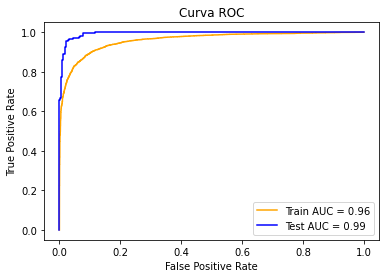

Parcelas con acierto:  35 de 35   100.00%
Test ROC AUC: 0.9942857142857143
Exito min:  0.49713906378338646 
Exito max:  0.9921279972753825 
Exito promedio:  0.8302172993598707
Exito * accuracy =  0.7993806568122183
Exito * accuracy / (Exito + accuracy) =  0.44581565493947867
              precision    recall  f1-score   support

           0       0.98      0.99      0.98       525
           1       0.96      0.95      0.95       175

    accuracy                           0.98       700
   macro avg       0.97      0.97      0.97       700
weighted avg       0.98      0.98      0.98       700



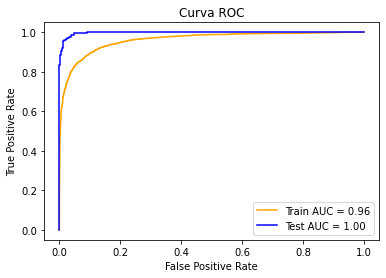

Parcelas con acierto:  35 de 35   100.00%
Test ROC AUC: 0.9974857142857143
Exito min:  0.6334424121964992 
Exito max:  0.9779914192018835 
Exito promedio:  0.8482092375750285
Exito * accuracy =  0.8288215978590279
Exito * accuracy / (Exito + accuracy) =  0.4540612193436166
              precision    recall  f1-score   support

           0       0.88      0.90      0.89       525
           1       0.68      0.65      0.66       175

    accuracy                           0.84       700
   macro avg       0.78      0.77      0.78       700
weighted avg       0.83      0.84      0.83       700



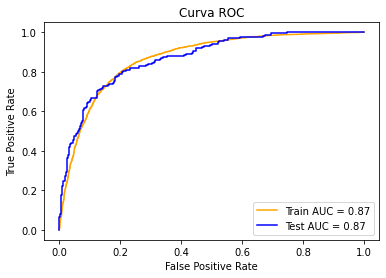

Parcelas con acierto:  33 de 35   94.29%
Test ROC AUC: 0.8695292517006803
Exito min:  0.4633616974953577 
Exito max:  0.9741319891189069 
Exito promedio:  0.71726328013595
Exito * accuracy =  0.5994271698279011
Exito * accuracy / (Exito + accuracy) =  0.38598572381805285
              precision    recall  f1-score   support

           0       0.97      0.97      0.97       525
           1       0.91      0.91      0.91       175

    accuracy                           0.95       700
   macro avg       0.94      0.94      0.94       700
weighted avg       0.95      0.95      0.95       700



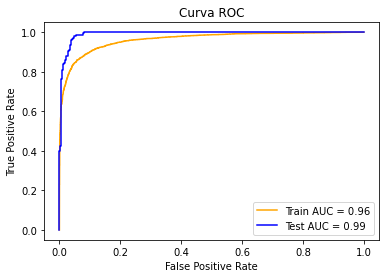

Parcelas con acierto:  35 de 35   100.00%
Test ROC AUC: 0.9920761904761904
Exito min:  0.540073672885535 
Exito max:  0.9573898266109 
Exito promedio:  0.8049858914179927
Exito * accuracy =  0.7681865363817416
Exito * accuracy / (Exito + accuracy) =  0.4366503352246555
              precision    recall  f1-score   support

           0       0.94      0.97      0.95       525
           1       0.89      0.82      0.86       175

    accuracy                           0.93       700
   macro avg       0.92      0.90      0.91       700
weighted avg       0.93      0.93      0.93       700



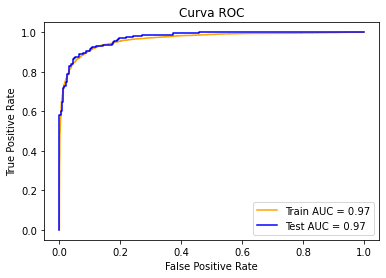

Parcelas con acierto:  35 de 35   100.00%
Test ROC AUC: 0.9725823129251701
Exito min:  0.3636812479271419 
Exito max:  0.961317716663454 
Exito promedio:  0.7614107104223269
Exito * accuracy =  0.7091996902790816
Exito * accuracy / (Exito + accuracy) =  0.41894094606764115
              precision    recall  f1-score   support

           0       0.81      0.90      0.85       525
           1       0.54      0.35      0.43       175

    accuracy                           0.76       700
   macro avg       0.68      0.63      0.64       700
weighted avg       0.74      0.76      0.75       700



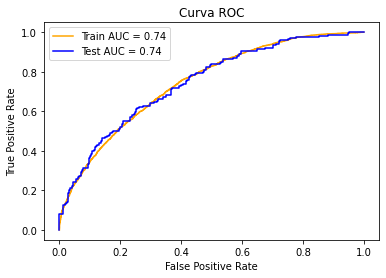

Parcelas con acierto:  24 de 35   68.57%
Test ROC AUC: 0.7447727891156464
Exito min:  0.3116050821929074 
Exito max:  0.9282969375301974 
Exito promedio:  0.5948112567623032
Exito * accuracy =  0.45460574623976024
Exito * accuracy / (Exito + accuracy) =  0.33449103038557126
              precision    recall  f1-score   support

           0       0.92      0.92      0.92       510
           1       0.76      0.77      0.77       170

    accuracy                           0.88       680
   macro avg       0.84      0.85      0.84       680
weighted avg       0.88      0.88      0.88       680



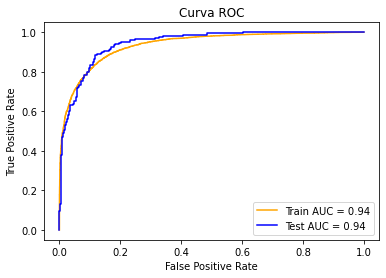

Parcelas con acierto:  33 de 34   97.06%
Test ROC AUC: 0.9449826989619378
Exito min:  0.40530756209797264 
Exito max:  0.9610633979051514 
Exito promedio:  0.7580616149204783
Exito * accuracy =  0.6688778955180691
Exito * accuracy / (Exito + accuracy) =  0.40774930521802705
              precision    recall  f1-score   support

           0       0.95      0.99      0.97       510
           1       0.97      0.84      0.90       170

    accuracy                           0.95       680
   macro avg       0.96      0.91      0.93       680
weighted avg       0.95      0.95      0.95       680



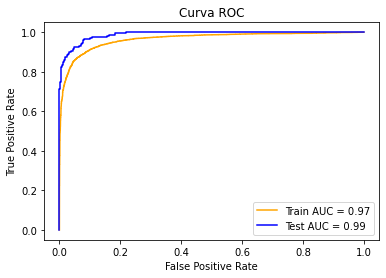

Parcelas con acierto:  34 de 34   100.00%
Test ROC AUC: 0.9886620530565167
Exito min:  0.5120923806133444 
Exito max:  0.9670564800893957 
Exito promedio:  0.7984398941755718
Exito * accuracy =  0.7596920757817572
Exito * accuracy / (Exito + accuracy) =  0.4341319647020591
              precision    recall  f1-score   support

           0       0.94      0.94      0.94       510
           1       0.83      0.82      0.82       170

    accuracy                           0.91       680
   macro avg       0.88      0.88      0.88       680
weighted avg       0.91      0.91      0.91       680



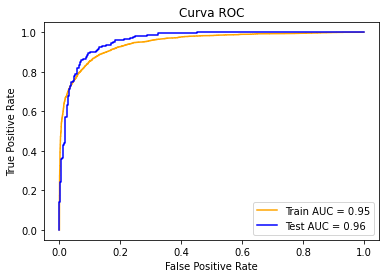

Parcelas con acierto:  33 de 34   97.06%
Test ROC AUC: 0.960322952710496
Exito min:  0.444555784867647 
Exito max:  0.9463564466156501 
Exito promedio:  0.7541770485085193
Exito * accuracy =  0.6876320148165911
Exito * accuracy / (Exito + accuracy) =  0.41275873721528394
              precision    recall  f1-score   support

           0       0.87      0.89      0.88       510
           1       0.66      0.61      0.63       170

    accuracy                           0.82       680
   macro avg       0.76      0.75      0.76       680
weighted avg       0.82      0.82      0.82       680



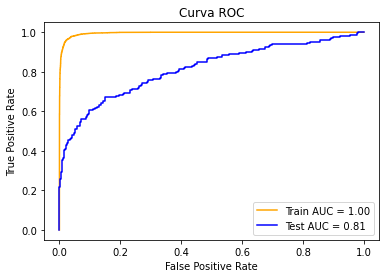

Parcelas con acierto:  28 de 34   82.35%
Test ROC AUC: 0.8144290657439446
Exito min:  0.25597224517242706 
Exito max:  0.9545866975691337 
Exito promedio:  0.7072334300871943
Exito * accuracy =  0.5813874814981494
Exito * accuracy / (Exito + accuracy) =  0.38016767568346255


In [14]:
carpeta = "Optuna-LGBM-2-20230214"
num_trial_best = obtenerParametrosOptimosLGBM(carpeta = carpeta, n_splits = 10, random_state = 33, normalizacion=[0,1], n_trials=500)

# carga el mejor modelo
best_model_file = os.path.join(carpeta, f"model_trial_{num_trial_best}.joblib")
params, score, best_model = joblib.load(best_model_file)

probarMejorModelo(best_model, umbral=0.6)

El mejor modelo:
 - 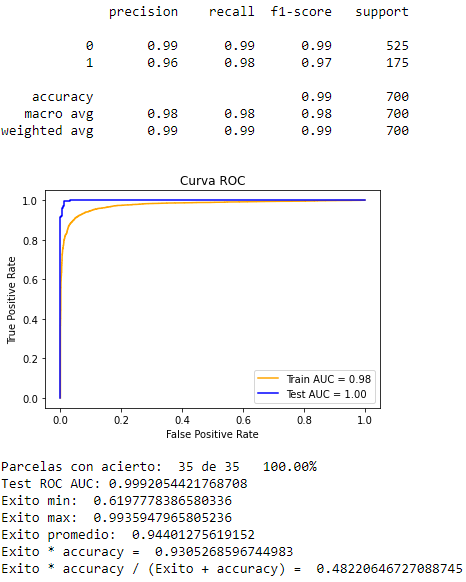
 - 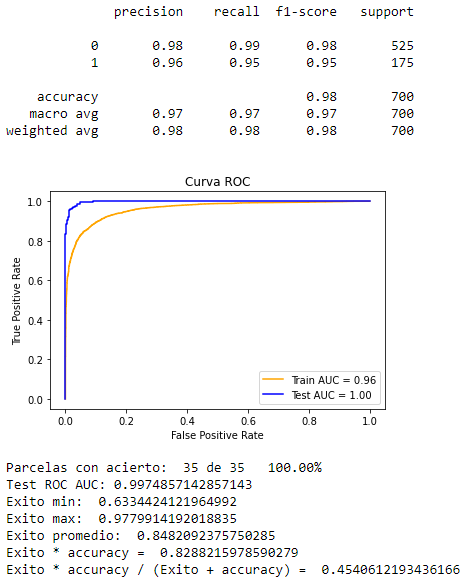